# Nerfies Dataset Processing.

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook contains an example workflow for converting a video file to a Nerfies dataset.

### Instructions

1. Convert a video into our dataset format using this notebook.
2. Train a Nerfie using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb).


### Notes
* While this will work for small datasets in a Colab runtime, larger datasets will require more compute power.
* If you would like to train a model on a serious dataset, you should consider copying this to your own workstation and running it there. Some minor modifications will be required, and you will have to install the dependencies separately.
* Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

If you find this work useful, please consider citing:
```bibtex
@article{park2021nerfies
  author    = {Park, Keunhong 
               and Sinha, Utkarsh 
               and Barron, Jonathan T. 
               and Bouaziz, Sofien 
               and Goldman, Dan B 
               and Seitz, Steven M. 
               and Martin-Brualla, Ricardo},
  title     = {Nerfies: Deformable Neural Radiance Fields},
  journal   = {ICCV},
  year      = {2021},
}
```

In [1]:
from pathlib import Path
import concurrent.futures
import numpy as np
import cv2
import imageio
from PIL import Image

## Configuration.

Mount Google Drive onto `/content/gdrive`. You can skip this if you want to run this locally.

In [2]:
# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = './data/'  # @param {type: 'string'}
# @markdown The name of this capture. The working directory will be `$save_dir/$capture_name`. **Make sure you change this** when processing a new video.
capture_name = 'kubric_test'  # @param {type: 'string'}
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'rgb-raw'
# Where to save the COLMAP outputs.
colmap_dir = root_dir / 'colmap'
colmap_db_path = colmap_dir / 'database.db'
colmap_out_path = colmap_dir / 'sparse'

colmap_out_path.mkdir(exist_ok=True, parents=True)
rgb_raw_dir.mkdir(exist_ok=True, parents=True)

print(f"""Directories configured:
  root_dir = {root_dir}
  rgb_raw_dir = {rgb_raw_dir}
  rgb_dir = {rgb_dir}
  colmap_dir = {colmap_dir}
""")

Directories configured:
  root_dir = data/kubric_test
  rgb_raw_dir = data/kubric_test/rgb-raw
  rgb_dir = data/kubric_test/rgb
  colmap_dir = data/kubric_test/colmap



## Dataset Processing.

### Load Video.

In this step we upload a video file and flatten it into PNG files using ffmpeg.

In [3]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.

tmp_rgb_raw_dir = rgb_raw_dir


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1,2"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

for image_path in Path(tmp_rgb_raw_dir).glob('*.png'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))

# !rsync -av "$tmp_rgb_dir/" "$rgb_dir/"

Saving data/kubric_test/rgb/1x/000068.png
Saving data/kubric_test/rgb/2x/000068.png
Saving data/kubric_test/rgb/1x/000024.png
Saving data/kubric_test/rgb/2x/000024.png
Saving data/kubric_test/rgb/1x/000182.png
Saving data/kubric_test/rgb/2x/000182.png
Saving data/kubric_test/rgb/1x/000115.png
Saving data/kubric_test/rgb/2x/000115.png
Saving data/kubric_test/rgb/1x/000075.png
Saving data/kubric_test/rgb/2x/000075.png
Saving data/kubric_test/rgb/1x/000144.png
Saving data/kubric_test/rgb/2x/000144.png
Saving data/kubric_test/rgb/1x/000069.png
Saving data/kubric_test/rgb/2x/000069.png
Saving data/kubric_test/rgb/1x/000070.png
Saving data/kubric_test/rgb/2x/000070.png
Saving data/kubric_test/rgb/1x/000198.png
Saving data/kubric_test/rgb/2x/000198.png
Saving data/kubric_test/rgb/1x/000010.png
Saving data/kubric_test/rgb/2x/000010.png
Saving data/kubric_test/rgb/1x/000047.png
Saving data/kubric_test/rgb/2x/000047.png
Saving data/kubric_test/rgb/1x/000033.png
Saving data/kubric_test/rgb/2x/000

Saving data/kubric_test/rgb/1x/000197.png
Saving data/kubric_test/rgb/2x/000197.png
Saving data/kubric_test/rgb/1x/000087.png
Saving data/kubric_test/rgb/2x/000087.png
Saving data/kubric_test/rgb/1x/000150.png
Saving data/kubric_test/rgb/2x/000150.png
Saving data/kubric_test/rgb/1x/000164.png
Saving data/kubric_test/rgb/2x/000164.png
Saving data/kubric_test/rgb/1x/000007.png
Saving data/kubric_test/rgb/2x/000007.png
Saving data/kubric_test/rgb/1x/000160.png
Saving data/kubric_test/rgb/2x/000160.png
Saving data/kubric_test/rgb/1x/000193.png
Saving data/kubric_test/rgb/2x/000193.png
Saving data/kubric_test/rgb/1x/000036.png
Saving data/kubric_test/rgb/2x/000036.png
Saving data/kubric_test/rgb/1x/000089.png
Saving data/kubric_test/rgb/2x/000089.png
Saving data/kubric_test/rgb/1x/000023.png
Saving data/kubric_test/rgb/2x/000023.png
Saving data/kubric_test/rgb/1x/000155.png
Saving data/kubric_test/rgb/2x/000155.png
Saving data/kubric_test/rgb/1x/000111.png
Saving data/kubric_test/rgb/2x/000

Saving data/kubric_test/rgb/1x/000129.png
Saving data/kubric_test/rgb/2x/000129.png
Saving data/kubric_test/rgb/1x/000027.png
Saving data/kubric_test/rgb/2x/000027.png
Saving data/kubric_test/rgb/1x/000094.png
Saving data/kubric_test/rgb/2x/000094.png


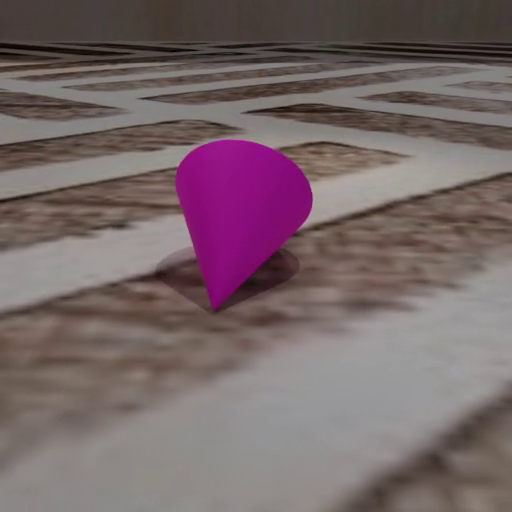

In [4]:
# @title Example frame.
# @markdown Make sure that the video was processed correctly.
# @markdown If this gives an exception, try running the preceding cell one more time--sometimes uploading to Google Drive can fail.

image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

### Camera registration with COLMAP.

In [5]:
# @title Extract features.
# @markdown Computes SIFT features and saves them to the COLMAP DB.
share_intrinsics = True  # @param {type: 'boolean'}
assume_upright_cameras = True  # @param {type: 'boolean'}

# @markdown This sets the scale at which we will run COLMAP. A scale of 1 will be more accurate but will be slow.
colmap_image_scale = 4  # @param {type: 'number'}
colmap_rgb_dir = rgb_dir / f'{colmap_image_scale}x'

# @markdown Check this if you want to re-process SfM.
overwrite = True  # @param {type: 'boolean'}

if overwrite and colmap_db_path.exists():
  colmap_db_path.unlink()

!colmap feature_extractor \
--SiftExtraction.use_gpu 0 \
--SiftExtraction.upright {int(assume_upright_cameras)} \
--ImageReader.camera_model OPENCV \
--ImageReader.single_camera {int(share_intrinsics)} \
--database_path "{str(colmap_db_path)}" \
--image_path "{str(colmap_rgb_dir)}"


Feature extraction

Processed file [1/200]
  Name:            000001.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        141
Processed file [2/200]
  Name:            000002.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        154
Processed file [3/200]
  Name:            000004.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        149
Processed file [4/200]
  Name:            000006.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        143
Processed file [5/200]
  Name:            000007.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        142
Processed file [6/200]
  Name:            000005.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:       

Processed file [52/200]
  Name:            000056.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        123
Processed file [53/200]
  Name:            000057.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        128
Processed file [54/200]
  Name:            000055.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        132
Processed file [55/200]
  Name:            000054.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        145
Processed file [56/200]
  Name:            000059.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        108
Processed file [57/200]
  Name:            000053.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        131
Processed 

Processed file [104/200]
  Name:            000099.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        131
Processed file [105/200]
  Name:            000107.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        142
Processed file [106/200]
  Name:            000110.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        137
Processed file [107/200]
  Name:            000109.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        143
Processed file [108/200]
  Name:            000105.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        134
Processed file [109/200]
  Name:            000101.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        143
Proc

Processed file [162/200]
  Name:            000165.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        141
Processed file [163/200]
  Name:            000160.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        139
Processed file [164/200]
  Name:            000167.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        140
Processed file [165/200]
  Name:            000166.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        146
Processed file [166/200]
  Name:            000161.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        143
Processed file [167/200]
  Name:            000168.png
  Dimensions:      128 x 128
  Camera:          #1 - OPENCV
  Focal Length:    153.60px
  Features:        136
Proc

In [6]:
# @title Match features.
# @markdown Match the SIFT features between images. Use `exhaustive` if you only have a few images and use `vocab_tree` if you have a lot of images.

match_method = 'exhaustive'  # @param ["exhaustive", "vocab_tree"]

if match_method == 'exhaustive':
  !colmap exhaustive_matcher \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"
else:
  # Use this if you have lots of frames.
  !wget https://demuc.de/colmap/vocab_tree_flickr100K_words32K.bin
  !colmap vocab_tree_matcher \
    --VocabTreeMatching.vocab_tree_path vocab_tree_flickr100K_words32K.bin \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"


Exhaustive feature matching

Matching block [1/4, 1/4] in 0.984s
Matching block [1/4, 2/4] in 0.601s
Matching block [1/4, 3/4] in 0.555s
Matching block [1/4, 4/4] in 0.626s
Matching block [2/4, 1/4] in 0.882s
Matching block [2/4, 2/4] in 0.701s
Matching block [2/4, 3/4] in 0.492s
Matching block [2/4, 4/4] in 0.550s
Matching block [3/4, 1/4] in 0.510s
Matching block [3/4, 2/4] in 0.642s
Matching block [3/4, 3/4] in 0.611s
Matching block [3/4, 4/4] in 0.491s
Matching block [4/4, 1/4] in 0.534s
Matching block [4/4, 2/4] in 0.519s
Matching block [4/4, 3/4] in 0.552s
Matching block [4/4, 4/4] in 0.688s
Elapsed time: 0.167 [minutes]


In [ ]:
# @title Reconstruction.
# @markdown Run structure-from-motion to compute camera parameters.

refine_principal_point = True  #@param {type:"boolean"}
min_num_matches = 64# @param {type: 'number'}
filter_max_reproj_error = 2  # @param {type: 'number'}
tri_complete_max_reproj_error = 2  # @param {type: 'number'}

!colmap mapper \
  --Mapper.ba_refine_principal_point {int(refine_principal_point)} \
  --Mapper.filter_max_reproj_error $filter_max_reproj_error \
  --Mapper.tri_complete_max_reproj_error $tri_complete_max_reproj_error \
  --Mapper.min_num_matches $min_num_matches \
  --database_path "{str(colmap_db_path)}" \
  --image_path "{str(colmap_rgb_dir)}" \
  --output_path "{str(colmap_out_path)}" # renamed to output path


Loading database

Loading cameras... 1 in 0.000s
Loading matches... 6993 in 0.025s
Loading images... 200 in 0.004s (connected 200)
Building correspondence graph... in 0.026s (ignored 3883)

Elapsed time: 0.001 [minutes]

  => No good initial image pair found.
  => Relaxing the initialization constraints.

Initializing with image pair #170 and #194


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.557388e+01    0.00e+00    1.06e+03   0.00e+00   0.00e+00  1.00e+04        0    5.23e-03    5.86e-03
   1  1.469670e+02   -1.21e+02    0.00e+00   2.15e+01  -5.47e+00  5.00e+03        1    1.27e-02    1.86e-02
   2  8.797485e+01   -6.24e+01    0.00e+00   1.54e+01  -2.85e+00  1.25e+03        1    1.41e-02    3.28e-02
   3  2.383477e+01    1.74e+00    9.44e+02   5.86e+00   8.35e-02  7.92e+02        1    1.95e-02    5.24e-02
   4  4.619933e+00    1.92e+01    4.08e+01   4.34e+00   9.95e-01  2.38e+03       

  67  2.554638e+00    2.69e-02    4.11e+01   1.40e+00   4.34e-01  1.18e+04        1    1.74e-02    1.42e+00
  68  2.526333e+00    2.83e-02    4.40e+01   1.59e+00   4.01e-01  1.17e+04        1    2.00e-02    1.44e+00
  69  2.497260e+00    2.91e-02    4.62e+01   1.70e+00   3.54e-01  1.14e+04        1    1.94e-02    1.46e+00
  70  2.467114e+00    3.01e-02    4.68e+01   1.71e+00   3.08e-01  1.08e+04        1    1.80e-02    1.47e+00
  71  2.426088e+00    4.10e-02    4.40e+01   1.66e+00   3.53e-01  1.06e+04        1    1.64e-02    1.49e+00
  72  2.363295e+00    6.28e-02    4.19e+01   1.74e+00   4.93e-01  1.06e+04        1    1.74e-02    1.51e+00
  73  2.274275e+00    8.90e-02    4.11e+01   2.02e+00   7.63e-01  1.24e+04        1    1.83e-02    1.53e+00
  74  2.246280e+00    2.80e-02    7.37e+01   1.94e+00   3.42e-01  1.20e+04        1    1.72e-02    1.54e+00
  75  2.188032e+00    5.82e-02    1.11e+02   1.90e+00   5.39e-01  1.20e+04        1    1.82e-02    1.56e+00
  76  2.135232e+00    5.28e-

   1  1.869857e+00    9.03e-04    1.83e+00   6.88e-01   9.99e-01  3.00e+04        1    1.76e-02    1.98e-02
   2  1.869223e+00    6.34e-04    1.75e+00   1.71e+00   8.95e-01  5.92e+04        1    1.75e-02    3.73e-02
   3  1.868717e+00    5.07e-04    5.44e+00   3.09e+00   3.82e-01  5.84e+04        1    1.76e-02    5.49e-02
   4  1.867410e+00    1.31e-03    4.11e+00   2.95e+00   6.96e-01  6.21e+04        1    1.71e-02    7.20e-02
   5  1.866389e+00    1.02e-03    3.54e+00   2.94e+00   6.54e-01  6.40e+04        1    1.61e-02    8.82e-02
   6  1.865408e+00    9.81e-04    2.78e+00   2.83e+00   6.87e-01  6.75e+04        1    1.62e-02    1.04e-01
   7  1.864549e+00    8.59e-04    2.21e+00   2.78e+00   6.79e-01  7.08e+04        1    1.59e-02    1.20e-01
   8  1.863752e+00    7.97e-04    1.66e+00   2.70e+00   6.89e-01  7.48e+04        1    1.58e-02    1.36e-01
   9  1.863030e+00    7.22e-04    1.79e+00   2.64e+00   6.87e-01  7.90e+04        1    1.57e-02    1.52e-01
  10  1.862364e+00    6.66e-

  79  1.856959e+00    1.53e-06    2.24e+00   3.10e+00   1.60e-01  9.76e+05        1    1.60e-02    1.05e+00
  80  1.856953e+00    6.72e-06    7.96e-01   2.04e-01   6.42e-01  9.99e+05        1    1.36e-02    1.06e+00
  81  1.856949e+00    3.48e-06    6.59e-01   2.05e+00   6.77e-01  1.05e+06        1    1.66e-02    1.08e+00
  82  1.856946e+00    2.71e-06    9.50e-01   7.03e-01   6.54e-01  1.08e+06        1    1.52e-02    1.10e+00
  83  1.856943e+00    3.76e-06    4.18e-01   1.82e+00   8.78e-01  1.90e+06        1    1.42e-02    1.11e+00
  84  1.856944e+00   -1.72e-06    0.00e+00   1.68e+00  -2.82e-01  9.49e+05        1    1.35e-02    1.12e+00
  85  1.856940e+00    2.46e-06    8.60e-01   8.73e-01   7.90e-01  1.18e+06        1    1.31e-02    1.14e+00
  86  1.856937e+00    3.47e-06    8.11e-01   1.75e+00   8.81e-01  2.11e+06        1    1.55e-02    1.15e+00
  87  1.856940e+00   -2.91e-06    0.00e+00   2.21e+00  -4.39e-01  1.05e+06        1    1.26e-02    1.17e+00
  88  1.856934e+00    2.83e-


Initializing with image pair #160 and #140


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.817751e+00    0.00e+00    5.43e+02   0.00e+00   0.00e+00  1.00e+04        0    2.83e-03    3.07e-03
   1  9.633866e+00   -8.16e-01    0.00e+00   9.06e+00  -1.14e-01  5.00e+03        1    9.80e-03    1.29e-02
   2  8.232879e+00    5.85e-01    8.39e+02   6.15e+00   8.24e-02  3.16e+03        1    1.37e-02    2.66e-02
   3  1.728329e+00    6.50e+00    4.63e+01   3.05e+00   9.94e-01  9.48e+03        1    1.35e-02    4.01e-02
   4  1.699529e+00    2.88e-02    7.56e+01   7.03e+00   2.37e-01  8.28e+03        1    1.34e-02    5.36e-02
   5  1.590213e+00    1.09e-01    1.97e+01   4.94e+00   9.10e-01  1.85e+04        1    1.37e-02    6.73e-02
   6  1.578698e+00    1.15e-02    3.59e+01   8.41e+00   2.73e-01  1.69e+04        1    1.35e-02    8.08e-02
   7  1.536864e+00    4.18e-02    1.91e+01   6.16e+00   8.62e-01


Initializing with image pair #172 and #195


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.562583e+00    0.00e+00    7.97e+02   0.00e+00   0.00e+00  1.00e+04        0    1.82e-04    4.38e-04
   1  9.609587e+01   -8.75e+01    0.00e+00   9.81e+00  -1.06e+01  5.00e+03        1    3.01e-04    7.64e-04
   2  8.028489e+01   -7.17e+01    0.00e+00   7.32e+00  -8.76e+00  1.25e+03        1    2.51e-04    1.03e-03
   3  3.859407e+01   -3.00e+01    0.00e+00   5.34e+00  -3.77e+00  1.56e+02        1    2.60e-04    1.31e-03
   4  3.020037e+00    5.54e+00    1.81e+02   2.48e+00   8.45e-01  2.33e+02        1    2.84e-04    1.61e-03
   5  1.745259e+00    1.27e+00    1.12e+02   2.09e+00   6.86e-01  2.45e+02        1    3.18e-04    1.94e-03
   6  9.303552e-01    8.15e-01    4.11e+01   1.33e+00   9.26e-01  6.41e+02        1    4.33e-04    2.39e-03
   7  7.224978e-01    2.08e-01    6.59e+01   1.74e+00   6.23e-01

  => Could not register, trying another image.

Registering image #187 (3)

  => Image sees 37 / 137 points
  => Could not register, trying another image.

Registering image #182 (3)

  => Image sees 36 / 149 points
  => Could not register, trying another image.

Registering image #200 (3)

  => Image sees 36 / 156 points
  => Could not register, trying another image.

Registering image #191 (3)

  => Image sees 36 / 145 points
  => Could not register, trying another image.

Registering image #164 (3)

  => Image sees 34 / 138 points
  => Could not register, trying another image.

Retriangulation

  => Merged observations: 0
  => Completed observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.300678e-01    0.00e+00    1.97e+00   0.00e+00   0.00e+00  1.00e+04        0    1.33e-03    1.64e-03
   1  1.300207e-01    4.71e-05    5.27e-02   7.63e-02   1


Initializing with image pair #182 and #197


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.998368e+01    0.00e+00    6.32e+02   0.00e+00   0.00e+00  1.00e+04        0    3.58e-03    3.92e-03
   1  1.997607e+02   -1.20e+02    0.00e+00   1.81e+01  -1.55e+00  5.00e+03        1    2.30e-02    2.69e-02
   2  1.033067e+02   -2.33e+01    0.00e+00   1.52e+01  -3.02e-01  1.25e+03        1    1.15e-02    3.84e-02
   3  1.942779e+01    6.06e+01    6.75e+02   1.11e+01   7.91e-01  1.56e+03        1    1.60e-02    5.45e-02
   4  5.321748e+00    1.41e+01    3.78e+02   3.91e+00   8.60e-01  2.48e+03        1    1.76e-02    7.22e-02
   5  3.862102e+00    1.46e+00    2.68e+02   4.20e+00   5.31e-01  2.49e+03        1    1.13e-03    7.33e-02
   6  2.524088e+00    1.34e+00    7.11e+01   3.49e+00   9.29e-01  6.75e+03        1    5.06e-04    7.39e-02
   7  2.498954e+00    2.51e-02    9.48e+01   6.57e+00   1.07e-01

  73  1.627694e+00    7.22e-05    5.21e+00   8.66e-01   6.98e-01  3.16e+05        1    1.58e-02    1.13e+00
  74  1.627629e+00    6.49e-05    4.72e+00   8.39e-01   7.22e-01  3.46e+05        1    1.22e-02    1.14e+00
  75  1.627574e+00    5.49e-05    4.43e+00   8.40e-01   7.13e-01  3.75e+05        1    1.30e-02    1.15e+00
  76  1.627524e+00    4.98e-05    3.92e+00   8.16e-01   7.47e-01  4.27e+05        1    1.33e-02    1.17e+00
  77  1.627484e+00    4.00e-05    3.77e+00   8.42e-01   7.11e-01  4.61e+05        1    1.44e-02    1.18e+00
  78  1.627446e+00    3.81e-05    3.21e+00   8.06e-01   7.75e-01  5.53e+05        1    1.62e-02    1.20e+00
  79  1.627419e+00    2.76e-05    3.36e+00   8.81e-01   6.75e-01  5.78e+05        1    1.48e-02    1.21e+00
  80  1.627388e+00    3.04e-05    2.64e+00   8.04e-01   8.14e-01  7.69e+05        1    1.50e-02    1.23e+00
  81  1.627372e+00    1.64e-05    3.47e+00   9.97e-01   5.33e-01  7.69e+05        1    1.39e-02    1.24e+00
  82  1.627345e+00    2.72e-


Initializing with image pair #136 and #116


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.426743e+00    0.00e+00    1.21e+03   0.00e+00   0.00e+00  1.00e+04        0    1.51e-03    1.80e-03
   1  3.934694e+01   -2.99e+01    0.00e+00   7.78e+00  -3.82e+00  5.00e+03        1    1.11e-02    1.29e-02
   2  2.295547e+01   -1.35e+01    0.00e+00   4.71e+00  -1.75e+00  1.25e+03        1    1.15e-02    2.44e-02
   3  9.107794e+00    3.19e-01    8.51e+02   2.59e+00   4.26e-02  7.08e+02        1    1.39e-02    3.84e-02
   4  1.960125e+00    7.15e+00    1.48e+02   1.17e+00   9.80e-01  2.12e+03        1    1.44e-02    5.28e-02
   5  1.779943e+00    1.80e-01    1.06e+02   1.01e+00   7.94e-01  2.67e+03        1    1.36e-02    6.64e-02
   6  1.688026e+00    9.19e-02    3.41e+01   1.57e+00   9.24e-01  6.80e+03        1    1.46e-02    8.10e-02
   7  1.654313e+00    3.37e-02    8.27e+01   3.94e+00   3.58e-01

  73  1.191646e+00    9.96e-07    1.99e+00   2.15e-01   5.53e-01  2.21e+06        1    1.48e-02    1.04e+00
  74  1.191645e+00    9.92e-07    1.99e+00   2.15e-01   5.54e-01  2.21e+06        1    1.52e-02    1.06e+00
  75  1.191644e+00    9.88e-07    1.98e+00   2.15e-01   5.54e-01  2.21e+06        1    1.40e-02    1.07e+00
  76  1.191643e+00    9.85e-07    1.98e+00   2.16e-01   5.55e-01  2.21e+06        1    1.39e-02    1.09e+00
  77  1.191642e+00    9.81e-07    1.98e+00   2.16e-01   5.55e-01  2.22e+06        1    1.44e-02    1.10e+00
  78  1.191641e+00    9.77e-07    1.98e+00   2.16e-01   5.55e-01  2.22e+06        1    1.37e-02    1.11e+00
  79  1.191640e+00    9.74e-07    1.98e+00   2.16e-01   5.56e-01  2.22e+06        1    1.39e-02    1.13e+00
  80  1.191639e+00    9.70e-07    1.98e+00   2.16e-01   5.56e-01  2.23e+06        1    1.42e-02    1.14e+00
  81  1.191638e+00    9.66e-07    1.98e+00   2.16e-01   5.56e-01  2.23e+06        1    1.42e-02    1.16e+00
  82  1.191637e+00    9.63e-



Bundle adjustment report
------------------------
    Residuals : 228
   Parameters : 184
   Iterations : 2
         Time : 0.0155753 [s]
 Initial cost : 0.0722939 [px]
   Final cost : 0.0722939 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #130 (3)

  => Image sees 45 / 129 points
  => Could not register, trying another image.

Registering image #107 (3)

  => Image sees 45 / 142 points
  => Could not register, trying another image.

Registering image #148 (3)

  => Image sees 45 / 157 points
  => Could not register, trying another image.

Registering image #129 (3)

  => Image sees 45 / 135 points
  => Could not register, trying another image.

Registering image #141 (3)

  => Image sees 45 / 149 points
  => Could not register, trying another image.

Registering image #143 (3)

  => Image sees 45 / 140 points
  => Could not regi


Initializing with image pair #92 and #74


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.346409e+01    0.00e+00    1.18e+03   0.00e+00   0.00e+00  1.00e+04        0    1.68e-03    1.87e-03
   1  1.604096e+01   -2.58e+00    0.00e+00   2.69e+01  -2.08e-01  5.00e+03        1    1.17e-02    1.36e-02
   2  7.162029e+00    6.30e+00    8.53e+02   2.10e+01   5.15e-01  5.00e+03        1    1.60e-02    2.96e-02
   3  1.487252e+00    5.67e+00    1.48e+02   4.90e+00   9.31e-01  1.40e+04        1    1.62e-02    4.58e-02
   4  1.437740e+00    4.95e-02    1.46e+02   7.58e+00   9.46e-02  9.12e+03        1    1.62e-02    6.20e-02
   5  9.535507e-01    4.84e-01    1.87e+01   3.57e+00   9.83e-01  2.74e+04        1    1.63e-02    7.83e-02
   6  1.038050e+00   -8.45e-02    0.00e+00   7.73e+00  -2.20e+00  1.37e+04        1    1.28e-02    9.11e-02
   7  9.414800e-01    1.21e-02    2.23e+01   4.30e+00   4.54e-01  

  73  6.344521e-01    1.01e-03    5.17e+00   1.07e+00   7.50e-01  1.00e+05        1    1.39e-02    9.47e-01
  74  6.333974e-01    1.05e-03    6.01e+00   1.06e+00   7.03e-01  1.07e+05        1    1.44e-02    9.62e-01
  75  6.321589e-01    1.24e-03    6.20e+00   1.06e+00   7.23e-01  1.18e+05        1    1.37e-02    9.76e-01
  76  6.309011e-01    1.26e-03    7.01e+00   1.14e+00   6.64e-01  1.22e+05        1    1.46e-02    9.90e-01
  77  6.293631e-01    1.54e-03    6.62e+00   1.25e+00   7.10e-01  1.32e+05        1    1.36e-02    1.00e+00
  78  6.278554e-01    1.51e-03    6.95e+00   1.46e+00   6.50e-01  1.36e+05        1    1.36e-02    1.02e+00
  79  6.260251e-01    1.83e-03    5.55e+00   1.72e+00   7.00e-01  1.45e+05        1    1.39e-02    1.03e+00
  80  6.242878e-01    1.74e-03    6.32e+00   2.03e+00   6.31e-01  1.47e+05        1    1.37e-02    1.05e+00
  81  6.227568e-01    1.53e-03    9.91e+00   2.43e+00   4.86e-01  1.47e+05        1    1.35e-02    1.06e+00
  82  6.230896e-01   -3.33e-

   2  5.763236e-01    2.20e-03    3.48e+00   2.96e+00   7.95e-01  3.78e+04        1    1.39e-02    2.95e-02
   3  5.731303e-01    3.19e-03    5.20e+00   3.16e+00   8.65e-01  6.17e+04        1    1.42e-02    4.37e-02
   4  5.718607e-01    1.27e-03    1.49e+01   4.79e+00   2.59e-01  5.55e+04        1    1.38e-02    5.75e-02
   5  5.665425e-01    5.32e-03    1.23e+01   4.54e+00   6.89e-01  5.87e+04        1    1.50e-02    7.25e-02
   6  5.631419e-01    3.40e-03    1.41e+01   4.88e+00   5.16e-01  5.87e+04        1    1.40e-02    8.66e-02
   7  5.589010e-01    4.24e-03    1.42e+01   4.94e+00   5.78e-01  5.89e+04        1    1.44e-02    1.01e-01
   8  5.546742e-01    4.23e-03    1.45e+01   4.95e+00   5.86e-01  5.92e+04        1    1.49e-02    1.16e-01
   9  5.504347e-01    4.24e-03    1.42e+01   4.90e+00   6.07e-01  5.98e+04        1    1.44e-02    1.31e-01
  10  5.463004e-01    4.13e-03    1.35e+01   4.78e+00   6.33e-01  6.09e+04        1    1.39e-02    1.44e-01
  11  5.424085e-01    3.89e-

  78  4.984677e-01    3.75e-05    1.98e+00   8.36e-01   5.59e-01  2.95e+05        1    1.35e-02    7.36e-01
  79  4.984309e-01    3.69e-05    1.94e+00   8.30e-01   5.62e-01  2.96e+05        1    1.38e-02    7.50e-01
  80  4.983946e-01    3.63e-05    1.91e+00   8.25e-01   5.65e-01  2.97e+05        1    1.35e-02    7.64e-01
  81  4.983590e-01    3.57e-05    1.88e+00   8.21e-01   5.68e-01  2.97e+05        1    1.37e-02    7.77e-01
  82  4.983238e-01    3.51e-05    1.85e+00   8.16e-01   5.70e-01  2.98e+05        1    1.36e-02    7.91e-01
  83  4.982893e-01    3.46e-05    1.82e+00   8.12e-01   5.73e-01  2.99e+05        1    1.46e-02    8.06e-01
  84  4.982552e-01    3.41e-05    1.80e+00   8.09e-01   5.75e-01  3.00e+05        1    1.38e-02    8.19e-01
  85  4.982216e-01    3.36e-05    1.77e+00   8.05e-01   5.77e-01  3.01e+05        1    1.46e-02    8.34e-01
  86  4.981885e-01    3.31e-05    1.75e+00   8.02e-01   5.78e-01  3.02e+05        1    1.45e-02    8.49e-01
  87  4.981558e-01    3.27e-


Initializing with image pair #94 and #80


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.647198e+00    0.00e+00    1.33e+03   0.00e+00   0.00e+00  1.00e+04        0    1.52e-03    1.76e-03
   1  1.271973e+02   -1.21e+02    0.00e+00   1.14e+01  -2.20e+01  5.00e+03        1    8.51e-03    1.03e-02
   2  7.106891e+01   -6.44e+01    0.00e+00   7.04e+00  -1.22e+01  1.25e+03        1    1.07e-02    2.11e-02
   3  2.682610e+01   -2.02e+01    0.00e+00   3.06e+00  -4.15e+00  1.56e+02        1    1.25e-02    3.36e-02
   4  3.999829e+00    2.65e+00    3.77e+02   1.29e+00   6.60e-01  1.62e+02        1    1.58e-02    4.94e-02
   5  2.468489e+00    1.53e+00    1.78e+02   1.01e+00   8.83e-01  2.93e+02        1    1.58e-02    6.52e-02
   6  2.193231e+00    2.75e-01    2.29e+02   1.15e+00   4.97e-01  2.93e+02        1    1.46e-02    7.98e-02
   7  1.805632e+00    3.88e-01    1.12e+02   8.92e-01   8.67e-01  

  75  7.868430e-01    6.37e-04    7.43e+00   5.35e+00   4.73e-01  1.27e+05        1    1.36e-02    1.08e+00
  76  7.862091e-01    6.34e-04    7.54e+00   5.18e+00   4.95e-01  1.27e+05        1    1.38e-02    1.10e+00
  77  7.855849e-01    6.24e-04    7.62e+00   4.99e+00   5.19e-01  1.27e+05        1    1.31e-02    1.11e+00
  78  7.849761e-01    6.09e-04    7.73e+00   4.79e+00   5.43e-01  1.27e+05        1    1.40e-02    1.13e+00
  79  7.843863e-01    5.90e-04    7.90e+00   4.60e+00   5.65e-01  1.27e+05        1    1.40e-02    1.14e+00
  80  7.838162e-01    5.70e-04    8.19e+00   4.42e+00   5.82e-01  1.28e+05        1    1.40e-02    1.15e+00
  81  7.832631e-01    5.53e-04    8.65e+00   4.28e+00   5.94e-01  1.29e+05        1    1.46e-02    1.17e+00
  82  7.827225e-01    5.41e-04    9.36e+00   4.18e+00   5.97e-01  1.29e+05        1    1.34e-02    1.18e+00
  83  7.821904e-01    5.32e-04    1.04e+01   4.12e+00   5.90e-01  1.30e+05        1    1.36e-02    1.20e+00
  84  7.816688e-01    5.22e-

   2  8.224278e-01   -4.49e-02    0.00e+00   7.85e-01  -3.16e+01  1.25e+03        1    1.08e-02    2.15e-02
   3  7.772816e-01    1.98e-04    1.00e+00   2.50e-01   3.46e-01  1.21e+03        1    1.39e-02    3.54e-02
   4  7.772123e-01    6.93e-05    1.34e+00   2.96e-01   6.69e-02  7.36e+02        1    1.40e-02    4.95e-02
   5  7.759004e-01    1.31e-03    9.83e-01   2.75e-01   9.24e-01  1.88e+03        1    1.45e-02    6.40e-02
   6  7.759690e-01   -6.86e-05    0.00e+00   3.61e-01  -1.17e-01  9.42e+02        1    1.09e-02    7.49e-02
   7  7.755510e-01    3.49e-04    9.50e-01   2.50e-01   7.84e-01  1.15e+03        1    1.45e-02    8.94e-02
   8  7.752849e-01    2.66e-04    5.28e-01   2.13e-01   9.13e-01  2.64e+03        1    1.44e-02    1.04e-01
   9  7.751345e-01    1.50e-04    4.89e-01   2.04e-01   8.63e-01  4.28e+03        1    1.39e-02    1.18e-01
  10  7.749959e-01    1.39e-04    2.64e-01   2.29e-01   9.74e-01  1.28e+04        1    1.52e-02    1.33e-01
  11  7.747628e-01    2.33e-

  78  7.622435e-01    6.66e-05    1.26e+00   2.40e+00   6.27e-01  6.36e+05        1    1.37e-02    9.80e-01
  79  7.621781e-01    6.54e-05    1.14e+00   2.37e+00   6.26e-01  6.47e+05        1    1.40e-02    9.94e-01
  80  7.621139e-01    6.42e-05    1.12e+00   2.35e+00   6.26e-01  6.57e+05        1    1.36e-02    1.01e+00
  81  7.620510e-01    6.30e-05    1.13e+00   2.32e+00   6.26e-01  6.68e+05        1    1.42e-02    1.02e+00
  82  7.619891e-01    6.18e-05    1.97e+00   2.29e+00   6.26e-01  6.79e+05        1    1.48e-02    1.04e+00
  83  7.619285e-01    6.07e-05    1.51e+00   2.27e+00   6.26e-01  6.90e+05        1    1.59e-02    1.05e+00
  84  7.618689e-01    5.96e-05    1.01e+00   2.24e+00   6.27e-01  7.02e+05        1    1.60e-02    1.07e+00
  85  7.618104e-01    5.85e-05    9.79e-01   2.22e+00   6.27e-01  7.13e+05        1    1.39e-02    1.08e+00
  86  7.617530e-01    5.74e-05    1.10e+00   2.19e+00   6.27e-01  7.25e+05        1    2.77e-02    1.11e+00
  87  7.616967e-01    5.64e-

  => No good initial image pair found.
  => Relaxing the initialization constraints.

Initializing with image pair #170 and #183


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.934823e+00    0.00e+00    2.05e+01   0.00e+00   0.00e+00  1.00e+04        0    2.42e-03    2.71e-03
   1  1.093449e+01   -9.00e+00    0.00e+00   1.75e+00  -1.81e+01  5.00e+03        1    1.03e-02    1.30e-02
   2  5.429137e+00   -3.49e+00    0.00e+00   1.19e+00  -7.83e+00  1.25e+03        1    1.20e-02    2.50e-02
   3  1.877167e+00    5.77e-02    1.21e+02   5.86e-01   1.94e-01  1.02e+03        1    1.60e-02    4.10e-02
   4  1.576240e+00    3.01e-01    1.83e+01   4.31e-01   9.70e-01  3.05e+03        1    1.37e-02    5.48e-02
   5  1.541796e+00    3.44e-02    4.10e+01   1.04e+00   3.32e-01  2.94e+03        1    1.42e-02    6.91e-02
   6  1.438443e+00    1.03e-01    1.18e+01   8.83e-01   9.48e-01  8.82e+03        1    

  74  1.251611e+00   -6.64e-04    0.00e+00   3.09e-01  -1.03e+00  1.88e+03        1    1.13e-02    9.40e-01
  75  1.250626e+00    3.20e-04    2.64e+00   1.56e-01   7.51e-01  2.16e+03        1    1.44e-02    9.54e-01
  76  1.250341e+00    2.85e-04    3.76e-01   1.86e-01   9.80e-01  6.47e+03        1    1.42e-02    9.68e-01
  77  1.249748e+00    5.93e-04    1.24e+00   5.35e-01   9.74e-01  1.94e+04        1    1.40e-02    9.82e-01
  78  1.291722e+00   -4.20e-02    0.00e+00   1.59e+00  -2.28e+01  9.70e+03        1    1.09e-02    9.93e-01
  79  1.251450e+00   -1.70e-03    0.00e+00   8.13e-01  -1.79e+00  2.42e+03        1    1.07e-02    1.00e+00
  80  1.249517e+00    2.31e-04    9.39e-01   2.07e-01   9.18e-01  5.81e+03        1    1.39e-02    1.02e+00
  81  1.249018e+00    4.99e-04    1.99e+00   4.71e-01   9.09e-01  1.28e+04        1    1.36e-02    1.03e+00
  82  1.272208e+00   -2.32e-02    0.00e+00   1.07e+00  -1.77e+01  6.41e+03        1    1.11e-02    1.04e+00
  83  1.250032e+00   -1.01e-

   1  1.548825e+00   -3.04e-01    0.00e+00   1.44e+00  -1.86e+02  5.00e+03        1    1.14e-02    1.33e-02
   2  1.267290e+00   -2.23e-02    0.00e+00   7.67e-01  -2.25e+01  1.25e+03        1    1.11e-02    2.44e-02
   3  1.244640e+00    3.26e-04    3.00e+00   2.04e-01   6.92e-01  1.33e+03        1    1.77e-02    4.21e-02
   4  1.244419e+00    2.21e-04    1.33e-01   1.41e-01   1.00e+00  3.98e+03        1    1.70e-02    5.91e-02
   5  1.244087e+00    3.32e-04    3.85e-01   4.23e-01   1.00e+00  1.19e+04        1    1.96e-02    7.87e-02
   6  1.243174e+00    9.13e-04    2.66e+00   1.26e+00   9.36e-01  3.56e+04        1    1.54e-02    9.41e-02
   7  4.252400e+00   -3.01e+00    0.00e+00   3.50e+00  -9.16e+02  1.78e+04        1    1.48e-02    1.09e-01
   8  1.519863e+00   -2.77e-01    0.00e+00   1.92e+00  -1.56e+02  4.44e+03        1    9.51e-03    1.18e-01
   9  1.244642e+00   -1.47e-03    0.00e+00   5.40e-01  -2.85e+00  5.56e+02        1    9.68e-03    1.28e-01
  10  1.243067e+00    1.07e-

  77  1.226231e+00    3.64e-04    2.64e-01   3.55e-01   9.96e-01  9.43e+03        1    1.55e-02    1.02e+00
  78  1.225223e+00    1.01e-03    2.27e+00   1.03e+00   9.59e-01  2.83e+04        1    1.42e-02    1.04e+00
  79  1.321362e+00   -9.61e-02    0.00e+00   3.53e+00  -2.82e+01  1.41e+04        1    1.13e-02    1.05e+00
  80  1.233183e+00   -7.96e-03    0.00e+00   1.77e+00  -4.54e+00  3.53e+03        1    1.12e-02    1.06e+00
  81  1.224856e+00    3.67e-04    2.35e+00   4.43e-01   7.69e-01  4.19e+03        1    1.45e-02    1.07e+00
  82  1.224498e+00    3.58e-04    3.85e+00   4.87e-01   5.96e-01  4.22e+03        1    1.53e-02    1.09e+00
  83  1.224423e+00    7.51e-05    6.37e+00   5.69e-01   9.74e-02  2.77e+03        1    1.58e-02    1.10e+00
  84  1.224072e+00    3.50e-04    6.42e+00   3.79e-01   3.39e-01  2.68e+03        1    1.37e-02    1.12e+00
  85  1.223306e+00    7.67e-04    3.24e+00   3.66e-01   7.89e-01  3.33e+03        1    1.44e-02    1.13e+00
  86  1.222800e+00    5.05e-

Registering image #182 (3)

  => Image sees 59 / 149 points
  => Could not register, trying another image.

Registering image #171 (3)

  => Image sees 58 / 145 points
  => Could not register, trying another image.

Registering image #181 (3)

  => Image sees 59 / 142 points
  => Could not register, trying another image.

Registering image #198 (3)

  => Image sees 58 / 153 points
  => Could not register, trying another image.

Registering image #179 (3)

  => Image sees 58 / 135 points
  => Could not register, trying another image.

Registering image #175 (3)

  => Image sees 57 / 142 points
  => Could not register, trying another image.

Registering image #191 (3)

  => Image sees 59 / 145 points
  => Could not register, trying another image.

Initializing with image pair #170 and #155


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.707217e+00    0.00e+00    8.57e+02   0.00e+00   0.00e+00 

   1  1.283752e+00    6.10e-03    3.52e+01   2.62e+00   2.70e-01  9.12e+03        1    1.49e-02    1.69e-02
   2  1.267529e+00    1.62e-02    2.37e+01   2.25e+00   6.87e-01  9.62e+03        1    1.48e-02    3.18e-02
   3  1.259384e+00    8.14e-03    2.05e+01   2.12e+00   6.08e-01  9.72e+03        1    1.54e-02    4.72e-02
   4  1.252284e+00    7.10e-03    1.55e+01   1.87e+00   7.13e-01  1.05e+04        1    1.52e-02    6.25e-02
   5  1.247570e+00    4.71e-03    1.34e+01   1.71e+00   7.00e-01  1.13e+04        1    1.55e-02    7.80e-02
   6  1.243762e+00    3.81e-03    1.10e+01   1.50e+00   7.47e-01  1.28e+04        1    1.45e-02    9.25e-02
   7  1.240955e+00    2.81e-03    1.01e+01   1.35e+00   7.32e-01  1.42e+04        1    1.38e-02    1.06e-01
   8  1.238626e+00    2.33e-03    8.46e+00   1.14e+00   7.68e-01  1.68e+04        1    1.55e-02    1.22e-01
   9  1.236862e+00    1.76e-03    7.84e+00   9.73e-01   7.49e-01  1.92e+04        1    1.51e-02    1.37e-01
  10  1.235366e+00    1.50e-

  78  1.217618e+00    1.63e-04    7.15e-01   3.57e-01   9.81e-01  2.05e+05        1    9.38e-03    9.95e-01
  79  1.217455e+00    1.63e-04    1.87e+00   1.14e+00   9.27e-01  5.46e+05        1    9.60e-03    1.00e+00
  80  1.218323e+00   -8.68e-04    0.00e+00   2.99e+00  -1.92e+00  2.73e+05        1    1.10e-02    1.02e+00
  81  1.217256e+00    1.99e-04    2.45e+00   1.53e+00   7.96e-01  3.44e+05        1    1.33e-02    1.03e+00
  82  1.216985e+00    2.71e-04    3.28e+00   1.94e+00   7.70e-01  4.09e+05        1    1.47e-02    1.04e+00
  83  1.216903e+00    8.22e-05    6.36e+00   2.33e+00   1.82e-01  3.25e+05        1    1.37e-02    1.06e+00
  84  1.216273e+00    6.30e-04    2.13e+00   1.91e+00   9.13e-01  7.42e+05        1    1.37e-02    1.07e+00
  85  1.332802e+00   -1.17e-01    0.00e+00   4.84e+00  -1.30e+02  3.71e+05        1    1.15e-02    1.08e+00
  86  1.225413e+00   -9.14e-03    0.00e+00   2.37e+00  -1.79e+01  9.28e+04        1    1.15e-02    1.09e+00
  87  1.216164e+00    1.09e-


Initializing with image pair #176 and #186


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.861407e+00    0.00e+00    6.60e+02   0.00e+00   0.00e+00  1.00e+04        0    1.67e-03    1.96e-03
   1  4.168313e+01   -3.48e+01    0.00e+00   3.44e+00  -7.38e+00  5.00e+03        1    1.16e-02    1.36e-02
   2  2.712060e+01   -2.03e+01    0.00e+00   3.06e+00  -4.39e+00  1.25e+03        1    1.27e-02    2.63e-02
   3  1.048148e+01   -3.62e+00    0.00e+00   2.68e+00  -8.43e-01  1.56e+02        1    1.26e-02    3.89e-02
   4  4.829547e+00    2.03e+00    2.44e+02   1.90e+00   5.74e-01  1.57e+02        1    1.60e-02    5.50e-02
   5  3.070435e+00    1.76e+00    2.53e+01   9.72e-01   9.85e-01  4.70e+02        1    1.60e-02    7.10e-02
   6  2.860309e+00    2.10e-01    1.31e+01   6.26e-01   9.67e-01  1.41e+03        1    1.51e-02    8.61e-02
   7  2.772084e+00    8.82e-02    7.65e+00   7.96e-01   9.85e-01

  72  1.070504e+00   -1.69e-03    0.00e+00   9.64e-01  -7.21e+00  9.98e+04        1    1.36e-02    1.02e+00
  73  1.069241e+00   -4.23e-04    0.00e+00   7.24e-01  -2.42e+00  2.49e+04        1    1.41e-02    1.04e+00
  74  1.068793e+00    2.59e-05    1.62e+00   2.82e-01   2.68e-01  2.27e+04        1    1.60e-02    1.05e+00
  75  1.068767e+00    2.58e-05    2.05e-01   2.12e-01   6.16e-01  2.30e+04        1    1.95e-02    1.07e+00
  76  1.068759e+00    7.46e-06    2.94e-01   2.96e-02   6.09e-01  2.32e+04        1    1.55e-02    1.09e+00
  77  1.068754e+00    5.74e-06    8.84e-02   1.05e-01   8.28e-01  3.24e+04        1    1.84e-02    1.11e+00


Bundle adjustment report
------------------------
    Residuals : 272
   Parameters : 217
   Iterations : 78
         Time : 1.10693 [s]
 Initial cost : 0.158826 [px]
   Final cost : 0.0626837 [px]
  Termination : Convergence

  => Filtered observations: 0
  => Filtered images: 0

Registering image #180 (3)

  => Image sees 69 / 147 points
  => Cou



Bundle adjustment report
------------------------
    Residuals : 272
   Parameters : 217
   Iterations : 1
         Time : 0.00365117 [s]
 Initial cost : 0.0626837 [px]
   Final cost : 0.0626837 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #169 (3)

  => Image sees 58 / 145 points
  => Could not register, trying another image.

Registering image #167 (3)

  => Image sees 58 / 136 points
  => Could not register, trying another image.

Registering image #200 (3)

  => Image sees 58 / 156 points
  => Could not register, trying another image.

Registering image #199 (3)

  => Image sees 58 / 157 points
  => Could not register, trying another image.

Registering image #161 (3)

  => Image sees 56 / 148 points
  => Could not register, trying another image.

Registering image #160 (3)

  => Image sees 55 / 149 points
  => Could not reg

   3  1.429266e+00    3.10e-01    2.01e+01   2.87e+00   1.01e+00  1.50e+04        1    1.47e-02    4.29e-02
   4  1.493929e+00   -6.47e-02    0.00e+00   5.14e+00  -1.51e+00  7.51e+03        1    1.19e-02    5.48e-02
   5  1.407241e+00    2.20e-02    3.20e+01   3.32e+00   6.68e-01  7.80e+03        1    1.38e-02    6.86e-02
   6  1.387300e+00    1.99e-02    2.07e+01   2.57e+00   6.33e-01  7.95e+03        1    1.44e-02    8.30e-02
   7  1.374679e+00    1.26e-02    1.84e+01   1.94e+00   5.22e-01  7.95e+03        1    1.52e-02    9.83e-02
   8  1.364817e+00    9.86e-03    1.71e+01   1.45e+00   5.05e-01  7.95e+03        1    1.49e-02    1.13e-01
   9  1.357197e+00    7.62e-03    1.67e+01   1.13e+00   5.00e-01  7.95e+03        1    1.43e-02    1.28e-01
  10  1.351191e+00    6.01e-03    1.64e+01   9.69e-01   5.03e-01  7.95e+03        1    1.40e-02    1.42e-01
  11  1.346298e+00    4.89e-03    1.59e+01   9.23e-01   5.14e-01  7.95e+03        1    1.36e-02    1.55e-01
  12  1.342171e+00    4.13e-

  82  1.229035e+00    1.85e-04    4.25e+00   3.33e+00   6.69e-01  3.41e+05        1    1.50e-02    1.16e+00
  83  1.228861e+00    1.74e-04    4.16e+00   3.30e+00   6.68e-01  3.54e+05        1    1.35e-02    1.18e+00
  84  1.228698e+00    1.63e-04    4.07e+00   3.27e+00   6.67e-01  3.68e+05        1    1.40e-02    1.19e+00
  85  1.228546e+00    1.52e-04    3.98e+00   3.23e+00   6.65e-01  3.82e+05        1    1.36e-02    1.20e+00
  86  1.228403e+00    1.43e-04    3.89e+00   3.20e+00   6.64e-01  3.96e+05        1    1.36e-02    1.22e+00
  87  1.228270e+00    1.33e-04    3.80e+00   3.16e+00   6.63e-01  4.10e+05        1    1.36e-02    1.23e+00
  88  1.228146e+00    1.24e-04    3.71e+00   3.12e+00   6.61e-01  4.24e+05        1    1.45e-02    1.25e+00
  89  1.228030e+00    1.16e-04    3.62e+00   3.08e+00   6.60e-01  4.38e+05        1    1.42e-02    1.26e+00
  90  1.227923e+00    1.08e-04    3.52e+00   3.04e+00   6.58e-01  4.53e+05        1    1.41e-02    1.27e+00
  91  1.227822e+00    1.00e-


Initializing with image pair #171 and #157


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.651710e+00    0.00e+00    1.09e+03   0.00e+00   0.00e+00  1.00e+04        0    1.50e-03    1.71e-03
   1  2.357898e+00    7.29e+00    4.79e+02   1.62e+00   7.88e-01  1.24e+04        1    1.40e-02    1.58e-02
   2  4.244417e-01    1.93e+00    7.43e+01   2.33e+00   9.79e-01  3.71e+04        1    1.40e-02    2.98e-02
   3  4.384614e-01   -1.40e-02    0.00e+00   4.59e+00  -2.34e-01  1.86e+04        1    1.08e-02    4.06e-02
   4  3.832868e-01    4.12e-02    6.30e+01   2.53e+00   7.69e-01  2.20e+04        1    1.37e-02    5.43e-02
   5  3.714784e-01    1.18e-02    5.43e+01   2.37e+00   5.62e-01  2.20e+04        1    1.39e-02    6.83e-02
   6  3.613587e-01    1.01e-02    4.04e+01   2.01e+00   6.17e-01  2.23e+04        1    1.35e-02    8.18e-02
   7  3.533317e-01    8.03e-03    3.08e+01   1.83e+00   6.59e-01

  85  2.179117e-01    3.41e-04    2.59e+00   1.50e+00   3.09e-01  2.60e+04        1    1.72e-02    8.60e-01
  86  2.168288e-01    1.08e-03    2.27e+00   1.37e+00   7.23e-01  2.85e+04        1    1.56e-02    8.76e-01
  87  2.164885e-01    3.40e-04    2.53e+00   1.54e+00   3.09e-01  2.70e+04        1    1.46e-02    8.90e-01
  88  2.154157e-01    1.07e-03    2.29e+00   1.39e+00   7.20e-01  2.95e+04        1    1.42e-02    9.04e-01
  89  2.150783e-01    3.37e-04    2.47e+00   1.58e+00   3.08e-01  2.79e+04        1    1.41e-02    9.19e-01
  90  2.140220e-01    1.06e-03    2.31e+00   1.41e+00   7.17e-01  3.04e+04        1    1.40e-02    9.33e-01
  91  2.136880e-01    3.34e-04    2.41e+00   1.60e+00   3.10e-01  2.88e+04        1    1.41e-02    9.47e-01
  92  2.126569e-01    1.03e-03    2.32e+00   1.42e+00   7.13e-01  3.12e+04        1    1.40e-02    9.61e-01
  93  2.123279e-01    3.29e-04    2.34e+00   1.61e+00   3.11e-01  2.96e+04        1    1.46e-02    9.76e-01
  94  2.113291e-01    9.99e-

   2  2.070346e-01    2.48e-04    1.82e+00   1.40e+00   9.16e-01  2.83e+04        1    1.25e-02    3.01e-02
   3  2.065910e-01    4.44e-04    1.31e+00   3.26e+00   9.02e-01  5.88e+04        1    1.63e-02    4.65e-02
   4  2.059622e-01    6.29e-04    2.24e+00   6.37e+00   6.34e-01  6.00e+04        1    1.44e-02    6.08e-02
   5  2.052125e-01    7.50e-04    1.82e+00   6.62e+00   5.91e-01  6.03e+04        1    1.44e-02    7.53e-02
   6  2.042006e-01    1.01e-03    2.25e+00   6.18e+00   7.23e-01  6.61e+04        1    1.48e-02    9.00e-02
   7  2.042491e-01   -4.85e-05    0.00e+00   7.16e+00  -3.74e-02  3.31e+04        1    1.19e-02    1.02e-01
   8  2.037449e-01    4.56e-04    1.54e+00   3.79e+00   5.34e-01  3.31e+04        1    1.58e-02    1.18e-01
   9  2.031475e-01    5.97e-04    1.15e+00   3.29e+00   7.06e-01  3.56e+04        1    1.46e-02    1.32e-01
  10  2.028815e-01    2.66e-04    2.00e+00   3.93e+00   3.97e-01  3.53e+04        1    1.45e-02    1.47e-01
  11  2.022956e-01    5.86e-

  80  1.911111e-01    4.43e-05    6.91e-01   2.34e+00   5.05e-01  4.59e+04        1    1.39e-02    1.09e+00
  81  1.910531e-01    5.81e-05    3.83e-01   2.08e+00   6.16e-01  4.64e+04        1    1.47e-02    1.11e+00
  82  1.910099e-01    4.32e-05    7.39e-01   2.34e+00   5.14e-01  4.64e+04        1    1.53e-02    1.12e+00
  83  1.909542e-01    5.57e-05    3.58e-01   2.09e+00   6.19e-01  4.71e+04        1    1.40e-02    1.14e+00
  84  1.909120e-01    4.22e-05    7.74e-01   2.35e+00   5.23e-01  4.71e+04        1    1.35e-02    1.15e+00
  85  1.908585e-01    5.35e-05    3.42e-01   2.11e+00   6.22e-01  4.78e+04        1    1.34e-02    1.16e+00
  86  1.908172e-01    4.13e-05    7.97e-01   2.37e+00   5.31e-01  4.78e+04        1    1.42e-02    1.18e+00
  87  1.907655e-01    5.16e-05    3.37e-01   2.13e+00   6.24e-01  4.85e+04        1    1.39e-02    1.19e+00
  88  1.907250e-01    4.05e-05    8.12e-01   2.38e+00   5.38e-01  4.85e+04        1    1.36e-02    1.21e+00
  89  1.906750e-01    5.00e-

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.044631e+01    0.00e+00    9.11e+02   0.00e+00   0.00e+00  1.00e+04        0    1.88e-03    2.21e-03
   1  2.523919e+01   -1.48e+01    0.00e+00   7.43e+00  -1.82e+00  5.00e+03        1    1.40e-02    1.62e-02
   2  2.355332e+01   -1.31e+01    0.00e+00   4.15e+00  -1.63e+00  1.25e+03        1    1.39e-02    3.01e-02
   3  1.862348e+01   -8.18e+00    0.00e+00   3.51e+00  -1.05e+00  1.56e+02        1    1.30e-02    4.31e-02
   4  8.188502e+00    2.26e+00    3.27e+02   2.69e+00   3.59e-01  1.53e+02        1    1.54e-02    5.86e-02
   5  3.590261e+00    4.60e+00    4.55e+01   1.47e+00   9.85e-01  4.59e+02        1    1.58e-02    7.44e-02
   6  3.007221e+00    5.83e-01    2.32e+01   1.04e+00   9.62e-01  1.38e+03        1    1.56e-02    9.00e-02
   7  2.815414e+00    1.92e-01    7.32e+00   2.10e+00   1.00e+00  4.13e+03        1    1.50e-02    1.05e-01
   8  2.673263e+00    1.42e-

  78  1.391225e+00    4.53e-04    1.03e+01   1.56e+00   6.01e-01  8.19e+04        1    1.43e-02    1.18e+00
  79  1.390777e+00    4.48e-04    1.02e+01   1.56e+00   6.01e-01  8.26e+04        1    1.49e-02    1.19e+00
  80  1.390335e+00    4.42e-04    1.02e+01   1.56e+00   6.01e-01  8.33e+04        1    1.40e-02    1.21e+00
  81  1.389899e+00    4.36e-04    1.02e+01   1.56e+00   6.01e-01  8.40e+04        1    1.44e-02    1.22e+00
  82  1.389469e+00    4.31e-04    1.02e+01   1.57e+00   6.01e-01  8.47e+04        1    1.52e-02    1.24e+00
  83  1.389044e+00    4.25e-04    1.02e+01   1.57e+00   6.01e-01  8.54e+04        1    1.36e-02    1.25e+00
  84  1.388624e+00    4.20e-04    1.02e+01   1.57e+00   6.01e-01  8.61e+04        1    1.48e-02    1.26e+00
  85  1.388210e+00    4.14e-04    1.02e+01   1.57e+00   6.01e-01  8.68e+04        1    1.32e-02    1.28e+00
  86  1.387800e+00    4.09e-04    1.02e+01   1.57e+00   6.01e-01  8.75e+04        1    1.55e-02    1.29e+00
  87  1.387396e+00    4.04e-

   2  1.382213e+00    1.01e-04    7.14e-01   6.39e-01   9.80e-01  9.00e+04        1    1.42e-02    2.97e-02
   3  1.382060e+00    1.53e-04    4.25e+00   1.91e+00   4.96e-01  9.00e+04        1    1.39e-02    4.37e-02
   4  1.381751e+00    3.09e-04    4.08e+00   1.89e+00   6.79e-01  9.43e+04        1    1.43e-02    5.80e-02
   5  1.381468e+00    2.83e-04    4.43e+00   1.96e+00   6.23e-01  9.57e+04        1    1.55e-02    7.36e-02
   6  1.381162e+00    3.06e-04    4.40e+00   1.97e+00   6.40e-01  9.79e+04        1    1.46e-02    8.82e-02
   7  1.380863e+00    2.99e-04    4.52e+00   1.99e+00   6.21e-01  9.93e+04        1    1.49e-02    1.03e-01
   8  1.380558e+00    3.05e-04    4.50e+00   2.00e+00   6.25e-01  1.01e+05        1    1.40e-02    1.17e-01
   9  1.380257e+00    3.01e-04    4.55e+00   2.01e+00   6.16e-01  1.02e+05        1    1.39e-02    1.31e-01
  10  1.379954e+00    3.03e-04    4.52e+00   2.01e+00   6.18e-01  1.04e+05        1    1.37e-02    1.45e-01
  11  1.379655e+00    2.99e-

  80  1.364747e+00    1.51e-04    2.44e+00   1.94e+00   6.02e-01  1.91e+05        1    1.40e-02    1.09e+00
  81  1.364597e+00    1.49e-04    2.42e+00   1.94e+00   6.02e-01  1.92e+05        1    1.37e-02    1.10e+00
  82  1.364450e+00    1.48e-04    2.40e+00   1.94e+00   6.02e-01  1.94e+05        1    1.39e-02    1.11e+00
  83  1.364303e+00    1.46e-04    2.37e+00   1.94e+00   6.01e-01  1.96e+05        1    1.38e-02    1.13e+00
  84  1.364158e+00    1.45e-04    2.35e+00   1.94e+00   6.01e-01  1.97e+05        1    1.37e-02    1.14e+00
  85  1.364014e+00    1.44e-04    2.33e+00   1.94e+00   6.01e-01  1.99e+05        1    1.40e-02    1.16e+00
  86  1.363872e+00    1.42e-04    2.31e+00   1.94e+00   6.01e-01  2.01e+05        1    1.27e-02    1.17e+00
  87  1.363731e+00    1.41e-04    2.29e+00   1.95e+00   6.01e-01  2.02e+05        1    1.37e-02    1.18e+00
  88  1.363591e+00    1.40e-04    2.27e+00   1.95e+00   6.01e-01  2.04e+05        1    1.31e-02    1.20e+00
  89  1.363453e+00    1.39e-


Initializing with image pair #146 and #169


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.155486e+00    0.00e+00    1.60e+02   0.00e+00   0.00e+00  1.00e+04        0    1.56e-03    1.80e-03
   1  3.393027e+00   -2.24e+00    0.00e+00   2.89e+00  -9.34e+00  5.00e+03        1    1.13e-02    1.32e-02
   2  1.914225e+00   -7.59e-01    0.00e+00   1.18e+00  -3.51e+00  1.25e+03        1    1.14e-02    2.46e-02
   3  1.105284e+00    5.02e-02    8.86e+01   5.14e-01   2.84e-01  1.16e+03        1    1.41e-02    3.88e-02
   4  9.670663e-01    1.38e-01    1.46e+01   3.55e-01   9.81e-01  3.47e+03        1    1.54e-02    5.41e-02
   5  9.455536e-01    2.15e-02    1.96e+01   1.56e+00   7.68e-01  4.10e+03        1    1.43e-02    6.84e-02
   6  9.197565e-01    2.58e-02    1.20e+01   1.96e+00   9.10e-01  9.12e+03        1    1.49e-02    8.34e-02
   7  9.055035e-01    1.43e-02    3.02e+01   3.87e+00   3.83e-01

  72  7.126158e-01    2.29e-04    9.17e+00   1.18e+00   5.24e-01  3.04e+05        1    1.36e-02    1.02e+00
  73  7.123791e-01    2.37e-04    9.10e+00   1.24e+00   5.23e-01  3.04e+05        1    1.38e-02    1.03e+00
  74  7.121351e-01    2.44e-04    9.01e+00   1.29e+00   5.19e-01  3.04e+05        1    1.43e-02    1.05e+00
  75  7.118847e-01    2.50e-04    8.89e+00   1.34e+00   5.12e-01  3.04e+05        1    1.41e-02    1.06e+00
  76  7.116291e-01    2.56e-04    8.75e+00   1.39e+00   5.02e-01  3.04e+05        1    1.36e-02    1.08e+00
  77  7.113700e-01    2.59e-04    8.59e+00   1.42e+00   4.89e-01  3.04e+05        1    1.35e-02    1.09e+00
  78  7.111089e-01    2.61e-04    8.43e+00   1.45e+00   4.74e-01  3.04e+05        1    1.52e-02    1.10e+00
  79  7.108474e-01    2.62e-04    8.28e+00   1.46e+00   4.60e-01  3.04e+05        1    1.50e-02    1.12e+00
  80  7.105864e-01    2.61e-04    8.14e+00   1.46e+00   4.50e-01  3.04e+05        1    1.55e-02    1.13e+00
  81  7.103271e-01    2.59e-

   1  7.075948e-01    8.44e-05    4.63e-02   6.36e-02   1.00e+00  3.00e+04        1    1.40e-02    1.58e-02


Bundle adjustment report
------------------------
    Residuals : 236
   Parameters : 190
   Iterations : 2
         Time : 0.0159173 [s]
 Initial cost : 0.0547598 [px]
   Final cost : 0.0547566 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #188 (3)

  => Image sees 48 / 147 points
  => Could not register, trying another image.

Registering image #180 (3)

  => Image sees 48 / 147 points
  => Could not register, trying another image.

Registering image #167 (3)

  => Image sees 49 / 136 points
  => Could not register, trying another image.

Registering image #138 (3)

  => Image sees 47 / 134 points
  => Could not register, trying another image.

Registering image #139 (3)

  => Image sees 47 / 148 points
  => Could not regi

   3  9.254993e-01    8.88e-02    4.68e+01   3.80e-01   7.35e-01  1.40e+03        1    1.37e-02    3.76e-02
   4  8.830357e-01    4.25e-02    1.67e+01   3.33e-01   9.28e-01  3.73e+03        1    1.23e-02    5.18e-02
   5  8.744164e-01    8.62e-03    2.46e+01   1.26e+00   3.82e-01  3.68e+03        1    1.35e-02    6.54e-02
   6  8.507484e-01    2.37e-02    9.63e+00   1.39e+00   8.71e-01  6.23e+03        1    1.40e-02    7.94e-02
   7  8.411704e-01    9.58e-03    1.65e+01   2.23e+00   4.88e-01  6.23e+03        1    1.36e-02    9.30e-02
   8  8.223705e-01    1.88e-02    1.15e+01   2.11e+00   7.71e-01  7.40e+03        1    1.37e-02    1.07e-01
   9  8.095548e-01    1.28e-02    1.75e+01   2.27e+00   6.29e-01  7.53e+03        1    1.37e-02    1.21e-01
  10  7.946286e-01    1.49e-02    1.98e+01   2.08e+00   7.06e-01  8.10e+03        1    1.40e-02    1.35e-01
  11  7.824215e-01    1.22e-02    2.23e+01   1.96e+00   6.66e-01  8.41e+03        1    1.47e-02    1.49e-01
  12  7.713166e-01    1.11e-

  81  7.127234e-01    6.53e-04    1.13e+00   1.17e+00   9.59e-01  2.78e+05        1    1.36e-02    1.02e+00
  82  7.131631e-01   -4.40e-04    0.00e+00   2.34e+00  -6.23e-01  1.39e+05        1    1.07e-02    1.03e+00
  83  7.123871e-01    3.36e-04    1.97e+00   1.35e+00   7.57e-01  1.61e+05        1    1.34e-02    1.05e+00
  84  7.121289e-01    2.58e-04    7.92e+00   1.11e+00   5.25e-01  1.61e+05        1    1.38e-02    1.06e+00
  85  7.116216e-01    5.07e-04    2.94e+00   1.03e+00   8.06e-01  2.08e+05        1    1.30e-02    1.07e+00
  86  7.124190e-01   -7.97e-04    0.00e+00   1.06e+00  -1.21e+00  1.04e+05        1    1.08e-02    1.08e+00
  87  7.113299e-01    2.92e-04    7.06e+00   5.85e-01   7.08e-01  1.12e+05        1    1.36e-02    1.10e+00
  88  7.109302e-01    4.00e-04    2.19e+00   6.66e-01   9.00e-01  2.30e+05        1    1.36e-02    1.11e+00
  89  7.124009e-01   -1.47e-03    0.00e+00   1.16e+00  -1.98e+00  1.15e+05        1    1.18e-02    1.12e+00
  90  7.106710e-01    2.59e-

   3  7.031792e-01    6.77e-05    4.78e+00   4.30e+00   5.15e-02  5.23e+04        1    1.39e-02    4.35e-02
   4  7.011971e-01    1.98e-03    2.38e+00   2.78e+00   9.15e-01  1.22e+05        1    1.38e-02    5.74e-02
   5  7.048680e-01   -3.67e-03    0.00e+00   6.96e+00  -1.55e+00  6.12e+04        1    1.11e-02    6.85e-02
   6  7.002996e-01    8.98e-04    3.72e+00   3.53e+00   6.90e-01  6.48e+04        1    1.32e-02    8.18e-02
   7  6.991891e-01    1.11e-03    4.93e+00   4.01e+00   6.57e-01  6.69e+04        1    1.53e-02    9.72e-02
   8  6.979208e-01    1.27e-03    6.13e+00   4.46e+00   6.29e-01  6.80e+04        1    1.50e-02    1.12e-01
   9  6.965022e-01    1.42e-03    7.18e+00   4.88e+00   6.12e-01  6.88e+04        1    1.40e-02    1.26e-01
  10  6.949595e-01    1.54e-03    7.99e+00   5.28e+00   5.99e-01  6.93e+04        1    1.31e-02    1.39e-01
  11  6.933146e-01    1.64e-03    8.37e+00   5.64e+00   5.87e-01  6.97e+04        1    1.36e-02    1.53e-01
  12  6.915981e-01    1.72e-


Initializing with image pair #174 and #183


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.303705e+01    0.00e+00    1.34e+03   0.00e+00   0.00e+00  1.00e+04        0    2.25e-04    5.47e-04
   1  5.001258e+01   -2.70e+01    0.00e+00   2.42e+01  -1.36e+00  5.00e+03        1    3.46e-04    9.32e-04
   2  2.285551e+01    1.82e-01    3.54e+03   1.82e+01   9.42e-03  2.57e+03        1    3.39e-04    1.29e-03
   3  3.126710e+00    1.97e+01    1.60e+02   9.34e+00   9.97e-01  7.71e+03        1    3.22e-04    1.63e-03
   4  3.291268e+00   -1.65e-01    0.00e+00   2.22e+00  -2.69e-01  3.86e+03        1    2.67e-04    1.91e-03
   5  2.811602e+00    3.15e-01    1.76e+02   3.12e+00   5.53e-01  3.86e+03        1    3.15e-04    2.23e-03
   6  2.525530e+00    2.86e-01    8.36e+01   1.29e+00   8.43e-01  5.71e+03        1    3.24e-04    2.57e-03
   7  2.606835e+00   -8.13e-02    0.00e+00   4.49e+00  -6.82e-01

  73  2.023650e+00   -1.88e-01    0.00e+00   9.30e-01  -4.32e+01  5.06e+03        1    2.01e-02    1.39e-01
  74  1.849315e+00   -1.37e-02    0.00e+00   4.63e-01  -5.08e+00  1.26e+03        1    1.13e-02    1.50e-01
  75  1.834451e+00    1.17e-03    1.98e+00   1.13e-01   8.64e-01  2.06e+03        1    1.60e-02    1.66e-01
  76  1.833983e+00    4.68e-04    2.49e-01   1.93e-01   9.85e-01  6.17e+03        1    1.30e-02    1.79e-01
  77  1.832914e+00    1.07e-03    9.54e-01   5.57e-01   9.95e-01  1.85e+04        1    9.85e-03    1.89e-01
  78  1.830562e+00    2.35e-03    7.92e+00   1.57e+00   7.77e-01  2.23e+04        1    5.82e-04    1.90e-01
  79  1.894998e+00   -6.44e-02    0.00e+00   1.82e+00  -1.42e+01  1.11e+04        1    6.78e-04    1.91e-01
  80  1.834876e+00   -4.31e-03    0.00e+00   9.40e-01  -1.59e+00  2.78e+03        1    8.87e-04    1.92e-01
  81  1.829433e+00    1.13e-03    1.27e+00   2.39e-01   9.23e-01  7.05e+03        1    8.82e-03    2.00e-01
  82  1.828332e+00    1.10e-

  29  1.801564e+00    7.45e-04    3.90e+00   6.12e-01   5.83e-01  4.85e+03        1    1.18e-02    3.79e-02
  30  1.801030e+00    5.34e-04    3.66e+00   6.10e-01   4.90e-01  4.85e+03        1    1.42e-02    5.22e-02
  31  1.800303e+00    7.27e-04    3.39e+00   5.99e-01   6.28e-01  4.93e+03        1    1.56e-02    6.78e-02
  32  1.799754e+00    5.48e-04    3.18e+00   6.01e-01   5.49e-01  4.93e+03        1    1.35e-02    8.13e-02
  33  1.799050e+00    7.04e-04    2.97e+00   5.93e-01   6.66e-01  5.12e+03        1    1.54e-02    9.67e-02
  34  1.798498e+00    5.52e-04    2.91e+00   6.08e-01   5.83e-01  5.14e+03        1    1.39e-02    1.11e-01
  35  1.797802e+00    6.96e-04    2.84e+00   6.07e-01   6.78e-01  5.39e+03        1    1.41e-02    1.25e-01
  36  1.797258e+00    5.44e-04    3.00e+00   6.32e-01   5.66e-01  5.40e+03        1    1.52e-02    1.40e-01
  37  1.796549e+00    7.09e-04    3.08e+00   6.35e-01   6.55e-01  5.57e+03        1    1.46e-02    1.55e-01
  38  1.796022e+00    5.27e-


Initializing with image pair #174 and #186


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.554576e+00    0.00e+00    4.94e+01   0.00e+00   0.00e+00  1.00e+04        0    1.53e-03    1.85e-03
   1  3.755089e+01   -3.40e+01    0.00e+00   1.42e+01  -2.03e+01  5.00e+03        1    1.09e-02    1.28e-02
   2  1.487895e+01   -1.13e+01    0.00e+00   9.67e+00  -7.99e+00  1.25e+03        1    1.11e-02    2.40e-02
   3  3.796359e+00   -2.42e-01    0.00e+00   3.65e+00  -3.10e-01  1.56e+02        1    1.12e-02    3.52e-02
   4  3.338429e+00    2.16e-01    1.73e+01   6.26e-01   9.65e-01  4.69e+02        1    1.40e-02    4.91e-02
   5  3.075474e+00    2.63e-01    4.72e+01   1.40e+00   8.37e-01  6.76e+02        1    1.28e-02    6.20e-02
   6  2.763041e+00    3.12e-01    3.69e+01   1.40e+00   9.35e-01  1.98e+03        1    1.50e-02    7.69e-02
   7  2.389330e+00    3.74e-01    8.57e+01   2.54e+00   7.73e-01

  75  9.779863e-01    1.37e-03    8.87e+00   4.29e-01   7.47e-01  3.53e+04        1    6.20e-03    1.00e+00
  76  9.768131e-01    1.17e-03    7.38e+00   2.75e-01   8.02e-01  4.53e+04        1    1.13e-02    1.01e+00
  77  9.758509e-01    9.62e-04    6.80e+00   3.49e-01   7.70e-01  5.37e+04        1    1.38e-02    1.03e+00
  78  9.748629e-01    9.88e-04    4.31e+00   4.64e-01   8.57e-01  8.44e+04        1    1.35e-02    1.04e+00
  79  9.739391e-01    9.24e-04    4.70e+00   6.54e-01   7.73e-01  1.01e+05        1    1.01e-02    1.05e+00
  80  9.728006e-01    1.14e-03    5.07e+00   8.51e-01   9.23e-01  2.57e+05        1    1.43e-02    1.07e+00
  81  9.729967e-01   -1.96e-04    0.00e+00   1.42e+00  -1.03e-01  1.28e+05        1    1.16e-02    1.08e+00
  82  9.716878e-01    1.11e-03    4.50e+00   1.02e+00   9.06e-01  2.77e+05        1    1.38e-02    1.09e+00
  83  9.720867e-01   -3.99e-04    0.00e+00   1.62e+00  -1.85e-01  1.39e+05        1    1.09e-02    1.10e+00
  84  9.706239e-01    1.06e-

   1  9.234895e-01    1.92e-03    2.00e+00   4.92e-01   1.01e+00  3.00e+04        1    1.63e-02    1.82e-02
   2  9.222129e-01    1.28e-03    4.36e+00   1.40e+00   9.73e-01  9.00e+04        1    1.36e-02    3.18e-02
   3  9.216197e-01    5.93e-04    2.57e+01   3.98e+00   1.90e-01  7.27e+04        1    1.49e-02    4.67e-02
   4  9.179744e-01    3.65e-03    1.82e+01   2.81e+00   7.69e-01  8.60e+04        1    1.23e-02    5.91e-02
   5  9.161745e-01    1.80e-03    2.00e+01   2.96e+00   5.50e-01  8.61e+04        1    1.54e-02    7.44e-02
   6  9.138309e-01    2.34e-03    1.55e+01   2.57e+00   7.21e-01  9.43e+04        1    8.88e-03    8.33e-02
   7  9.122435e-01    1.59e-03    1.31e+01   2.59e+00   6.53e-01  9.71e+04        1    1.18e-02    9.52e-02
   8  9.106125e-01    1.63e-03    8.17e+00   2.48e+00   8.17e-01  1.30e+05        1    1.51e-02    1.10e-01
   9  9.099360e-01    6.76e-04    7.00e+00   3.16e+00   4.94e-01  1.30e+05        1    1.13e-02    1.22e-01
  10  9.087177e-01    1.22e-


Initializing with image pair #165 and #182


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.396081e+00    0.00e+00    2.96e+01   0.00e+00   0.00e+00  1.00e+04        0    1.50e-03    1.72e-03
   1  3.897943e+00   -2.50e+00    0.00e+00   2.14e+00  -6.23e+00  5.00e+03        1    1.07e-02    1.24e-02
   2  2.158798e+00   -7.63e-01    0.00e+00   1.42e+00  -2.10e+00  1.25e+03        1    1.14e-02    2.38e-02
   3  1.216764e+00    1.79e-01    3.79e+01   5.92e-01   8.12e-01  1.65e+03        1    1.38e-02    3.76e-02
   4  1.087636e+00    1.29e-01    3.07e+01   7.62e-01   8.62e-01  2.65e+03        1    1.45e-02    5.21e-02
   5  1.009812e+00    7.78e-02    2.39e+01   1.22e+00   8.84e-01  4.86e+03        1    1.38e-02    6.60e-02
   6  9.639127e-01    4.59e-02    1.69e+01   2.14e+00   9.45e-01  1.46e+04        1    1.32e-02    7.92e-02
   7  9.825472e-01   -1.86e-02    0.00e+00   5.22e+00  -4.63e-01

  75  6.297402e-01    3.12e-03    3.98e+01   7.45e-01   4.60e-01  2.65e+04        1    1.53e-02    1.03e+00
  76  6.270287e-01    2.71e-03    3.80e+01   6.46e-01   4.47e-01  2.65e+04        1    1.52e-02    1.05e+00
  77  6.246969e-01    2.33e-03    3.65e+01   5.66e-01   4.29e-01  2.64e+04        1    1.38e-02    1.06e+00
  78  6.226914e-01    2.01e-03    3.53e+01   4.96e-01   4.06e-01  2.62e+04        1    1.37e-02    1.07e+00
  79  6.209512e-01    1.74e-03    3.44e+01   4.32e-01   3.81e-01  2.59e+04        1    1.41e-02    1.09e+00
  80  6.194126e-01    1.54e-03    3.38e+01   3.71e-01   3.56e-01  2.53e+04        1    1.43e-02    1.10e+00
  81  6.180200e-01    1.39e-03    3.34e+01   3.12e-01   3.35e-01  2.44e+04        1    1.42e-02    1.12e+00
  82  6.167334e-01    1.29e-03    3.30e+01   2.55e-01   3.16e-01  2.32e+04        1    1.42e-02    1.13e+00
  83  6.155183e-01    1.22e-03    3.28e+01   2.04e-01   3.01e-01  2.18e+04        1    1.37e-02    1.14e+00
  84  6.143453e-01    1.17e-

   3  5.696099e-01    2.25e-03    9.31e+00   4.48e+00   7.47e-01  3.41e+04        1    1.40e-02    4.19e-02
   4  5.682422e-01    1.37e-03    1.15e+01   4.55e+00   5.63e-01  3.42e+04        1    1.41e-02    5.61e-02
   5  5.666560e-01    1.59e-03    1.03e+01   4.12e+00   6.48e-01  3.51e+04        1    1.38e-02    6.99e-02
   6  5.652785e-01    1.38e-03    9.24e+00   3.84e+00   6.56e-01  3.62e+04        1    1.37e-02    8.36e-02
   7  5.640397e-01    1.24e-03    8.27e+00   3.61e+00   6.68e-01  3.76e+04        1    1.39e-02    9.75e-02
   8  5.629119e-01    1.13e-03    7.52e+00   3.42e+00   6.75e-01  3.93e+04        1    1.36e-02    1.11e-01
   9  5.618627e-01    1.05e-03    6.93e+00   3.26e+00   6.80e-01  4.12e+04        1    1.34e-02    1.25e-01
  10  5.608734e-01    9.89e-04    6.48e+00   3.13e+00   6.82e-01  4.33e+04        1    1.37e-02    1.38e-01
  11  5.599311e-01    9.42e-04    6.13e+00   3.01e+00   6.82e-01  4.55e+04        1    1.38e-02    1.52e-01
  12  5.590291e-01    9.02e-

   1  8.321822e+01   -7.54e+01    0.00e+00   6.05e+00  -1.44e+01  5.00e+03        1    1.13e-02    1.32e-02
   2  3.965232e+01   -3.18e+01    0.00e+00   3.72e+00  -6.32e+00  1.25e+03        1    1.13e-02    2.46e-02
   3  1.001655e+01   -2.15e+00    0.00e+00   1.88e+00  -4.85e-01  1.56e+02        1    1.11e-02    3.57e-02
   4  5.344196e+00    2.52e+00    2.04e+02   1.29e+00   7.13e-01  1.69e+02        1    1.40e-02    4.96e-02
   5  4.075791e+00    1.27e+00    2.22e+01   7.08e-01   9.88e-01  5.08e+02        1    1.40e-02    6.36e-02
   6  3.779885e+00    2.96e-01    1.23e+01   5.88e-01   9.77e-01  1.52e+03        1    1.29e-02    7.65e-02
   7  3.506885e+00    2.73e-01    7.77e+01   1.33e+00   7.94e-01  1.91e+03        1    1.42e-02    9.07e-02
   8  3.267661e+00    2.39e-01    4.54e+01   1.34e+00   8.96e-01  3.81e+03        1    1.39e-02    1.05e-01
   9  3.115682e+00    1.52e-01    2.49e+01   2.39e+00   8.34e-01  5.43e+03        1    1.26e-02    1.17e-01
  10  3.010589e+00    1.05e-

  78  1.429987e+00   -1.25e-03    0.00e+00   3.02e+00  -1.83e-02  2.84e+04        1    1.14e-02    1.13e+00
  79  1.378506e+00    5.02e-02    5.56e+01   1.33e+00   9.17e-01  6.74e+04        1    3.91e-03    1.14e+00
  80  1.424346e+00   -4.58e-02    0.00e+00   2.42e+00  -1.14e+00  3.37e+04        1    8.41e-04    1.14e+00
  81  1.360922e+00    1.76e-02    9.88e+01   9.21e-01   7.03e-01  3.61e+04        1    4.73e-04    1.14e+00
  82  1.352374e+00    8.55e-03    1.29e+02   2.69e+00   2.73e-01  3.30e+04        1    7.38e-04    1.14e+00
  83  1.358609e+00   -6.23e-03    0.00e+00   1.15e+00  -1.33e-01  1.65e+04        1    1.34e-02    1.15e+00
  84  1.322719e+00    2.97e-02    1.12e+02   8.04e-01   8.10e-01  2.16e+04        1    1.40e-02    1.17e+00
  85  1.311276e+00    1.14e-02    9.44e+01   2.54e+00   4.90e-01  2.16e+04        1    1.35e-02    1.18e+00
  86  1.306716e+00    4.56e-03    2.13e+02   1.01e+00   1.54e-01  1.63e+04        1    1.41e-02    1.19e+00
  87  1.284266e+00    2.24e-

   4  1.008772e+00    9.47e-03    4.89e+01   7.50e+00   3.98e-01  1.26e+04        1    1.48e-02    5.48e-02
   5  9.889640e-01    1.98e-02    5.84e+01   7.84e+00   5.09e-01  1.26e+04        1    1.36e-02    6.84e-02
   6  9.601968e-01    2.88e-02    3.86e+01   7.11e+00   7.14e-01  1.37e+04        1    1.38e-02    8.23e-02
   7  9.364026e-01    2.38e-02    5.74e+00   5.17e+00   9.45e-01  4.11e+04        1    1.37e-02    9.60e-02
   8  9.276692e-01    8.73e-03    5.18e+01   8.06e+00   3.70e-01  4.04e+04        1    1.45e-02    1.11e-01
   9  9.496509e-01   -2.20e-02    0.00e+00   8.62e+00  -5.78e-01  2.02e+04        1    1.19e-02    1.23e-01
  10  9.035512e-01    2.41e-02    4.32e+01   4.93e+00   8.39e-01  2.93e+04        1    4.16e-03    1.27e-01
  11  9.272801e-01   -2.37e-02    0.00e+00   7.02e+00  -1.02e+00  1.47e+04        1    1.16e-02    1.38e-01
  12  8.911078e-01    1.24e-02    5.30e+01   3.93e+00   7.90e-01  1.82e+04        1    1.38e-02    1.52e-01
  13  8.919828e-01   -8.75e-

  81  7.537318e-01    4.23e-04    5.67e+00   7.09e+00   7.68e-01  1.69e+05        1    1.37e-02    1.03e+00
  82  7.534146e-01    3.17e-04    5.24e+00   7.41e+00   7.08e-01  1.82e+05        1    1.50e-02    1.04e+00
  83  7.531162e-01    2.98e-04    4.11e+00   7.10e+00   7.61e-01  2.12e+05        1    1.43e-02    1.06e+00
  84  7.528958e-01    2.20e-04    3.80e+00   7.42e+00   6.79e-01  2.22e+05        1    1.56e-02    1.07e+00
  85  7.526797e-01    2.16e-04    3.12e+00   7.07e+00   7.31e-01  2.46e+05        1    1.46e-02    1.09e+00
  86  7.525191e-01    1.61e-04    3.15e+00   7.26e+00   6.42e-01  2.52e+05        1    1.44e-02    1.10e+00
  87  7.523561e-01    1.63e-04    3.04e+00   6.98e+00   6.87e-01  2.66e+05        1    1.49e-02    1.12e+00
  88  7.522258e-01    1.30e-04    3.37e+00   7.02e+00   6.20e-01  2.70e+05        1    1.52e-02    1.13e+00
  89  7.520954e-01    1.30e-04    3.63e+00   6.86e+00   6.39e-01  2.76e+05        1    1.47e-02    1.15e+00
  90  7.519810e-01    1.14e-


Initializing with image pair #153 and #136


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.400386e+00    0.00e+00    2.04e+02   0.00e+00   0.00e+00  1.00e+04        0    1.51e-03    1.83e-03
   1  2.843173e+01   -2.30e+01    0.00e+00   9.91e+00  -5.87e+00  5.00e+03        1    1.21e-02    1.39e-02
   2  2.277498e+01   -1.74e+01    0.00e+00   5.58e+00  -4.66e+00  1.25e+03        1    1.26e-02    2.65e-02
   3  1.044696e+01   -5.05e+00    0.00e+00   1.60e+00  -1.51e+00  1.56e+02        1    1.19e-02    3.85e-02
   4  3.135188e+00    2.27e+00    9.20e+01   8.82e-01   9.31e-01  4.37e+02        1    1.44e-02    5.29e-02
   5  3.114384e+00    2.08e-02    2.65e+02   9.04e-01   2.22e-02  2.33e+02        1    1.40e-02    6.69e-02
   6  2.064479e+00    1.05e+00    3.89e+01   4.10e-01   9.80e-01  7.00e+02        1    1.41e-02    8.10e-02
   7  1.948586e+00    1.16e-01    8.07e+01   6.55e-01   5.34e-01

  72  1.022998e+00    6.42e-03    9.60e+00   1.79e+00   5.28e-01  1.64e+04        1    1.56e-02    1.08e+00
  73  1.020577e+00    2.42e-03    1.04e+01   1.77e+00   2.54e-01  1.46e+04        1    1.49e-02    1.10e+00
  74  1.015711e+00    4.87e-03    8.96e+00   1.56e+00   4.64e-01  1.46e+04        1    1.41e-02    1.11e+00
  75  1.012027e+00    3.68e-03    8.00e+00   1.52e+00   4.15e-01  1.46e+04        1    1.43e-02    1.13e+00
  76  1.007497e+00    4.53e-03    6.12e+00   1.47e+00   5.51e-01  1.46e+04        1    1.42e-02    1.14e+00
  77  1.002974e+00    4.52e-03    4.36e+00   1.43e+00   6.96e-01  1.55e+04        1    1.40e-02    1.16e+00
  78  9.993280e-01    3.65e-03    4.31e+00   1.47e+00   7.71e-01  1.84e+04        1    1.46e-02    1.17e+00
  79  9.962584e-01    3.07e-03    5.40e+00   1.69e+00   7.52e-01  2.12e+04        1    1.38e-02    1.18e+00
  80  9.932960e-01    2.96e-03    6.53e+00   1.89e+00   7.02e-01  2.26e+04        1    1.44e-02    1.20e+00
  81  9.906942e-01    2.60e-

   3  9.159224e-01    5.11e-03    4.49e+00   2.88e+00   7.47e-01  1.56e+04        1    1.44e-02    4.57e-02
   4  9.105527e-01    5.37e-03    4.11e+00   3.17e+00   6.71e-01  1.62e+04        1    1.38e-02    5.96e-02
   5  9.059131e-01    4.64e-03    4.32e+00   3.23e+00   4.87e-01  1.62e+04        1    1.60e-02    7.56e-02
   6  9.021291e-01    3.78e-03    5.26e+00   3.09e+00   3.08e-01  1.53e+04        1    1.44e-02    9.01e-02
   7  8.931751e-01    8.95e-03    9.31e+00   2.56e+00   5.79e-01  1.54e+04        1    1.41e-02    1.04e-01
   8  8.840706e-01    9.10e-03    6.93e+00   2.23e+00   7.27e-01  1.70e+04        1    1.47e-02    1.19e-01
   9  8.928580e-01   -8.79e-03    0.00e+00   2.09e+00  -9.85e-01  8.49e+03        1    1.16e-02    1.31e-01
  10  8.795928e-01    4.48e-03    2.92e+00   1.11e+00   6.98e-01  9.05e+03        1    1.50e-02    1.46e-01
  11  8.868694e-01   -7.28e-03    0.00e+00   1.21e+00  -1.50e+00  4.53e+03        1    1.13e-02    1.57e-01
  12  8.770061e-01    2.59e-

  79  7.972677e-01    5.27e-04    1.64e+00   6.21e-01   5.70e-01  2.65e+04        1    1.41e-02    9.09e-01
  80  7.969377e-01    3.30e-04    1.77e+00   5.85e-01   4.22e-01  2.64e+04        1    1.32e-02    9.22e-01
  81  7.964394e-01    4.98e-04    1.50e+00   6.05e-01   5.95e-01  2.66e+04        1    1.43e-02    9.37e-01
  82  7.961288e-01    3.11e-04    1.65e+00   5.73e-01   4.38e-01  2.66e+04        1    1.42e-02    9.51e-01
  83  7.956549e-01    4.74e-04    1.38e+00   5.93e-01   6.17e-01  2.69e+04        1    1.42e-02    9.65e-01
  84  7.953622e-01    2.93e-04    1.60e+00   5.66e-01   4.48e-01  2.69e+04        1    1.36e-02    9.79e-01
  85  7.949079e-01    4.54e-04    1.30e+00   5.86e-01   6.33e-01  2.74e+04        1    1.56e-02    9.94e-01
  86  7.946323e-01    2.76e-04    1.71e+00   5.63e-01   4.49e-01  2.74e+04        1    1.58e-02    1.01e+00
  87  7.941921e-01    4.40e-04    1.25e+00   5.82e-01   6.41e-01  2.80e+04        1    1.44e-02    1.02e+00
  88  7.939328e-01    2.59e-


Initializing with image pair #153 and #132


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.082824e+01    0.00e+00    2.41e+02   0.00e+00   0.00e+00  1.00e+04        0    1.52e-03    1.88e-03
   1  2.305611e+01   -1.22e+01    0.00e+00   4.36e+00  -1.41e+00  5.00e+03        1    1.15e-02    1.35e-02
   2  1.303677e+01   -2.21e+00    0.00e+00   3.69e+00  -2.58e-01  1.25e+03        1    1.24e-02    2.59e-02
   3  4.330569e+00    6.50e+00    4.58e+02   2.74e+00   7.91e-01  1.56e+03        1    1.53e-02    4.13e-02
   4  2.587688e+00    1.74e+00    1.46e+02   7.11e-01   9.00e-01  3.20e+03        1    1.48e-02    5.62e-02
   5  2.288821e+00    2.99e-01    1.10e+02   1.08e+00   8.31e-01  4.51e+03        1    1.51e-02    7.13e-02
   6  2.154994e+00    1.34e-01    5.94e+01   1.38e+00   9.15e-01  1.05e+04        1    1.38e-02    8.51e-02
   7  2.102739e+00    5.23e-02    4.96e+01   2.14e+00   8.71e-01

  72  1.865109e+00    2.61e-05    5.73e+00   5.53e-01   6.54e-01  8.08e+05        1    1.39e-02    1.02e+00
  73  1.865085e+00    2.46e-05    5.52e+00   5.43e-01   6.59e-01  8.34e+05        1    1.42e-02    1.04e+00
  74  1.865062e+00    2.32e-05    5.33e+00   5.34e-01   6.63e-01  8.64e+05        1    1.37e-02    1.05e+00
  75  1.865040e+00    2.20e-05    5.16e+00   5.26e-01   6.67e-01  8.98e+05        1    1.38e-02    1.07e+00
  76  1.865019e+00    2.08e-05    4.99e+00   5.18e-01   6.71e-01  9.36e+05        1    1.43e-02    1.08e+00
  77  1.864999e+00    1.97e-05    4.84e+00   5.11e-01   6.75e-01  9.78e+05        1    1.77e-02    1.10e+00
  78  1.864980e+00    1.87e-05    4.69e+00   5.04e-01   6.79e-01  1.02e+06        1    1.39e-02    1.11e+00
  79  1.864963e+00    1.78e-05    4.54e+00   4.97e-01   6.83e-01  1.08e+06        1    1.40e-02    1.13e+00
  80  1.864946e+00    1.69e-05    4.40e+00   4.90e-01   6.87e-01  1.14e+06        1    1.55e-02    1.14e+00
  81  1.864930e+00    1.60e-


Initializing with image pair #175 and #193


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.318131e+00    0.00e+00    1.41e+02   0.00e+00   0.00e+00  1.00e+04        0    1.51e-03    1.84e-03
   1  2.643574e+01   -2.31e+01    0.00e+00   8.71e+00  -1.46e+01  5.00e+03        1    1.17e-02    1.36e-02
   2  1.268995e+01   -9.37e+00    0.00e+00   5.34e+00  -6.56e+00  1.25e+03        1    1.11e-02    2.47e-02
   3  4.061674e+00   -7.44e-01    0.00e+00   2.03e+00  -6.99e-01  1.56e+02        1    1.13e-02    3.61e-02
   4  2.723203e+00    5.95e-01    4.00e+01   6.26e-01   9.44e-01  4.69e+02        1    1.41e-02    5.02e-02
   5  2.543872e+00    1.79e-01    9.05e+01   8.68e-01   5.88e-01  4.71e+02        1    1.37e-02    6.40e-02
   6  2.306956e+00    2.37e-01    3.34e+01   5.90e-01   9.29e-01  1.27e+03        1    1.52e-02    7.92e-02
   7  2.144462e+00    1.62e-01    5.86e+01   1.19e+00   7.56e-01

  75  1.029352e+00    8.75e-05    8.89e-01   1.11e-01   9.03e-01  1.09e+05        1    1.38e-02    1.05e+00
  76  1.029288e+00    6.41e-05    1.91e+00   2.39e-01   9.91e-01  3.27e+05        1    1.40e-02    1.06e+00
  77  1.029251e+00    3.73e-05    2.98e+00   7.13e-01   2.19e-01  2.78e+05        1    1.56e-02    1.08e+00
  78  1.029455e+00   -2.04e-04    0.00e+00   4.96e-01  -7.33e-01  1.39e+05        1    1.16e-02    1.09e+00
  79  1.029257e+00   -6.36e-06    0.00e+00   2.77e-01  -3.03e-02  3.47e+04        1    1.13e-02    1.10e+00
  80  1.029114e+00    1.37e-04    1.42e+00   8.88e-02   8.90e-01  6.61e+04        1    1.49e-02    1.11e+00
  81  1.029066e+00    4.77e-05    9.60e-01   1.12e-01   9.79e-01  1.98e+05        1    1.49e-02    1.13e+00
  82  1.028971e+00    9.54e-05    1.55e+00   3.64e-01   9.38e-01  5.95e+05        1    1.52e-02    1.14e+00
  83  1.029276e+00   -3.05e-04    0.00e+00   1.22e+00  -1.02e+00  2.97e+05        1    1.11e-02    1.15e+00
  84  1.028854e+00    1.17e-

   4  1.027864e+00    7.98e-05    1.03e+00   1.40e+00   8.05e-01  3.49e+05        1    1.39e-02    5.90e-02
   5  1.027779e+00    8.47e-05    1.63e+00   1.75e+00   6.28e-01  3.55e+05        1    1.39e-02    7.29e-02
   6  1.027669e+00    1.10e-04    1.42e+00   1.68e+00   7.14e-01  3.85e+05        1    1.38e-02    8.68e-02
   7  1.027586e+00    8.27e-05    1.98e+00   1.78e+00   5.84e-01  3.87e+05        1    1.39e-02    1.01e-01
   8  1.027487e+00    9.95e-05    1.41e+00   1.62e+00   6.97e-01  4.12e+05        1    1.36e-02    1.15e-01
   9  1.027476e+00    1.07e-05    2.77e+00   1.74e+00   9.11e-02  2.67e+05        1    1.50e-02    1.30e-01
  10  1.027348e+00    1.28e-04    1.99e+00   9.81e-01   8.53e-01  4.11e+05        1    1.51e-02    1.45e-01
  11  1.027663e+00   -3.15e-04    0.00e+00   1.63e+00  -4.01e+00  2.05e+05        1    1.13e-02    1.56e-01
  12  1.027395e+00   -4.67e-05    0.00e+00   8.67e-01  -8.96e-01  5.13e+04        1    1.14e-02    1.67e-01
  13  1.027325e+00    2.30e-

  82  1.022405e+00    2.69e-04    1.24e+00   1.52e+00   8.77e-01  4.90e+05        1    1.47e-02    1.17e+00
  83  1.022358e+00    4.76e-05    6.24e+00   1.95e+00   1.77e-01  3.86e+05        1    1.45e-02    1.18e+00
  84  1.022310e+00    4.79e-05    9.88e+00   1.79e+00   1.24e-01  2.71e+05        1    1.46e-02    1.19e+00
  85  1.022011e+00    2.99e-04    5.42e+00   1.67e+00   6.37e-01  2.77e+05        1    1.40e-02    1.21e+00
  86  1.022402e+00   -3.91e-04    0.00e+00   1.88e+00  -1.27e+00  1.38e+05        1    1.13e-02    1.22e+00
  87  1.021782e+00    2.29e-04    2.04e+00   1.32e+00   8.22e-01  1.88e+05        1    1.37e-02    1.23e+00
  88  1.022174e+00   -3.92e-04    0.00e+00   1.75e+00  -2.20e+00  9.42e+04        1    1.54e-02    1.25e+00
  89  1.021666e+00    1.16e-04    1.40e+00   1.16e+00   8.08e-01  1.23e+05        1    1.40e-02    1.26e+00
  90  1.021722e+00   -5.62e-05    0.00e+00   1.53e+00  -3.82e-01  6.15e+04        1    1.10e-02    1.27e+00
  91  1.021559e+00    1.06e-


Initializing with image pair #175 and #186


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.260756e+00    0.00e+00    6.47e+02   0.00e+00   0.00e+00  1.00e+04        0    1.52e-03    1.83e-03
   1  6.968898e+01   -6.34e+01    0.00e+00   4.96e+00  -1.33e+01  5.00e+03        1    1.10e-02    1.29e-02
   2  4.392284e+01   -3.77e+01    0.00e+00   4.24e+00  -8.11e+00  1.25e+03        1    1.14e-02    2.43e-02
   3  1.456874e+01   -8.31e+00    0.00e+00   3.32e+00  -1.95e+00  1.56e+02        1    1.14e-02    3.58e-02
   4  4.829413e+00    1.43e+00    3.09e+02   2.14e+00   4.10e-01  1.55e+02        1    1.38e-02    4.96e-02
   5  2.557772e+00    2.27e+00    3.70e+01   1.16e+00   9.84e-01  4.66e+02        1    1.47e-02    6.44e-02
   6  2.359302e+00    1.98e-01    2.01e+01   8.60e-01   9.35e-01  1.37e+03        1    1.38e-02    7.82e-02
   7  2.265292e+00    9.40e-02    4.69e+00   7.01e-01   9.46e-01


Initializing with image pair #160 and #153


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.737928e-01    0.00e+00    1.24e+02   0.00e+00   0.00e+00  1.00e+04        0    1.72e-03    1.88e-03
   1  1.958029e+00   -9.84e-01    0.00e+00   2.46e+00  -4.57e+00  5.00e+03        1    1.08e-02    1.27e-02
   2  1.166722e+00   -1.93e-01    0.00e+00   1.41e+00  -9.64e-01  1.25e+03        1    1.10e-02    2.37e-02
   3  8.636860e-01    1.10e-01    7.92e+01   7.21e-01   6.29e-01  1.27e+03        1    1.36e-02    3.74e-02
   4  7.881143e-01    7.56e-02    1.24e+01   2.76e-01   9.88e-01  3.82e+03        1    1.42e-02    5.16e-02
   5  7.723693e-01    1.57e-02    2.64e+01   6.69e-01   8.52e-01  5.87e+03        1    1.39e-02    6.55e-02
   6  7.594913e-01    1.29e-02    3.33e+01   8.24e-01   7.74e-01  7.02e+03        1    1.40e-02    7.95e-02
   7  7.486758e-01    1.08e-02    2.86e+01   8.03e-01   7.78e-01

  72  2.980011e-01    9.53e-04    1.08e+01   2.62e+00   5.68e-01  7.10e+04        1    1.41e-02    9.83e-01
  73  2.970510e-01    9.50e-04    1.13e+01   2.54e+00   5.60e-01  7.11e+04        1    1.37e-02    9.97e-01
  74  2.960938e-01    9.57e-04    1.18e+01   2.48e+00   5.52e-01  7.12e+04        1    1.35e-02    1.01e+00
  75  2.951204e-01    9.73e-04    1.24e+01   2.43e+00   5.43e-01  7.13e+04        1    1.38e-02    1.02e+00
  76  2.941233e-01    9.97e-04    1.30e+01   2.39e+00   5.34e-01  7.13e+04        1    1.39e-02    1.04e+00
  77  2.930963e-01    1.03e-03    1.37e+01   2.35e+00   5.26e-01  7.13e+04        1    1.36e-02    1.05e+00
  78  2.920347e-01    1.06e-03    1.43e+01   2.33e+00   5.17e-01  7.13e+04        1    1.45e-02    1.07e+00
  79  2.909349e-01    1.10e-03    1.50e+01   2.31e+00   5.09e-01  7.13e+04        1    1.42e-02    1.08e+00
  80  2.897947e-01    1.14e-03    1.57e+01   2.31e+00   5.01e-01  7.13e+04        1    1.56e-02    1.10e+00
  81  2.886133e-01    1.18e-

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.625286e-01    0.00e+00    2.94e+00   0.00e+00   0.00e+00  1.00e+04        0    1.55e-03    1.83e-03
   1  2.609370e-01    1.59e-03    9.24e-01   3.24e-01   1.00e+00  3.00e+04        1    1.24e-02    1.57e-02
   2  2.604734e-01    4.64e-04    9.48e-01   9.81e-01   9.10e-01  6.67e+04        1    1.35e-02    2.92e-02
   3  2.604005e-01    7.29e-05    2.56e+00   2.14e+00   6.37e-02  4.01e+04        1    1.37e-02    4.29e-02
   4  2.588110e-01    1.59e-03    8.93e-01   1.27e+00   9.22e-01  1.00e+05        1    1.38e-02    5.67e-02
   5  2.619059e-01   -3.09e-03    0.00e+00   3.11e+00  -1.83e+00  5.01e+04        1    1.03e-02    6.71e-02
   6  2.581980e-01    6.13e-04    1.37e+00   1.57e+00   6.58e-01  5.17e+04        1    1.37e-02    8.09e-02
   7  2.574228e-01    7.75e-04    1.43e+00   1.60e+00   6.91e-01  5.48e+04        1    1.38e-02    9.47e-02
   8  2.566614e-01    7.61e-

  => Could not register, trying another image.

Registering image #181 (3)

  => Image sees 34 / 142 points
  => Could not register, trying another image.

Registering image #128 (3)

  => Image sees 34 / 139 points
  => Could not register, trying another image.

Registering image #129 (3)

  => Image sees 34 / 135 points
  => Could not register, trying another image.

Registering image #131 (3)

  => Image sees 32 / 137 points
  => Could not register, trying another image.

Registering image #177 (3)

  => Image sees 31 / 140 points
  => Could not register, trying another image.

Registering image #193 (3)

  => Image sees 30 / 138 points
  => Could not register, trying another image.

Registering image #127 (3)

  => Image sees 30 / 128 points
  => Could not register, trying another image.

Registering image #166 (3)

  => Image sees 45 / 143 points
  => Could not register, trying another image.

Registering image #146 (3)

  => Image sees 43 / 164 points
  => Could not register, try

  41  2.324577e-01    1.16e-04    3.68e+00   1.56e+00   6.11e-01  6.68e+04        1    1.21e-02    5.69e-01
  42  2.323449e-01    1.13e-04    3.61e+00   1.55e+00   6.15e-01  6.76e+04        1    1.52e-02    5.84e-01
  43  2.322349e-01    1.10e-04    3.56e+00   1.54e+00   6.18e-01  6.85e+04        1    1.41e-02    5.98e-01
  44  2.321274e-01    1.08e-04    3.51e+00   1.53e+00   6.21e-01  6.95e+04        1    1.61e-02    6.15e-01
  45  2.320220e-01    1.05e-04    3.48e+00   1.53e+00   6.23e-01  7.06e+04        1    1.57e-02    6.30e-01
  46  2.319185e-01    1.04e-04    3.45e+00   1.52e+00   6.25e-01  7.17e+04        1    1.57e-02    6.46e-01
  47  2.318166e-01    1.02e-04    3.43e+00   1.52e+00   6.27e-01  7.29e+04        1    1.56e-02    6.62e-01
  48  2.317162e-01    1.00e-04    3.42e+00   1.52e+00   6.28e-01  7.41e+04        1    1.56e-02    6.77e-01
  49  2.316172e-01    9.91e-05    3.41e+00   1.52e+00   6.29e-01  7.54e+04        1    1.50e-02    6.93e-01
  50  2.315192e-01    9.79e-


Initializing with image pair #166 and #174


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.595108e+00    0.00e+00    1.84e+02   0.00e+00   0.00e+00  1.00e+04        0    1.81e-03    2.06e-03
   1  7.641302e+00   -6.05e+00    0.00e+00   4.26e+00  -7.57e+00  5.00e+03        1    1.23e-02    1.44e-02
   2  4.299985e+00   -2.70e+00    0.00e+00   2.31e+00  -3.60e+00  1.25e+03        1    1.20e-02    2.65e-02
   3  1.639851e+00   -4.47e-02    0.00e+00   8.29e-01  -6.99e-02  1.56e+02        1    1.18e-02    3.83e-02
   4  1.165052e+00    4.30e-01    4.34e+01   3.70e-01   9.50e-01  4.69e+02        1    1.45e-02    5.28e-02
   5  1.037136e+00    1.28e-01    5.93e+01   4.09e-01   7.60e-01  5.46e+02        1    1.52e-02    6.80e-02
   6  9.563070e-01    8.08e-02    1.66e+01   2.44e-01   9.53e-01  1.64e+03        1    1.47e-02    8.28e-02
   7  9.060345e-01    5.03e-02    2.69e+01   7.83e-01   8.44e-01

   1  2.009737e+00   -7.92e-01    0.00e+00   1.58e+00  -1.72e+00  5.00e+03        1    1.98e-02    2.15e-02
   2  1.269643e+00   -5.18e-02    0.00e+00   1.21e+00  -1.19e-01  1.25e+03        1    1.09e-02    3.24e-02
   3  8.951472e-01    3.23e-01    2.86e+01   6.15e-01   9.46e-01  3.75e+03        1    1.39e-02    4.63e-02
   4  8.506539e-01    4.45e-02    3.70e+01   7.34e-01   3.75e-01  3.69e+03        1    1.40e-02    6.03e-02
   5  7.504557e-01    1.00e-01    8.72e+00   6.14e-01   9.82e-01  1.11e+04        1    1.36e-02    7.39e-02
   6  7.333922e-01    1.71e-02    1.30e+01   1.46e+00   8.11e-01  1.46e+04        1    1.38e-02    8.77e-02
   7  7.256557e-01    7.74e-03    2.10e+01   1.76e+00   4.50e-01  1.46e+04        1    2.40e-02    1.12e-01
   8  7.128808e-01    1.28e-02    1.76e+01   1.53e+00   7.58e-01  1.69e+04        1    1.16e-02    1.23e-01
   9  7.064923e-01    6.39e-03    1.42e+01   1.48e+00   7.30e-01  1.87e+04        1    1.48e-02    1.38e-01
  10  7.022825e-01    4.21e-

  79  6.632508e-01    2.61e-04    9.90e+00   3.57e+00   6.13e-01  5.56e+04        1    1.35e-02    1.12e+00
  80  6.629938e-01    2.57e-04    9.86e+00   3.58e+00   6.13e-01  5.62e+04        1    1.38e-02    1.13e+00
  81  6.627405e-01    2.53e-04    9.83e+00   3.60e+00   6.13e-01  5.69e+04        1    1.35e-02    1.15e+00
  82  6.624905e-01    2.50e-04    9.80e+00   3.61e+00   6.13e-01  5.75e+04        1    1.38e-02    1.16e+00
  83  6.622440e-01    2.47e-04    9.77e+00   3.63e+00   6.14e-01  5.82e+04        1    1.42e-02    1.18e+00
  84  6.620007e-01    2.43e-04    9.74e+00   3.64e+00   6.14e-01  5.89e+04        1    1.33e-02    1.19e+00
  85  6.617605e-01    2.40e-04    9.71e+00   3.66e+00   6.14e-01  5.96e+04        1    1.27e-02    1.20e+00
  86  6.615234e-01    2.37e-04    9.68e+00   3.67e+00   6.14e-01  6.03e+04        1    1.36e-02    1.22e+00
  87  6.612892e-01    2.34e-04    9.66e+00   3.68e+00   6.14e-01  6.10e+04        1    1.46e-02    1.23e+00
  88  6.610580e-01    2.31e-

   1  6.583224e-01    1.55e-04    5.60e-01   5.59e-01   1.00e+00  3.00e+04        1    1.32e-02    1.50e-02
   2  6.582420e-01    8.04e-05    7.95e-01   1.64e+00   9.52e-01  9.00e+04        1    1.39e-02    2.90e-02
   3  6.582980e-01   -5.60e-05    0.00e+00   4.89e+00  -2.20e-01  4.50e+04        1    1.13e-02    4.03e-02
   4  6.581324e-01    1.10e-04    1.03e+00   2.45e+00   8.48e-01  6.79e+04        1    1.38e-02    5.41e-02
   5  6.580238e-01    1.09e-04    2.30e+00   3.68e+00   5.28e-01  6.79e+04        1    1.37e-02    6.79e-02
   6  6.578367e-01    1.87e-04    2.23e+00   3.65e+00   6.71e-01  7.07e+04        1    1.36e-02    8.16e-02
   7  6.576616e-01    1.75e-04    2.35e+00   3.77e+00   6.31e-01  7.20e+04        1    1.37e-02    9.53e-02
   8  6.574780e-01    1.84e-04    2.36e+00   3.81e+00   6.38e-01  7.36e+04        1    1.30e-02    1.08e-01
   9  6.572956e-01    1.82e-04    2.39e+00   3.86e+00   6.30e-01  7.49e+04        1    1.37e-02    1.22e-01
  10  6.571121e-01    1.83e-

  78  6.471579e-01    1.10e-04    1.42e+00   4.57e+00   6.04e-01  1.59e+05        1    1.45e-02    9.22e-01
  79  6.470488e-01    1.09e-04    1.41e+00   4.57e+00   6.04e-01  1.60e+05        1    1.42e-02    9.37e-01
  80  6.469406e-01    1.08e-04    1.40e+00   4.57e+00   6.03e-01  1.62e+05        1    1.35e-02    9.50e-01
  81  6.468335e-01    1.07e-04    1.38e+00   4.57e+00   6.03e-01  1.63e+05        1    1.45e-02    9.65e-01
  82  6.467272e-01    1.06e-04    1.37e+00   4.57e+00   6.03e-01  1.65e+05        1    1.58e-02    9.81e-01
  83  6.466220e-01    1.05e-04    1.36e+00   4.57e+00   6.03e-01  1.66e+05        1    1.74e-02    9.98e-01
  84  6.465177e-01    1.04e-04    1.35e+00   4.57e+00   6.03e-01  1.68e+05        1    1.42e-02    1.01e+00
  85  6.464143e-01    1.03e-04    1.33e+00   4.57e+00   6.03e-01  1.69e+05        1    1.47e-02    1.03e+00
  86  6.463118e-01    1.02e-04    1.32e+00   4.58e+00   6.03e-01  1.71e+05        1    1.59e-02    1.04e+00
  87  6.462103e-01    1.02e-


Initializing with image pair #158 and #148


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.244186e+00    0.00e+00    9.63e+02   0.00e+00   0.00e+00  1.00e+04        0    2.83e-03    3.14e-03
   1  1.395192e+02   -1.31e+02    0.00e+00   1.96e+01  -1.78e+01  5.00e+03        1    1.15e-02    1.47e-02
   2  6.028849e+01   -5.20e+01    0.00e+00   1.63e+01  -7.30e+00  1.25e+03        1    9.78e-03    2.45e-02
   3  4.431853e+00    3.81e+00    1.07e+03   8.77e+00   6.27e-01  1.27e+03        1    1.53e-02    3.98e-02
   4  2.049940e+00    2.38e+00    4.51e+02   3.64e+00   8.61e-01  2.04e+03        1    1.46e-02    5.44e-02
   5  1.923599e+00    1.26e-01    5.62e+02   2.86e+00   1.74e-01  1.60e+03        1    8.65e-03    6.31e-02
   6  1.263048e+00    6.61e-01    2.02e+02   1.04e+00   8.75e-01  2.76e+03        1    1.48e-02    7.79e-02
   7  1.387803e+00   -1.25e-01    0.00e+00   1.03e+00  -4.31e-01

  72  3.753983e-01   -1.64e-04    0.00e+00   7.10e-01  -4.33e-01  1.08e+04        1    1.09e-02    1.03e+00
  73  3.751239e-01    1.10e-04    5.44e-01   1.83e-01   9.77e-01  3.23e+04        1    1.42e-02    1.05e+00
  74  3.748671e-01    2.57e-04    1.72e+00   5.50e-01   9.74e-01  9.69e+04        1    1.40e-02    1.06e+00
  75  3.746228e-01    2.44e-04    1.37e+01   1.58e+00   3.46e-01  9.42e+04        1    1.46e-02    1.08e+00
  76  3.771687e-01   -2.55e-03    0.00e+00   1.54e+00  -2.31e+00  4.71e+04        1    1.16e-02    1.09e+00
  77  3.740352e-01    5.88e-04    3.45e+00   8.00e-01   7.39e-01  5.29e+04        1    1.49e-02    1.10e+00
  78  3.804088e-01   -6.37e-03    0.00e+00   1.00e+00  -1.08e+01  2.64e+04        1    1.12e-02    1.11e+00
  79  3.741647e-01   -1.30e-04    0.00e+00   5.09e-01  -3.24e-01  6.61e+03        1    1.10e-02    1.13e+00
  80  3.737877e-01    2.47e-04    3.70e-01   1.27e-01   9.84e-01  1.98e+04        1    1.67e-02    1.14e+00
  81  3.736582e-01    1.29e-

   1  3.690875e-01    3.82e-04    6.55e-01   4.45e-01   9.98e-01  3.00e+04        1    1.46e-02    1.65e-02
   2  3.687889e-01    2.99e-04    1.50e+00   1.30e+00   9.29e-01  8.17e+04        1    1.42e-02    3.08e-02
   3  3.693162e-01   -5.27e-04    0.00e+00   3.56e+00  -5.81e-01  4.09e+04        1    1.12e-02    4.21e-02
   4  3.684035e-01    3.85e-04    2.10e+00   1.80e+00   8.05e-01  5.29e+04        1    1.57e-02    5.78e-02
   5  3.679520e-01    4.51e-04    3.23e+00   2.37e+00   6.30e-01  5.39e+04        1    1.39e-02    7.18e-02
   6  3.674258e-01    5.26e-04    4.64e+00   2.50e+00   5.51e-01  5.39e+04        1    1.42e-02    8.61e-02
   7  3.666882e-01    7.38e-04    4.55e+00   2.54e+00   6.32e-01  5.49e+04        1    1.37e-02    9.98e-02
   8  3.666506e-01    3.76e-05    8.30e+00   2.68e+00   3.05e-02  3.01e+04        1    1.37e-02    1.14e-01
   9  3.650897e-01    1.56e-03    2.73e+00   1.52e+00   9.28e-01  8.02e+04        1    1.38e-02    1.27e-01
  10  3.670954e-01   -2.01e-

  80  3.503149e-01    2.36e-04    1.85e+00   2.85e+00   7.36e-01  2.56e+05        1    1.36e-02    1.09e+00
  81  3.501541e-01    1.61e-04    2.36e+00   3.02e+00   5.00e-01  2.56e+05        1    1.43e-02    1.10e+00
  82  3.498899e-01    2.64e-04    2.78e+00   2.98e+00   6.79e-01  2.68e+05        1    1.52e-02    1.12e+00
  83  3.497349e-01    1.55e-04    3.52e+00   2.95e+00   4.23e-01  2.67e+05        1    1.82e-02    1.14e+00
  84  3.495699e-01    1.65e-04    5.06e+00   2.96e+00   3.71e-01  2.63e+05        1    1.59e-02    1.15e+00
  85  3.492648e-01    3.05e-04    4.12e+00   2.73e+00   5.85e-01  2.64e+05        1    1.48e-02    1.17e+00
  86  3.493122e-01   -4.74e-05    0.00e+00   2.86e+00  -1.05e-01  1.32e+05        1    1.08e-02    1.18e+00
  87  3.491686e-01    9.62e-05    4.02e+00   1.62e+00   2.67e-01  1.20e+05        1    1.43e-02    1.19e+00
  88  3.488209e-01    3.48e-04    1.81e+00   1.29e+00   9.02e-01  2.50e+05        1    1.58e-02    1.21e+00
  89  3.487069e-01    1.14e-

   4  6.127875e+00    8.13e+00    6.13e+01   1.30e+00   9.80e-01  4.69e+02        1    1.57e-02    4.60e-02
   5  5.982844e+00    1.45e-01    6.74e+02   2.71e+00   8.77e-02  3.00e+02        1    1.32e-02    5.92e-02
   6  4.115438e+00    1.87e+00    1.31e+02   1.71e+00   9.77e-01  9.01e+02        1    1.38e-02    7.30e-02
   7  3.508605e+00    6.07e-01    4.22e+02   4.34e+00   6.40e-01  9.21e+02        1    1.40e-02    8.71e-02
   8  2.661617e+00    8.47e-01    1.60e+02   4.03e+00   9.48e-01  2.76e+03        1    1.52e-02    1.02e-01
   9  2.497619e+00    1.64e-01    5.78e+02   7.54e+00   1.96e-01  2.26e+03        1    1.39e-02    1.16e-01
  10  1.612703e+00    8.85e-01    1.68e+02   4.50e+00   9.38e-01  6.77e+03        1    1.39e-02    1.30e-01
  11  1.506585e+00    1.06e-01    3.20e+02   7.27e+00   3.65e-01  6.64e+03        1    1.38e-02    1.44e-01
  12  1.264601e+00    2.42e-01    5.36e+01   5.16e+00   9.36e-01  1.98e+04        1    1.38e-02    1.58e-01
  13  1.587667e+00   -3.23e-

  82  7.979315e-01    3.13e-04    3.87e+00   3.91e+00   5.78e-01  6.01e+04        1    1.47e-02    1.21e+00
  83  7.976285e-01    3.03e-04    3.75e+00   3.90e+00   5.83e-01  6.04e+04        1    1.39e-02    1.22e+00
  84  7.973344e-01    2.94e-04    3.65e+00   3.90e+00   5.88e-01  6.07e+04        1    1.38e-02    1.24e+00
  85  7.970488e-01    2.86e-04    3.55e+00   3.89e+00   5.92e-01  6.11e+04        1    1.45e-02    1.25e+00
  86  7.967711e-01    2.78e-04    3.47e+00   3.89e+00   5.96e-01  6.15e+04        1    1.43e-02    1.27e+00
  87  7.965007e-01    2.70e-04    3.39e+00   3.88e+00   5.99e-01  6.20e+04        1    1.36e-02    1.28e+00
  88  7.962372e-01    2.63e-04    3.33e+00   3.89e+00   6.02e-01  6.25e+04        1    1.43e-02    1.29e+00
  89  7.959803e-01    2.57e-04    3.26e+00   3.89e+00   6.04e-01  6.31e+04        1    1.46e-02    1.31e+00
  90  7.957295e-01    2.51e-04    3.21e+00   3.89e+00   6.06e-01  6.37e+04        1    1.46e-02    1.32e+00
  91  7.954845e-01    2.45e-


Initializing with image pair #161 and #173


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.069789e+00    0.00e+00    5.31e+02   0.00e+00   0.00e+00  1.00e+04        0    1.71e-03    1.91e-03
   1  6.216345e+00   -4.15e+00    0.00e+00   1.18e+00  -2.81e+00  5.00e+03        1    1.02e-02    1.22e-02
   2  2.867849e+00   -7.98e-01    0.00e+00   1.09e+00  -5.56e-01  1.25e+03        1    1.18e-02    2.40e-02
   3  9.334706e-01    1.14e+00    1.06e+02   9.10e-01   8.52e-01  1.92e+03        1    1.41e-02    3.82e-02
   4  6.891364e-01    2.44e-01    3.31e+01   4.18e-01   9.19e-01  4.66e+03        1    1.40e-02    5.22e-02
   5  6.474701e-01    4.17e-02    3.06e+01   1.15e+00   4.70e-01  4.66e+03        1    1.55e-02    6.77e-02
   6  5.744067e-01    7.31e-02    1.48e+01   1.40e+00   9.46e-01  1.40e+04        1    1.36e-02    8.13e-02
   7  5.545756e-01    1.98e-02    4.00e+01   4.18e+00   4.88e-01

  73  3.977388e-01    9.41e-04    2.55e+01   1.04e+00   4.36e-01  3.50e+04        1    1.39e-02    1.02e+00
  74  3.977611e-01   -2.23e-05    0.00e+00   1.11e+00  -9.87e-03  1.75e+04        1    1.10e-02    1.04e+00
  75  3.961358e-01    1.60e-03    1.16e+01   5.25e-01   8.85e-01  3.22e+04        1    1.37e-02    1.05e+00
  76  3.972632e-01   -1.13e-03    0.00e+00   1.09e+00  -9.50e-01  1.61e+04        1    1.14e-02    1.06e+00
  77  3.955851e-01    5.51e-04    1.16e+01   5.26e-01   7.40e-01  1.81e+04        1    1.41e-02    1.07e+00
  78  3.951406e-01    4.45e-04    1.58e+01   6.39e-01   5.55e-01  1.81e+04        1    1.46e-02    1.09e+00
  79  3.945824e-01    5.58e-04    1.75e+01   6.87e-01   5.68e-01  1.82e+04        1    1.42e-02    1.10e+00
  80  3.940098e-01    5.73e-04    1.87e+01   7.52e-01   5.47e-01  1.82e+04        1    1.49e-02    1.12e+00
  81  3.934122e-01    5.98e-04    1.88e+01   8.28e-01   5.57e-01  1.82e+04        1    1.38e-02    1.13e+00
  82  3.928099e-01    6.02e-

  10  3.836512e-01    2.96e-04    2.63e+00   3.79e+00   3.19e-01  1.12e+05        1    1.23e-02    2.88e-02
  11  3.833219e-01    3.29e-04    2.62e+00   3.83e+00   2.92e-01  1.04e+05        1    1.49e-02    4.37e-02
  12  3.829124e-01    4.10e-04    2.48e+00   3.84e+00   3.01e-01  9.82e+04        1    1.49e-02    5.86e-02
  13  3.825094e-01    4.03e-04    2.40e+00   3.92e+00   2.51e-01  8.74e+04        1    1.48e-02    7.35e-02
  14  3.818407e-01    6.69e-04    1.98e+00   3.84e+00   3.44e-01  8.49e+04        1    1.50e-02    8.85e-02
  15  3.815657e-01    2.75e-04    2.65e+00   4.13e+00   1.26e-01  5.98e+04        1    1.56e-02    1.04e-01
  16  3.796545e-01    1.91e-03    2.36e+00   3.28e+00   6.83e-01  6.29e+04        1    1.50e-02    1.19e-01
  17  3.794122e-01    2.42e-04    3.86e+00   3.85e+00   1.20e-01  4.37e+04        1    1.62e-02    1.35e-01
  18  3.772921e-01    2.12e-03    3.16e+00   3.03e+00   7.31e-01  4.85e+04        1    1.73e-02    1.53e-01
  19  3.769684e-01    3.24e-

  88  3.283463e-01    5.50e-06    3.84e+00   8.06e-01   4.28e-01  2.39e+06        1    1.38e-02    1.10e+00
  89  3.283408e-01    5.48e-06    3.82e+00   8.00e-01   4.29e-01  2.39e+06        1    1.38e-02    1.11e+00
  90  3.283353e-01    5.45e-06    3.80e+00   7.94e-01   4.31e-01  2.38e+06        1    1.39e-02    1.12e+00
  91  3.283299e-01    5.43e-06    3.78e+00   7.89e-01   4.32e-01  2.37e+06        1    1.40e-02    1.14e+00
  92  3.283245e-01    5.40e-06    3.76e+00   7.85e-01   4.33e-01  2.37e+06        1    1.35e-02    1.15e+00
  93  3.283191e-01    5.38e-06    3.74e+00   7.81e-01   4.35e-01  2.36e+06        1    1.37e-02    1.16e+00
  94  3.283138e-01    5.36e-06    3.72e+00   7.77e-01   4.36e-01  2.36e+06        1    1.41e-02    1.18e+00
  95  3.283084e-01    5.34e-06    3.70e+00   7.73e-01   4.37e-01  2.35e+06        1    1.43e-02    1.19e+00
  96  3.283031e-01    5.32e-06    3.68e+00   7.70e-01   4.39e-01  2.35e+06        1    1.48e-02    1.21e+00
  97  3.282978e-01    5.30e-

   1  8.278941e+01   -6.73e+01    0.00e+00   9.01e+00  -5.53e+00  5.00e+03        1    1.12e-02    1.29e-02
   2  2.483156e+01   -9.31e+00    0.00e+00   5.36e+00  -7.81e-01  1.25e+03        1    1.15e-02    2.45e-02
   3  4.749269e+00    1.08e+01    1.82e+02   1.23e+00   9.48e-01  3.75e+03        1    1.41e-02    3.86e-02
   4  6.428502e+00   -1.68e+00    0.00e+00   4.78e+00  -1.63e+00  1.88e+03        1    1.13e-02    5.00e-02
   5  4.256835e+00    4.92e-01    1.72e+02   2.63e+00   5.70e-01  1.88e+03        1    1.45e-02    6.45e-02
   6  3.802840e+00    4.54e-01    9.98e+01   2.26e+00   8.42e-01  2.76e+03        1    1.37e-02    7.82e-02
   7  3.675176e+00    1.28e-01    1.03e+02   2.76e+00   6.24e-01  2.80e+03        1    1.43e-02    9.26e-02
   8  3.555170e+00    1.20e-01    5.02e+01   2.48e+00   8.68e-01  4.67e+03        1    1.39e-02    1.07e-01
   9  3.515947e+00    3.92e-02    7.80e+01   3.63e+00   4.69e-01  4.67e+03        1    1.43e-02    1.21e-01
  10  3.463783e+00    5.22e-

  79  3.153809e+00    5.43e-04    1.02e+01   8.69e-01   4.23e-01  3.20e+03        1    1.49e-02    1.09e+00
  80  3.152517e+00    1.29e-03    7.17e+00   9.44e-01   7.58e-01  3.70e+03        1    1.30e-02    1.10e+00
  81  3.151966e+00    5.50e-04    1.19e+01   9.88e-01   3.56e-01  3.62e+03        1    1.59e-02    1.11e+00
  82  3.151073e+00    8.94e-04    1.30e+01   1.04e+00   4.32e-01  3.61e+03        1    1.30e-02    1.13e+00
  83  3.151899e+00   -8.27e-04    0.00e+00   9.19e-01  -3.66e-01  1.80e+03        1    9.91e-03    1.14e+00
  84  3.149796e+00    1.28e-03    6.73e+00   4.54e-01   7.80e-01  2.19e+03        1    1.58e-02    1.15e+00
  85  3.148921e+00    8.76e-04    9.02e-01   6.13e-01   9.90e-01  6.56e+03        1    1.41e-02    1.17e+00
  86  3.147228e+00    1.69e-03    2.76e+00   1.73e+00   9.53e-01  1.97e+04        1    1.42e-02    1.18e+00
  87  3.144033e+00    3.19e-03    1.03e+01   4.87e+00   6.65e-01  2.04e+04        1    1.41e-02    1.20e+00
  88  4.727726e+00   -1.58e+

  36  7.195387e+00    9.74e-04    1.34e+01   5.08e+00   4.27e-01  7.58e+04        1    1.46e-02    5.34e-01
  37  7.194392e+00    9.95e-04    1.35e+01   5.04e+00   4.13e-01  7.54e+04        1    1.35e-02    5.48e-01
  38  7.193371e+00    1.02e-03    1.35e+01   4.99e+00   4.00e-01  7.48e+04        1    1.49e-02    5.63e-01
  39  7.192320e+00    1.05e-03    1.34e+01   4.92e+00   3.90e-01  7.40e+04        1    1.46e-02    5.77e-01
  40  7.191235e+00    1.08e-03    1.32e+01   4.84e+00   3.81e-01  7.30e+04        1    1.52e-02    5.92e-01
  41  7.190115e+00    1.12e-03    1.29e+01   4.76e+00   3.75e-01  7.19e+04        1    1.54e-02    6.08e-01
  42  7.188958e+00    1.16e-03    1.25e+01   4.66e+00   3.69e-01  7.06e+04        1    1.31e-02    6.21e-01
  43  7.187761e+00    1.20e-03    1.21e+01   4.57e+00   3.64e-01  6.92e+04        1    1.59e-02    6.37e-01
  44  7.186524e+00    1.24e-03    1.16e+01   4.47e+00   3.61e-01  6.78e+04        1    1.32e-02    6.50e-01
  45  7.185244e+00    1.28e-

  14  6.779173e+00    2.01e-03    2.66e+01   6.01e+00   6.48e-01  5.11e+04        1    1.43e-02    8.84e-02
  15  6.777240e+00    1.93e-03    2.63e+01   6.09e+00   6.49e-01  5.25e+04        1    1.45e-02    1.03e-01
  16  6.775382e+00    1.86e-03    2.61e+01   6.16e+00   6.50e-01  5.39e+04        1    1.43e-02    1.17e-01
  17  6.773597e+00    1.78e-03    2.59e+01   6.24e+00   6.50e-01  5.54e+04        1    1.42e-02    1.32e-01
  18  6.771884e+00    1.71e-03    2.56e+01   6.32e+00   6.50e-01  5.70e+04        1    1.45e-02    1.46e-01
  19  6.770243e+00    1.64e-03    2.54e+01   6.39e+00   6.50e-01  5.86e+04        1    1.56e-02    1.62e-01
  20  6.768671e+00    1.57e-03    2.51e+01   6.47e+00   6.50e-01  6.02e+04        1    1.77e-02    1.80e-01
  21  6.767166e+00    1.51e-03    2.49e+01   6.54e+00   6.49e-01  6.18e+04        1    1.77e-02    1.97e-01
  22  6.765725e+00    1.44e-03    2.46e+01   6.62e+00   6.49e-01  6.35e+04        1    1.86e-02    2.16e-01
  23  6.764345e+00    1.38e-

  91  6.701729e+00    7.95e-04    3.82e+01   2.94e+01   6.19e-01  1.92e+05        1    1.47e-02    1.26e+00
  92  6.700941e+00    7.88e-04    3.81e+01   3.04e+01   6.19e-01  1.95e+05        1    1.47e-02    1.27e+00
  93  6.700160e+00    7.81e-04    3.80e+01   3.14e+01   6.20e-01  1.98e+05        1    1.41e-02    1.29e+00
  94  6.699385e+00    7.75e-04    3.79e+01   3.26e+01   6.21e-01  2.00e+05        1    1.46e-02    1.30e+00
  95  6.698617e+00    7.68e-04    3.77e+01   3.38e+01   6.22e-01  2.03e+05        1    1.40e-02    1.32e+00
  96  6.697857e+00    7.60e-04    3.76e+01   3.50e+01   6.23e-01  2.07e+05        1    1.47e-02    1.33e+00
  97  6.697104e+00    7.53e-04    3.74e+01   3.64e+01   6.24e-01  2.10e+05        1    1.48e-02    1.35e+00
  98  6.696358e+00    7.46e-04    3.73e+01   3.78e+01   6.25e-01  2.13e+05        1    1.43e-02    1.36e+00
  99  6.695619e+00    7.38e-04    3.71e+01   3.94e+01   6.26e-01  2.17e+05        1    1.41e-02    1.37e+00
 100  6.694889e+00    7.31e-

  60  4.611531e+00    3.19e-04    6.88e+01   1.72e+01   6.02e-01  1.77e+05        1    1.41e-02    8.84e-01
  61  4.611217e+00    3.14e-04    6.89e+01   1.76e+01   6.02e-01  1.79e+05        1    1.44e-02    8.98e-01
  62  4.610907e+00    3.10e-04    6.89e+01   1.80e+01   6.03e-01  1.81e+05        1    1.40e-02    9.12e-01
  63  4.610602e+00    3.05e-04    6.89e+01   1.84e+01   6.03e-01  1.82e+05        1    1.47e-02    9.27e-01
  64  4.610301e+00    3.01e-04    6.89e+01   1.88e+01   6.04e-01  1.84e+05        1    1.40e-02    9.41e-01
  65  4.610005e+00    2.96e-04    6.89e+01   1.92e+01   6.05e-01  1.85e+05        1    1.49e-02    9.56e-01
  66  4.609713e+00    2.92e-04    6.88e+01   1.96e+01   6.05e-01  1.87e+05        1    1.43e-02    9.70e-01
  67  4.609425e+00    2.88e-04    6.88e+01   2.00e+01   6.06e-01  1.89e+05        1    1.43e-02    9.85e-01
  68  4.609142e+00    2.83e-04    6.88e+01   2.05e+01   6.06e-01  1.91e+05        1    1.45e-02    9.99e-01
  69  4.608863e+00    2.79e-

  30  3.550934e+00    9.51e-03    4.08e+02   1.07e+01   6.06e-01  1.02e+04        1    1.41e-02    4.49e-01
  31  3.541103e+00    9.83e-03    4.15e+02   1.07e+01   6.28e-01  1.04e+04        1    1.57e-02    4.65e-01
  32  3.531433e+00    9.67e-03    4.11e+02   1.07e+01   6.51e-01  1.07e+04        1    1.53e-02    4.81e-01
  33  3.522311e+00    9.12e-03    3.97e+02   1.05e+01   6.76e-01  1.12e+04        1    1.52e-02    4.96e-01
  34  3.514019e+00    8.29e-03    3.74e+02   1.04e+01   7.01e-01  1.20e+04        1    1.51e-02    5.11e-01
  35  3.506713e+00    7.31e-03    3.42e+02   1.02e+01   7.28e-01  1.32e+04        1    1.16e-02    5.23e-01
  36  3.500452e+00    6.26e-03    3.03e+02   1.01e+01   7.57e-01  1.53e+04        1    1.62e-02    5.39e-01
  37  3.495207e+00    5.25e-03    2.59e+02   1.01e+01   7.87e-01  1.88e+04        1    1.45e-02    5.53e-01
  38  3.490892e+00    4.31e-03    2.11e+02   1.05e+01   8.20e-01  2.55e+04        1    1.47e-02    5.68e-01
  39  3.487402e+00    3.49e-

   1  3.441197e+00    3.38e-03    2.20e+02   3.86e+00   5.21e-01  1.00e+04        1    1.46e-02    1.67e-02
   2  3.436929e+00    4.27e-03    1.45e+02   2.91e+00   7.99e-01  1.27e+04        1    1.44e-02    3.12e-02
   3  3.434996e+00    1.93e-03    1.35e+02   3.24e+00   6.59e-01  1.31e+04        1    1.58e-02    4.70e-02
   4  3.433072e+00    1.92e-03    8.07e+01   2.98e+00   8.30e-01  1.84e+04        1    1.67e-02    6.38e-02
   5  3.431790e+00    1.28e-03    8.25e+01   3.75e+00   7.26e-01  2.03e+04        1    1.44e-02    7.83e-02
   6  3.430399e+00    1.39e-03    5.29e+01   3.73e+00   8.51e-01  3.10e+04        1    1.56e-02    9.40e-02
   7  3.429225e+00    1.17e-03    6.02e+01   5.02e+00   7.24e-01  3.40e+04        1    1.45e-02    1.09e-01
   8  3.427843e+00    1.38e-03    4.05e+01   4.94e+00   8.30e-01  4.78e+04        1    1.30e-02    1.22e-01
   9  3.426660e+00    1.18e-03    4.42e+01   6.26e+00   7.01e-01  5.11e+04        1    1.50e-02    1.37e-01
  10  3.425284e+00    1.38e-

  78  3.310252e+00    4.45e-04    6.49e+00   1.07e+01   5.65e-01  2.07e+05        1    1.84e-02    9.93e-01
  79  3.310575e+00   -3.23e-04    0.00e+00   1.05e+01  -4.99e-01  1.04e+05        1    1.10e-02    1.00e+00
  80  3.309919e+00    3.33e-04    6.22e+00   5.39e+00   6.82e-01  1.09e+05        1    1.87e-02    1.02e+00
  81  3.309652e+00    2.67e-04    1.98e+00   5.58e+00   8.84e-01  1.99e+05        1    1.70e-02    1.04e+00
  82  3.309577e+00    7.44e-05    8.24e+00   1.02e+01   2.37e-01  1.74e+05        1    1.49e-02    1.05e+00
  83  3.309194e+00    3.84e-04    4.20e+00   8.88e+00   7.78e-01  2.10e+05        1    1.67e-02    1.07e+00
  84  3.309135e+00    5.87e-05    9.44e+00   1.07e+01   1.45e-01  1.55e+05        1    1.58e-02    1.09e+00
  85  3.308648e+00    4.87e-04    2.54e+00   7.94e+00   8.53e-01  2.39e+05        1    1.49e-02    1.10e+00
  86  3.308782e+00   -1.34e-04    0.00e+00   1.23e+01  -3.22e-01  1.20e+05        1    1.31e-02    1.11e+00
  87  3.308450e+00    1.98e-

  33  6.691416e+00    1.41e-03    6.12e+01   2.86e+01   6.31e-01  1.36e+05        1    1.51e-02    4.97e-01
  34  6.690016e+00    1.40e-03    6.00e+01   2.89e+01   6.31e-01  1.39e+05        1    1.60e-02    5.13e-01
  35  6.688621e+00    1.39e-03    5.88e+01   2.92e+01   6.31e-01  1.41e+05        1    1.49e-02    5.28e-01
  36  6.687232e+00    1.39e-03    5.75e+01   2.96e+01   6.31e-01  1.44e+05        1    1.45e-02    5.42e-01
  37  6.685848e+00    1.38e-03    5.62e+01   2.99e+01   6.30e-01  1.46e+05        1    1.49e-02    5.57e-01
  38  6.684469e+00    1.38e-03    5.47e+01   3.04e+01   6.30e-01  1.49e+05        1    1.43e-02    5.72e-01
  39  6.683096e+00    1.37e-03    5.32e+01   3.08e+01   6.30e-01  1.52e+05        1    1.49e-02    5.87e-01
  40  6.681729e+00    1.37e-03    5.17e+01   3.12e+01   6.30e-01  1.54e+05        1    1.54e-02    6.02e-01
  41  6.680368e+00    1.36e-03    5.01e+01   3.17e+01   6.30e-01  1.57e+05        1    1.47e-02    6.17e-01
  42  6.679014e+00    1.35e-

   2  2.388890e+02   -2.37e+02    0.00e+00   1.41e+02  -4.01e+02  1.25e+03        1    4.07e-02    8.21e-02
   3  5.420841e+00   -3.77e+00    0.00e+00   5.49e+01  -9.11e+00  1.56e+02        1    2.21e-02    1.04e-01
   4  1.356493e+00    2.90e-01    8.33e+01   8.87e+00   9.97e-01  4.69e+02        1    1.39e-02    1.18e-01
   5  1.409266e+00   -5.28e-02    0.00e+00   2.45e+01  -7.51e-01  2.34e+02        1    1.24e-02    1.31e-01
   6  1.326120e+00    3.04e-02    2.10e+02   1.31e+01   7.57e-01  2.71e+02        1    3.35e-02    1.64e-01
   7  1.293316e+00    3.28e-02    2.58e+02   1.40e+01   7.47e-01  3.09e+02        1    1.73e-02    1.82e-01
   8  1.260381e+00    3.29e-02    2.54e+02   1.38e+01   7.99e-01  3.92e+02        1    3.11e-02    2.13e-01
   9  1.228951e+00    3.14e-02    2.34e+02   1.42e+01   8.47e-01  5.89e+02        1    1.40e-02    2.27e-01
  10  1.195364e+00    3.36e-02    2.00e+02   1.63e+01   8.96e-01  1.17e+03        1    3.17e-02    2.59e-01
  11  1.153540e+00    4.18e-

  79  2.640962e-01    8.80e-04    2.36e+02   3.20e+01   7.19e-01  7.84e+04        1    1.41e-02    1.59e+00
  80  2.632814e-01    8.15e-04    3.10e+02   3.39e+01   7.14e-01  8.51e+04        1    1.38e-02    1.61e+00
  81  2.625235e-01    7.58e-04    3.78e+02   3.59e+01   7.04e-01  9.12e+04        1    2.08e-02    1.63e+00
  82  2.618169e-01    7.07e-04    4.31e+02   3.76e+01   6.87e-01  9.63e+04        1    1.73e-02    1.64e+00
  83  2.611567e-01    6.60e-04    4.64e+02   3.89e+01   6.67e-01  1.00e+05        1    1.54e-02    1.66e+00
  84  2.605379e-01    6.19e-04    4.77e+02   3.97e+01   6.47e-01  1.03e+05        1    1.63e-02    1.68e+00
  85  2.599556e-01    5.82e-04    4.75e+02   4.01e+01   6.29e-01  1.04e+05        1    1.56e-02    1.69e+00
  86  2.594059e-01    5.50e-04    4.65e+02   4.02e+01   6.14e-01  1.06e+05        1    2.91e-02    1.72e+00
  87  2.588854e-01    5.20e-04    4.52e+02   4.01e+01   6.02e-01  1.07e+05        1    1.68e-02    1.74e+00
  88  2.583916e-01    4.94e-

  50  1.903028e-01    4.67e-04    3.04e+01   1.04e+02   5.13e-01  8.52e+04        1    2.33e-02    8.70e-01
  51  1.898585e-01    4.44e-04    3.05e+01   1.06e+02   5.02e-01  8.52e+04        1    1.55e-02    8.85e-01
  52  1.894325e-01    4.26e-04    3.25e+01   1.08e+02   4.93e-01  8.52e+04        1    1.71e-02    9.02e-01
  53  1.890206e-01    4.12e-04    3.70e+01   1.10e+02   4.85e-01  8.52e+04        1    1.38e-02    9.16e-01
  54  1.886192e-01    4.01e-04    4.46e+01   1.12e+02   4.77e-01  8.52e+04        1    1.55e-02    9.32e-01
  55  1.882250e-01    3.94e-04    5.66e+01   1.14e+02   4.68e-01  8.52e+04        1    2.57e-02    9.57e-01
  56  1.878356e-01    3.89e-04    7.48e+01   1.16e+02   4.54e-01  8.51e+04        1    3.77e-02    9.95e-01
  57  1.874507e-01    3.85e-04    1.03e+02   1.18e+02   4.32e-01  8.49e+04        1    1.84e-02    1.01e+00
  58  1.870740e-01    3.77e-04    1.45e+02   1.20e+02   3.94e-01  8.41e+04        1    2.90e-02    1.04e+00
  59  1.867127e-01    3.61e-

  22  9.124446e-02    5.11e-04    5.15e+02   2.70e+01   6.51e-01  6.35e+04        1    1.50e-02    3.27e-01
  23  9.073771e-02    5.07e-04    5.07e+02   2.71e+01   6.53e-01  6.54e+04        1    1.60e-02    3.43e-01
  24  9.023572e-02    5.02e-04    4.96e+02   2.71e+01   6.54e-01  6.73e+04        1    1.65e-02    3.59e-01
  25  8.973876e-02    4.97e-04    4.83e+02   2.72e+01   6.56e-01  6.95e+04        1    1.44e-02    3.74e-01
  26  8.924703e-02    4.92e-04    4.66e+02   2.72e+01   6.58e-01  7.17e+04        1    1.60e-02    3.90e-01
  27  8.876071e-02    4.86e-04    4.45e+02   2.73e+01   6.60e-01  7.42e+04        1    1.45e-02    4.04e-01
  28  8.827995e-02    4.81e-04    4.20e+02   2.74e+01   6.62e-01  7.68e+04        1    1.33e-02    4.17e-01
  29  8.780491e-02    4.75e-04    3.90e+02   2.75e+01   6.64e-01  7.96e+04        1    1.48e-02    4.32e-01
  30  8.733574e-02    4.69e-04    3.57e+02   2.76e+01   6.67e-01  8.27e+04        1    1.42e-02    4.46e-01
  31  8.687267e-02    4.63e-

  98  7.079094e-02    1.45e-04    5.85e+02   1.38e+01   4.28e-01  2.61e+05        1    1.39e-02    1.39e+00
  99  7.064757e-02    1.43e-04    5.78e+02   1.35e+01   4.32e-01  2.60e+05        1    1.24e-02    1.41e+00
 100  7.050589e-02    1.42e-04    5.71e+02   1.32e+01   4.37e-01  2.60e+05        1    1.39e-02    1.42e+00


Bundle adjustment report
------------------------
    Residuals : 64
   Parameters : 52
   Iterations : 101
         Time : 1.42069 [s]
 Initial cost : 0.0416236 [px]
   Final cost : 0.0331912 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 4
  => Changed observations: 0.125000

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.854666e-02    0.00e+00    5.70e+02   0.00e+00   0.00e+00  1.00e+04        0    2.25e-03    2.35e-03
   1  4.524196e-03    1.40e-02    3.71e+02   5.73e+00   9.89e-01  3.00e+04  

  68  9.028086e-05    6.99e-07    1.59e+01   1.33e+00   5.78e-01  2.86e+06        1    1.50e-02    9.41e-01
  69  8.959456e-05    6.86e-07    1.54e+01   1.31e+00   5.78e-01  2.88e+06        1    1.56e-02    9.57e-01
  70  8.892039e-05    6.74e-07    1.48e+01   1.29e+00   5.78e-01  2.89e+06        1    1.66e-02    9.74e-01
  71  8.825797e-05    6.62e-07    1.43e+01   1.28e+00   5.78e-01  2.90e+06        1    1.37e-02    9.87e-01
  72  8.760693e-05    6.51e-07    1.38e+01   1.26e+00   5.78e-01  2.91e+06        1    1.46e-02    1.00e+00
  73  8.696694e-05    6.40e-07    1.33e+01   1.24e+00   5.78e-01  2.92e+06        1    1.59e-02    1.02e+00
  74  8.633765e-05    6.29e-07    1.27e+01   1.22e+00   5.78e-01  2.93e+06        1    1.30e-02    1.03e+00
  75  8.571872e-05    6.19e-07    1.22e+01   1.21e+00   5.78e-01  2.94e+06        1    1.33e-02    1.04e+00
  76  8.510985e-05    6.09e-07    1.17e+01   1.19e+00   5.78e-01  2.95e+06        1    1.53e-02    1.06e+00
  77  8.451073e-05    5.99e-

  35  6.512355e-01    4.40e-03    1.10e+01   2.93e-01   7.52e-01  1.74e+03        1    1.54e-02    4.04e-01
  36  6.501000e-01    1.14e-03    9.24e+00   2.98e-01   5.20e-01  1.74e+03        1    1.34e-02    4.18e-01
  37  6.488079e-01    1.29e-03    3.66e+00   2.69e-01   8.75e-01  3.00e+03        1    8.72e-03    4.27e-01
  38  6.482985e-01    5.09e-04    4.02e+00   4.25e-01   7.00e-01  3.20e+03        1    1.28e-02    4.40e-01
  39  6.476718e-01    6.27e-04    8.09e-01   4.24e-01   9.90e-01  9.61e+03        1    1.50e-02    4.55e-01
  40  6.466345e-01    1.04e-03    1.86e+00   1.16e+00   9.75e-01  2.88e+04        1    7.15e-03    4.62e-01
  41  6.445788e-01    2.06e-03    7.07e+00   2.94e+00   9.15e-01  6.70e+04        1    5.02e-04    4.62e-01
  42  6.602168e-01   -1.56e-02    0.00e+00   5.28e+00  -4.75e+00  3.35e+04        1    6.01e-04    4.63e-01
  43  6.445152e-01    6.36e-05    1.30e+01   3.03e+00   3.07e-02  1.84e+04        1    9.96e-04    4.64e-01
  44  6.665189e-01   -2.20e-

   2  2.564410e+00    7.63e-04    1.18e+01   3.64e+00   2.72e-01  2.74e+04        1    1.46e-02    3.15e-02
   3  2.561047e+00    3.36e-03    7.71e+00   3.30e+00   7.58e-01  3.18e+04        1    1.43e-02    4.58e-02
   4  2.558970e+00    2.08e-03    7.73e+00   3.78e+00   5.89e-01  3.19e+04        1    1.21e-02    5.79e-02
   5  2.556465e+00    2.50e-03    6.14e+00   3.74e+00   6.83e-01  3.36e+04        1    1.65e-02    7.45e-02
   6  2.554326e+00    2.14e-03    5.29e+00   3.86e+00   6.56e-01  3.46e+04        1    1.38e-02    8.84e-02
   7  2.552263e+00    2.06e-03    4.46e+00   3.89e+00   6.68e-01  3.60e+04        1    1.51e-02    1.04e-01
   8  2.550356e+00    1.91e-03    3.86e+00   3.96e+00   6.61e-01  3.73e+04        1    1.54e-02    1.19e-01
   9  2.548541e+00    1.81e-03    3.37e+00   4.00e+00   6.62e-01  3.86e+04        1    1.44e-02    1.33e-01
  10  2.546822e+00    1.72e-03    2.99e+00   4.04e+00   6.59e-01  3.99e+04        1    1.46e-02    1.48e-01
  11  2.545183e+00    1.64e-

  79  2.502356e+00    3.47e-04    3.67e+00   3.01e+00   6.06e-01  1.43e+05        1    1.54e-02    1.15e+00
  80  2.502009e+00    3.47e-04    3.75e+00   2.98e+00   6.05e-01  1.44e+05        1    1.47e-02    1.17e+00
  81  2.501662e+00    3.47e-04    3.83e+00   2.95e+00   6.04e-01  1.45e+05        1    1.44e-02    1.18e+00
  82  2.501315e+00    3.47e-04    3.91e+00   2.92e+00   6.04e-01  1.47e+05        1    1.50e-02    1.20e+00
  83  2.500967e+00    3.48e-04    3.98e+00   2.89e+00   6.03e-01  1.48e+05        1    1.40e-02    1.21e+00
  84  2.500619e+00    3.48e-04    4.06e+00   2.86e+00   6.03e-01  1.49e+05        1    1.39e-02    1.23e+00
  85  2.500270e+00    3.49e-04    4.13e+00   2.84e+00   6.02e-01  1.50e+05        1    1.38e-02    1.24e+00
  86  2.499921e+00    3.49e-04    4.20e+00   2.81e+00   6.01e-01  1.52e+05        1    1.43e-02    1.25e+00
  87  2.499571e+00    3.50e-04    4.27e+00   2.79e+00   6.01e-01  1.53e+05        1    1.41e-02    1.27e+00
  88  2.499220e+00    3.50e-

   3  2.494466e+00    1.72e-04    1.62e+00   1.36e+00   8.95e-01  1.77e+05        1    1.44e-02    4.60e-02
   4  2.494364e+00    1.01e-04    5.60e+00   2.66e+00   2.57e-01  1.59e+05        1    1.56e-02    6.17e-02
   5  2.493918e+00    4.46e-04    4.43e+00   2.35e+00   7.14e-01  1.72e+05        1    1.66e-02    7.83e-02
   6  2.493623e+00    2.96e-04    5.19e+00   2.53e+00   5.49e-01  1.72e+05        1    1.49e-02    9.32e-02
   7  2.493258e+00    3.65e-04    5.16e+00   2.50e+00   6.07e-01  1.74e+05        1    1.58e-02    1.09e-01
   8  2.492901e+00    3.57e-04    5.22e+00   2.50e+00   5.99e-01  1.76e+05        1    1.56e-02    1.25e-01
   9  2.492542e+00    3.59e-04    5.27e+00   2.50e+00   6.00e-01  1.77e+05        1    1.45e-02    1.39e-01
  10  2.492182e+00    3.60e-04    5.32e+00   2.50e+00   5.99e-01  1.78e+05        1    1.43e-02    1.53e-01
  11  2.491822e+00    3.61e-04    5.36e+00   2.49e+00   5.99e-01  1.80e+05        1    1.44e-02    1.68e-01
  12  2.491460e+00    3.62e-

  82  2.464535e+00    2.49e-04    7.54e+00   1.86e+00   6.50e-01  3.95e+05        1    1.50e-02    1.17e+00
  83  2.464290e+00    2.45e-04    7.53e+00   1.84e+00   6.52e-01  4.06e+05        1    1.38e-02    1.18e+00
  84  2.464050e+00    2.40e-04    7.51e+00   1.81e+00   6.53e-01  4.18e+05        1    1.58e-02    1.20e+00
  85  2.463815e+00    2.36e-04    7.50e+00   1.79e+00   6.55e-01  4.31e+05        1    1.48e-02    1.21e+00
  86  2.463583e+00    2.31e-04    7.49e+00   1.77e+00   6.57e-01  4.45e+05        1    1.60e-02    1.23e+00
  87  2.463356e+00    2.27e-04    7.49e+00   1.75e+00   6.58e-01  4.59e+05        1    1.53e-02    1.24e+00
  88  2.463132e+00    2.24e-04    7.48e+00   1.74e+00   6.60e-01  4.75e+05        1    1.55e-02    1.26e+00
  89  2.462912e+00    2.20e-04    7.48e+00   1.72e+00   6.63e-01  4.92e+05        1    1.16e-02    1.27e+00
  90  2.462696e+00    2.16e-04    7.48e+00   1.70e+00   6.65e-01  5.10e+05        1    1.49e-02    1.28e+00
  91  2.462482e+00    2.13e-

Initializing with image pair #172 and #186


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.321282e+00    0.00e+00    4.94e+01   0.00e+00   0.00e+00  1.00e+04        0    1.65e-03    1.83e-03
   1  2.052555e+01   -1.92e+01    0.00e+00   2.35e+00  -2.40e+01  5.00e+03        1    1.14e-02    1.33e-02
   2  6.538298e+00   -5.22e+00    0.00e+00   1.98e+00  -7.66e+00  1.25e+03        1    1.09e-02    2.42e-02
   3  1.105808e+00    2.15e-01    9.60e+01   1.02e+00   5.48e-01  1.25e+03        1    1.41e-02    3.84e-02
   4  8.163484e-01    2.89e-01    3.68e+01   5.85e-01   9.18e-01  3.00e+03        1    1.56e-02    5.40e-02
   5  7.691765e-01    4.72e-02    8.89e+01   1.14e+00   2.21e-01  2.56e+03        1    1.37e-02    6.78e-02
   6  5.330085e-01    2.36e-01    3.03e+01   1.07e+00   9.47e-01  7.67e+03        1    1.53e-02    8.30e-02
   7  5.128319e-01    2.02e-02    7.20e+01   2.76e+00   2.01e-01 

  72  1.720205e-01    9.03e-05    1.51e+00   1.30e+00   7.17e-01  9.21e+04        1    1.41e-02    1.04e+00
  73  1.719366e-01    8.39e-05    1.46e+00   1.30e+00   7.22e-01  1.01e+05        1    1.37e-02    1.05e+00
  74  1.718587e-01    7.80e-05    1.46e+00   1.30e+00   7.29e-01  1.12e+05        1    1.39e-02    1.06e+00
  75  1.717863e-01    7.23e-05    1.63e+00   1.30e+00   7.36e-01  1.25e+05        1    1.71e-02    1.08e+00
  76  1.717193e-01    6.71e-05    1.77e+00   1.30e+00   7.44e-01  1.41e+05        1    1.36e-02    1.09e+00
  77  1.716571e-01    6.21e-05    1.85e+00   1.31e+00   7.55e-01  1.63e+05        1    1.55e-02    1.11e+00
  78  1.715995e-01    5.76e-05    1.88e+00   1.33e+00   7.67e-01  1.92e+05        1    1.43e-02    1.12e+00
  79  1.715459e-01    5.36e-05    1.79e+00   1.36e+00   7.83e-01  2.35e+05        1    1.35e-02    1.14e+00
  80  1.714959e-01    5.00e-05    1.28e+00   1.40e+00   7.99e-01  2.99e+05        1    1.50e-02    1.15e+00
  81  1.714492e-01    4.67e-


Initializing with image pair #188 and #199


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.999608e+00    0.00e+00    1.17e+02   0.00e+00   0.00e+00  1.00e+04        0    1.54e-03    1.73e-03
   1  1.282510e+01   -9.83e+00    0.00e+00   3.20e+00  -9.16e+00  5.00e+03        1    1.13e-02    1.31e-02
   2  7.707934e+00   -4.71e+00    0.00e+00   2.05e+00  -4.56e+00  1.25e+03        1    1.12e-02    2.43e-02
   3  2.635099e+00    3.65e-01    1.24e+02   9.78e-01   4.32e-01  1.25e+03        1    1.37e-02    3.80e-02
   4  2.066338e+00    5.69e-01    2.76e+01   3.56e-01   9.43e-01  3.74e+03        1    1.39e-02    5.19e-02
   5  1.991826e+00    7.45e-02    4.64e+01   4.41e-01   5.44e-01  3.74e+03        1    1.35e-02    6.54e-02
   6  1.903801e+00    8.80e-02    5.48e+00   3.12e-01   1.02e+00  1.12e+04        1    1.39e-02    7.93e-02
   7  1.889591e+00    1.42e-02    5.08e+00   8.57e-01   1.02e+00

  73  1.342367e+00    1.35e-02    4.98e+01   1.76e+00   6.93e-01  5.81e+04        1    1.65e-02    8.62e-01
  74  1.339825e+00    2.54e-03    6.45e+01   2.09e+00   2.05e-01  4.82e+04        1    1.62e-02    8.79e-01
  75  1.330425e+00    9.40e-03    5.28e+01   1.99e+00   5.96e-01  4.85e+04        1    1.31e-02    8.92e-01
  76  1.325614e+00    4.81e-03    5.94e+01   2.19e+00   3.77e-01  4.78e+04        1    1.43e-02    9.06e-01
  77  1.320018e+00    5.60e-03    6.45e+01   2.36e+00   3.78e-01  4.71e+04        1    1.39e-02    9.20e-01
  78  1.313868e+00    6.15e-03    6.88e+01   2.51e+00   3.73e-01  4.64e+04        1    1.62e-02    9.36e-01
  79  1.307118e+00    6.75e-03    7.24e+01   2.66e+00   3.74e-01  4.56e+04        1    1.50e-02    9.51e-01
  80  1.299794e+00    7.32e-03    7.54e+01   2.79e+00   3.77e-01  4.50e+04        1    1.53e-02    9.66e-01
  81  1.291913e+00    7.88e-03    7.78e+01   2.91e+00   3.82e-01  4.44e+04        1    1.45e-02    9.81e-01
  82  1.283499e+00    8.41e-

  => Could not register, trying another image.

Registering image #179 (3)

  => Image sees 49 / 135 points
  => Could not register, trying another image.

Registering image #176 (3)

  => Image sees 48 / 154 points
  => Could not register, trying another image.

Registering image #171 (3)

  => Image sees 48 / 145 points
  => Could not register, trying another image.

Registering image #178 (3)

  => Image sees 48 / 134 points
  => Could not register, trying another image.

Registering image #184 (3)

  => Image sees 48 / 137 points
  => Could not register, trying another image.

Registering image #190 (3)

  => Image sees 48 / 145 points
  => Could not register, trying another image.

Registering image #177 (3)

  => Image sees 47 / 140 points
  => Could not register, trying another image.

Registering image #172 (3)

  => Image sees 47 / 143 points
  => Could not register, trying another image.

Registering image #168 (3)

  => Image sees 47 / 132 points
  => Could not register, try

  46  1.049865e+00    1.55e-04    2.29e+00   6.27e-01   5.48e-01  1.92e+05        1    1.31e-02    4.13e-01
  47  1.049712e+00    1.53e-04    2.28e+00   6.27e-01   5.47e-01  1.93e+05        1    1.38e-02    4.27e-01
  48  1.049560e+00    1.52e-04    2.26e+00   6.27e-01   5.46e-01  1.93e+05        1    1.36e-02    4.40e-01
  49  1.049410e+00    1.50e-04    2.24e+00   6.26e-01   5.45e-01  1.93e+05        1    1.35e-02    4.54e-01
  50  1.049261e+00    1.49e-04    2.23e+00   6.25e-01   5.45e-01  1.93e+05        1    1.36e-02    4.68e-01
  51  1.049114e+00    1.47e-04    2.21e+00   6.24e-01   5.45e-01  1.93e+05        1    1.39e-02    4.82e-01
  52  1.048968e+00    1.46e-04    2.19e+00   6.23e-01   5.45e-01  1.93e+05        1    1.39e-02    4.95e-01
  53  1.048824e+00    1.44e-04    2.17e+00   6.22e-01   5.45e-01  1.93e+05        1    1.41e-02    5.10e-01
  54  1.048681e+00    1.43e-04    2.16e+00   6.21e-01   5.46e-01  1.94e+05        1    1.36e-02    5.23e-01
  55  1.048539e+00    1.42e-

   2  3.159002e+00    3.60e+00    4.89e+01   9.94e+00   9.86e-01  3.00e+04        1    1.53e-02    3.11e-02
   3  3.650109e+00   -4.91e-01    0.00e+00   1.61e+01  -2.38e+00  1.50e+04        1    1.23e-02    4.34e-02
   4  3.102445e+00    5.66e-02    5.65e+01   1.04e+01   3.32e-01  1.45e+04        1    1.45e-02    5.79e-02
   5  2.992333e+00    1.10e-01    5.50e+01   7.01e+00   6.75e-01  1.51e+04        1    1.44e-02    7.24e-02
   6  2.950672e+00    4.17e-02    6.10e+01   5.37e+00   5.26e-01  1.51e+04        1    1.41e-02    8.66e-02
   7  2.923590e+00    2.71e-02    6.13e+01   4.47e+00   5.13e-01  1.51e+04        1    1.40e-02    1.01e-01
   8  2.907596e+00    1.60e-02    5.91e+01   4.24e+00   4.30e-01  1.51e+04        1    1.38e-02    1.14e-01
   9  2.896573e+00    1.10e-02    5.79e+01   4.31e+00   3.46e-01  1.46e+04        1    1.39e-02    1.28e-01
  10  2.885655e+00    1.09e-02    5.56e+01   4.42e+00   3.41e-01  1.42e+04        1    1.70e-02    1.45e-01
  11  2.874799e+00    1.09e-

  80  2.313187e+00    4.87e-04    4.55e+00   5.09e-01   4.41e-01  1.14e+04        1    1.41e-02    1.06e+00
  81  2.312596e+00    5.91e-04    3.80e+00   3.52e-01   5.27e-01  1.14e+04        1    1.46e-02    1.08e+00
  82  2.312161e+00    4.36e-04    4.21e+00   4.79e-01   4.46e-01  1.13e+04        1    1.41e-02    1.09e+00
  83  2.311608e+00    5.53e-04    3.56e+00   3.35e-01   5.35e-01  1.13e+04        1    1.42e-02    1.10e+00
  84  2.311211e+00    3.97e-04    4.14e+00   4.60e-01   4.31e-01  1.13e+04        1    1.42e-02    1.12e+00
  85  2.310682e+00    5.29e-04    3.56e+00   3.25e-01   5.25e-01  1.13e+04        1    1.26e-02    1.13e+00
  86  2.310320e+00    3.62e-04    4.28e+00   4.49e-01   3.97e-01  1.12e+04        1    1.44e-02    1.15e+00
  87  2.309804e+00    5.16e-04    3.70e+00   3.20e-01   5.06e-01  1.12e+04        1    1.62e-02    1.16e+00
  88  2.309470e+00    3.34e-04    4.48e+00   4.41e-01   3.63e-01  1.10e+04        1    1.30e-02    1.17e+00
  89  2.308955e+00    5.15e-

   3  2.303439e+00    4.10e-04    9.47e-01   3.51e-01   6.69e-01  1.05e+04        1    1.50e-02    4.81e-02
   4  2.303122e+00    3.17e-04    1.05e+00   3.94e-01   5.89e-01  1.06e+04        1    1.43e-02    6.25e-02
   5  2.302729e+00    3.93e-04    9.66e-01   3.47e-01   6.75e-01  1.10e+04        1    1.36e-02    7.62e-02
   6  2.302431e+00    2.98e-04    1.07e+00   4.09e-01   5.40e-01  1.10e+04        1    1.46e-02    9.08e-02
   7  2.302038e+00    3.93e-04    9.85e-01   3.80e-01   6.10e-01  1.12e+04        1    1.46e-02    1.05e-01
   8  2.301797e+00    2.41e-04    1.39e+00   4.52e-01   3.84e-01  1.10e+04        1    1.45e-02    1.20e-01
   9  2.301397e+00    4.00e-04    1.30e+00   4.29e-01   5.09e-01  1.10e+04        1    1.42e-02    1.34e-01
  10  2.301230e+00    1.67e-04    1.78e+00   5.01e-01   2.21e-01  9.40e+03        1    1.56e-02    1.50e-01
  11  2.300742e+00    4.89e-04    1.34e+00   4.28e-01   5.37e-01  9.40e+03        1    1.21e-02    1.62e-01
  12  2.300398e+00    3.43e-


Initializing with image pair #145 and #130


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.716714e+01    0.00e+00    4.18e+02   0.00e+00   0.00e+00  1.00e+04        0    1.60e-03    2.01e-03
   1  3.688373e+02   -3.52e+02    0.00e+00   3.27e+01  -2.33e+01  5.00e+03        1    1.10e-02    1.30e-02
   2  1.830114e+02   -1.66e+02    0.00e+00   2.63e+01  -1.18e+01  1.25e+03        1    1.37e-02    2.68e-02
   3  2.039174e+01   -3.22e+00    0.00e+00   1.23e+01  -3.44e-01  1.56e+02        1    1.23e-02    3.92e-02
   4  1.429018e+01    2.88e+00    6.63e+01   2.01e+00   9.78e-01  4.69e+02        1    1.47e-02    5.39e-02
   5  1.081559e+01    3.47e+00    1.63e+02   5.38e+00   9.16e-01  1.11e+03        1    1.65e-02    7.05e-02
   6  1.121192e+01   -3.96e-01    0.00e+00   8.78e+00  -8.05e-02  5.54e+02        1    1.21e-02    8.26e-02
   7  8.298279e+00    2.52e+00    2.33e+02   5.19e+00   7.45e-01

  74  9.407751e-01    3.61e-03    5.32e+01   1.65e+00   4.59e-01  7.23e+04        1    1.43e-02    1.08e+00
  75  9.372980e-01    3.48e-03    5.13e+01   1.71e+00   4.73e-01  7.23e+04        1    1.43e-02    1.10e+00
  76  9.339577e-01    3.34e-03    4.91e+01   1.78e+00   4.89e-01  7.23e+04        1    1.43e-02    1.11e+00
  77  9.307547e-01    3.20e-03    4.68e+01   1.85e+00   5.06e-01  7.23e+04        1    1.45e-02    1.13e+00
  78  9.276880e-01    3.07e-03    4.45e+01   1.90e+00   5.25e-01  7.23e+04        1    1.39e-02    1.14e+00
  79  9.247585e-01    2.93e-03    4.21e+01   1.94e+00   5.45e-01  7.24e+04        1    1.38e-02    1.15e+00
  80  9.219690e-01    2.79e-03    3.98e+01   1.96e+00   5.64e-01  7.25e+04        1    1.38e-02    1.17e+00
  81  9.193230e-01    2.65e-03    3.76e+01   1.95e+00   5.83e-01  7.29e+04        1    1.41e-02    1.18e+00
  82  9.168214e-01    2.50e-03    3.56e+01   1.94e+00   6.00e-01  7.35e+04        1    1.40e-02    1.19e+00
  83  9.144618e-01    2.36e-

   2  8.908607e-01    1.17e-04    1.95e+00   2.94e-01   9.98e-01  9.00e+04        1    1.57e-02    3.15e-02
   3  8.905839e-01    2.77e-04    1.67e+00   8.25e-01   8.81e-01  1.61e+05        1    1.56e-02    4.72e-02
   4  8.903555e-01    2.28e-04    3.70e+00   1.33e+00   4.57e-01  1.61e+05        1    1.55e-02    6.27e-02
   5  8.898835e-01    4.72e-04    2.96e+00   1.22e+00   7.22e-01  1.77e+05        1    1.73e-02    8.01e-02
   6  8.895382e-01    3.45e-04    2.81e+00   1.28e+00   6.63e-01  1.83e+05        1    1.39e-02    9.40e-02
   7  8.892129e-01    3.25e-04    2.38e+00   1.32e+00   7.08e-01  1.97e+05        1    1.63e-02    1.10e-01
   8  8.889516e-01    2.61e-04    2.14e+00   1.44e+00   6.88e-01  2.08e+05        1    1.48e-02    1.25e-01
   9  8.887198e-01    2.32e-04    1.84e+00   1.57e+00   7.08e-01  2.25e+05        1    1.57e-02    1.41e-01
  10  8.885260e-01    1.94e-04    1.75e+00   1.73e+00   7.02e-01  2.40e+05        1    1.45e-02    1.56e-01
  11  8.883557e-01    1.70e-

  81  8.859599e-01    1.62e-05    9.21e-01   1.23e+00   5.05e-01  7.33e+05        1    1.43e-02    1.18e+00
  82  8.859438e-01    1.61e-05    9.13e-01   1.22e+00   5.07e-01  7.33e+05        1    1.43e-02    1.19e+00
  83  8.859278e-01    1.60e-05    9.05e-01   1.22e+00   5.09e-01  7.33e+05        1    1.38e-02    1.20e+00
  84  8.859119e-01    1.59e-05    8.98e-01   1.21e+00   5.11e-01  7.33e+05        1    1.50e-02    1.22e+00
  85  8.858962e-01    1.58e-05    8.90e-01   1.21e+00   5.13e-01  7.33e+05        1    1.39e-02    1.23e+00
  86  8.858805e-01    1.56e-05    8.82e-01   1.20e+00   5.14e-01  7.33e+05        1    1.57e-02    1.25e+00
  87  8.858650e-01    1.55e-05    8.75e-01   1.20e+00   5.16e-01  7.33e+05        1    1.61e-02    1.26e+00
  88  8.858496e-01    1.54e-05    8.68e-01   1.20e+00   5.18e-01  7.33e+05        1    1.50e-02    1.28e+00
  89  8.858343e-01    1.53e-05    8.60e-01   1.19e+00   5.20e-01  7.33e+05        1    1.32e-02    1.29e+00
  90  8.858191e-01    1.52e-


Initializing with image pair #145 and #159


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.726336e-01    0.00e+00    1.97e+02   0.00e+00   0.00e+00  1.00e+04        0    1.47e-03    1.77e-03
   1  8.442353e-01   -7.16e-02    0.00e+00   9.94e-01  -2.01e-01  5.00e+03        1    1.07e-02    1.26e-02
   2  5.487288e-01    2.24e-01    1.03e+02   4.71e-01   6.50e-01  5.14e+03        1    1.38e-02    2.64e-02
   3  4.248045e-01    1.24e-01    2.25e+01   7.55e-01   9.58e-01  1.54e+04        1    1.46e-02    4.11e-02
   4  4.353047e-01   -1.05e-02    0.00e+00   2.02e+00  -4.96e-01  7.71e+03        1    1.10e-02    5.21e-02
   5  4.139730e-01    1.08e-02    2.38e+01   1.06e+00   7.40e-01  8.67e+03        1    1.43e-02    6.65e-02
   6  4.052151e-01    8.76e-03    2.13e+01   1.07e+00   8.10e-01  1.14e+04        1    1.44e-02    8.09e-02
   7  3.992905e-01    5.92e-03    2.77e+01   1.24e+00   6.57e-01

  72  2.996281e-01    1.00e-04    2.23e+00   4.38e+00   6.75e-01  4.14e+05        1    1.56e-02    1.03e+00
  73  2.995441e-01    8.40e-05    2.11e+00   4.30e+00   6.69e-01  4.31e+05        1    1.47e-02    1.04e+00
  74  2.994735e-01    7.06e-05    1.98e+00   4.20e+00   6.63e-01  4.46e+05        1    1.49e-02    1.06e+00
  75  2.994143e-01    5.93e-05    1.92e+00   4.07e+00   6.55e-01  4.60e+05        1    1.43e-02    1.07e+00
  76  2.993645e-01    4.98e-05    1.72e+00   3.94e+00   6.46e-01  4.72e+05        1    1.54e-02    1.09e+00
  77  2.993224e-01    4.20e-05    1.59e+00   3.79e+00   6.36e-01  4.82e+05        1    1.46e-02    1.10e+00
  78  2.992869e-01    3.56e-05    1.96e+00   3.64e+00   6.26e-01  4.89e+05        1    1.47e-02    1.12e+00
  79  2.992566e-01    3.03e-05    1.33e+00   3.48e+00   6.15e-01  4.95e+05        1    1.49e-02    1.13e+00
  80  2.992307e-01    2.59e-05    1.21e+00   3.32e+00   6.04e-01  5.00e+05        1    1.41e-02    1.15e+00
  81  2.992083e-01    2.24e-


Initializing with image pair #180 and #196


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.399877e+00    0.00e+00    4.97e+02   0.00e+00   0.00e+00  1.00e+04        0    1.52e-03    1.72e-03
   1  2.827158e+01   -2.29e+01    0.00e+00   3.34e+00  -6.79e+00  5.00e+03        1    1.13e-02    1.31e-02
   2  1.421978e+01   -8.82e+00    0.00e+00   2.23e+00  -2.65e+00  1.25e+03        1    1.16e-02    2.47e-02
   3  4.168266e+00    1.23e+00    2.56e+02   1.23e+00   3.92e-01  1.24e+03        1    1.40e-02    3.87e-02
   4  2.190471e+00    1.98e+00    3.42e+01   4.60e-01   9.55e-01  3.71e+03        1    1.36e-02    5.23e-02
   5  2.184831e+00    5.64e-03    3.41e+01   9.14e-01   3.49e-02  2.06e+03        1    1.38e-02    6.61e-02
   6  2.020992e+00    1.64e-01    8.25e+00   4.50e-01   9.88e-01  6.17e+03        1    1.40e-02    8.02e-02
   7  2.019152e+00    1.84e-03    1.73e+01   1.12e+00   1.69e-01

  75  1.684274e+00    7.89e-04    1.11e+01   4.93e-01   4.65e-01  4.67e+04        1    1.82e-02    1.09e+00
  76  1.683451e+00    8.23e-04    1.08e+01   4.56e-01   4.68e-01  4.66e+04        1    1.56e-02    1.11e+00
  77  1.682589e+00    8.62e-04    1.04e+01   4.26e-01   4.78e-01  4.66e+04        1    1.51e-02    1.12e+00
  78  1.681686e+00    9.03e-04    9.88e+00   4.06e-01   4.96e-01  4.66e+04        1    1.46e-02    1.14e+00
  79  1.680745e+00    9.40e-04    9.19e+00   3.96e-01   5.21e-01  4.66e+04        1    1.28e-02    1.15e+00
  80  1.679781e+00    9.64e-04    8.36e+00   3.97e-01   5.54e-01  4.67e+04        1    1.44e-02    1.16e+00
  81  1.678818e+00    9.63e-04    7.44e+00   4.09e-01   5.91e-01  4.70e+04        1    1.49e-02    1.18e+00
  82  1.677886e+00    9.32e-04    6.54e+00   4.31e-01   6.29e-01  4.78e+04        1    1.47e-02    1.19e+00
  83  1.677011e+00    8.76e-04    5.73e+00   4.62e-01   6.62e-01  4.95e+04        1    1.50e-02    1.21e+00
  84  1.676202e+00    8.09e-

   1  1.664435e+00    9.75e-04    6.28e-02   1.84e-01   1.00e+00  3.00e+04        1    1.42e-02    1.61e-02


Bundle adjustment report
------------------------
    Residuals : 216
   Parameters : 175
   Iterations : 2
         Time : 0.0162089 [s]
 Initial cost : 0.0878079 [px]
   Final cost : 0.0877822 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #168 (3)

  => Image sees 45 / 132 points
  => Could not register, trying another image.

Registering image #169 (3)

  => Image sees 44 / 145 points
  => Could not register, trying another image.

Registering image #162 (3)

  => Image sees 44 / 139 points
  => Could not register, trying another image.

Registering image #166 (3)

  => Image sees 44 / 143 points
  => Could not register, trying another image.

Registering image #161 (3)

  => Image sees 43 / 148 points
  => Could not regi


Initializing with image pair #182 and #198


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.597432e+01    0.00e+00    2.55e+03   0.00e+00   0.00e+00  1.00e+04        0    1.57e-03    1.90e-03
   1  6.947744e+01   -4.35e+01    0.00e+00   3.23e+01  -1.97e+00  5.00e+03        1    1.13e-02    1.33e-02
   2  4.692667e+01   -2.10e+01    0.00e+00   2.69e+01  -9.68e-01  1.25e+03        1    1.14e-02    2.48e-02
   3  1.682583e+01    9.15e+00    1.29e+03   1.59e+01   4.64e-01  1.25e+03        1    1.43e-02    3.91e-02
   4  5.728578e+00    1.11e+01    2.79e+02   6.48e+00   9.18e-01  3.00e+03        1    1.45e-02    5.36e-02
   5  5.069036e+00    6.60e-01    2.34e+02   8.99e+00   4.07e-01  2.98e+03        1    1.41e-02    6.78e-02
   6  3.940856e+00    1.13e+00    7.57e+01   6.96e+00   9.11e-01  6.73e+03        1    1.44e-02    8.22e-02
   7  3.817654e+00    1.23e-01    1.31e+02   9.82e+00   3.55e-01

  73  3.101100e+00    1.38e-03    5.44e+01   2.83e+00   6.68e-01  1.01e+05        1    1.41e-02    1.05e+00
  74  3.099789e+00    1.31e-03    5.32e+01   2.80e+00   6.69e-01  1.05e+05        1    1.37e-02    1.07e+00
  75  3.098547e+00    1.24e-03    5.20e+01   2.76e+00   6.70e-01  1.10e+05        1    9.58e-03    1.08e+00
  76  3.097371e+00    1.18e-03    5.08e+01   2.73e+00   6.71e-01  1.14e+05        1    5.14e-04    1.08e+00
  77  3.096258e+00    1.11e-03    4.96e+01   2.70e+00   6.71e-01  1.19e+05        1    5.05e-04    1.08e+00
  78  3.095204e+00    1.05e-03    4.85e+01   2.66e+00   6.72e-01  1.24e+05        1    5.34e-04    1.08e+00
  79  3.094208e+00    9.97e-04    4.73e+01   2.63e+00   6.73e-01  1.30e+05        1    5.22e-04    1.08e+00
  80  3.093265e+00    9.43e-04    4.62e+01   2.59e+00   6.74e-01  1.35e+05        1    5.10e-04    1.08e+00
  81  3.092373e+00    8.92e-04    4.51e+01   2.55e+00   6.75e-01  1.41e+05        1    5.02e-04    1.08e+00
  82  3.091530e+00    8.43e-


Initializing with image pair #164 and #182


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.084752e+00    0.00e+00    1.94e+01   0.00e+00   0.00e+00  1.00e+04        0    1.47e-03    1.64e-03
   1  4.276852e+00   -3.19e+00    0.00e+00   1.71e+00  -8.49e+00  5.00e+03        1    1.12e-02    1.28e-02
   2  2.044215e+00   -9.59e-01    0.00e+00   1.32e+00  -2.80e+00  1.25e+03        1    1.13e-02    2.41e-02
   3  9.123046e-01    1.72e-01    5.71e+01   7.90e-01   7.70e-01  1.48e+03        1    1.51e-02    3.93e-02
   4  7.919406e-01    1.20e-01    2.69e+01   4.99e-01   8.99e-01  3.01e+03        1    1.39e-02    5.32e-02
   5  7.398345e-01    5.21e-02    3.19e+01   6.81e-01   7.37e-01  3.37e+03        1    1.39e-02    6.72e-02
   6  7.045686e-01    3.53e-02    1.27e+01   7.48e-01   9.48e-01  1.01e+04        1    1.48e-02    8.20e-02
   7  6.947603e-01    9.81e-03    2.14e+01   2.46e+00   6.35e-01

  73  4.195675e-01    1.31e-03    9.56e+00   2.04e+00   7.19e-01  2.47e+04        1    1.41e-02    9.49e-01
  74  4.182351e-01    1.33e-03    8.40e+00   2.02e+00   7.74e-01  2.95e+04        1    1.45e-02    9.64e-01
  75  4.170842e-01    1.15e-03    8.33e+00   2.17e+00   7.53e-01  3.39e+04        1    1.40e-02    9.78e-01
  76  4.159825e-01    1.10e-03    6.97e+00   2.19e+00   8.06e-01  4.40e+04        1    1.54e-02    9.93e-01
  77  4.150322e-01    9.50e-04    6.34e+00   2.43e+00   7.98e-01  5.58e+04        1    1.47e-02    1.01e+00
  78  4.141461e-01    8.86e-04    4.15e+00   2.57e+00   8.28e-01  7.79e+04        1    1.43e-02    1.02e+00
  79  4.134979e-01    6.48e-04    6.23e+00   2.98e+00   6.07e-01  7.87e+04        1    1.39e-02    1.04e+00
  80  4.128468e-01    6.51e-04    7.06e+00   2.95e+00   4.49e-01  7.86e+04        1    1.42e-02    1.05e+00
  81  4.128516e-01   -4.86e-06    0.00e+00   3.44e+00  -2.04e-03  3.93e+04        1    1.10e-02    1.06e+00
  82  4.111715e-01    1.68e-

   2  3.779431e-01    8.92e-04    3.01e+00   1.75e+00   8.57e-01  4.71e+04        1    1.40e-02    2.92e-02
   3  3.770212e-01    9.22e-04    6.76e+00   2.62e+00   5.69e-01  4.72e+04        1    1.31e-02    4.23e-02
   4  3.755545e-01    1.47e-03    5.92e+00   2.45e+00   7.35e-01  5.27e+04        1    1.41e-02    5.64e-02
   5  3.743475e-01    1.21e-03    6.20e+00   2.56e+00   6.62e-01  5.45e+04        1    1.51e-02    7.16e-02
   6  3.730789e-01    1.27e-03    5.70e+00   2.48e+00   7.04e-01  5.85e+04        1    1.39e-02    8.55e-02
   7  3.719470e-01    1.13e-03    5.75e+00   2.49e+00   6.80e-01  6.14e+04        1    1.37e-02    9.93e-02
   8  3.708476e-01    1.10e-03    5.61e+00   2.45e+00   6.93e-01  6.51e+04        1    1.38e-02    1.13e-01
   9  3.698313e-01    1.02e-03    5.60e+00   2.44e+00   6.84e-01  6.85e+04        1    1.45e-02    1.28e-01
  10  3.688647e-01    9.67e-04    5.54e+00   2.41e+00   6.88e-01  7.23e+04        1    1.45e-02    1.42e-01
  11  3.679584e-01    9.06e-

  79  3.091147e-01    4.64e-04    1.34e+01   2.71e+00   5.93e-01  3.98e+05        1    1.43e-02    1.14e+00
  80  3.086639e-01    4.51e-04    1.31e+01   2.65e+00   5.97e-01  4.01e+05        1    1.48e-02    1.16e+00
  81  3.082319e-01    4.32e-04    1.26e+01   2.58e+00   6.03e-01  4.05e+05        1    1.50e-02    1.17e+00
  82  3.078228e-01    4.09e-04    1.21e+01   2.52e+00   6.09e-01  4.09e+05        1    1.67e-02    1.19e+00
  83  3.074390e-01    3.84e-04    1.16e+01   2.45e+00   6.13e-01  4.14e+05        1    1.45e-02    1.20e+00
  84  3.070811e-01    3.58e-04    1.11e+01   2.37e+00   6.17e-01  4.19e+05        1    1.48e-02    1.22e+00
  85  3.067484e-01    3.33e-04    1.07e+01   2.30e+00   6.19e-01  4.25e+05        1    2.03e-02    1.24e+00
  86  3.064397e-01    3.09e-04    1.03e+01   2.22e+00   6.19e-01  4.31e+05        1    5.79e-04    1.24e+00
  87  3.061532e-01    2.86e-04    9.98e+00   2.14e+00   6.18e-01  4.36e+05        1    2.59e-03    1.24e+00
  88  3.058875e-01    2.66e-

   1  2.564805e+01   -2.04e+01    0.00e+00   4.77e+00  -4.31e+00  5.00e+03        1    1.05e-02    1.24e-02
   2  1.128689e+01   -6.01e+00    0.00e+00   3.44e+00  -1.30e+00  1.25e+03        1    1.14e-02    2.39e-02
   3  2.248549e+00    3.03e+00    3.14e+02   1.97e+00   6.96e-01  1.33e+03        1    1.41e-02    3.80e-02
   4  8.442225e-01    1.40e+00    5.87e+01   7.71e-01   9.61e-01  3.99e+03        1    1.54e-02    5.35e-02
   5  7.444140e-01    9.98e-02    9.10e+01   1.31e+00   4.49e-01  3.99e+03        1    1.45e-02    6.80e-02
   6  5.590167e-01    1.85e-01    3.20e+01   1.30e+00   9.50e-01  1.20e+04        1    1.17e-02    7.97e-02
   7  5.313831e-01    2.76e-02    9.23e+01   3.42e+00   3.72e-01  1.18e+04        1    1.04e-02    9.01e-02
   8  4.625113e-01    6.89e-02    5.98e+01   3.38e+00   9.24e-01  3.02e+04        1    1.45e-02    1.05e-01
   9  4.918931e-01   -2.94e-02    0.00e+00   7.12e+00  -8.34e-01  1.51e+04        1    1.10e-02    1.16e-01
  10  4.452029e-01    1.73e-

  78  2.668291e-01    1.60e-06    1.52e+00   4.75e-01   5.39e-01  1.26e+06        1    1.47e-02    1.13e+00
  79  2.668275e-01    1.59e-06    1.52e+00   4.74e-01   5.40e-01  1.26e+06        1    1.52e-02    1.14e+00
  80  2.668259e-01    1.58e-06    1.52e+00   4.74e-01   5.41e-01  1.26e+06        1    1.47e-02    1.16e+00
  81  2.668243e-01    1.58e-06    1.52e+00   4.74e-01   5.42e-01  1.26e+06        1    1.39e-02    1.17e+00
  82  2.668228e-01    1.57e-06    1.51e+00   4.73e-01   5.42e-01  1.26e+06        1    1.38e-02    1.18e+00
  83  2.668212e-01    1.56e-06    1.51e+00   4.73e-01   5.43e-01  1.26e+06        1    1.49e-02    1.20e+00
  84  2.668196e-01    1.56e-06    1.51e+00   4.73e-01   5.44e-01  1.26e+06        1    1.40e-02    1.21e+00
  85  2.668181e-01    1.55e-06    1.51e+00   4.72e-01   5.45e-01  1.26e+06        1    1.46e-02    1.23e+00
  86  2.668166e-01    1.54e-06    1.50e+00   4.72e-01   5.46e-01  1.27e+06        1    1.47e-02    1.24e+00
  87  2.668150e-01    1.54e-


Initializing with image pair #167 and #183


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.399763e+01    0.00e+00    6.71e+02   0.00e+00   0.00e+00  1.00e+04        0    1.55e-03    1.85e-03
   1  2.576090e+01   -1.18e+01    0.00e+00   1.70e+01  -1.09e+00  5.00e+03        1    1.00e-02    1.19e-02
   2  1.880473e+01   -4.81e+00    0.00e+00   1.02e+01  -4.55e-01  1.25e+03        1    1.13e-02    2.32e-02
   3  1.018772e+01    3.81e+00    6.51e+02   3.11e+00   3.76e-01  1.23e+03        1    1.73e-02    4.06e-02
   4  3.928515e+00    6.26e+00    1.45e+02   2.41e+00   9.82e-01  3.69e+03        1    1.39e-02    5.45e-02
   5  3.617885e+00    3.11e-01    8.43e+01   5.89e+00   7.87e-01  4.56e+03        1    1.39e-02    6.85e-02
   6  3.417075e+00    2.01e-01    5.38e+01   5.92e+00   9.08e-01  9.98e+03        1    1.38e-02    8.23e-02
   7  3.348422e+00    6.87e-02    8.25e+01   9.22e+00   5.38e-01

  86  1.659243e+00    1.19e-06    2.20e+00   3.63e-01   5.38e-02  4.35e+04        1    1.23e-02    9.82e-01
  87  1.659235e+00    7.91e-06    8.21e-01   2.60e-01   4.86e-01  4.35e+04        1    1.51e-02    9.97e-01
  88  1.659233e+00    1.95e-06    2.01e-01   7.11e-02   6.09e-01  4.40e+04        1    1.50e-02    1.01e+00
  89  1.659232e+00    1.14e-06    6.44e-02   6.02e-02   8.48e-01  6.62e+04        1    1.46e-02    1.03e+00


Bundle adjustment report
------------------------
    Residuals : 280
   Parameters : 223
   Iterations : 90
         Time : 1.02726 [s]
 Initial cost : 0.223588 [px]
   Final cost : 0.0769794 [px]
  Termination : Convergence

  => Filtered observations: 0
  => Filtered images: 0

Registering image #170 (3)

  => Image sees 70 / 152 points
  => Could not register, trying another image.

Registering image #193 (3)

  => Image sees 68 / 138 points
  => Could not register, trying another image.

Registering image #185 (3)

  => Image sees 68 / 152 points
  => Cou

   2  1.556305e+09   -1.56e+09    0.00e+00   2.15e+02  -8.67e+05  4.41e+03        1    1.13e-02    2.68e-02
   3  5.390041e+05   -5.37e+05    0.00e+00   2.21e+02  -3.00e+02  1.10e+03        1    1.08e-02    3.75e-02
   4  1.383041e+07   -1.38e+07    0.00e+00   1.92e+02  -7.85e+03  1.38e+02        1    1.08e-02    4.83e-02
   5  2.377980e+04   -2.19e+04    0.00e+00   1.01e+02  -1.35e+01  8.61e+00        1    1.08e-02    5.92e-02
   6  7.502346e+02    1.08e+03    3.23e+03   2.27e+01   8.62e-01  1.39e+01        1    1.39e-02    7.32e-02
   7  5.363628e+02    2.14e+02    1.49e+03   1.28e+01   9.79e-01  4.16e+01        1    1.35e-02    8.67e-02
   8  4.487173e+02    8.76e+01    1.17e+03   2.70e+01   9.80e-01  1.25e+02        1    1.74e-02    1.04e-01
   9  7.506896e+02   -3.02e+02    0.00e+00   7.03e+01  -2.10e+00  6.24e+01        1    1.36e-02    1.18e-01
  10  3.885376e+02    6.02e+01    2.30e+03   4.23e+01   5.87e-01  6.28e+01        1    1.62e-02    1.34e-01
  11  3.705636e+02    1.80e+

  79  9.934056e-01    8.08e-03    3.04e+02   1.19e+00   6.94e-01  4.56e+04        1    1.36e-02    1.10e+00
  80  9.854247e-01    7.98e-03    3.08e+02   1.25e+00   6.94e-01  4.84e+04        1    1.35e-02    1.12e+00
  81  9.774824e-01    7.94e-03    3.12e+02   1.31e+00   6.94e-01  5.14e+04        1    1.45e-02    1.13e+00
  82  9.695121e-01    7.97e-03    3.17e+02   1.39e+00   6.93e-01  5.46e+04        1    1.46e-02    1.14e+00
  83  9.614454e-01    8.07e-03    3.22e+02   1.47e+00   6.92e-01  5.79e+04        1    1.48e-02    1.16e+00
  84  9.532126e-01    8.23e-03    3.29e+02   1.58e+00   6.91e-01  6.13e+04        1    1.45e-02    1.17e+00
  85  9.447451e-01    8.47e-03    3.37e+02   1.69e+00   6.88e-01  6.47e+04        1    1.65e-02    1.19e+00
  86  9.359764e-01    8.77e-03    3.45e+02   1.83e+00   6.85e-01  6.81e+04        1    1.36e-02    1.20e+00
  87  9.268449e-01    9.13e-03    3.56e+02   1.98e+00   6.81e-01  7.15e+04        1    1.36e-02    1.22e+00
  88  9.172959e-01    9.55e-

   3  7.549783e-01    4.17e-03    1.06e+02   4.69e+00   3.74e-01  8.86e+04        1    1.84e-02    4.85e-02
   4  7.442006e-01    1.08e-02    1.07e+02   4.55e+00   6.11e-01  8.96e+04        1    1.55e-02    6.40e-02
   5  7.344223e-01    9.78e-03    1.13e+02   4.52e+00   5.66e-01  8.98e+04        1    1.58e-02    7.98e-02
   6  7.247531e-01    9.67e-03    1.17e+02   4.45e+00   5.50e-01  8.99e+04        1    1.48e-02    9.46e-02
   7  7.153925e-01    9.36e-03    1.20e+02   4.36e+00   5.32e-01  8.99e+04        1    1.43e-02    1.09e-01
   8  7.063432e-01    9.05e-03    1.23e+02   4.27e+00   5.14e-01  8.99e+04        1    1.42e-02    1.23e-01
   9  6.976040e-01    8.74e-03    1.25e+02   4.18e+00   4.98e-01  8.99e+04        1    1.47e-02    1.38e-01
  10  6.891606e-01    8.44e-03    1.26e+02   4.09e+00   4.83e-01  8.99e+04        1    1.50e-02    1.53e-01
  11  6.809904e-01    8.17e-03    1.27e+02   3.99e+00   4.69e-01  8.99e+04        1    1.42e-02    1.67e-01
  12  6.730667e-01    7.92e-

  80  4.299665e-01    1.39e-03    2.51e+01   2.59e+00   4.60e-01  2.66e+05        1    1.43e-02    6.08e-01
  81  4.285320e-01    1.43e-03    2.72e+01   2.71e+00   4.29e-01  2.65e+05        1    1.25e-02    6.21e-01
  82  4.270413e-01    1.49e-03    2.93e+01   2.83e+00   4.01e-01  2.63e+05        1    1.50e-02    6.37e-01
  83  4.254768e-01    1.56e-03    3.12e+01   2.95e+00   3.82e-01  2.60e+05        1    1.43e-02    6.51e-01
  84  4.238307e-01    1.65e-03    3.28e+01   3.06e+00   3.71e-01  2.55e+05        1    1.40e-02    6.65e-01
  85  4.221114e-01    1.72e-03    3.40e+01   3.16e+00   3.63e-01  2.50e+05        1    1.50e-02    6.80e-01
  86  4.203332e-01    1.78e-03    3.50e+01   3.24e+00   3.57e-01  2.44e+05        1    1.61e-02    6.97e-01
  87  4.185141e-01    1.82e-03    3.57e+01   3.32e+00   3.52e-01  2.38e+05        1    1.28e-02    7.09e-01
  88  4.166721e-01    1.84e-03    3.62e+01   3.38e+00   3.47e-01  2.31e+05        1    1.44e-02    7.24e-01
  89  4.148255e-01    1.85e-


Initializing with image pair #168 and #193


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.895993e+00    0.00e+00    5.65e+02   0.00e+00   0.00e+00  1.00e+04        0    1.77e-03    2.01e-03
   1  1.201841e+02   -1.12e+02    0.00e+00   7.60e+00  -2.10e+01  5.00e+03        1    1.05e-02    1.25e-02
   2  5.788823e+01   -5.00e+01    0.00e+00   4.47e+00  -9.79e+00  1.25e+03        1    1.11e-02    2.37e-02
   3  1.326896e+01   -5.37e+00    0.00e+00   2.22e+00  -1.19e+00  1.56e+02        1    1.01e-02    3.39e-02
   4  5.683039e+00    2.21e+00    2.67e+02   1.42e+00   6.14e-01  1.58e+02        1    1.40e-02    4.80e-02
   5  4.013118e+00    1.67e+00    3.34e+01   8.40e-01   9.82e-01  4.74e+02        1    1.42e-02    6.22e-02
   6  3.717858e+00    2.95e-01    2.40e+01   7.08e-01   9.65e-01  1.42e+03        1    1.48e-02    7.70e-02
   7  3.497645e+00    2.20e-01    4.89e+01   1.37e+00   8.59e-01

  73  7.472752e-01    1.81e-02    2.28e+01   4.93e+00   3.19e-01  2.74e+04        1    1.48e-02    8.96e-01
  74  7.199043e-01    2.74e-02    2.93e+01   4.17e+00   4.92e-01  2.74e+04        1    1.43e-02    9.11e-01
  75  6.944501e-01    2.55e-02    3.22e+01   3.24e+00   6.11e-01  2.77e+04        1    1.36e-02    9.24e-01
  76  6.757987e-01    1.87e-02    3.10e+01   2.35e+00   7.27e-01  3.06e+04        1    1.37e-02    9.38e-01
  77  6.657759e-01    1.00e-02    2.85e+01   2.03e+00   7.17e-01  3.33e+04        1    1.42e-02    9.52e-01
  78  6.589218e-01    6.85e-03    2.38e+01   1.98e+00   7.57e-01  3.86e+04        1    1.36e-02    9.66e-01
  79  6.543154e-01    4.61e-03    2.01e+01   2.20e+00   7.65e-01  4.53e+04        1    1.43e-02    9.80e-01
  80  6.509760e-01    3.34e-03    1.56e+01   2.53e+00   7.92e-01  5.65e+04        1    1.43e-02    9.94e-01
  81  6.485445e-01    2.43e-03    1.15e+01   3.09e+00   8.05e-01  7.31e+04        1    1.38e-02    1.01e+00
  82  6.466137e-01    1.93e-

   3  6.191941e-01    4.43e-03    3.36e+01   3.97e+00   7.75e-01  2.65e+04        1    1.46e-02    4.84e-02
   4  6.163670e-01    2.83e-03    3.07e+01   3.61e+00   6.74e-01  2.77e+04        1    1.51e-02    6.35e-02
   5  6.134230e-01    2.94e-03    2.56e+01   3.15e+00   7.31e-01  3.07e+04        1    1.61e-02    7.96e-02
   6  6.109309e-01    2.49e-03    2.82e+01   3.12e+00   6.71e-01  3.20e+04        1    1.60e-02    9.56e-02
   7  6.084145e-01    2.52e-03    2.90e+01   2.95e+00   6.81e-01  3.36e+04        1    1.48e-02    1.10e-01
   8  6.060852e-01    2.33e-03    3.05e+01   2.85e+00   6.57e-01  3.47e+04        1    1.39e-02    1.24e-01
   9  6.038378e-01    2.25e-03    3.09e+01   2.71e+00   6.53e-01  3.57e+04        1    1.38e-02    1.38e-01
  10  6.017226e-01    2.12e-03    3.06e+01   2.57e+00   6.47e-01  3.66e+04        1    1.40e-02    1.52e-01
  11  5.997407e-01    1.98e-03    2.95e+01   2.41e+00   6.51e-01  3.76e+04        1    1.42e-02    1.66e-01
  12  5.979195e-01    1.82e-

  82  5.887786e-01    1.06e-05    2.52e+00   1.15e+00   5.80e-01  6.72e+05        1    1.43e-02    1.12e+00
  83  5.887680e-01    1.05e-05    2.51e+00   1.15e+00   5.81e-01  6.75e+05        1    1.37e-02    1.13e+00
  84  5.887576e-01    1.04e-05    2.49e+00   1.15e+00   5.81e-01  6.78e+05        1    1.26e-02    1.14e+00
  85  5.887473e-01    1.03e-05    2.48e+00   1.14e+00   5.81e-01  6.81e+05        1    7.62e-03    1.15e+00
  86  5.887371e-01    1.02e-05    2.46e+00   1.14e+00   5.81e-01  6.84e+05        1    1.25e-02    1.16e+00
  87  5.887270e-01    1.01e-05    2.45e+00   1.14e+00   5.82e-01  6.87e+05        1    1.54e-02    1.18e+00
  88  5.887169e-01    1.00e-05    2.44e+00   1.13e+00   5.81e-01  6.90e+05        1    1.41e-02    1.19e+00
  89  5.887069e-01    9.97e-06    2.42e+00   1.13e+00   5.82e-01  6.93e+05        1    1.28e-02    1.21e+00
  90  5.886971e-01    9.85e-06    2.41e+00   1.13e+00   5.81e-01  6.96e+05        1    1.41e-02    1.22e+00
  91  5.886873e-01    9.80e-

   3  9.546256e+00    1.57e+00    6.53e+02   1.85e+00   2.09e-01  1.04e+03        1    1.40e-02    3.64e-02
   4  3.605823e+00    5.94e+00    2.30e+01   1.17e+00   1.00e+00  3.13e+03        1    1.37e-02    5.01e-02
   5  3.451788e+00    1.54e-01    6.28e+01   3.70e+00   8.82e-01  5.66e+03        1    1.36e-02    6.37e-02
   6  3.345082e+00    1.07e-01    9.54e+01   5.84e+00   6.18e-01  5.73e+03        1    1.37e-02    7.74e-02
   7  3.226059e+00    1.19e-01    4.49e+01   5.43e+00   6.88e-01  6.06e+03        1    1.38e-02    9.13e-02
   8  3.161421e+00    6.46e-02    7.20e+01   5.40e+00   4.33e-01  6.04e+03        1    1.33e-02    1.05e-01
   9  3.129046e+00    3.24e-02    1.27e+02   5.20e+00   1.80e-01  4.79e+03        1    1.39e-02    1.19e-01
  10  3.028229e+00    1.01e-01    1.46e+02   4.09e+00   4.27e-01  4.77e+03        1    1.36e-02    1.32e-01
  11  3.065689e+00   -3.75e-02    0.00e+00   4.09e+00  -1.58e-01  2.39e+03        1    1.13e-02    1.44e-01
  12  2.850535e+00    1.78e-

  81  1.308370e+00   -8.63e-03    0.00e+00   3.71e+00  -1.83e+00  4.52e+04        1    1.20e-02    1.12e+00
  82  1.297923e+00    1.82e-03    2.17e+01   2.04e+00   5.95e-01  4.55e+04        1    1.52e-02    1.14e+00
  83  1.294261e+00    3.66e-03    2.20e+01   1.12e+00   8.60e-01  7.27e+04        1    1.40e-02    1.15e+00
  84  1.299012e+00   -4.75e-03    0.00e+00   3.38e+00  -9.22e-01  3.63e+04        1    1.26e-02    1.16e+00
  85  1.291685e+00    2.58e-03    1.83e+01   1.86e+00   7.37e-01  4.07e+04        1    1.36e-02    1.18e+00
  86  1.288246e+00    3.44e-03    2.05e+01   1.14e+00   8.61e-01  6.54e+04        1    1.48e-02    1.19e+00
  87  1.291762e+00   -3.52e-03    0.00e+00   3.18e+00  -6.65e-01  3.27e+04        1    1.19e-02    1.20e+00
  88  1.285483e+00    2.76e-03    1.65e+01   1.76e+00   7.77e-01  3.94e+04        1    1.46e-02    1.22e+00
  89  1.281984e+00    3.50e-03    2.07e+01   1.25e+00   8.43e-01  5.81e+04        1    1.48e-02    1.23e+00
  90  1.283190e+00   -1.21e-

   1  1.238024e+00    3.16e-03    3.40e+00   4.38e+00   8.85e-01  1.84e+04        1    1.49e-02    1.68e-02
   2  1.236030e+00    1.99e-03    7.07e+00   4.72e+00   1.02e+00  5.53e+04        1    1.41e-02    3.09e-02
   3  1.233497e+00    2.53e-03    3.52e+01   1.14e+01   6.28e-01  5.62e+04        1    1.42e-02    4.51e-02
   4  1.229271e+00    4.23e-03    3.31e+01   1.12e+01   7.68e-01  6.65e+04        1    1.59e-02    6.10e-02
   5  1.226075e+00    3.20e-03    4.11e+01   1.21e+01   6.06e-01  6.71e+04        1    1.29e-02    7.40e-02
   6  1.222287e+00    3.79e-03    4.27e+01   1.14e+01   6.51e-01  6.91e+04        1    1.42e-02    8.82e-02
   7  1.218857e+00    3.43e-03    4.35e+01   1.10e+01   6.15e-01  6.99e+04        1    1.39e-02    1.02e-01
   8  1.215887e+00    2.97e-03    5.27e+01   1.04e+01   5.20e-01  6.99e+04        1    1.32e-02    1.15e-01
   9  1.212145e+00    3.74e-03    5.24e+01   1.02e+01   5.91e-01  7.03e+04        1    1.59e-02    1.31e-01
  10  1.209992e+00    2.15e-

  77  1.091337e+00    1.07e-03    8.86e+00   3.85e+00   4.29e-01  1.03e+05        1    1.55e-02    1.10e+00
  78  1.090413e+00    9.23e-04    2.82e+01   3.74e+00   4.05e-01  1.02e+05        1    1.58e-02    1.11e+00
  79  1.089384e+00    1.03e-03    8.16e+00   3.61e+00   4.69e-01  1.02e+05        1    1.38e-02    1.13e+00
  80  1.088505e+00    8.80e-04    2.58e+01   3.50e+00   4.43e-01  1.02e+05        1    9.86e-03    1.14e+00
  81  1.087529e+00    9.75e-04    7.54e+00   3.37e+00   5.10e-01  1.02e+05        1    1.18e-02    1.15e+00
  82  1.086695e+00    8.35e-04    2.37e+01   3.27e+00   4.81e-01  1.02e+05        1    1.54e-02    1.16e+00
  83  1.085770e+00    9.25e-04    7.03e+00   3.14e+00   5.50e-01  1.02e+05        1    1.50e-02    1.18e+00
  84  1.084974e+00    7.96e-04    2.20e+01   3.05e+00   5.18e-01  1.02e+05        1    1.54e-02    1.19e+00
  85  1.084095e+00    8.79e-04    6.61e+00   2.94e+00   5.88e-01  1.03e+05        1    1.59e-02    1.21e+00
  86  1.083332e+00    7.63e-


Initializing with image pair #181 and #162


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.686950e+00    0.00e+00    6.67e+01   0.00e+00   0.00e+00  1.00e+04        0    1.75e-03    2.00e-03
   1  5.882489e+00   -4.20e+00    0.00e+00   3.49e+00  -4.50e+00  5.00e+03        1    1.22e-02    1.42e-02
   2  2.600959e+00   -9.14e-01    0.00e+00   2.31e+00  -1.01e+00  1.25e+03        1    1.11e-02    2.53e-02
   3  9.562251e-01    7.31e-01    4.12e+01   8.15e-01   9.05e-01  2.67e+03        1    1.50e-02    4.03e-02
   4  9.343358e-01    2.19e-02    5.88e+01   1.37e+00   1.33e-01  1.91e+03        1    1.46e-02    5.50e-02
   5  7.704069e-01    1.64e-01    7.70e+00   9.00e-01   9.78e-01  5.74e+03        1    1.56e-02    7.06e-02
   6  7.580586e-01    1.23e-02    1.67e+01   1.66e+00   4.73e-01  5.74e+03        1    1.32e-02    8.38e-02
   7  7.379699e-01    2.01e-02    3.82e+00   1.28e+00   9.60e-01

  73  4.808143e-01    6.50e-04    1.82e+00   5.75e-01   9.25e-01  1.94e+05        1    1.51e-02    1.07e+00
  74  4.998897e-01   -1.91e-02    0.00e+00   1.65e+00  -1.92e+01  9.68e+04        1    1.19e-02    1.08e+00
  75  4.820754e-01   -1.26e-03    0.00e+00   1.03e+00  -2.21e+00  2.42e+04        1    1.11e-02    1.09e+00
  76  4.806321e-01    1.82e-04    1.99e+00   3.46e-01   8.85e-01  4.46e+04        1    1.47e-02    1.11e+00
  77  4.803672e-01    2.65e-04    5.11e-01   4.26e-01   9.87e-01  1.34e+05        1    1.65e-02    1.12e+00
  78  4.820025e-01   -1.64e-03    0.00e+00   1.30e+00  -2.19e+00  6.69e+04        1    1.26e-02    1.14e+00
  79  4.801225e-01    2.45e-04    2.61e+00   7.78e-01   5.99e-01  6.74e+04        1    1.49e-02    1.15e+00
  80  4.795448e-01    5.78e-04    6.70e-01   7.65e-01   8.70e-01  1.13e+05        1    1.54e-02    1.17e+00
  81  4.824916e-01   -2.95e-03    0.00e+00   1.77e+00  -2.99e+00  5.67e+04        1    1.04e-02    1.18e+00
  82  4.793637e-01    1.81e-

   4  4.717380e-01    3.22e-04    2.44e+00   1.46e+00   8.34e-01  9.37e+04        1    1.39e-02    5.58e-02
   5  4.717652e-01   -2.72e-05    0.00e+00   1.97e+00  -9.09e-02  4.68e+04        1    1.10e-02    6.68e-02
   6  4.715737e-01    1.64e-04    1.44e+00   9.95e-01   8.78e-01  8.27e+04        1    1.39e-02    8.06e-02
   7  4.714958e-01    7.79e-05    3.65e+00   1.76e+00   3.53e-01  8.06e+04        1    1.37e-02    9.44e-02
   8  4.713082e-01    1.88e-04    3.49e+00   1.63e+00   5.87e-01  8.10e+04        1    1.39e-02    1.08e-01
   9  4.711078e-01    2.00e-04    2.96e+00   1.62e+00   6.79e-01  8.50e+04        1    1.42e-02    1.23e-01
  10  4.709899e-01    1.18e-04    3.48e+00   1.58e+00   4.69e-01  8.49e+04        1    1.51e-02    1.38e-01
  11  4.707853e-01    2.05e-04    2.58e+00   1.59e+00   7.38e-01  9.53e+04        1    1.54e-02    1.53e-01
  12  4.707623e-01    2.29e-05    4.14e+00   1.59e+00   1.04e-01  6.36e+04        1    1.58e-02    1.69e-01
  13  4.704852e-01    2.77e-

  83  4.687935e-01    1.27e-05    2.71e-01   4.92e-01   5.86e-01  7.48e+04        1    1.22e-02    1.07e+00
  84  4.687988e-01   -5.29e-06    0.00e+00   3.31e-01  -2.49e-01  3.74e+04        1    1.22e-02    1.08e+00
  85  4.687871e-01    6.36e-06    9.14e-01   1.80e-01   5.33e-01  3.74e+04        1    1.39e-02    1.10e+00
  86  4.687813e-01    5.80e-06    1.03e-01   1.83e-01   9.28e-01  9.98e+04        1    1.54e-02    1.11e+00
  87  4.687730e-01    8.31e-06    1.71e+00   3.69e-01   7.40e-01  1.12e+05        1    1.55e-02    1.13e+00
  88  4.687601e-01    1.29e-05    8.81e-01   5.04e-01   8.43e-01  1.65e+05        1    1.49e-02    1.14e+00
  89  4.688030e-01   -4.29e-05    0.00e+00   5.19e-01  -1.84e+00  8.27e+04        1    1.12e-02    1.16e+00
  90  4.687563e-01    3.87e-06    1.95e+00   2.78e-01   2.99e-01  7.76e+04        1    1.49e-02    1.17e+00
  91  4.687462e-01    1.01e-05    2.98e-01   4.76e-01   5.18e-01  7.76e+04        1    1.43e-02    1.18e+00
  92  4.687548e-01   -8.59e-

   1  4.721619e+00   -2.38e+00    0.00e+00   5.59e+00  -1.81e+00  5.00e+03        1    1.11e-02    1.44e-02
   2  2.821157e+00   -4.78e-01    0.00e+00   4.16e+00  -4.00e-01  1.25e+03        1    1.13e-02    2.57e-02
   3  1.883024e+00    4.60e-01    3.08e+02   1.98e+00   5.17e-01  1.25e+03        1    1.37e-02    3.94e-02
   4  1.270012e+00    6.13e-01    6.99e+01   1.02e+00   9.96e-01  3.75e+03        1    1.52e-02    5.46e-02
   5  1.078721e+00    1.91e-01    8.77e+01   2.28e+00   9.35e-01  1.10e+04        1    1.37e-02    6.83e-02
   6  1.046156e+00    3.26e-02    1.72e+02   6.05e+00   2.10e-01  9.19e+03        1    1.41e-02    8.25e-02
   7  8.622733e-01    1.84e-01    7.02e+01   5.33e+00   9.03e-01  1.92e+04        1    1.38e-02    9.63e-02
   8  8.186757e-01    4.36e-02    3.58e+01   8.26e+00   4.89e-01  1.92e+04        1    1.26e-02    1.09e-01
   9  7.519742e-01    6.67e-02    1.12e+01   6.10e+00   8.53e-01  2.97e+04        1    1.41e-02    1.23e-01
  10  7.381903e-01    1.38e-

  78  5.477547e-01    3.42e-03    1.68e+01   2.81e+00   5.39e-01  1.55e+05        1    1.33e-02    1.13e+00
  79  5.440938e-01    3.66e-03    1.82e+01   2.94e+00   5.31e-01  1.55e+05        1    1.41e-02    1.14e+00
  80  5.402382e-01    3.86e-03    1.92e+01   3.02e+00   5.27e-01  1.55e+05        1    1.44e-02    1.16e+00
  81  5.362571e-01    3.98e-03    1.98e+01   3.02e+00   5.28e-01  1.55e+05        1    1.32e-02    1.17e+00
  82  5.322362e-01    4.02e-03    2.00e+01   2.97e+00   5.35e-01  1.55e+05        1    1.47e-02    1.18e+00
  83  5.282718e-01    3.96e-03    1.96e+01   2.87e+00   5.47e-01  1.55e+05        1    1.40e-02    1.20e+00
  84  5.244630e-01    3.81e-03    1.87e+01   2.74e+00   5.63e-01  1.55e+05        1    1.50e-02    1.21e+00
  85  5.208991e-01    3.56e-03    1.75e+01   2.59e+00   5.82e-01  1.56e+05        1    1.16e-02    1.22e+00
  86  5.176455e-01    3.25e-03    1.62e+01   2.44e+00   6.00e-01  1.57e+05        1    1.45e-02    1.24e+00
  87  5.147343e-01    2.91e-


Initializing with image pair #179 and #157


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.220716e-01    0.00e+00    6.70e+01   0.00e+00   0.00e+00  1.00e+04        0    1.69e-03    1.86e-03
   1  3.573714e+00   -2.75e+00    0.00e+00   1.94e+00  -7.87e+00  5.00e+03        1    1.14e-02    1.33e-02
   2  1.622801e+00   -8.01e-01    0.00e+00   1.31e+00  -2.52e+00  1.25e+03        1    1.11e-02    2.44e-02
   3  6.518414e-01    1.70e-01    5.55e+01   5.09e-01   7.51e-01  1.43e+03        1    1.37e-02    3.80e-02
   4  5.585097e-01    9.33e-02    2.10e+01   5.18e-01   8.86e-01  2.65e+03        1    1.40e-02    5.20e-02
   5  5.251965e-01    3.33e-02    3.34e+01   7.32e-01   5.54e-01  2.66e+03        1    1.43e-02    6.63e-02
   6  4.822960e-01    4.29e-02    1.33e+01   5.82e-01   8.95e-01  5.26e+03        1    1.35e-02    7.99e-02
   7  4.692164e-01    1.31e-02    1.39e+01   8.13e-01   6.63e-01

  72  3.731286e-01    3.42e-04    6.47e+00   2.28e+00   6.57e-01  1.23e+05        1    3.74e-02    1.10e+00
  73  3.727752e-01    3.53e-04    6.48e+00   2.45e+00   6.58e-01  1.27e+05        1    1.98e-02    1.12e+00
  74  3.724082e-01    3.67e-04    6.48e+00   2.64e+00   6.58e-01  1.31e+05        1    1.38e-02    1.13e+00
  75  3.720257e-01    3.83e-04    6.46e+00   2.84e+00   6.57e-01  1.35e+05        1    3.25e-02    1.16e+00
  76  3.716259e-01    4.00e-04    6.41e+00   3.07e+00   6.53e-01  1.39e+05        1    1.97e-02    1.18e+00
  77  3.712074e-01    4.19e-04    6.31e+00   3.32e+00   6.48e-01  1.43e+05        1    9.25e-03    1.19e+00
  78  3.707688e-01    4.39e-04    6.16e+00   3.58e+00   6.39e-01  1.46e+05        1    3.47e-02    1.23e+00
  79  3.703093e-01    4.59e-04    5.93e+00   3.85e+00   6.27e-01  1.48e+05        1    7.84e-03    1.23e+00
  80  3.698282e-01    4.81e-04    5.62e+00   4.13e+00   6.12e-01  1.50e+05        1    6.56e-04    1.23e+00
  81  3.693251e-01    5.03e-

   2  3.503000e-01    2.99e-04    1.88e+00   2.90e+00   7.59e-01  3.49e+04        1    1.33e-02    2.91e-02
   3  3.499326e-01    3.67e-04    2.62e+00   3.38e+00   6.71e-01  3.63e+04        1    1.41e-02    4.33e-02
   4  3.495010e-01    4.32e-04    2.88e+00   3.52e+00   6.73e-01  3.79e+04        1    1.47e-02    5.81e-02
   5  3.490587e-01    4.42e-04    3.10e+00   3.65e+00   6.52e-01  3.90e+04        1    1.41e-02    7.22e-02
   6  3.485982e-01    4.61e-04    3.18e+00   3.72e+00   6.57e-01  4.02e+04        1    1.41e-02    8.64e-02
   7  3.481334e-01    4.65e-04    3.21e+00   3.81e+00   6.63e-01  4.17e+04        1    1.42e-02    1.01e-01
   8  3.476655e-01    4.68e-04    3.17e+00   3.90e+00   6.77e-01  4.36e+04        1    1.30e-02    1.14e-01
   9  3.471975e-01    4.68e-04    3.09e+00   4.03e+00   6.95e-01  4.63e+04        1    1.36e-02    1.27e-01
  10  3.467273e-01    4.70e-04    2.99e+00   4.22e+00   7.16e-01  5.04e+04        1    1.38e-02    1.41e-01
  11  3.462492e-01    4.78e-

  90  3.190803e-01    2.12e-04    1.95e+00   3.27e+00   5.54e-01  2.11e+05        1    1.31e-02    1.14e+00
  91  3.188694e-01    2.11e-04    1.97e+00   3.25e+00   5.56e-01  2.11e+05        1    1.38e-02    1.16e+00
  92  3.186598e-01    2.10e-04    1.98e+00   3.23e+00   5.57e-01  2.11e+05        1    1.37e-02    1.17e+00
  93  3.184515e-01    2.08e-04    2.00e+00   3.22e+00   5.58e-01  2.12e+05        1    1.52e-02    1.19e+00
  94  3.182445e-01    2.07e-04    2.01e+00   3.20e+00   5.59e-01  2.12e+05        1    1.45e-02    1.20e+00
  95  3.180387e-01    2.06e-04    2.02e+00   3.18e+00   5.61e-01  2.12e+05        1    1.38e-02    1.22e+00
  96  3.178343e-01    2.04e-04    2.04e+00   3.16e+00   5.62e-01  2.13e+05        1    1.46e-02    1.23e+00
  97  3.176311e-01    2.03e-04    2.05e+00   3.14e+00   5.63e-01  2.13e+05        1    1.36e-02    1.24e+00
  98  3.174292e-01    2.02e-04    2.06e+00   3.13e+00   5.64e-01  2.14e+05        1    1.38e-02    1.26e+00
  99  3.172287e-01    2.01e-

   4  2.586124e+00    2.87e-01    3.63e+01   2.21e+00   8.58e-01  1.98e+03        1    1.42e-02    5.18e-02
   5  2.442588e+00    1.44e-01    5.00e+01   2.96e+00   6.83e-01  2.08e+03        1    1.44e-02    6.62e-02
   6  2.287099e+00    1.55e-01    2.99e+01   2.74e+00   9.04e-01  4.40e+03        1    1.43e-02    8.05e-02
   7  2.202694e+00    8.44e-02    7.59e+01   4.83e+00   6.33e-01  4.48e+03        1    7.71e-03    8.82e-02
   8  2.098556e+00    1.04e-01    5.21e+01   4.39e+00   8.34e-01  6.39e+03        1    1.60e-02    1.04e-01
   9  2.067828e+00    3.07e-02    6.09e+01   5.59e+00   3.22e-01  6.11e+03        1    1.32e-02    1.18e-01
  10  2.030365e+00    3.75e-02    9.68e+01   4.99e+00   3.08e-01  5.78e+03        1    1.53e-02    1.33e-01
  11  2.040592e+00   -1.02e-02    0.00e+00   4.53e+00  -7.63e-02  2.89e+03        1    1.12e-02    1.44e-01
  12  1.930241e+00    1.00e-01    4.17e+01   2.34e+00   8.97e-01  5.77e+03        1    1.27e-02    1.57e-01
  13  2.081012e+00   -1.51e-

  80  1.570233e+00    1.99e-03    8.97e+00   2.41e+00   7.07e-01  1.43e+04        1    1.49e-02    9.21e-01
  81  1.577813e+00   -7.58e-03    0.00e+00   2.17e+00  -2.46e+00  7.14e+03        1    9.90e-03    9.31e-01
  82  1.570535e+00   -3.01e-04    0.00e+00   1.02e+00  -1.57e-01  1.78e+03        1    1.15e-02    9.43e-01
  83  1.569435e+00    7.98e-04    2.75e+00   1.99e-01   8.48e-01  2.69e+03        1    1.58e-02    9.59e-01
  84  1.569031e+00    4.05e-04    3.59e-01   4.56e-01   9.94e-01  8.07e+03        1    1.26e-02    9.71e-01
  85  1.568007e+00    1.02e-03    1.05e+00   1.32e+00   9.82e-01  2.42e+04        1    1.53e-02    9.86e-01
  86  1.565254e+00    2.75e-03    4.07e+00   3.83e+00   9.28e-01  6.48e+04        1    1.17e-02    9.98e-01
  87  1.564126e+00    1.13e-03    2.15e+01   9.29e+00   1.51e-01  4.84e+04        1    1.43e-02    1.01e+00
  88  1.554452e+00    9.67e-03    1.66e+01   6.35e+00   8.29e-01  6.76e+04        1    1.54e-02    1.03e+00
  89  1.940422e+00   -3.86e-

   2  1.523498e+00    6.58e-03    2.04e+00   1.17e+00   9.56e-01  2.99e+04        1    1.42e-02    2.98e-02
   3  1.535912e+00   -1.24e-02    0.00e+00   4.32e+00  -1.29e+00  1.50e+04        1    1.14e-02    4.13e-02
   4  1.522944e+00    5.54e-04    3.69e+01   2.27e+00   1.07e-01  1.01e+04        1    1.47e-02    5.60e-02
   5  1.513742e+00    9.20e-03    1.33e+00   2.00e+00   9.83e-01  3.02e+04        1    1.57e-02    7.17e-02
   6  1.582894e+00   -6.92e-02    0.00e+00   6.35e+00  -4.55e+00  1.51e+04        1    1.23e-02    8.41e-02
   7  1.518215e+00   -4.47e-03    0.00e+00   3.29e+00  -5.54e-01  3.78e+03        1    1.23e-02    9.65e-02
   8  1.511600e+00    2.14e-03    9.81e+00   9.25e-01   8.94e-01  7.38e+03        1    1.51e-02    1.12e-01
   9  1.506720e+00    4.88e-03    4.58e+00   1.90e+00   1.05e+00  2.21e+04        1    1.60e-02    1.28e-01
  10  1.504260e+00    2.46e-03    6.22e+01   6.13e+00   1.61e-01  1.69e+04        1    1.52e-02    1.43e-01
  11  1.515283e+00   -1.10e-

  80  7.131295e-01    1.58e-05    2.78e+00   1.41e+00   7.09e-01  6.85e+05        1    1.39e-02    1.11e+00
  81  7.131163e-01    1.32e-05    4.24e+00   2.19e+00   4.94e-01  6.85e+05        1    1.59e-02    1.13e+00
  82  7.130908e-01    2.55e-05    3.12e+00   1.48e+00   7.57e-01  7.93e+05        1    1.30e-02    1.14e+00
  83  7.130831e-01    7.74e-06    5.64e+00   2.48e+00   2.46e-01  7.01e+05        1    1.50e-02    1.16e+00
  84  7.130476e-01    3.55e-05    3.13e+00   1.43e+00   8.02e-01  8.99e+05        1    1.53e-02    1.17e+00
  85  7.130527e-01   -5.16e-06    0.00e+00   2.81e+00  -1.47e-01  4.50e+05        1    1.24e-02    1.18e+00
  86  7.130292e-01    1.84e-05    1.96e+00   1.51e+00   8.43e-01  6.66e+05        1    1.26e-02    1.20e+00
  87  7.130140e-01    1.52e-05    2.95e+00   1.41e+00   6.75e-01  6.95e+05        1    1.92e-02    1.21e+00
  88  7.130005e-01    1.35e-05    4.29e+00   2.11e+00   4.90e-01  6.95e+05        1    1.51e-02    1.23e+00
  89  7.129748e-01    2.58e-


Initializing with image pair #148 and #163


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.982438e+00    0.00e+00    2.32e+02   0.00e+00   0.00e+00  1.00e+04        0    2.93e-03    3.26e-03
   1  1.966954e+02   -1.87e+02    0.00e+00   2.98e+01  -2.31e+01  5.00e+03        1    9.00e-03    1.23e-02
   2  1.515183e+02   -1.42e+02    0.00e+00   2.36e+01  -1.87e+01  1.25e+03        1    1.10e-02    2.34e-02
   3  3.295861e+01   -2.30e+01    0.00e+00   1.15e+01  -4.31e+00  1.56e+02        1    1.06e-02    3.39e-02
   4  8.615861e+00    1.37e+00    2.38e+02   2.04e+00   8.99e-01  3.19e+02        1    1.61e-02    5.00e-02
   5  7.186687e+00    1.43e+00    4.45e+02   3.67e+00   7.92e-01  3.98e+02        1    1.62e-02    6.63e-02
   6  5.735269e+00    1.45e+00    3.36e+02   3.93e+00   9.01e-01  8.23e+02        1    1.51e-02    8.14e-02
   7  4.607874e+00    1.13e+00    5.97e+02   6.20e+00   7.14e-01

  73  1.219956e+00    3.37e-04    7.58e+00   3.07e+00   6.66e-01  2.62e+05        1    1.64e-02    9.25e-01
  74  1.219636e+00    3.20e-04    6.99e+00   3.09e+00   6.66e-01  2.72e+05        1    1.59e-02    9.41e-01
  75  1.219331e+00    3.04e-04    6.41e+00   3.12e+00   6.67e-01  2.82e+05        1    1.61e-02    9.57e-01
  76  1.219041e+00    2.90e-04    5.85e+00   3.14e+00   6.67e-01  2.93e+05        1    1.53e-02    9.72e-01
  77  1.218764e+00    2.77e-04    5.31e+00   3.17e+00   6.68e-01  3.05e+05        1    1.30e-02    9.85e-01
  78  1.218499e+00    2.65e-04    4.78e+00   3.19e+00   6.69e-01  3.17e+05        1    1.52e-02    1.00e+00
  79  1.218246e+00    2.53e-04    4.26e+00   3.22e+00   6.70e-01  3.30e+05        1    1.49e-02    1.02e+00
  80  1.218003e+00    2.43e-04    3.76e+00   3.24e+00   6.70e-01  3.43e+05        1    1.85e-02    1.03e+00
  81  1.217770e+00    2.33e-04    3.27e+00   3.27e+00   6.71e-01  3.58e+05        1    1.41e-02    1.05e+00
  82  1.217547e+00    2.23e-


Initializing with image pair #163 and #174


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.242815e-01    0.00e+00    1.27e+02   0.00e+00   0.00e+00  1.00e+04        0    1.58e-03    1.84e-03
   1  1.965916e+00   -1.14e+00    0.00e+00   2.03e+00  -3.51e+00  5.00e+03        1    1.13e-02    1.32e-02
   2  1.284960e+00   -4.61e-01    0.00e+00   1.42e+00  -1.52e+00  1.25e+03        1    1.13e-02    2.45e-02
   3  6.891631e-01    1.35e-01    6.72e+01   7.27e-01   6.28e-01  1.27e+03        1    1.41e-02    3.87e-02
   4  5.635508e-01    1.26e-01    1.13e+01   3.54e-01   9.65e-01  3.81e+03        1    1.44e-02    5.31e-02
   5  5.259008e-01    3.77e-02    2.18e+01   5.05e-01   7.01e-01  4.08e+03        1    1.45e-02    6.76e-02
   6  4.990858e-01    2.68e-02    3.79e+00   2.39e-01   9.82e-01  1.22e+04        1    1.37e-02    8.13e-02
   7  4.945954e-01    4.49e-03    4.31e+00   5.78e-01   9.73e-01

  74  3.173488e-01    1.66e-04    3.44e+00   5.69e-01   3.78e-01  1.28e+04        1    1.60e-02    1.01e+00
  75  3.171904e-01    1.58e-04    3.19e+00   3.69e-01   3.60e-01  1.26e+04        1    1.57e-02    1.02e+00
  76  3.170259e-01    1.64e-04    3.37e+00   5.33e-01   3.84e-01  1.24e+04        1    1.59e-02    1.04e+00
  77  3.168553e-01    1.71e-04    2.92e+00   3.42e-01   4.14e-01  1.24e+04        1    1.58e-02    1.05e+00
  78  3.166991e-01    1.56e-04    3.04e+00   5.05e-01   4.14e-01  1.23e+04        1    1.60e-02    1.07e+00
  79  3.165414e-01    1.58e-04    2.63e+00   3.28e-01   4.39e-01  1.23e+04        1    1.59e-02    1.09e+00
  80  3.164035e-01    1.38e-04    2.81e+00   4.84e-01   4.18e-01  1.22e+04        1    1.34e-02    1.10e+00
  81  3.162616e-01    1.42e-04    2.47e+00   3.15e-01   4.39e-01  1.22e+04        1    1.58e-02    1.11e+00
  82  3.161378e-01    1.24e-04    2.71e+00   4.67e-01   4.07e-01  1.21e+04        1    1.60e-02    1.13e+00
  83  3.160067e-01    1.31e-

   4  3.138887e-01    8.50e-05    1.18e+00   6.89e-01   6.92e-01  1.45e+04        1    1.44e-02    5.81e-02
   5  3.138304e-01    5.82e-05    1.75e+00   6.83e-01   3.80e-01  1.43e+04        1    1.37e-02    7.18e-02
   6  3.139407e-01   -1.10e-04    0.00e+00   9.86e-01  -4.93e-01  7.14e+03        1    1.10e-02    8.28e-02
   7  3.137357e-01    9.47e-05    1.15e+00   5.06e-01   6.70e-01  7.43e+03        1    1.40e-02    9.68e-02
   8  3.136622e-01    7.36e-05    4.47e-01   3.00e-01   9.50e-01  2.23e+04        1    1.30e-02    1.10e-01
   9  3.135186e-01    1.44e-04    1.47e+00   8.71e-01   9.37e-01  6.69e+04        1    1.39e-02    1.24e-01
  10  3.158250e-01   -2.31e-03    0.00e+00   2.29e+00  -4.83e+00  3.34e+04        1    1.21e-02    1.36e-01
  11  3.135460e-01   -2.74e-05    0.00e+00   1.22e+00  -1.09e-01  8.36e+03        1    1.26e-02    1.49e-01
  12  3.134564e-01    6.21e-05    5.60e-01   3.32e-01   8.93e-01  1.63e+04        1    1.39e-02    1.62e-01
  13  3.133517e-01    1.05e-

  82  3.098669e-01    4.10e-05    7.86e-01   3.64e-01   6.32e-01  1.17e+04        1    1.15e-02    9.76e-01
  83  3.098372e-01    2.97e-05    1.12e+00   4.49e-01   4.89e-01  1.17e+04        1    1.51e-02    9.91e-01
  84  3.097973e-01    3.99e-05    9.06e-01   3.80e-01   5.82e-01  1.18e+04        1    1.29e-02    1.00e+00
  85  3.097714e-01    2.59e-05    1.32e+00   4.69e-01   3.97e-01  1.17e+04        1    1.53e-02    1.02e+00
  86  3.097313e-01    4.01e-05    1.08e+00   3.98e-01   5.26e-01  1.17e+04        1    1.35e-02    1.03e+00
  87  3.097080e-01    2.33e-05    1.50e+00   4.84e-01   3.27e-01  1.12e+04        1    1.40e-02    1.05e+00
  88  3.096648e-01    4.32e-05    1.14e+00   3.97e-01   5.28e-01  1.12e+04        1    1.45e-02    1.06e+00
  89  3.096365e-01    2.84e-05    1.35e+00   4.58e-01   4.11e-01  1.12e+04        1    1.80e-02    1.08e+00
  90  3.095938e-01    4.26e-05    9.27e-01   3.70e-01   5.95e-01  1.12e+04        1    1.36e-02    1.09e+00
  91  3.095653e-01    2.86e-


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.734258e+00    0.00e+00    1.72e+02   0.00e+00   0.00e+00  1.00e+04        0    1.57e-03    1.79e-03
   1  1.292674e+00    4.42e-01    1.77e+02   4.05e+00   6.72e-01  1.04e+04        1    1.37e-02    1.56e-02
   2  1.061993e+00    2.31e-01    4.90e+01   3.66e+00   7.78e-01  1.26e+04        1    1.36e-02    2.92e-02
   3  1.042399e+00    1.96e-02    8.26e+01   3.02e+00   1.68e-01  9.74e+03        1    1.36e-02    4.29e-02
   4  9.446186e-01    9.78e-02    4.78e+01   1.69e+00   8.05e-01  1.26e+04        1    1.36e-02    5.65e-02
   5  9.446276e-01   -9.04e-06    0.00e+00   1.72e+00  -1.98e-04  6.29e+03        1    1.07e-02    6.72e-02
   6  9.124504e-01    3.22e-02    2.13e+01   9.16e-01   8.87e-01  1.17e+04        1    1.38e-02    8.10e-02
   7  9.238695e-01   -1.14e-02    0.00e+00   1.53e+00  -5.22e-01  5.87e+03        1    1.08e-02    9.18e-02
 

  75  8.090593e-01    2.58e-04    5.04e+00   7.10e-01   4.72e-01  1.19e+04        1    1.53e-02    1.08e+00
  76  8.087653e-01    2.94e-04    5.95e+00   6.04e-01   4.36e-01  1.19e+04        1    1.44e-02    1.09e+00
  77  8.086821e-01    8.32e-05    8.36e+00   7.54e-01   1.03e-01  7.93e+03        1    1.42e-02    1.11e+00
  78  8.083205e-01    3.62e-04    7.53e+00   4.05e-01   3.60e-01  7.76e+03        1    1.35e-02    1.12e+00
  79  8.079174e-01    4.03e-04    6.42e+00   5.21e-01   4.46e-01  7.75e+03        1    1.43e-02    1.13e+00
  80  8.075110e-01    4.06e-04    5.31e+00   4.12e-01   5.36e-01  7.75e+03        1    1.37e-02    1.15e+00
  81  8.071823e-01    3.29e-04    4.81e+00   5.21e-01   5.18e-01  7.75e+03        1    1.36e-02    1.16e+00
  82  8.068208e-01    3.61e-04    4.07e+00   4.27e-01   6.16e-01  7.85e+03        1    1.42e-02    1.18e+00
  83  8.065078e-01    3.13e-04    3.96e+00   5.30e-01   5.87e-01  7.89e+03        1    1.36e-02    1.19e+00
  84  8.061571e-01    3.51e-

   3  7.997295e-01    5.59e-04    6.16e+00   4.45e-01   4.77e-01  3.55e+03        1    1.45e-02    4.06e-02
   4  7.991421e-01    5.87e-04    2.98e+00   4.49e-01   7.45e-01  4.02e+03        1    1.41e-02    5.48e-02
   5  7.987966e-01    3.45e-04    2.08e+00   4.26e-01   7.72e-01  4.79e+03        1    1.39e-02    6.87e-02
   6  7.984440e-01    3.53e-04    1.67e+00   5.52e-01   8.32e-01  6.77e+03        1    1.40e-02    8.28e-02
   7  7.979765e-01    4.68e-04    1.98e+00   7.00e-01   8.61e-01  1.09e+04        1    1.43e-02    9.71e-02
   8  7.973619e-01    6.15e-04    4.49e+00   1.23e+00   6.99e-01  1.16e+04        1    1.42e-02    1.11e-01
   9  7.971094e-01    2.53e-04    8.71e+00   1.23e+00   2.11e-01  9.72e+03        1    1.47e-02    1.26e-01
  10  7.992817e-01   -2.17e-03    0.00e+00   1.33e+00  -1.16e+00  4.86e+03        1    1.03e-02    1.37e-01
  11  7.969280e-01    1.81e-04    9.31e+00   7.36e-01   1.28e-01  3.44e+03        1    1.44e-02    1.51e-01
  12  7.959700e-01    9.58e-

  80  7.640213e-01    5.23e-04    3.33e+00   4.96e-01   5.96e-01  2.98e+03        1    1.35e-02    1.16e+00
  81  7.634957e-01    5.26e-04    3.33e+00   4.51e-01   5.99e-01  3.01e+03        1    1.61e-02    1.17e+00
  82  7.629714e-01    5.24e-04    3.39e+00   5.03e-01   5.88e-01  3.02e+03        1    1.38e-02    1.19e+00
  83  7.624464e-01    5.25e-04    3.46e+00   4.58e-01   5.80e-01  3.04e+03        1    1.35e-02    1.20e+00
  84  7.619224e-01    5.24e-04    3.59e+00   5.11e-01   5.62e-01  3.04e+03        1    1.41e-02    1.22e+00
  85  7.613998e-01    5.23e-04    3.71e+00   4.64e-01   5.47e-01  3.04e+03        1    1.39e-02    1.23e+00
  86  7.608768e-01    5.23e-04    3.86e+00   5.17e-01   5.27e-01  3.05e+03        1    1.40e-02    1.24e+00
  87  7.603576e-01    5.19e-04    4.01e+00   4.68e-01   5.08e-01  3.05e+03        1    1.61e-02    1.26e+00
  88  7.598353e-01    5.22e-04    4.19e+00   5.23e-01   4.89e-01  3.04e+03        1    1.33e-02    1.27e+00
  89  7.593206e-01    5.15e-


Initializing with image pair #154 and #140


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.474471e-01    0.00e+00    6.28e+01   0.00e+00   0.00e+00  1.00e+04        0    1.44e-03    1.73e-03
   1  8.079790e-01    3.95e-02    2.21e+01   2.07e+00   9.25e-01  2.59e+04        1    1.32e-02    1.50e-02
   2  8.203757e-01   -1.24e-02    0.00e+00   4.23e+00  -7.17e-01  1.29e+04        1    1.05e-02    2.55e-02
   3  7.992801e-01    8.70e-03    6.82e+00   2.30e+00   7.75e-01  1.55e+04        1    1.35e-02    3.91e-02
   4  7.931276e-01    6.15e-03    9.67e+00   2.35e+00   6.37e-01  1.59e+04        1    1.34e-02    5.25e-02
   5  7.866715e-01    6.46e-03    1.40e+01   2.12e+00   6.81e-01  1.67e+04        1    1.20e-02    6.46e-02
   6  7.811396e-01    5.53e-03    1.55e+01   2.01e+00   6.69e-01  1.73e+04        1    1.34e-02    7.80e-02
   7  7.759350e-01    5.20e-03    1.46e+01   1.93e+00   7.33e-01

  75  7.069573e-01    7.81e-05    5.01e+00   4.23e-01   5.40e-01  2.03e+05        1    1.37e-02    1.03e+00
  76  7.068812e-01    7.61e-05    5.04e+00   4.10e-01   5.29e-01  2.03e+05        1    1.39e-02    1.04e+00
  77  7.068068e-01    7.44e-05    5.06e+00   4.27e-01   5.18e-01  2.03e+05        1    1.33e-02    1.06e+00
  78  7.067337e-01    7.30e-05    5.07e+00   4.64e-01   5.08e-01  2.03e+05        1    1.32e-02    1.07e+00
  79  7.066618e-01    7.19e-05    5.07e+00   5.14e-01   4.98e-01  2.03e+05        1    1.25e-02    1.08e+00
  80  7.065908e-01    7.10e-05    5.07e+00   5.71e-01   4.88e-01  2.03e+05        1    1.40e-02    1.10e+00
  81  7.065205e-01    7.03e-05    5.07e+00   6.32e-01   4.78e-01  2.03e+05        1    1.37e-02    1.11e+00
  82  7.064507e-01    6.98e-05    5.06e+00   6.93e-01   4.69e-01  2.03e+05        1    1.36e-02    1.12e+00
  83  7.063811e-01    6.96e-05    5.04e+00   7.53e-01   4.60e-01  2.03e+05        1    1.37e-02    1.14e+00
  84  7.063117e-01    6.95e-


Initializing with image pair #147 and #158


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.547042e+01    0.00e+00    1.02e+03   0.00e+00   0.00e+00  1.00e+04        0    1.56e-03    1.84e-03
   1  1.886089e+02   -1.63e+02    0.00e+00   3.21e+01  -7.08e+00  5.00e+03        1    1.15e-02    1.34e-02
   2  1.346146e+02   -1.09e+02    0.00e+00   2.70e+01  -4.86e+00  1.25e+03        1    1.10e-02    2.44e-02
   3  2.285669e+01    2.61e+00    3.21e+03   1.60e+01   1.34e-01  8.99e+02        1    1.46e-02    3.90e-02
   4  6.609716e+00    1.62e+01    3.49e+02   7.31e+00   9.08e-01  1.98e+03        1    1.38e-02    5.28e-02
   5  7.384262e+00   -7.75e-01    0.00e+00   7.34e+00  -2.43e-01  9.88e+02        1    1.11e-02    6.39e-02
   6  4.640341e+00    1.97e+00    3.70e+02   4.55e+00   7.32e-01  1.10e+03        1    1.42e-02    7.81e-02
   7  4.462275e+00    1.78e-01    2.43e+02   3.34e+00   1.21e-01

  73  1.761919e+00    1.20e-06    1.48e+00   1.59e-01   3.89e-01  1.03e+06        1    1.42e-02    1.02e+00
  74  1.761919e+00    2.75e-07    7.59e-01   2.75e-01   9.87e-02  6.81e+05        1    1.53e-02    1.03e+00
  75  1.761918e+00    1.07e-06    7.80e-01   1.44e-01   3.55e-01  6.64e+05        1    8.40e-03    1.04e+00
  76  1.761917e+00    5.77e-07    4.13e-01   1.98e-01   2.76e-01  6.09e+05        1    5.02e-04    1.04e+00
  77  1.761917e+00    6.62e-07    5.77e-01   1.03e-01   3.96e-01  6.04e+05        1    6.76e-03    1.05e+00
  78  1.761916e+00    5.05e-07    2.88e-01   1.51e-01   4.21e-01  6.02e+05        1    5.19e-04    1.05e+00
  79  1.761916e+00    5.08e-07    4.40e-01   7.95e-02   5.36e-01  6.02e+05        1    5.07e-04    1.05e+00
  80  1.761915e+00    4.47e-07    2.58e-01   1.25e-01   5.95e-01  6.06e+05        1    5.03e-04    1.05e+00
  81  1.761915e+00    4.51e-07    3.75e-01   7.33e-02   7.01e-01  6.48e+05        1    4.74e-04    1.05e+00
  82  1.761914e+00    4.45e-


Initializing with image pair #147 and #166


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.821097e-01    0.00e+00    1.55e+02   0.00e+00   0.00e+00  1.00e+04        0    1.74e-03    1.91e-03
   1  1.213028e+00   -4.31e-01    0.00e+00   3.32e+00  -1.46e+00  5.00e+03        1    1.11e-02    1.31e-02
   2  8.919553e-01   -1.10e-01    0.00e+00   2.35e+00  -3.84e-01  1.25e+03        1    1.13e-02    2.44e-02
   3  6.481324e-01    1.34e-01    1.13e+02   1.41e+00   5.03e-01  1.25e+03        1    1.33e-02    3.77e-02
   4  5.078061e-01    1.40e-01    7.96e+00   5.05e-01   9.93e-01  3.75e+03        1    1.35e-02    5.13e-02
   5  4.977799e-01    1.00e-02    3.26e+00   7.28e-01   9.36e-01  1.11e+04        1    1.37e-02    6.50e-02
   6  4.871234e-01    1.07e-02    1.61e+01   1.65e+00   8.57e-01  1.75e+04        1    1.35e-02    7.86e-02
   7  4.787788e-01    8.34e-03    2.60e+01   2.00e+00   9.33e-01

  72  4.298592e-01    2.84e-04    1.65e+01   1.67e+00   3.61e-01  1.09e+05        1    1.38e-02    1.01e+00
  73  4.295690e-01    2.90e-04    1.72e+01   1.64e+00   3.56e-01  1.06e+05        1    1.37e-02    1.03e+00
  74  4.292726e-01    2.96e-04    1.79e+01   1.61e+00   3.52e-01  1.04e+05        1    1.39e-02    1.04e+00
  75  4.289696e-01    3.03e-04    1.86e+01   1.57e+00   3.49e-01  1.01e+05        1    1.37e-02    1.05e+00
  76  4.286597e-01    3.10e-04    1.93e+01   1.54e+00   3.46e-01  9.80e+04        1    1.40e-02    1.07e+00
  77  4.283423e-01    3.17e-04    2.00e+01   1.51e+00   3.44e-01  9.51e+04        1    1.29e-02    1.08e+00
  78  4.280171e-01    3.25e-04    2.07e+01   1.47e+00   3.42e-01  9.22e+04        1    1.36e-02    1.10e+00
  79  4.276834e-01    3.34e-04    2.14e+01   1.44e+00   3.40e-01  8.93e+04        1    1.32e-02    1.11e+00
  80  4.273406e-01    3.43e-04    2.22e+01   1.40e+00   3.39e-01  8.64e+04        1    1.41e-02    1.12e+00
  81  4.269882e-01    3.52e-

  29  2.277412e+00    1.25e-03    2.75e+01   6.26e+00   4.14e-01  1.87e+05        1    1.78e-02    4.78e-01
  30  2.276146e+00    1.27e-03    2.83e+01   6.16e+00   4.10e-01  1.86e+05        1    1.49e-02    4.93e-01
  31  2.274861e+00    1.28e-03    2.90e+01   6.06e+00   4.06e-01  1.85e+05        1    1.67e-02    5.10e-01
  32  2.273558e+00    1.30e-03    2.98e+01   5.96e+00   4.02e-01  1.84e+05        1    1.56e-02    5.25e-01
  33  2.272236e+00    1.32e-03    3.06e+01   5.84e+00   3.98e-01  1.82e+05        1    1.51e-02    5.40e-01
  34  2.270898e+00    1.34e-03    3.14e+01   5.73e+00   3.94e-01  1.80e+05        1    1.46e-02    5.55e-01
  35  2.269542e+00    1.36e-03    3.21e+01   5.60e+00   3.91e-01  1.79e+05        1    1.42e-02    5.69e-01
  36  2.268172e+00    1.37e-03    3.28e+01   5.48e+00   3.88e-01  1.77e+05        1    1.56e-02    5.85e-01
  37  2.266788e+00    1.38e-03    3.35e+01   5.35e+00   3.86e-01  1.75e+05        1    1.74e-02    6.02e-01
  38  2.265391e+00    1.40e-


Bundle adjustment report
------------------------
    Residuals : 704
   Parameters : 316
   Iterations : 2
         Time : 0.0169729 [s]
 Initial cost : 0.0772841 [px]
   Final cost : 0.0727157 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000

Retriangulation

  => Merged observations: 0
  => Completed observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.946293e+00    0.00e+00    8.42e+00   0.00e+00   0.00e+00  1.00e+04        0    1.77e-03    2.21e-03
   1  3.898276e+00    4.80e-02    4.38e+00   3.29e+00   1.01e+00  3.00e+04        1    1.58e-02    1.80e-02
   2  3.894611e+00    3.66e-03    2.48e+00   2.90e+00   9.94e-01  9.00e+04        1    1.52e-02    3.33e-02
   3  3.892442e+00    2.17e-03    3.92e+00   3.58e+00   9.91e-01  2.70e+0

  68  3.851769e+00    4.37e-04    3.67e+01   3.82e+00   5.96e-01  4.25e+05        1    1.60e-02    1.11e+00
  69  3.851336e+00    4.33e-04    3.67e+01   3.79e+00   5.96e-01  4.28e+05        1    1.77e-02    1.13e+00
  70  3.850907e+00    4.29e-04    3.67e+01   3.75e+00   5.96e-01  4.31e+05        1    1.66e-02    1.15e+00
  71  3.850481e+00    4.25e-04    3.67e+01   3.72e+00   5.96e-01  4.34e+05        1    1.62e-02    1.16e+00
  72  3.850060e+00    4.21e-04    3.67e+01   3.69e+00   5.96e-01  4.37e+05        1    1.70e-02    1.18e+00
  73  3.849643e+00    4.18e-04    3.67e+01   3.66e+00   5.96e-01  4.40e+05        1    1.62e-02    1.20e+00
  74  3.849229e+00    4.14e-04    3.68e+01   3.63e+00   5.96e-01  4.43e+05        1    1.50e-02    1.21e+00
  75  3.848819e+00    4.10e-04    3.68e+01   3.61e+00   5.96e-01  4.46e+05        1    1.49e-02    1.23e+00
  76  3.848413e+00    4.06e-04    3.68e+01   3.58e+00   5.96e-01  4.50e+05        1    1.45e-02    1.24e+00
  77  3.848010e+00    4.03e-


Initializing with image pair #155 and #139


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.161973e+00    0.00e+00    1.65e+03   0.00e+00   0.00e+00  1.00e+04        0    1.67e-03    1.94e-03
   1  7.132831e+00    2.03e+00    6.95e+02   1.02e+01   2.66e-01  9.07e+03        1    1.42e-02    1.62e-02
   2  1.510921e+00    5.62e+00    1.47e+02   5.32e+00   9.93e-01  2.72e+04        1    1.35e-02    2.97e-02
   3  1.853582e+00   -3.43e-01    0.00e+00   1.17e+01  -2.51e+00  1.36e+04        1    1.27e-02    4.24e-02
   4  1.459745e+00    5.12e-02    1.30e+02   6.52e+00   4.92e-01  1.36e+04        1    1.59e-02    5.84e-02
   5  1.397202e+00    6.25e-02    4.89e+01   5.23e+00   8.01e-01  1.74e+04        1    1.59e-02    7.43e-02
   6  1.377219e+00    2.00e-02    4.52e+01   5.47e+00   5.08e-01  1.74e+04        1    1.62e-02    9.05e-02
   7  1.350747e+00    2.65e-02    2.43e+01   4.52e+00   7.46e-01

  81  1.118834e+00    8.09e-04    1.73e+01   6.56e-01   7.68e-01  1.04e+05        1    1.41e-02    9.53e-01
  82  1.118226e+00    6.08e-04    1.41e+01   7.15e-01   7.87e-01  1.28e+05        1    1.38e-02    9.67e-01
  83  1.117775e+00    4.51e-04    1.08e+01   8.08e-01   8.13e-01  1.70e+05        1    1.39e-02    9.81e-01
  84  1.117438e+00    3.37e-04    6.88e+00   9.69e-01   8.58e-01  2.68e+05        1    1.50e-02    9.96e-01
  85  1.117167e+00    2.71e-04    1.01e+00   1.34e+00   9.19e-01  6.52e+05        1    1.61e-02    1.01e+00
  86  1.117507e+00   -3.39e-04    0.00e+00   2.59e+00  -1.10e+00  3.26e+05        1    1.33e-02    1.03e+00
  87  1.117009e+00    1.58e-04    7.77e+00   1.41e+00   8.21e-01  4.44e+05        1    1.39e-02    1.04e+00
  88  1.116954e+00    5.55e-05    1.65e+01   1.65e+00   2.71e-01  4.05e+05        1    1.39e-02    1.05e+00
  89  1.116754e+00    2.00e-04    1.29e+01   1.36e+00   6.75e-01  4.23e+05        1    1.39e-02    1.07e+00
  90  1.116611e+00    1.43e-

   1  3.947566e+01   -3.62e+01    0.00e+00   1.06e+01  -1.58e+01  5.00e+03        1    1.35e-02    1.53e-02
   2  1.547760e+01   -1.22e+01    0.00e+00   6.66e+00  -5.68e+00  1.25e+03        1    1.06e-02    2.60e-02
   3  2.677459e+00    6.13e-01    3.04e+02   2.45e+00   3.45e-01  1.21e+03        1    1.39e-02    3.99e-02
   4  1.412337e+00    1.27e+00    7.77e+01   1.81e+00   9.52e-01  3.64e+03        1    1.52e-02    5.51e-02
   5  1.424385e+00   -1.20e-02    0.00e+00   3.74e+00  -3.70e-02  1.82e+03        1    1.09e-02    6.61e-02
   6  1.227898e+00    1.84e-01    5.85e+01   2.09e+00   8.05e-01  2.36e+03        1    1.27e-02    7.88e-02
   7  1.075868e+00    1.52e-01    4.16e+01   2.11e+00   8.52e-01  3.62e+03        1    1.52e-02    9.40e-02
   8  9.725719e-01    1.03e-01    5.53e+01   2.35e+00   7.09e-01  3.91e+03        1    1.46e-02    1.09e-01
   9  8.743637e-01    9.82e-02    3.98e+01   1.72e+00   8.55e-01  6.10e+03        1    1.96e-02    1.28e-01
  10  8.254515e-01    4.89e-

   1  6.212664e-01    5.92e-05    8.46e-02   1.41e-01   1.00e+00  3.00e+04        1    1.45e-02    1.63e-02


Bundle adjustment report
------------------------
    Residuals : 260
   Parameters : 208
   Iterations : 2
         Time : 0.0163826 [s]
 Initial cost : 0.0488847 [px]
   Final cost : 0.0488824 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #167 (3)

  => Image sees 53 / 136 points
  => Could not register, trying another image.

Registering image #164 (3)

  => Image sees 52 / 138 points
  => Could not register, trying another image.

Registering image #162 (3)

  => Image sees 50 / 139 points
  => Could not register, trying another image.

Registering image #160 (3)

  => Image sees 49 / 149 points
  => Could not register, trying another image.

Registering image #166 (3)

  => Image sees 48 / 143 points
  => Could not regi


Initializing with image pair #141 and #159


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.120287e+00    0.00e+00    2.38e+02   0.00e+00   0.00e+00  1.00e+04        0    3.05e-03    3.24e-03
   1  8.008055e-01    3.19e-01    1.33e+02   1.29e+00   5.70e-01  1.00e+04        1    1.28e-02    1.61e-02
   2  5.507677e-01    2.50e-01    7.76e+00   1.81e+00   9.84e-01  3.01e+04        1    1.34e-02    2.96e-02
   3  5.566641e-01   -5.90e-03    0.00e+00   4.55e+00  -2.27e-01  1.50e+04        1    1.07e-02    4.03e-02
   4  5.373816e-01    1.34e-02    6.67e+00   2.44e+00   7.23e-01  1.65e+04        1    1.54e-02    5.58e-02
   5  5.262698e-01    1.11e-02    1.46e+01   2.47e+00   7.69e-01  1.95e+04        1    1.38e-02    6.96e-02
   6  5.184068e-01    7.86e-03    1.61e+01   2.64e+00   7.52e-01  2.24e+04        1    1.50e-02    8.47e-02
   7  5.124516e-01    5.96e-03    1.49e+01   2.71e+00   7.59e-01

  73  4.343099e-01    2.21e-04    1.38e+01   1.39e+00   4.82e-01  1.30e+05        1    1.42e-02    8.67e-01
  74  4.340923e-01    2.18e-04    1.35e+01   1.39e+00   4.92e-01  1.30e+05        1    1.53e-02    8.83e-01
  75  4.338781e-01    2.14e-04    1.32e+01   1.38e+00   5.02e-01  1.30e+05        1    1.55e-02    8.98e-01
  76  4.336680e-01    2.10e-04    1.29e+01   1.38e+00   5.12e-01  1.30e+05        1    1.41e-02    9.12e-01
  77  4.334624e-01    2.06e-04    1.26e+01   1.37e+00   5.22e-01  1.30e+05        1    1.35e-02    9.26e-01
  78  4.332616e-01    2.01e-04    1.23e+01   1.36e+00   5.33e-01  1.30e+05        1    1.35e-02    9.40e-01
  79  4.330659e-01    1.96e-04    1.20e+01   1.34e+00   5.43e-01  1.30e+05        1    1.41e-02    9.54e-01
  80  4.328755e-01    1.90e-04    1.16e+01   1.33e+00   5.53e-01  1.30e+05        1    1.30e-02    9.67e-01
  81  4.326905e-01    1.85e-04    1.13e+01   1.32e+00   5.63e-01  1.30e+05        1    1.53e-02    9.82e-01
  82  4.325108e-01    1.80e-

   1  4.298418e-01    7.92e-05    1.30e-01   9.16e-02   1.00e+00  3.00e+04        1    1.49e-02    1.69e-02
   2  4.298199e-01    2.19e-05    9.55e-01   2.78e-01   9.96e-01  9.00e+04        1    1.22e-02    2.91e-02
   3  4.297612e-01    5.87e-05    9.35e-01   8.22e-01   8.98e-01  1.82e+05        1    1.42e-02    4.34e-02
   4  4.297272e-01    3.41e-05    3.05e+00   1.63e+00   2.52e-01  1.62e+05        1    1.50e-02    5.84e-02
   5  4.295738e-01    1.53e-04    2.33e+00   1.42e+00   7.27e-01  1.79e+05        1    1.39e-02    7.23e-02
   6  4.294770e-01    9.68e-05    2.75e+00   1.53e+00   5.52e-01  1.79e+05        1    1.36e-02    8.60e-02
   7  4.293568e-01    1.20e-04    2.67e+00   1.49e+00   6.26e-01  1.82e+05        1    1.65e-02    1.03e-01
   8  4.292434e-01    1.13e-04    2.66e+00   1.48e+00   6.18e-01  1.84e+05        1    1.76e-02    1.20e-01
   9  4.291316e-01    1.12e-04    2.64e+00   1.47e+00   6.23e-01  1.87e+05        1    1.29e-02    1.33e-01
  10  4.290225e-01    1.09e-

  77  4.245780e-01    3.92e-05    2.64e+00   1.79e+00   6.50e-01  8.48e+05        1    1.49e-02    1.11e+00
  78  4.245395e-01    3.85e-05    2.62e+00   1.81e+00   6.50e-01  8.71e+05        1    1.50e-02    1.12e+00
  79  4.245015e-01    3.79e-05    2.60e+00   1.82e+00   6.50e-01  8.95e+05        1    1.56e-02    1.14e+00
  80  4.244643e-01    3.73e-05    2.58e+00   1.84e+00   6.50e-01  9.20e+05        1    1.44e-02    1.15e+00
  81  4.244276e-01    3.67e-05    2.56e+00   1.85e+00   6.50e-01  9.46e+05        1    1.55e-02    1.17e+00
  82  4.243916e-01    3.60e-05    2.53e+00   1.87e+00   6.50e-01  9.73e+05        1    1.16e-02    1.18e+00
  83  4.243562e-01    3.54e-05    2.51e+00   1.89e+00   6.51e-01  1.00e+06        1    1.61e-02    1.20e+00
  84  4.243214e-01    3.48e-05    2.48e+00   1.90e+00   6.51e-01  1.03e+06        1    1.22e-02    1.21e+00
  85  4.242872e-01    3.41e-05    2.45e+00   1.92e+00   6.51e-01  1.06e+06        1    1.68e-02    1.23e+00
  86  4.242537e-01    3.35e-

  34  6.779248e+00    2.50e-02    5.44e+02   6.18e+00   9.25e-01  2.37e+04        1    1.58e-02    4.89e-01
  35  6.769237e+00    1.00e-02    1.16e+03   1.62e+01   3.43e-01  2.30e+04        1    1.64e-02    5.05e-01
  36  6.767623e+00    1.61e-03    2.69e+03   1.35e+01   3.58e-02  1.28e+04        1    1.39e-02    5.19e-01
  37  6.887614e+00   -1.20e-01    0.00e+00   8.27e+00  -2.05e+00  6.38e+03        1    1.02e-02    5.29e-01
  38  6.735327e+00    3.23e-02    2.00e+03   4.06e+00   6.41e-01  6.53e+03        1    1.49e-02    5.44e-01
  39  6.711254e+00    2.41e-02    6.59e+01   3.83e+00   9.94e-01  1.96e+04        1    1.30e-02    5.57e-01
  40  6.695381e+00    1.59e-02    1.84e+02   1.14e+01   7.83e-01  2.39e+04        1    1.39e-02    5.71e-01
  41  6.675711e+00    1.97e-02    1.85e+02   1.27e+01   7.03e-01  2.57e+04        1    1.45e-02    5.86e-01
  42  6.676961e+00   -1.25e-03    0.00e+00   1.34e+01  -3.82e-02  1.28e+04        1    1.11e-02    5.97e-01
  43  6.657758e+00    1.80e-

   3  6.129582e+00    1.65e-03    2.76e+02   6.36e-01   9.33e-01  2.57e+05        1    1.44e-02    4.06e-02
   4  6.131800e+00   -2.22e-03    0.00e+00   1.75e+00  -4.47e-01  1.28e+05        1    1.16e-02    5.23e-02
   5  6.127453e+00    2.13e-03    5.34e+02   8.93e-01   8.26e-01  1.78e+05        1    1.47e-02    6.70e-02
   6  6.125177e+00    2.28e-03    9.55e+02   1.21e+00   6.10e-01  1.80e+05        1    1.45e-02    8.15e-02
   7  6.121823e+00    3.35e-03    8.79e+02   1.20e+00   7.21e-01  1.97e+05        1    1.47e-02    9.63e-02
   8  6.118787e+00    3.04e-03    9.57e+02   1.27e+00   6.52e-01  2.03e+05        1    1.46e-02    1.11e-01
   9  6.115443e+00    3.34e-03    9.25e+02   1.28e+00   6.78e-01  2.12e+05        1    1.45e-02    1.25e-01
  10  6.112230e+00    3.21e-03    9.42e+02   1.30e+00   6.54e-01  2.19e+05        1    1.47e-02    1.40e-01
  11  6.108975e+00    3.25e-03    9.46e+02   1.30e+00   6.52e-01  2.25e+05        1    1.57e-02    1.56e-01
  12  6.105791e+00    3.18e-

  80  5.984795e+00    1.18e-03    2.02e+03   1.15e+00   5.05e-01  2.35e+05        1    1.44e-02    1.20e+00
  81  5.983629e+00    1.17e-03    2.01e+03   1.16e+00   5.08e-01  2.35e+05        1    1.49e-02    1.21e+00
  82  5.982477e+00    1.15e-03    2.01e+03   1.16e+00   5.10e-01  2.35e+05        1    1.41e-02    1.23e+00
  83  5.981337e+00    1.14e-03    2.00e+03   1.17e+00   5.13e-01  2.35e+05        1    1.39e-02    1.24e+00
  84  5.980209e+00    1.13e-03    2.00e+03   1.18e+00   5.16e-01  2.35e+05        1    1.38e-02    1.26e+00
  85  5.979095e+00    1.11e-03    1.99e+03   1.18e+00   5.18e-01  2.35e+05        1    1.39e-02    1.27e+00
  86  5.977993e+00    1.10e-03    1.99e+03   1.19e+00   5.21e-01  2.35e+05        1    1.43e-02    1.28e+00
  87  5.976905e+00    1.09e-03    1.98e+03   1.19e+00   5.24e-01  2.35e+05        1    1.40e-02    1.30e+00
  88  5.975831e+00    1.07e-03    1.97e+03   1.20e+00   5.27e-01  2.35e+05        1    1.37e-02    1.31e+00
  89  5.974769e+00    1.06e-

   1  7.345539e+00   -4.94e+00    0.00e+00   2.34e+00  -3.01e+00  5.00e+03        1    1.23e-02    1.42e-02
   2  6.500551e+00   -4.10e+00    0.00e+00   1.30e+00  -2.53e+00  1.25e+03        1    1.17e-02    2.59e-02
   3  4.073715e+00   -1.67e+00    0.00e+00   1.31e+00  -1.06e+00  1.56e+02        1    1.28e-02    3.87e-02
   4  1.333092e+00    1.07e+00    1.33e+02   7.60e-01   8.54e-01  2.42e+02        1    1.63e-02    5.50e-02
   5  9.876065e-01    3.45e-01    7.41e+01   6.05e-01   8.56e-01  3.80e+02        1    1.52e-02    7.02e-02
   6  8.497754e-01    1.38e-01    4.46e+01   4.67e-01   8.78e-01  6.71e+02        1    1.52e-02    8.54e-02
   7  7.961961e-01    5.36e-02    2.36e+01   2.95e-01   9.13e-01  1.54e+03        1    1.53e-02    1.01e-01
   8  7.764035e-01    1.98e-02    8.45e+00   3.55e-01   9.57e-01  4.61e+03        1    1.58e-02    1.17e-01
   9  7.599240e-01    1.65e-02    1.08e+01   1.34e+00   9.41e-01  1.38e+04        1    1.55e-02    1.32e-01
  10  7.420116e-01    1.79e-

  78  6.859496e-01    6.60e-05    2.66e+00   1.51e+00   5.86e-01  3.07e+05        1    1.18e-02    1.12e+00
  79  6.858844e-01    6.52e-05    2.66e+00   1.51e+00   5.86e-01  3.08e+05        1    1.38e-02    1.13e+00
  80  6.858198e-01    6.45e-05    2.66e+00   1.51e+00   5.86e-01  3.10e+05        1    1.38e-02    1.14e+00
  81  6.857559e-01    6.39e-05    2.67e+00   1.51e+00   5.87e-01  3.12e+05        1    1.52e-02    1.16e+00
  82  6.856927e-01    6.33e-05    2.67e+00   1.51e+00   5.87e-01  3.13e+05        1    1.10e-02    1.17e+00
  83  6.856299e-01    6.27e-05    2.68e+00   1.51e+00   5.87e-01  3.15e+05        1    1.20e-02    1.18e+00
  84  6.855678e-01    6.22e-05    2.68e+00   1.51e+00   5.88e-01  3.17e+05        1    1.38e-02    1.20e+00
  85  6.855061e-01    6.17e-05    2.69e+00   1.52e+00   5.88e-01  3.18e+05        1    1.40e-02    1.21e+00
  86  6.854449e-01    6.12e-05    2.69e+00   1.52e+00   5.88e-01  3.20e+05        1    1.29e-02    1.22e+00
  87  6.853842e-01    6.07e-

  38  2.592691e+00    2.19e-03    8.85e+00   3.53e+00   6.02e-01  3.25e+04        1    1.44e-02    4.89e-01
  39  2.589610e+00    3.08e-03    1.05e+01   3.76e+00   6.04e-01  3.28e+04        1    1.37e-02    5.03e-01
  40  2.586274e+00    3.34e-03    1.26e+01   4.00e+00   5.40e-01  3.28e+04        1    1.36e-02    5.17e-01
  41  2.582600e+00    3.67e-03    1.50e+01   4.21e+00   4.87e-01  3.28e+04        1    1.47e-02    5.32e-01
  42  2.578656e+00    3.94e-03    1.78e+01   4.42e+00   4.31e-01  3.27e+04        1    1.44e-02    5.46e-01
  43  2.574372e+00    4.28e-03    2.11e+01   4.58e+00   3.87e-01  3.23e+04        1    1.45e-02    5.61e-01
  44  2.569460e+00    4.91e-03    2.41e+01   4.65e+00   3.74e-01  3.18e+04        1    1.89e-02    5.79e-01
  45  2.563787e+00    5.67e-03    2.66e+01   4.63e+00   3.82e-01  3.14e+04        1    1.39e-02    5.93e-01
  46  2.557388e+00    6.40e-03    2.81e+01   4.54e+00   4.04e-01  3.12e+04        1    1.42e-02    6.08e-01
  47  2.550385e+00    7.00e-

   3  2.485149e+00    3.56e-04    6.43e+00   1.69e+00   8.70e-01  1.51e+05        1    1.62e-02    5.09e-02
   4  2.484904e+00    2.45e-04    1.64e+01   2.74e+00   3.19e-01  1.44e+05        1    1.61e-02    6.70e-02
   5  2.484322e+00    5.81e-04    2.44e+01   2.93e+00   4.09e-01  1.43e+05        1    1.46e-02    8.17e-02
   6  2.484055e+00    2.68e-04    3.80e+01   3.40e+00   1.34e-01  1.03e+05        1    1.41e-02    9.59e-02
   7  2.482507e+00    1.55e-03    3.75e+01   3.05e+00   5.14e-01  1.03e+05        1    1.40e-02    1.10e-01
   8  2.482295e+00    2.11e-04    5.35e+01   3.59e+00   6.94e-02  6.28e+04        1    1.52e-02    1.25e-01
   9  2.479178e+00    3.12e-03    3.55e+01   2.70e+00   7.23e-01  6.89e+04        1    1.50e-02    1.40e-01
  10  2.478576e+00    6.03e-04    5.07e+01   3.33e+00   2.03e-01  5.69e+04        1    1.76e-02    1.58e-01
  11  2.476354e+00    2.22e-03    4.72e+01   3.10e+00   5.24e-01  5.69e+04        1    1.61e-02    1.74e-01
  12  2.475020e+00    1.33e-

  81  2.397784e+00    1.10e-03    3.73e+01   4.47e+00   4.04e-01  2.68e+05        1    1.53e-02    1.21e+00
  82  2.396647e+00    1.14e-03    3.92e+01   4.48e+00   3.97e-01  2.66e+05        1    1.48e-02    1.22e+00
  83  2.395485e+00    1.16e-03    4.06e+01   4.44e+00   3.91e-01  2.63e+05        1    1.40e-02    1.23e+00
  84  2.394313e+00    1.17e-03    4.16e+01   4.37e+00   3.85e-01  2.60e+05        1    1.41e-02    1.25e+00
  85  2.393138e+00    1.17e-03    4.20e+01   4.28e+00   3.79e-01  2.56e+05        1    1.46e-02    1.26e+00
  86  2.391965e+00    1.17e-03    4.21e+01   4.18e+00   3.75e-01  2.52e+05        1    1.44e-02    1.28e+00
  87  2.390798e+00    1.17e-03    4.18e+01   4.07e+00   3.73e-01  2.48e+05        1    1.52e-02    1.29e+00
  88  2.389638e+00    1.16e-03    4.12e+01   3.96e+00   3.72e-01  2.44e+05        1    1.49e-02    1.31e+00
  89  2.388489e+00    1.15e-03    4.05e+01   3.86e+00   3.71e-01  2.40e+05        1    1.47e-02    1.32e+00
  90  2.387352e+00    1.14e-

  38  7.951871e+00    1.02e-02    1.97e+02   6.44e+00   6.06e-01  4.08e+04        1    1.41e-02    5.72e-01
  39  7.941817e+00    1.01e-02    1.97e+02   6.49e+00   6.07e-01  4.12e+04        1    1.44e-02    5.86e-01
  40  7.931902e+00    9.91e-03    1.98e+02   6.55e+00   6.07e-01  4.16e+04        1    1.45e-02    6.01e-01
  41  7.922121e+00    9.78e-03    1.98e+02   6.62e+00   6.08e-01  4.20e+04        1    1.42e-02    6.15e-01
  42  7.912467e+00    9.65e-03    1.98e+02   6.68e+00   6.09e-01  4.25e+04        1    1.41e-02    6.29e-01
  43  7.902936e+00    9.53e-03    1.98e+02   6.74e+00   6.10e-01  4.29e+04        1    1.42e-02    6.44e-01
  44  7.893522e+00    9.41e-03    1.99e+02   6.80e+00   6.11e-01  4.34e+04        1    1.53e-02    6.59e-01
  45  7.884220e+00    9.30e-03    1.99e+02   6.86e+00   6.12e-01  4.39e+04        1    1.61e-02    6.75e-01
  46  7.875026e+00    9.19e-03    1.99e+02   6.93e+00   6.12e-01  4.44e+04        1    1.51e-02    6.90e-01
  47  7.865934e+00    9.09e-

   1  9.336021e+00    2.24e-03    4.72e-01   5.49e-01   1.00e+00  3.00e+04        1    1.53e-02    1.78e-02
   2  9.335538e+00    4.83e-04    3.09e+00   1.58e+00   9.98e-01  9.00e+04        1    1.60e-02    3.38e-02
   3  9.334279e+00    1.26e-03    2.63e+01   4.69e+00   9.04e-01  1.91e+05        1    1.50e-02    4.89e-02
   4  9.333681e+00    5.98e-04    1.06e+02   9.58e+00   2.07e-01  1.59e+05        1    1.49e-02    6.38e-02
   5  9.330241e+00    3.44e-03    7.34e+01   7.73e+00   7.76e-01  1.91e+05        1    1.51e-02    7.90e-02
   6  9.328699e+00    1.54e-03    1.05e+02   8.99e+00   4.54e-01  1.91e+05        1    1.56e-02    9.46e-02
   7  9.326266e+00    2.43e-03    1.04e+02   8.68e+00   5.95e-01  1.92e+05        1    1.34e-02    1.08e-01
   8  9.324051e+00    2.21e-03    1.05e+02   8.45e+00   5.92e-01  1.94e+05        1    1.47e-02    1.23e-01
   9  9.321976e+00    2.07e-03    1.05e+02   8.24e+00   5.96e-01  1.95e+05        1    1.49e-02    1.38e-01
  10  9.320039e+00    1.94e-

  77  9.266073e+00    7.74e-04    2.16e+02   1.34e+01   6.29e-01  7.86e+05        1    1.47e-02    1.18e+00
  78  9.265296e+00    7.77e-04    2.17e+02   1.36e+01   6.28e-01  7.99e+05        1    1.34e-02    1.19e+00
  79  9.264515e+00    7.80e-04    2.19e+02   1.38e+01   6.27e-01  8.13e+05        1    1.43e-02    1.21e+00
  80  9.263732e+00    7.83e-04    2.20e+02   1.40e+01   6.26e-01  8.26e+05        1    1.47e-02    1.22e+00
  81  9.262946e+00    7.86e-04    2.22e+02   1.42e+01   6.25e-01  8.39e+05        1    1.44e-02    1.24e+00
  82  9.262158e+00    7.88e-04    2.23e+02   1.44e+01   6.24e-01  8.52e+05        1    1.43e-02    1.25e+00
  83  9.261368e+00    7.90e-04    2.24e+02   1.46e+01   6.23e-01  8.64e+05        1    1.50e-02    1.27e+00
  84  9.260577e+00    7.92e-04    2.25e+02   1.47e+01   6.22e-01  8.77e+05        1    1.63e-02    1.28e+00
  85  9.259783e+00    7.93e-04    2.26e+02   1.49e+01   6.21e-01  8.89e+05        1    1.55e-02    1.30e+00
  86  9.258989e+00    7.95e-


Initializing with image pair #156 and #143


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.587557e+00    0.00e+00    1.13e+03   0.00e+00   0.00e+00  1.00e+04        0    1.62e-03    1.86e-03
   1  1.195216e+01   -6.36e+00    0.00e+00   1.94e+00  -1.51e+00  5.00e+03        1    9.57e-03    1.15e-02
   2  7.783937e+00   -2.20e+00    0.00e+00   2.23e+00  -5.22e-01  1.25e+03        1    1.14e-02    2.29e-02
   3  3.687146e+00    1.90e+00    6.21e+02   2.20e+00   4.58e-01  1.25e+03        1    1.39e-02    3.69e-02
   4  1.481489e+00    2.21e+00    1.05e+02   1.03e+00   9.66e-01  3.75e+03        1    1.56e-02    5.25e-02
   5  1.395952e+00    8.55e-02    3.75e+01   4.49e-01   8.43e-01  5.54e+03        1    1.38e-02    6.64e-02
   6  1.367288e+00    2.87e-02    1.18e+01   7.59e-01   9.70e-01  1.66e+04        1    1.43e-02    8.07e-02
   7  1.352593e+00    1.47e-02    5.74e+01   2.72e+00   6.48e-01

  73  7.851821e-01    1.32e-04    1.36e+01   1.08e+00   6.09e-01  3.15e+05        1    1.49e-02    1.03e+00
  74  7.850531e-01    1.29e-04    1.37e+01   1.06e+00   6.08e-01  3.18e+05        1    1.40e-02    1.04e+00
  75  7.849270e-01    1.26e-04    1.37e+01   1.04e+00   6.08e-01  3.21e+05        1    1.41e-02    1.06e+00
  76  7.848037e-01    1.23e-04    1.37e+01   1.03e+00   6.07e-01  3.25e+05        1    1.41e-02    1.07e+00
  77  7.846830e-01    1.21e-04    1.37e+01   1.01e+00   6.07e-01  3.28e+05        1    1.45e-02    1.08e+00
  78  7.845650e-01    1.18e-04    1.37e+01   1.00e+00   6.07e-01  3.31e+05        1    1.42e-02    1.10e+00
  79  7.844495e-01    1.16e-04    1.37e+01   9.95e-01   6.07e-01  3.34e+05        1    1.39e-02    1.11e+00
  80  7.843364e-01    1.13e-04    1.37e+01   9.87e-01   6.07e-01  3.38e+05        1    1.70e-02    1.13e+00
  81  7.842258e-01    1.11e-04    1.36e+01   9.81e-01   6.07e-01  3.41e+05        1    1.42e-02    1.14e+00
  82  7.841175e-01    1.08e-

   1  7.824463e-01    5.13e-05    2.27e-02   3.34e-02   1.00e+00  3.00e+04        1    1.47e-02    1.63e-02


Bundle adjustment report
------------------------
    Residuals : 192
   Parameters : 157
   Iterations : 2
         Time : 0.0163664 [s]
 Initial cost : 0.0638397 [px]
   Final cost : 0.0638376 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #160 (3)

  => Image sees 39 / 149 points
  => Could not register, trying another image.

Registering image #164 (3)

  => Image sees 38 / 138 points
  => Could not register, trying another image.

Registering image #128 (3)

  => Image sees 38 / 139 points
  => Could not register, trying another image.

Registering image #134 (3)

  => Image sees 38 / 132 points
  => Could not register, trying another image.

Registering image #167 (3)

  => Image sees 37 / 136 points
  => Could not regi

   2  1.142019e+00    7.11e-02    3.09e+02   6.01e+00   1.88e-01  2.20e+04        1    1.39e-02    2.95e-02
   3  8.390054e-01    3.03e-01    2.83e+01   4.09e+00   9.16e-01  5.17e+04        1    1.50e-02    4.46e-02
   4  1.093741e+00   -2.55e-01    0.00e+00   5.79e+00  -4.56e+00  2.59e+04        1    1.10e-02    5.56e-02
   5  8.288728e-01    1.01e-02    4.88e+01   3.44e+00   2.22e-01  2.21e+04        1    1.26e-02    6.83e-02
   6  7.970634e-01    3.18e-02    3.82e+01   2.14e+00   7.03e-01  2.37e+04        1    1.36e-02    8.20e-02
   7  7.852706e-01    1.18e-02    3.29e+01   1.65e+00   5.77e-01  2.37e+04        1    1.35e-02    9.55e-02
   8  7.752649e-01    1.00e-02    2.08e+01   1.18e+00   7.59e-01  2.76e+04        1    1.35e-02    1.09e-01
   9  7.699873e-01    5.28e-03    1.34e+01   9.74e-01   8.02e-01  3.54e+04        1    1.37e-02    1.23e-01
  10  7.661188e-01    3.87e-03    6.85e+00   9.54e-01   9.08e-01  7.76e+04        1    1.54e-02    1.38e-01
  11  7.630823e-01    3.04e-

  78  6.853399e-01    4.18e-03    2.03e+01   3.28e+00   5.39e-01  4.08e+04        1    1.41e-02    1.05e+00
  79  6.834226e-01    1.92e-03    2.41e+01   3.54e+00   2.68e-01  3.71e+04        1    1.35e-02    1.06e+00
  80  6.794703e-01    3.95e-03    2.37e+01   3.45e+00   4.31e-01  3.70e+04        1    1.35e-02    1.08e+00
  81  6.769020e-01    2.57e-03    2.72e+01   3.66e+00   2.62e-01  3.34e+04        1    1.36e-02    1.09e+00
  82  6.714640e-01    5.44e-03    2.56e+01   3.50e+00   4.50e-01  3.34e+04        1    1.45e-02    1.10e+00
  83  6.679758e-01    3.49e-03    2.84e+01   3.66e+00   2.87e-01  3.10e+04        1    1.48e-02    1.12e+00
  84  6.617643e-01    6.21e-03    2.72e+01   3.53e+00   4.30e-01  3.09e+04        1    1.39e-02    1.13e+00
  85  6.570863e-01    4.68e-03    2.89e+01   3.62e+00   3.20e-01  2.95e+04        1    1.48e-02    1.15e+00
  86  6.503133e-01    6.77e-03    2.80e+01   3.52e+00   4.09e-01  2.94e+04        1    1.45e-02    1.16e+00
  87  6.443034e-01    6.01e-

   2  5.567903e-01    1.35e-03    6.89e+00   1.91e+00   4.19e-01  2.99e+04        1    9.51e-03    1.97e-02
   3  5.534976e-01    3.29e-03    5.76e+00   1.77e+00   6.89e-01  3.16e+04        1    1.33e-02    3.30e-02
   4  5.507122e-01    2.79e-03    5.42e+00   1.76e+00   6.49e-01  3.24e+04        1    1.36e-02    4.67e-02
   5  5.479340e-01    2.78e-03    4.84e+00   1.70e+00   6.70e-01  3.38e+04        1    8.02e-03    5.47e-02
   6  5.453729e-01    2.56e-03    4.47e+00   1.67e+00   6.62e-01  3.50e+04        1    2.49e-03    5.72e-02
   7  5.429313e-01    2.44e-03    4.12e+00   1.63e+00   6.66e-01  3.63e+04        1    1.04e-02    6.76e-02
   8  5.406479e-01    2.28e-03    3.86e+00   1.59e+00   6.65e-01  3.77e+04        1    1.52e-02    8.29e-02
   9  5.385050e-01    2.14e-03    3.64e+00   1.55e+00   6.67e-01  3.91e+04        1    1.60e-02    9.90e-02
  10  5.365110e-01    1.99e-03    3.46e+00   1.51e+00   6.67e-01  4.06e+04        1    1.55e-02    1.15e-01
  11  5.346625e-01    1.85e-

  81  5.190326e-01    3.16e-06    1.54e+00   5.40e-01   4.51e-01  1.89e+06        1    1.40e-02    1.15e+00
  82  5.190294e-01    3.14e-06    1.54e+00   5.38e-01   4.52e-01  1.89e+06        1    1.59e-02    1.16e+00
  83  5.190263e-01    3.12e-06    1.53e+00   5.37e-01   4.54e-01  1.89e+06        1    1.27e-02    1.17e+00
  84  5.190232e-01    3.10e-06    1.53e+00   5.35e-01   4.56e-01  1.89e+06        1    1.42e-02    1.19e+00
  85  5.190201e-01    3.08e-06    1.53e+00   5.34e-01   4.57e-01  1.89e+06        1    1.37e-02    1.20e+00
  86  5.190171e-01    3.06e-06    1.53e+00   5.33e-01   4.59e-01  1.89e+06        1    1.51e-02    1.22e+00
  87  5.190140e-01    3.05e-06    1.53e+00   5.31e-01   4.60e-01  1.89e+06        1    1.25e-02    1.23e+00
  88  5.190110e-01    3.03e-06    1.53e+00   5.30e-01   4.62e-01  1.89e+06        1    1.56e-02    1.25e+00
  89  5.190080e-01    3.01e-06    1.53e+00   5.29e-01   4.63e-01  1.88e+06        1    1.34e-02    1.26e+00
  90  5.190050e-01    3.00e-


Initializing with image pair #149 and #166


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.154478e+00    0.00e+00    1.24e+02   0.00e+00   0.00e+00  1.00e+04        0    1.57e-03    1.85e-03
   1  1.156531e+00   -2.05e-03    0.00e+00   2.63e+00  -6.09e-03  5.00e+03        1    1.14e-02    1.33e-02
   2  1.110278e+00    4.42e-02    1.56e+02   1.87e+00   1.39e-01  3.63e+03        1    1.51e-02    2.85e-02
   3  8.222043e-01    2.88e-01    7.23e+00   4.82e-01   1.01e+00  1.09e+04        1    1.51e-02    4.36e-02
   4  8.101889e-01    1.20e-02    6.01e+01   8.92e-01   5.96e-01  1.10e+04        1    1.48e-02    5.84e-02
   5  7.980750e-01    1.21e-02    5.47e+01   9.58e-01   5.11e-01  1.10e+04        1    1.42e-02    7.26e-02
   6  7.831539e-01    1.49e-02    4.79e+01   9.73e-01   6.09e-01  1.11e+04        1    1.42e-02    8.68e-02
   7  7.694336e-01    1.37e-02    3.81e+01   9.29e-01   6.89e-01

  75  4.114976e-01    1.94e-03    3.32e+01   3.40e+00   5.38e-01  5.00e+04        1    1.47e-02    9.44e-01
  76  4.096034e-01    1.89e-03    3.30e+01   3.43e+00   5.37e-01  5.00e+04        1    1.44e-02    9.58e-01
  77  4.077476e-01    1.86e-03    3.28e+01   3.47e+00   5.36e-01  5.00e+04        1    1.51e-02    9.73e-01
  78  4.059284e-01    1.82e-03    3.25e+01   3.50e+00   5.35e-01  5.00e+04        1    1.61e-02    9.90e-01
  79  4.041445e-01    1.78e-03    3.22e+01   3.54e+00   5.36e-01  5.01e+04        1    1.57e-02    1.01e+00
  80  4.023955e-01    1.75e-03    3.18e+01   3.57e+00   5.36e-01  5.01e+04        1    1.58e-02    1.02e+00
  81  4.006816e-01    1.71e-03    3.14e+01   3.60e+00   5.38e-01  5.01e+04        1    1.58e-02    1.04e+00
  82  3.990036e-01    1.68e-03    3.10e+01   3.63e+00   5.40e-01  5.01e+04        1    1.22e-02    1.05e+00
  83  3.973629e-01    1.64e-03    3.05e+01   3.66e+00   5.43e-01  5.02e+04        1    1.39e-02    1.06e+00
  84  3.957614e-01    1.60e-

   2  3.757081e-01    3.70e-04    4.83e+00   1.91e+00   9.17e-01  7.12e+04        1    1.38e-02    2.93e-02
   3  3.756884e-01    1.97e-05    2.49e+01   4.41e+00   2.11e-02  3.79e+04        1    1.35e-02    4.29e-02
   4  3.743927e-01    1.30e-03    6.73e+00   2.33e+00   9.53e-01  1.14e+05        1    1.40e-02    5.69e-02
   5  3.772718e-01   -2.88e-03    0.00e+00   6.63e+00  -2.21e+00  5.68e+04        1    1.11e-02    6.81e-02
   6  3.739766e-01    4.16e-04    1.40e+01   3.39e+00   5.91e-01  5.72e+04        1    1.77e-02    8.58e-02
   7  3.733400e-01    6.37e-04    1.32e+01   3.33e+00   7.15e-01  6.21e+04        1    1.32e-02    9.91e-02
   8  3.727752e-01    5.65e-04    1.43e+01   3.52e+00   6.51e-01  6.38e+04        1    1.47e-02    1.14e-01
   9  3.721711e-01    6.04e-04    1.39e+01   3.52e+00   6.77e-01  6.68e+04        1    1.51e-02    1.29e-01
  10  3.715995e-01    5.72e-04    1.39e+01   3.58e+00   6.61e-01  6.91e+04        1    1.43e-02    1.43e-01
  11  3.710336e-01    5.66e-

  79  3.507181e-01    2.14e-04    8.54e+00   4.85e+00   5.76e-01  3.31e+05        1    2.07e-02    1.21e+00
  80  3.505049e-01    2.13e-04    8.50e+00   4.88e+00   5.73e-01  3.32e+05        1    1.53e-02    1.23e+00
  81  3.502923e-01    2.13e-04    8.47e+00   4.90e+00   5.71e-01  3.33e+05        1    1.41e-02    1.24e+00
  82  3.500801e-01    2.12e-04    8.43e+00   4.93e+00   5.68e-01  3.33e+05        1    1.38e-02    1.25e+00
  83  3.498685e-01    2.12e-04    8.38e+00   4.96e+00   5.65e-01  3.34e+05        1    1.44e-02    1.27e+00
  84  3.496574e-01    2.11e-04    8.75e+00   4.99e+00   5.63e-01  3.35e+05        1    1.44e-02    1.28e+00
  85  3.494467e-01    2.11e-04    9.51e+00   5.02e+00   5.60e-01  3.35e+05        1    1.30e-02    1.30e+00
  86  3.492366e-01    2.10e-04    1.03e+01   5.04e+00   5.57e-01  3.36e+05        1    1.53e-02    1.31e+00
  87  3.490269e-01    2.10e-04    1.10e+01   5.07e+00   5.55e-01  3.36e+05        1    1.41e-02    1.33e+00
  88  3.488177e-01    2.09e-

   2  8.189177e-01    1.54e-02    6.78e-01   6.08e-01   9.99e-01  3.86e+04        1    1.36e-02    2.94e-02
   3  8.174225e-01    1.50e-03    1.29e+01   1.73e+00   5.80e-01  3.88e+04        1    1.35e-02    4.30e-02
   4  8.147103e-01    2.71e-03    1.66e+01   1.72e+00   6.90e-01  4.10e+04        1    1.36e-02    5.66e-02
   5  8.120194e-01    2.69e-03    2.14e+01   2.00e+00   5.53e-01  4.11e+04        1    1.43e-02    7.09e-02
   6  8.091528e-01    2.87e-03    2.60e+01   2.33e+00   4.07e-01  4.08e+04        1    1.39e-02    8.49e-02
   7  8.093281e-01   -1.75e-04    0.00e+00   2.74e+00  -1.58e-02  2.04e+04        1    1.06e-02    9.56e-02
   8  8.015345e-01    7.62e-03    1.19e+01   1.38e+00   8.78e-01  3.59e+04        1    1.36e-02    1.09e-01
   9  8.101176e-01   -8.58e-03    0.00e+00   2.69e+00  -9.83e-01  1.80e+04        1    1.03e-02    1.20e-01
  10  7.975169e-01    4.02e-03    1.42e+01   1.35e+00   6.79e-01  1.88e+04        1    1.39e-02    1.34e-01
  11  7.948902e-01    2.63e-

  80  6.747783e-01    2.51e-04    1.55e+01   1.09e+00   4.18e-01  1.38e+05        1    1.43e-02    1.11e+00
  81  6.745257e-01    2.53e-04    1.57e+01   1.09e+00   4.19e-01  1.38e+05        1    1.16e-02    1.12e+00
  82  6.742714e-01    2.54e-04    1.58e+01   1.09e+00   4.20e-01  1.37e+05        1    1.22e-02    1.13e+00
  83  6.740153e-01    2.56e-04    1.59e+01   1.09e+00   4.21e-01  1.37e+05        1    1.44e-02    1.14e+00
  84  6.737570e-01    2.58e-04    1.61e+01   1.10e+00   4.22e-01  1.36e+05        1    1.44e-02    1.16e+00
  85  6.734963e-01    2.61e-04    1.62e+01   1.10e+00   4.23e-01  1.36e+05        1    1.35e-02    1.17e+00
  86  6.732329e-01    2.63e-04    1.64e+01   1.10e+00   4.23e-01  1.35e+05        1    1.35e-02    1.19e+00
  87  6.729666e-01    2.66e-04    1.66e+01   1.11e+00   4.24e-01  1.35e+05        1    1.37e-02    1.20e+00
  88  6.726970e-01    2.70e-04    1.68e+01   1.11e+00   4.25e-01  1.34e+05        1    1.29e-02    1.21e+00
  89  6.724240e-01    2.73e-

   6  6.677750e-01    2.56e-04    1.88e+00   1.56e+00   6.48e-01  1.02e+05        1    1.41e-02    2.55e-02
   7  6.675160e-01    2.59e-04    1.96e+00   1.60e+00   6.27e-01  1.04e+05        1    1.52e-02    4.07e-02
   8  6.672442e-01    2.72e-04    2.01e+00   1.62e+00   6.24e-01  1.06e+05        1    1.52e-02    5.59e-02
   9  6.669645e-01    2.80e-04    2.05e+00   1.64e+00   6.18e-01  1.07e+05        1    1.46e-02    7.05e-02
  10  6.666767e-01    2.88e-04    2.08e+00   1.66e+00   6.14e-01  1.08e+05        1    1.30e-02    8.35e-02
  11  6.663816e-01    2.95e-04    2.10e+00   1.67e+00   6.11e-01  1.10e+05        1    1.37e-02    9.72e-02
  12  6.660797e-01    3.02e-04    2.11e+00   1.68e+00   6.09e-01  1.11e+05        1    1.32e-02    1.10e-01
  13  6.657717e-01    3.08e-04    2.10e+00   1.70e+00   6.08e-01  1.12e+05        1    1.38e-02    1.24e-01
  14  6.654580e-01    3.14e-04    2.09e+00   1.71e+00   6.07e-01  1.13e+05        1    1.37e-02    1.38e-01
  15  6.651392e-01    3.19e-

 100  6.535699e-01    3.67e-05    1.74e+00   1.39e+00   6.41e-01  4.52e+05        1    1.46e-02    1.04e+00


Bundle adjustment report
------------------------
    Residuals : 188
   Parameters : 154
   Iterations : 101
         Time : 1.04143 [s]
 Initial cost : 0.0596592 [px]
   Final cost : 0.0589613 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #158 (3)

  => Image sees 37 / 152 points
  => Could not register, trying another image.

Registering image #166 (3)

  => Image sees 36 / 143 points
  => Could not register, trying another image.

Registering image #152 (3)

  => Image sees 36 / 125 points
  => Could not register, trying another image.

Registering image #157 (3)

  => Image sees 36 / 132 points
  => Could not register, trying another image.

Registering image #151 (3)

  => Image sees 36 / 133 points
  => Could not r

   1  3.842611e+01   -2.24e+01    0.00e+00   6.62e+00  -1.77e+00  5.00e+03        1    1.09e-02    1.17e-02
   2  3.103095e+01   -1.50e+01    0.00e+00   5.69e+00  -1.19e+00  1.25e+03        1    1.10e-02    2.28e-02
   3  1.654480e+01   -5.47e-01    0.00e+00   4.22e+00  -4.47e-02  1.56e+02        1    1.09e-02    3.37e-02
   4  8.709805e+00    7.29e+00    2.68e+02   2.47e+00   7.34e-01  1.74e+02        1    1.42e-02    4.79e-02
   5  4.769599e+00    3.94e+00    3.73e+01   1.31e+00   9.92e-01  5.23e+02        1    1.36e-02    6.15e-02
   6  3.894115e+00    8.75e-01    1.72e+01   9.49e-01   9.99e-01  1.57e+03        1    1.38e-02    7.53e-02
   7  3.654491e+00    2.40e-01    1.11e+01   1.17e+00   9.95e-01  4.70e+03        1    1.44e-02    8.97e-02
   8  3.547912e+00    1.07e-01    8.45e+00   3.07e+00   8.26e-01  6.52e+03        1    1.54e-02    1.05e-01
   9  3.467402e+00    8.05e-02    1.01e+01   2.60e+00   8.42e-01  9.58e+03        1    1.34e-02    1.19e-01
  10  3.426088e+00    4.13e-

  84  2.917088e+00    2.92e-04    1.03e+01   1.40e+00   5.91e-01  8.92e+04        1    1.46e-02    1.02e+00
  85  2.916798e+00    2.90e-04    1.03e+01   1.40e+00   5.91e-01  8.97e+04        1    1.41e-02    1.03e+00
  86  2.916510e+00    2.88e-04    1.04e+01   1.41e+00   5.91e-01  9.03e+04        1    1.39e-02    1.05e+00
  87  2.916224e+00    2.86e-04    1.04e+01   1.41e+00   5.91e-01  9.08e+04        1    1.42e-02    1.06e+00
  88  2.915940e+00    2.84e-04    1.04e+01   1.41e+00   5.90e-01  9.14e+04        1    1.37e-02    1.08e+00
  89  2.915658e+00    2.82e-04    1.05e+01   1.42e+00   5.90e-01  9.19e+04        1    1.36e-02    1.09e+00
  90  2.915377e+00    2.80e-04    1.05e+01   1.42e+00   5.90e-01  9.24e+04        1    1.37e-02    1.10e+00
  91  2.915099e+00    2.78e-04    1.05e+01   1.42e+00   5.90e-01  9.30e+04        1    1.41e-02    1.12e+00
  92  2.914823e+00    2.76e-04    1.05e+01   1.43e+00   5.90e-01  9.35e+04        1    1.38e-02    1.13e+00
  93  2.914548e+00    2.74e-

   2  2.912395e+00    7.75e-05    1.83e+00   5.58e-01   9.80e-01  9.00e+04        1    1.41e-02    2.99e-02
   3  2.912285e+00    1.10e-04    3.32e+00   1.65e+00   4.63e-01  9.00e+04        1    1.40e-02    4.39e-02
   4  2.912048e+00    2.37e-04    3.25e+00   1.64e+00   6.59e-01  9.30e+04        1    1.37e-02    5.77e-02
   5  2.911824e+00    2.24e-04    3.41e+00   1.69e+00   6.23e-01  9.44e+04        1    1.43e-02    7.20e-02
   6  2.911591e+00    2.34e-04    3.45e+00   1.70e+00   6.26e-01  9.59e+04        1    1.34e-02    8.55e-02
   7  2.911357e+00    2.34e-04    3.49e+00   1.72e+00   6.17e-01  9.72e+04        1    1.38e-02    9.93e-02
   8  2.911122e+00    2.35e-04    3.52e+00   1.74e+00   6.14e-01  9.83e+04        1    1.47e-02    1.14e-01
   9  2.910886e+00    2.36e-04    3.54e+00   1.75e+00   6.10e-01  9.94e+04        1    1.45e-02    1.29e-01
  10  2.910650e+00    2.36e-04    3.55e+00   1.75e+00   6.07e-01  1.00e+05        1    1.48e-02    1.43e-01
  11  2.910414e+00    2.36e-

  80  2.897298e+00    1.47e-04    2.23e+00   1.97e+00   5.94e-01  1.59e+05        1    1.39e-02    1.14e+00
  81  2.897152e+00    1.46e-04    2.21e+00   1.98e+00   5.94e-01  1.60e+05        1    1.37e-02    1.15e+00
  82  2.897007e+00    1.45e-04    2.19e+00   1.98e+00   5.94e-01  1.61e+05        1    1.27e-02    1.17e+00
  83  2.896863e+00    1.44e-04    2.18e+00   1.99e+00   5.94e-01  1.62e+05        1    1.35e-02    1.18e+00
  84  2.896720e+00    1.43e-04    2.16e+00   1.99e+00   5.94e-01  1.63e+05        1    1.40e-02    1.19e+00
  85  2.896578e+00    1.42e-04    2.15e+00   2.00e+00   5.94e-01  1.64e+05        1    1.42e-02    1.21e+00
  86  2.896437e+00    1.41e-04    2.13e+00   2.01e+00   5.94e-01  1.65e+05        1    1.40e-02    1.22e+00
  87  2.896297e+00    1.40e-04    2.12e+00   2.01e+00   5.94e-01  1.66e+05        1    1.28e-02    1.24e+00
  88  2.896158e+00    1.39e-04    2.10e+00   2.02e+00   5.95e-01  1.67e+05        1    1.45e-02    1.25e+00
  89  2.896020e+00    1.38e-


Initializing with image pair #142 and #157


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.157386e+00    0.00e+00    1.01e+02   0.00e+00   0.00e+00  1.00e+04        0    1.48e-03    1.78e-03
   1  1.205970e+00   -4.86e-02    0.00e+00   1.91e+00  -1.09e-01  5.00e+03        1    1.08e-02    1.27e-02
   2  9.905209e-01    1.67e-01    1.03e+02   1.43e+00   3.92e-01  4.95e+03        1    1.36e-02    2.63e-02
   3  7.272174e-01    2.63e-01    1.07e+01   6.15e-01   9.94e-01  1.49e+04        1    1.27e-02    3.91e-02
   4  7.163038e-01    1.09e-02    2.32e+01   1.75e+00   7.69e-01  1.76e+04        1    1.40e-02    5.31e-02
   5  7.314658e-01   -1.52e-02    0.00e+00   2.41e+00  -9.09e-01  8.80e+03        1    8.94e-03    6.21e-02
   6  7.064355e-01    9.87e-03    1.75e+01   1.30e+00   8.34e-01  1.25e+04        1    1.17e-02    7.38e-02
   7  7.084209e-01   -1.99e-03    0.00e+00   1.83e+00  -1.61e-01

  74  3.542061e-01    4.97e-04    7.06e+00   2.01e+00   6.99e-01  8.99e+04        1    1.36e-02    1.04e+00
  75  3.537916e-01    4.14e-04    6.46e+00   1.91e+00   7.03e-01  9.63e+04        1    1.38e-02    1.05e+00
  76  3.534480e-01    3.44e-04    5.86e+00   1.81e+00   7.07e-01  1.04e+05        1    6.15e-03    1.06e+00
  77  3.531652e-01    2.83e-04    5.26e+00   1.71e+00   7.11e-01  1.12e+05        1    1.56e-02    1.07e+00
  78  3.529342e-01    2.31e-04    4.68e+00   1.61e+00   7.15e-01  1.22e+05        1    1.47e-02    1.09e+00
  79  3.527471e-01    1.87e-04    4.12e+00   1.52e+00   7.20e-01  1.33e+05        1    1.52e-02    1.10e+00
  80  3.525971e-01    1.50e-04    3.58e+00   1.43e+00   7.24e-01  1.46e+05        1    1.47e-02    1.12e+00
  81  3.524782e-01    1.19e-04    3.07e+00   1.34e+00   7.29e-01  1.62e+05        1    1.45e-02    1.13e+00
  82  3.523852e-01    9.31e-05    2.57e+00   1.26e+00   7.35e-01  1.81e+05        1    1.42e-02    1.15e+00
  83  3.523133e-01    7.18e-

  => Could not register, trying another image.

Registering image #181 (3)

  => Image sees 41 / 142 points
  => Could not register, trying another image.

Registering image #180 (3)

  => Image sees 41 / 147 points
  => Could not register, trying another image.

Registering image #178 (3)

  => Image sees 39 / 134 points
  => Could not register, trying another image.

Registering image #130 (3)

  => Image sees 39 / 129 points
  => Could not register, trying another image.

Registering image #129 (3)

  => Image sees 39 / 135 points
  => Could not register, trying another image.

Registering image #182 (3)

  => Image sees 38 / 149 points
  => Could not register, trying another image.

Registering image #188 (3)

  => Image sees 38 / 147 points
  => Could not register, trying another image.

Registering image #134 (3)

  => Image sees 38 / 132 points
  => Could not register, trying another image.

Registering image #124 (3)

  => Image sees 37 / 139 points
  => Could not register, try

  34  1.010848e+00    1.58e-03    9.01e+00   1.03e+00   6.52e-01  5.90e+04        1    1.74e-02    4.17e-01
  35  1.009413e+00    1.44e-03    9.27e+00   1.00e+00   6.50e-01  6.06e+04        1    1.61e-02    4.33e-01
  36  1.008097e+00    1.32e-03    9.40e+00   9.99e-01   6.47e-01  6.22e+04        1    1.50e-02    4.48e-01
  37  1.006877e+00    1.22e-03    9.40e+00   1.02e+00   6.45e-01  6.37e+04        1    1.49e-02    4.63e-01
  38  1.005736e+00    1.14e-03    9.31e+00   1.05e+00   6.42e-01  6.52e+04        1    1.59e-02    4.79e-01
  39  1.004658e+00    1.08e-03    9.14e+00   1.10e+00   6.40e-01  6.67e+04        1    1.53e-02    4.94e-01
  40  1.003631e+00    1.03e-03    8.93e+00   1.16e+00   6.37e-01  6.81e+04        1    1.52e-02    5.10e-01
  41  1.002646e+00    9.85e-04    8.67e+00   1.22e+00   6.34e-01  6.94e+04        1    1.40e-02    5.24e-01
  42  1.001694e+00    9.51e-04    8.40e+00   1.28e+00   6.30e-01  7.07e+04        1    1.43e-02    5.38e-01
  43  1.000771e+00    9.23e-

   3  9.681349e-01    1.64e-04    4.88e-01   1.27e+00   8.47e-01  1.35e+05        1    1.24e-02    4.20e-02
   4  9.679624e-01    1.73e-04    1.72e+00   1.87e+00   5.49e-01  1.35e+05        1    1.34e-02    5.54e-02
   5  9.676764e-01    2.86e-04    1.92e+00   1.84e+00   6.83e-01  1.42e+05        1    1.41e-02    6.96e-02
   6  9.674122e-01    2.64e-04    1.14e+00   1.90e+00   6.34e-01  1.45e+05        1    1.48e-02    8.44e-02
   7  9.671328e-01    2.79e-04    1.16e+00   1.91e+00   6.44e-01  1.48e+05        1    3.53e-03    8.80e-02
   8  9.668573e-01    2.76e-04    1.19e+00   1.92e+00   6.33e-01  1.51e+05        1    8.64e-04    8.90e-02
   9  9.665808e-01    2.76e-04    1.21e+00   1.93e+00   6.30e-01  1.54e+05        1    1.32e-02    1.02e-01
  10  9.663062e-01    2.75e-04    1.23e+00   1.93e+00   6.26e-01  1.57e+05        1    1.51e-02    1.17e-01
  11  9.660334e-01    2.73e-04    1.28e+00   1.93e+00   6.24e-01  1.59e+05        1    1.55e-02    1.33e-01
  12  9.657629e-01    2.71e-

  82  9.527705e-01    1.24e-04    1.42e+00   1.80e+00   6.06e-01  3.36e+05        1    1.46e-02    9.55e-01
  83  9.526476e-01    1.23e-04    1.29e+00   1.80e+00   6.06e-01  3.39e+05        1    1.30e-02    9.68e-01
  84  9.525260e-01    1.22e-04    1.17e+00   1.80e+00   6.06e-01  3.43e+05        1    1.35e-02    9.82e-01
  85  9.524057e-01    1.20e-04    1.13e+00   1.80e+00   6.06e-01  3.46e+05        1    1.56e-02    9.98e-01
  86  9.522866e-01    1.19e-04    1.13e+00   1.80e+00   6.06e-01  3.49e+05        1    1.29e-02    1.01e+00
  87  9.521689e-01    1.18e-04    1.12e+00   1.80e+00   6.05e-01  3.52e+05        1    1.45e-02    1.03e+00
  88  9.520523e-01    1.17e-04    1.10e+00   1.80e+00   6.05e-01  3.56e+05        1    1.63e-02    1.04e+00
  89  9.519370e-01    1.15e-04    1.06e+00   1.80e+00   6.05e-01  3.59e+05        1    1.28e-02    1.05e+00
  90  9.518230e-01    1.14e-04    1.02e+00   1.81e+00   6.05e-01  3.62e+05        1    1.53e-02    1.07e+00
  91  9.517101e-01    1.13e-


Initializing with image pair #136 and #124


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.637965e+00    0.00e+00    4.32e+02   0.00e+00   0.00e+00  1.00e+04        0    1.52e-03    1.76e-03
   1  1.860205e+00   -2.22e-01    0.00e+00   6.27e+00  -2.28e-01  5.00e+03        1    1.11e-02    1.28e-02
   2  1.231190e+00    4.07e-01    1.59e+02   4.92e+00   4.53e-01  5.00e+03        1    1.41e-02    2.70e-02
   3  6.299905e-01    6.01e-01    2.84e+01   1.04e+00   1.00e+00  1.50e+04        1    1.38e-02    4.08e-02
   4  5.798517e-01    5.01e-02    6.74e+01   1.07e+00   8.47e-01  2.25e+04        1    1.38e-02    5.46e-02
   5  5.564827e-01    2.34e-02    7.20e+01   2.70e+00   7.80e-01  2.73e+04        1    1.45e-02    6.91e-02
   6  5.438582e-01    1.26e-02    5.19e+01   3.25e+00   5.91e-01  2.74e+04        1    1.33e-02    8.24e-02
   7  5.318043e-01    1.21e-02    2.57e+01   2.80e+00   6.02e-01

  79  4.036641e-01    4.16e-05    1.92e+00   2.54e-01   7.89e-01  2.12e+05        1    1.37e-02    9.78e-01
  80  4.036287e-01    3.53e-05    1.98e+00   2.19e-01   8.17e-01  2.85e+05        1    1.39e-02    9.92e-01
  81  4.035964e-01    3.23e-05    1.89e+00   1.96e-01   8.43e-01  4.21e+05        1    1.51e-02    1.01e+00
  82  4.035658e-01    3.06e-05    1.92e+00   2.06e-01   7.93e-01  5.28e+05        1    1.46e-02    1.02e+00
  83  4.035359e-01    3.00e-05    1.99e+00   2.32e-01   6.99e-01  5.64e+05        1    1.46e-02    1.04e+00
  84  4.035026e-01    3.32e-05    1.82e+00   2.57e-01   6.48e-01  5.79e+05        1    1.41e-02    1.05e+00
  85  4.034705e-01    3.22e-05    1.64e+00   2.81e-01   5.15e-01  5.79e+05        1    1.36e-02    1.06e+00
  86  4.034457e-01    2.48e-05    2.02e+00   3.09e-01   2.89e-01  5.38e+05        1    1.42e-02    1.08e+00
  87  4.034315e-01    1.42e-05    2.89e+00   3.39e-01   1.05e-01  3.61e+05        1    1.43e-02    1.09e+00
  88  4.033415e-01    9.00e-

   4  4.012788e-01    2.28e-04    8.88e-01   9.17e-01   8.52e-01  6.90e+04        1    1.43e-02    5.60e-02
   5  4.011188e-01    1.60e-04    1.14e+00   1.43e+00   3.34e-01  6.66e+04        1    1.39e-02    7.00e-02
   6  4.007327e-01    3.86e-04    1.67e+00   1.53e+00   4.42e-01  6.65e+04        1    1.30e-02    8.30e-02
   7  4.003546e-01    3.78e-04    2.38e+00   1.67e+00   3.28e-01  6.39e+04        1    1.37e-02    9.67e-02
   8  3.998365e-01    5.18e-04    3.01e+00   1.74e+00   3.39e-01  6.18e+04        1    1.39e-02    1.11e-01
   9  3.992015e-01    6.35e-04    3.53e+00   1.79e+00   3.48e-01  6.01e+04        1    1.53e-02    1.26e-01
  10  3.983815e-01    8.20e-04    3.73e+00   1.77e+00   4.07e-01  5.97e+04        1    1.61e-02    1.42e-01
  11  3.974206e-01    9.61e-04    3.51e+00   1.71e+00   4.94e-01  5.97e+04        1    1.56e-02    1.58e-01
  12  3.964215e-01    9.99e-04    2.81e+00   1.56e+00   6.25e-01  6.07e+04        1    1.69e-02    1.75e-01
  13  3.956450e-01    7.76e-

  82  3.940833e-01    9.29e-06    8.65e-01   7.19e-01   5.73e-01  7.58e+05        1    1.60e-02    1.12e+00
  83  3.940740e-01    9.24e-06    8.64e-01   7.18e-01   5.73e-01  7.60e+05        1    1.40e-02    1.14e+00
  84  3.940649e-01    9.19e-06    8.62e-01   7.17e-01   5.73e-01  7.62e+05        1    1.42e-02    1.15e+00
  85  3.940557e-01    9.14e-06    8.60e-01   7.16e-01   5.73e-01  7.65e+05        1    1.42e-02    1.16e+00
  86  3.940466e-01    9.09e-06    8.58e-01   7.14e-01   5.73e-01  7.67e+05        1    1.41e-02    1.18e+00
  87  3.940376e-01    9.04e-06    8.56e-01   7.13e-01   5.73e-01  7.69e+05        1    1.37e-02    1.19e+00
  88  3.940286e-01    8.99e-06    8.54e-01   7.12e-01   5.73e-01  7.72e+05        1    1.27e-02    1.21e+00
  89  3.940196e-01    8.95e-06    8.52e-01   7.10e-01   5.73e-01  7.74e+05        1    1.30e-02    1.22e+00
  90  3.940107e-01    8.90e-06    8.50e-01   7.09e-01   5.73e-01  7.76e+05        1    1.44e-02    1.23e+00
  91  3.940019e-01    8.85e-


Initializing with image pair #135 and #148


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.675652e+00    0.00e+00    1.06e+02   0.00e+00   0.00e+00  1.00e+04        0    1.78e-03    2.01e-03
   1  1.597474e+00    7.82e-02    4.05e+01   2.23e+00   5.56e-01  1.00e+04        1    1.62e-02    1.83e-02
   2  1.527728e+00    6.97e-02    1.35e+01   1.82e+00   9.73e-01  3.00e+04        1    1.66e-02    3.49e-02
   3  1.563434e+00   -3.57e-02    0.00e+00   4.16e+00  -3.28e+00  1.50e+04        1    1.32e-02    4.81e-02
   4  1.524633e+00    3.09e-03    2.20e+01   2.26e+00   4.26e-01  1.50e+04        1    1.70e-02    6.52e-02
   5  1.519642e+00    4.99e-03    1.88e+01   1.94e+00   6.33e-01  1.53e+04        1    1.57e-02    8.09e-02
   6  1.515715e+00    3.93e-03    1.63e+01   1.72e+00   6.52e-01  1.57e+04        1    1.58e-02    9.67e-02
   7  1.512710e+00    3.01e-03    1.43e+01   1.53e+00   6.59e-01

  72  1.441554e+00    3.77e-04    1.35e+00   4.64e+00   6.80e-01  2.46e+05        1    1.48e-02    1.04e+00
  73  1.441231e+00    3.23e-04    1.97e+00   4.87e+00   7.29e-01  2.72e+05        1    1.43e-02    1.05e+00
  74  1.441071e+00    1.60e-04    2.21e+00   5.52e+00   4.57e-01  2.71e+05        1    1.68e-02    1.07e+00
  75  1.440922e+00    1.49e-04    3.06e+00   5.68e+00   3.78e-01  2.68e+05        1    1.62e-02    1.08e+00
  76  1.440774e+00    1.48e-04    3.81e+00   5.77e+00   3.38e-01  2.59e+05        1    1.59e-02    1.10e+00
  77  1.440599e+00    1.75e-04    4.31e+00   5.73e+00   3.69e-01  2.54e+05        1    1.59e-02    1.12e+00
  78  1.440431e+00    1.68e-04    4.83e+00   5.76e+00   3.48e-01  2.47e+05        1    1.59e-02    1.13e+00
  79  1.440245e+00    1.86e-04    5.14e+00   5.73e+00   3.78e-01  2.44e+05        1    1.53e-02    1.15e+00
  80  1.440068e+00    1.76e-04    5.49e+00   5.76e+00   3.64e-01  2.39e+05        1    1.57e-02    1.16e+00
  81  1.439883e+00    1.86e-


Initializing with image pair #135 and #124


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.139886e+01    0.00e+00    2.30e+03   0.00e+00   0.00e+00  1.00e+04        0    1.75e-03    2.07e-03
   1  3.869870e+01   -2.73e+01    0.00e+00   9.16e+00  -2.59e+00  5.00e+03        1    1.18e-02    1.39e-02
   2  2.153323e+01   -1.01e+01    0.00e+00   6.44e+00  -9.76e-01  1.25e+03        1    9.62e-03    2.36e-02
   3  5.365991e+00    6.03e+00    9.23e+02   2.63e+00   6.04e-01  1.26e+03        1    1.37e-02    3.73e-02
   4  1.532189e+00    3.83e+00    4.18e+02   1.50e+00   9.13e-01  2.89e+03        1    1.42e-02    5.16e-02
   5  1.193073e+00    3.39e-01    4.78e+02   1.90e+00   5.74e-01  2.90e+03        1    1.52e-02    6.68e-02
   6  8.595597e-01    3.34e-01    1.61e+02   1.49e+00   9.45e-01  8.69e+03        1    1.78e-02    8.47e-02
   7  8.265002e-01    3.31e-02    2.60e+02   3.16e+00   3.09e-01

  74  6.066679e-01    8.95e-05    7.37e-01   5.54e-01   8.35e-01  1.01e+06        1    1.41e-02    1.06e+00
  75  6.066217e-01    4.63e-05    1.81e+00   4.96e-01   8.48e-01  1.52e+06        1    1.40e-02    1.08e+00
  76  6.066037e-01    1.80e-05    1.58e+00   4.46e-01   7.82e-01  1.85e+06        1    1.41e-02    1.09e+00
  77  6.065971e-01    6.54e-06    1.38e+00   3.72e-01   6.71e-01  1.93e+06        1    1.46e-02    1.11e+00
  78  6.065940e-01    3.10e-06    1.91e+00   3.15e-01   5.74e-01  1.94e+06        1    1.02e-02    1.12e+00
  79  6.065921e-01    1.95e-06    1.99e+00   2.85e-01   4.99e-01  1.94e+06        1    1.41e-02    1.13e+00
  80  6.065905e-01    1.60e-06    1.95e+00   2.73e-01   4.68e-01  1.94e+06        1    1.45e-02    1.15e+00
  81  6.065890e-01    1.50e-06    1.92e+00   2.67e-01   4.60e-01  1.94e+06        1    1.49e-02    1.16e+00
  82  6.065875e-01    1.47e-06    1.90e+00   2.65e-01   4.59e-01  1.93e+06        1    1.52e-02    1.18e+00
  83  6.065861e-01    1.45e-


Initializing with image pair #143 and #128


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.153312e+01    0.00e+00    2.19e+03   0.00e+00   0.00e+00  1.00e+04        0    1.69e-03    2.00e-03
   1  2.479524e+00    9.05e+00    3.09e+02   2.08e+00   8.82e-01  1.80e+04        1    2.24e-02    2.44e-02
   2  1.263478e+00    1.22e+00    3.86e+01   2.31e+00   9.90e-01  5.41e+04        1    1.50e-02    3.95e-02
   3  1.291793e+00   -2.83e-02    0.00e+00   5.56e+00  -9.47e-01  2.70e+04        1    1.27e-02    5.23e-02
   4  1.247187e+00    1.63e-02    2.70e+01   3.02e+00   6.78e-01  2.83e+04        1    1.55e-02    6.78e-02
   5  1.235650e+00    1.15e-02    8.70e+00   2.68e+00   9.05e-01  6.03e+04        1    1.52e-02    8.31e-02
   6  1.234423e+00    1.23e-03    1.83e+01   4.43e+00   1.77e-01  4.75e+04        1    1.51e-02    9.83e-02
   7  1.226991e+00    7.43e-03    5.15e+00   2.79e+00   9.28e-01

  72  1.147286e+00    1.67e-03    1.76e+01   9.68e-01   5.20e-01  8.06e+04        1    1.72e-02    1.00e+00
  73  1.145545e+00    1.74e-03    1.88e+01   9.74e-01   4.79e-01  8.06e+04        1    1.42e-02    1.02e+00
  74  1.143650e+00    1.90e-03    1.96e+01   9.73e-01   4.58e-01  8.06e+04        1    1.53e-02    1.03e+00
  75  1.141590e+00    2.06e-03    1.97e+01   9.66e-01   4.43e-01  8.05e+04        1    1.58e-02    1.05e+00
  76  1.139365e+00    2.23e-03    1.93e+01   9.55e-01   4.35e-01  8.03e+04        1    1.42e-02    1.06e+00
  77  1.136986e+00    2.38e-03    1.84e+01   9.45e-01   4.30e-01  8.01e+04        1    1.54e-02    1.08e+00
  78  1.134475e+00    2.51e-03    1.69e+01   9.40e-01   4.29e-01  7.99e+04        1    1.56e-02    1.09e+00
  79  1.131864e+00    2.61e-03    1.49e+01   9.42e-01   4.28e-01  7.96e+04        1    1.77e-02    1.11e+00
  80  1.129188e+00    2.68e-03    1.27e+01   9.52e-01   4.31e-01  7.94e+04        1    1.76e-02    1.13e+00
  81  1.126480e+00    2.71e-

   1  1.103318e+00    5.52e-05    5.57e-03   1.58e-01   1.00e+00  3.00e+04        1    1.43e-02    1.61e-02


Bundle adjustment report
------------------------
    Residuals : 256
   Parameters : 205
   Iterations : 2
         Time : 0.0161216 [s]
 Initial cost : 0.065651 [px]
   Final cost : 0.0656493 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #120 (3)

  => Image sees 52 / 135 points
  => Could not register, trying another image.

Registering image #121 (3)

  => Image sees 52 / 147 points
  => Could not register, trying another image.

Registering image #116 (3)

  => Image sees 51 / 149 points
  => Could not register, trying another image.

Registering image #118 (3)

  => Image sees 51 / 143 points
  => Could not register, trying another image.

Registering image #159 (3)

  => Image sees 51 / 150 points
  => Could not regis

   2  1.282647e+00   -2.41e-01    0.00e+00   8.60e-01  -6.58e-01  1.25e+03        1    1.10e-02    2.26e-02
   3  9.940879e-01    4.75e-02    1.53e+02   8.84e-01   1.35e-01  8.99e+02        1    1.37e-02    3.63e-02
   4  6.866598e-01    3.07e-01    9.23e+00   2.32e-01   9.96e-01  2.70e+03        1    1.42e-02    5.06e-02
   5  6.791226e-01    7.54e-03    4.26e+00   6.42e-01   9.57e-01  8.09e+03        1    1.42e-02    6.48e-02
   6  6.687381e-01    1.04e-02    2.28e+01   1.97e+00   7.80e-01  9.81e+03        1    1.41e-02    7.89e-02
   7  6.580213e-01    1.07e-02    2.34e+01   2.05e+00   8.49e-01  1.48e+04        1    1.41e-02    9.31e-02
   8  6.501795e-01    7.84e-03    3.11e+01   2.49e+00   7.23e-01  1.63e+04        1    1.42e-02    1.07e-01
   9  6.433571e-01    6.82e-03    1.96e+01   2.12e+00   8.40e-01  2.37e+04        1    1.41e-02    1.21e-01
  10  6.395844e-01    3.77e-03    1.86e+01   2.34e+00   7.20e-01  2.59e+04        1    1.40e-02    1.35e-01
  11  6.365749e-01    3.01e-

  78  5.186023e-01    1.59e-04    3.36e+00   2.41e+00   6.09e-01  8.60e+04        1    1.56e-02    6.34e-01
  79  5.184429e-01    1.59e-04    3.29e+00   2.41e+00   6.06e-01  8.68e+04        1    1.65e-02    6.50e-01
  80  5.182830e-01    1.60e-04    3.24e+00   2.41e+00   6.03e-01  8.76e+04        1    1.67e-02    6.67e-01
  81  5.181227e-01    1.60e-04    3.19e+00   2.40e+00   6.01e-01  8.83e+04        1    1.68e-02    6.84e-01
  82  5.179621e-01    1.61e-04    3.16e+00   2.40e+00   5.98e-01  8.90e+04        1    1.56e-02    6.99e-01
  83  5.178013e-01    1.61e-04    3.14e+00   2.40e+00   5.96e-01  8.96e+04        1    1.41e-02    7.13e-01
  84  5.176406e-01    1.61e-04    3.12e+00   2.40e+00   5.94e-01  9.02e+04        1    1.31e-02    7.26e-01
  85  5.174800e-01    1.61e-04    3.12e+00   2.39e+00   5.92e-01  9.08e+04        1    1.45e-02    7.41e-01
  86  5.173197e-01    1.60e-04    3.12e+00   2.39e+00   5.91e-01  9.14e+04        1    1.57e-02    7.57e-01
  87  5.171598e-01    1.60e-

   2  5.149795e-01    4.51e-05    9.59e-01   1.11e+00   9.78e-01  9.00e+04        1    1.26e-02    3.00e-02
   3  5.149272e-01    5.23e-05    1.50e+00   3.29e+00   3.79e-01  8.88e+04        1    1.38e-02    4.39e-02
   4  5.147879e-01    1.39e-04    1.43e+00   3.24e+00   6.38e-01  9.06e+04        1    1.36e-02    5.75e-02
   5  5.146592e-01    1.29e-04    1.48e+00   3.31e+00   6.01e-01  9.14e+04        1    1.44e-02    7.19e-02
   6  5.145266e-01    1.33e-04    1.49e+00   3.34e+00   6.04e-01  9.22e+04        1    1.42e-02    8.61e-02
   7  5.143945e-01    1.32e-04    1.49e+00   3.37e+00   5.97e-01  9.29e+04        1    1.54e-02    1.02e-01
   8  5.142622e-01    1.32e-04    1.50e+00   3.39e+00   5.93e-01  9.35e+04        1    1.38e-02    1.15e-01
   9  5.141303e-01    1.32e-04    1.50e+00   3.41e+00   5.89e-01  9.40e+04        1    1.42e-02    1.30e-01
  10  5.139987e-01    1.32e-04    1.49e+00   3.43e+00   5.85e-01  9.45e+04        1    1.46e-02    1.44e-01
  11  5.138678e-01    1.31e-

  78  5.081526e-01    4.28e-05    1.85e+00   2.09e+00   6.20e-01  1.54e+05        1    1.40e-02    1.10e+00
  79  5.081108e-01    4.19e-05    1.89e+00   2.08e+00   6.20e-01  1.56e+05        1    1.39e-02    1.12e+00
  80  5.080698e-01    4.10e-05    1.92e+00   2.06e+00   6.20e-01  1.58e+05        1    1.06e-02    1.13e+00
  81  5.080297e-01    4.01e-05    1.95e+00   2.05e+00   6.20e-01  1.61e+05        1    3.04e-04    1.13e+00
  82  5.079904e-01    3.93e-05    1.97e+00   2.04e+00   6.21e-01  1.63e+05        1    3.32e-04    1.13e+00
  83  5.079519e-01    3.85e-05    1.98e+00   2.03e+00   6.21e-01  1.65e+05        1    2.76e-04    1.13e+00
  84  5.079143e-01    3.77e-05    1.99e+00   2.02e+00   6.21e-01  1.68e+05        1    3.53e-04    1.13e+00
  85  5.078774e-01    3.69e-05    2.00e+00   2.01e+00   6.21e-01  1.70e+05        1    2.75e-04    1.13e+00
  86  5.078413e-01    3.61e-05    2.00e+00   2.00e+00   6.21e-01  1.72e+05        1    3.44e-04    1.13e+00
  87  5.078060e-01    3.54e-

  33  1.911289e+00    3.24e-04    1.42e+01   6.78e+00   6.62e-01  1.90e+05        1    1.47e-02    4.75e-01
  34  1.910955e+00    3.34e-04    1.41e+01   6.47e+00   6.65e-01  1.97e+05        1    1.43e-02    4.89e-01
  35  1.910609e+00    3.46e-04    1.40e+01   6.18e+00   6.68e-01  2.05e+05        1    1.41e-02    5.03e-01
  36  1.910247e+00    3.62e-04    1.39e+01   5.93e+00   6.71e-01  2.13e+05        1    1.40e-02    5.17e-01
  37  1.909866e+00    3.81e-04    1.39e+01   5.70e+00   6.74e-01  2.23e+05        1    1.52e-02    5.33e-01
  38  1.909461e+00    4.05e-04    1.39e+01   5.52e+00   6.77e-01  2.33e+05        1    1.72e-02    5.50e-01
  39  1.909029e+00    4.32e-04    1.38e+01   5.38e+00   6.79e-01  2.44e+05        1    1.46e-02    5.64e-01
  40  1.908565e+00    4.65e-04    1.38e+01   5.29e+00   6.82e-01  2.57e+05        1    1.51e-02    5.80e-01
  41  1.908062e+00    5.03e-04    1.36e+01   5.26e+00   6.85e-01  2.70e+05        1    1.29e-02    5.93e-01
  42  1.907514e+00    5.48e-

   4  1.720850e+00    1.12e-04    1.98e+00   3.21e+00   8.74e-01  4.65e+05        1    1.47e-02    5.92e-02
   5  1.720796e+00    5.40e-05    3.05e+00   5.16e+00   6.06e-01  4.70e+05        1    1.50e-02    7.42e-02
   6  1.720740e+00    5.54e-05    2.09e+00   4.94e+00   8.17e-01  6.31e+05        1    1.40e-02    8.82e-02
   7  1.720718e+00    2.21e-05    2.13e+00   5.71e+00   6.57e-01  6.51e+05        1    1.39e-02    1.02e-01
   8  1.720698e+00    2.04e-05    1.23e+00   4.87e+00   8.44e-01  9.67e+05        1    1.39e-02    1.16e-01
   9  1.720687e+00    1.06e-05    1.97e+00   5.43e+00   7.63e-01  1.13e+06        1    9.79e-03    1.26e-01
  10  1.720679e+00    8.54e-06    1.88e+00   4.57e+00   8.83e-01  2.06e+06        1    5.45e-04    1.27e-01
  11  1.720679e+00   -1.00e-07    0.00e+00   5.11e+00  -1.49e-02  1.03e+06        1    4.48e-04    1.27e-01
  12  1.720675e+00    4.23e-06    8.04e-01   3.13e+00   9.09e-01  2.28e+06        1    6.12e-04    1.28e-01
  13  1.720681e+00   -6.27e-

  14  1.710825e+00    1.70e-05    1.74e+00   6.88e+00   5.66e-01  9.04e+05        1    1.41e-02    1.79e-01
  15  1.710812e+00    1.27e-05    1.76e+00   5.54e+00   5.00e-01  9.04e+05        1    1.48e-02    1.94e-01
  16  1.710803e+00    9.56e-06    1.74e+00   4.52e+00   4.31e-01  9.02e+05        1    1.44e-02    2.08e-01
  17  1.710795e+00    7.95e-06    1.84e+00   3.77e+00   3.95e-01  8.93e+05        1    1.55e-02    2.24e-01
  18  1.710787e+00    7.22e-06    1.96e+00   3.19e+00   3.90e-01  8.84e+05        1    1.31e-02    2.37e-01
  19  1.710781e+00    6.53e-06    1.48e+00   2.77e+00   3.91e-01  8.75e+05        1    1.44e-02    2.51e-01
  20  1.710775e+00    5.94e-06    1.38e+00   2.46e+00   3.96e-01  8.67e+05        1    1.43e-02    2.66e-01
  21  1.710770e+00    5.40e-06    1.53e+00   2.23e+00   4.02e-01  8.61e+05        1    1.45e-02    2.80e-01
  22  1.710765e+00    4.92e-06    1.97e+00   2.06e+00   4.11e-01  8.56e+05        1    1.70e-02    2.97e-01
  23  1.710760e+00    4.51e-

   5  1.706198e+00    1.64e-05    1.62e+00   6.29e+00   3.25e-01  5.78e+05        1    1.46e-02    7.65e-02
   6  1.706146e+00    5.20e-05    9.91e-01   5.31e+00   7.73e-01  6.89e+05        1    1.43e-02    9.08e-02
   7  1.706120e+00    2.68e-05    1.28e+00   5.51e+00   5.90e-01  6.93e+05        1    1.58e-02    1.07e-01
   8  1.706090e+00    2.97e-05    1.46e+00   4.76e+00   7.19e-01  7.57e+05        1    1.30e-02    1.20e-01
   9  1.706070e+00    2.02e-05    1.89e+00   4.47e+00   6.58e-01  7.82e+05        1    1.44e-02    1.34e-01
  10  1.706052e+00    1.79e-05    1.99e+00   3.98e+00   6.96e-01  8.32e+05        1    1.42e-02    1.48e-01
  11  1.706038e+00    1.35e-05    9.82e-01   3.67e+00   6.54e-01  8.57e+05        1    1.55e-02    1.64e-01
  12  1.706027e+00    1.14e-05    8.33e-01   3.31e+00   6.46e-01  8.79e+05        1    1.43e-02    1.78e-01
  13  1.706018e+00    9.15e-06    1.42e+00   2.99e+00   6.07e-01  8.88e+05        1    1.53e-02    1.93e-01
  14  1.706010e+00    7.79e-


Initializing with image pair #144 and #133


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.143306e+01    0.00e+00    1.22e+03   0.00e+00   0.00e+00  1.00e+04        0    1.56e-03    1.77e-03
   1  4.585928e+01   -3.44e+01    0.00e+00   1.12e+01  -3.28e+00  5.00e+03        1    1.09e-02    1.27e-02
   2  2.208415e+01   -1.07e+01    0.00e+00   6.73e+00  -1.04e+00  1.25e+03        1    1.06e-02    2.33e-02
   3  3.586925e+00    7.85e+00    3.43e+02   1.77e+00   8.17e-01  1.68e+03        1    1.36e-02    3.70e-02
   4  3.920769e+00   -3.34e-01    0.00e+00   2.36e+00  -1.51e-01  8.39e+02        1    1.11e-02    4.81e-02
   5  2.305953e+00    1.28e+00    2.03e+02   1.36e+00   6.20e-01  8.51e+02        1    1.40e-02    6.21e-02
   6  1.415874e+00    8.90e-01    7.04e+01   1.05e+00   9.06e-01  1.83e+03        1    1.30e-02    7.51e-02
   7  1.237640e+00    1.78e-01    6.42e+01   1.98e+00   6.29e-01

  72  5.999401e-01    1.50e-04    6.08e+00   5.56e-01   5.70e-01  1.60e+05        1    1.31e-02    8.22e-01
  73  5.998013e-01    1.39e-04    5.47e+00   5.37e-01   5.84e-01  1.60e+05        1    1.38e-02    8.36e-01
  74  5.996742e-01    1.27e-04    4.83e+00   5.29e-01   6.03e-01  1.62e+05        1    1.43e-02    8.50e-01
  75  5.995590e-01    1.15e-04    4.21e+00   5.32e-01   6.27e-01  1.64e+05        1    1.56e-02    8.66e-01
  76  5.994550e-01    1.04e-04    3.63e+00   5.46e-01   6.51e-01  1.69e+05        1    1.39e-02    8.80e-01
  77  5.993612e-01    9.39e-05    3.13e+00   5.70e-01   6.73e-01  1.76e+05        1    1.49e-02    8.95e-01
  78  5.992752e-01    8.60e-05    2.72e+00   6.06e-01   6.90e-01  1.87e+05        1    1.33e-02    9.08e-01
  79  5.991946e-01    8.05e-05    2.39e+00   6.55e-01   7.03e-01  2.00e+05        1    1.43e-02    9.22e-01
  80  5.991173e-01    7.73e-05    2.15e+00   7.14e-01   7.10e-01  2.16e+05        1    1.26e-02    9.35e-01
  81  5.990415e-01    7.58e-


Initializing with image pair #144 and #166


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.048330e+00    0.00e+00    2.09e+02   0.00e+00   0.00e+00  1.00e+04        0    1.45e-03    1.69e-03
   1  1.497244e+00   -4.49e-01    0.00e+00   1.26e+00  -9.55e-01  5.00e+03        1    1.10e-02    1.28e-02
   2  1.220606e+00   -1.72e-01    0.00e+00   1.27e+00  -3.72e-01  1.25e+03        1    1.11e-02    2.41e-02
   3  8.802299e-01    1.68e-01    1.49e+02   1.20e+00   3.85e-01  1.24e+03        1    1.55e-02    3.96e-02
   4  5.975978e-01    2.83e-01    9.02e+00   3.34e-01   9.96e-01  3.71e+03        1    3.05e-02    7.01e-02
   5  5.864915e-01    1.11e-02    3.09e+00   6.12e-01   9.78e-01  1.11e+04        1    1.38e-02    8.40e-02
   6  5.782984e-01    8.19e-03    1.68e+01   1.57e+00   7.53e-01  1.28e+04        1    4.57e-02    1.30e-01
   7  5.702574e-01    8.04e-03    1.51e+01   1.66e+00   7.56e-01

  75  4.806229e-01    9.03e-04    4.96e+01   1.06e+00   4.12e-01  1.56e+05        1    1.55e-02    1.12e+00
  76  4.797295e-01    8.93e-04    4.96e+01   1.04e+00   4.18e-01  1.55e+05        1    1.50e-02    1.13e+00
  77  4.788477e-01    8.82e-04    4.95e+01   1.02e+00   4.25e-01  1.55e+05        1    1.37e-02    1.15e+00
  78  4.779797e-01    8.68e-04    4.92e+01   1.00e+00   4.32e-01  1.54e+05        1    1.52e-02    1.16e+00
  79  4.771272e-01    8.53e-04    4.89e+01   9.85e-01   4.39e-01  1.54e+05        1    1.28e-02    1.17e+00
  80  4.762918e-01    8.35e-04    4.84e+01   9.67e-01   4.48e-01  1.54e+05        1    1.85e-02    1.19e+00
  81  4.754749e-01    8.17e-04    4.78e+01   9.49e-01   4.57e-01  1.54e+05        1    1.42e-02    1.21e+00
  82  4.746780e-01    7.97e-04    4.71e+01   9.31e-01   4.67e-01  1.54e+05        1    1.43e-02    1.22e+00
  83  4.739020e-01    7.76e-04    4.63e+01   9.11e-01   4.77e-01  1.54e+05        1    1.40e-02    1.23e+00
  84  4.731481e-01    7.54e-

  32  6.716071e+00    8.21e-04    7.77e+01   7.52e+00   3.94e-01  2.86e+05        1    1.51e-02    4.41e-01
  33  6.715249e+00    8.22e-04    7.76e+01   7.54e+00   3.95e-01  2.84e+05        1    1.60e-02    4.57e-01
  34  6.714425e+00    8.24e-04    7.76e+01   7.57e+00   3.96e-01  2.81e+05        1    1.25e-02    4.70e-01
  35  6.713598e+00    8.27e-04    7.75e+01   7.60e+00   3.97e-01  2.79e+05        1    2.70e-03    4.73e-01
  36  6.712767e+00    8.31e-04    7.74e+01   7.64e+00   3.98e-01  2.76e+05        1    7.56e-04    4.73e-01
  37  6.711932e+00    8.35e-04    7.74e+01   7.68e+00   3.98e-01  2.74e+05        1    6.98e-04    4.74e-01
  38  6.711093e+00    8.39e-04    7.73e+01   7.73e+00   3.99e-01  2.72e+05        1    7.17e-04    4.75e-01
  39  6.710248e+00    8.44e-04    7.73e+01   7.78e+00   4.00e-01  2.70e+05        1    6.69e-04    4.76e-01
  40  6.709398e+00    8.50e-04    7.72e+01   7.84e+00   4.00e-01  2.67e+05        1    1.18e-02    4.87e-01
  41  6.708542e+00    8.56e-

   1  6.540421e+00    9.37e-03    2.90e+00   4.26e+00   9.94e-01  3.00e+04        1    1.43e-02    1.66e-02
   2  6.537955e+00    2.47e-03    2.00e+00   8.24e+00   9.82e-01  9.00e+04        1    1.42e-02    3.08e-02
   3  6.535887e+00    2.07e-03    2.08e+00   1.45e+01   8.85e-01  1.66e+05        1    1.43e-02    4.52e-02
   4  6.535500e+00    3.87e-04    5.98e+01   1.95e+01   1.59e-01  1.26e+05        1    1.46e-02    5.99e-02
   5  6.532789e+00    2.71e-03    4.70e+01   1.41e+01   7.56e-01  1.46e+05        1    1.44e-02    7.43e-02
   6  6.531778e+00    1.01e-03    6.28e+01   1.65e+01   3.84e-01  1.44e+05        1    1.47e-02    8.91e-02
   7  6.530007e+00    1.77e-03    6.05e+01   1.67e+01   5.27e-01  1.44e+05        1    1.43e-02    1.03e-01
   8  6.528302e+00    1.71e-03    5.96e+01   1.72e+01   5.10e-01  1.44e+05        1    1.41e-02    1.18e-01
   9  6.526584e+00    1.72e-03    5.89e+01   1.77e+01   5.03e-01  1.44e+05        1    1.50e-02    1.33e-01
  10  6.524852e+00    1.73e-

  80  6.370030e+00    2.46e-03    3.05e+01   4.76e+02   6.25e-01  1.86e+05        1    1.15e-02    1.13e+00
  81  6.367579e+00    2.45e-03    3.07e+01   5.56e+02   6.28e-01  1.89e+05        1    1.39e-02    1.14e+00
  82  6.365147e+00    2.43e-03    3.08e+01   6.49e+02   6.30e-01  1.92e+05        1    1.19e-02    1.15e+00
  83  6.362741e+00    2.41e-03    3.08e+01   7.56e+02   6.32e-01  1.96e+05        1    1.42e-02    1.17e+00
  84  6.360370e+00    2.37e-03    3.08e+01   8.76e+02   6.34e-01  2.00e+05        1    1.37e-02    1.18e+00
  85  6.358042e+00    2.33e-03    3.08e+01   1.01e+03   6.36e-01  2.04e+05        1    1.49e-02    1.20e+00
  86  6.355763e+00    2.28e-03    3.07e+01   1.16e+03   6.37e-01  2.08e+05        1    1.40e-02    1.21e+00
  87  6.353539e+00    2.22e-03    3.05e+01   1.32e+03   6.38e-01  2.13e+05        1    1.44e-02    1.23e+00
  88  6.351373e+00    2.17e-03    3.04e+01   1.49e+03   6.38e-01  2.17e+05        1    1.42e-02    1.24e+00
  89  6.349267e+00    2.11e-

  51  5.989350e-01    1.90e-03    1.19e+02   9.33e+00   6.21e-01  3.23e+04        1    1.53e-02    5.64e-01
  52  5.971264e-01    1.81e-03    1.17e+02   9.18e+00   6.20e-01  3.28e+04        1    1.35e-02    5.78e-01
  53  5.953867e-01    1.74e-03    1.17e+02   9.05e+00   6.19e-01  3.32e+04        1    1.41e-02    5.92e-01
  54  5.937060e-01    1.68e-03    1.18e+02   8.94e+00   6.20e-01  3.37e+04        1    1.36e-02    6.06e-01
  55  5.920802e-01    1.63e-03    1.18e+02   8.84e+00   6.22e-01  3.42e+04        1    1.54e-02    6.21e-01
  56  5.905079e-01    1.57e-03    1.18e+02   8.75e+00   6.24e-01  3.47e+04        1    1.48e-02    6.36e-01
  57  5.889885e-01    1.52e-03    1.18e+02   8.66e+00   6.27e-01  3.53e+04        1    1.49e-02    6.51e-01
  58  5.875214e-01    1.47e-03    1.17e+02   8.58e+00   6.29e-01  3.59e+04        1    1.11e-02    6.62e-01
  59  5.861058e-01    1.42e-03    1.16e+02   8.49e+00   6.32e-01  3.66e+04        1    3.63e-03    6.66e-01
  60  5.847405e-01    1.37e-

  20  9.854118e-02    1.86e-03    6.42e+01   6.11e+00   7.12e-01  4.54e+03        1    1.39e-02    2.60e-01
  21  9.669077e-02    1.85e-03    6.22e+01   6.58e+00   7.11e-01  4.91e+03        1    3.70e-03    2.63e-01
  22  9.485750e-02    1.83e-03    6.00e+01   7.09e+00   7.10e-01  5.30e+03        1    1.23e-04    2.63e-01
  23  9.304641e-02    1.81e-03    5.76e+01   7.62e+00   7.08e-01  5.71e+03        1    2.83e-04    2.64e-01
  24  9.126219e-02    1.78e-03    5.50e+01   8.19e+00   7.07e-01  6.15e+03        1    1.27e-04    2.64e-01
  25  8.950915e-02    1.75e-03    5.21e+01   8.79e+00   7.05e-01  6.60e+03        1    2.88e-04    2.64e-01
  26  8.779144e-02    1.72e-03    4.88e+01   9.41e+00   7.02e-01  7.07e+03        1    2.15e-04    2.64e-01
  27  8.611334e-02    1.68e-03    4.51e+01   1.01e+01   6.98e-01  7.54e+03        1    1.62e-04    2.65e-01
  28  8.447970e-02    1.63e-03    4.09e+01   1.07e+01   6.91e-01  7.98e+03        1    1.56e-04    2.65e-01
  29  8.289662e-02    1.58e-

   1  5.452612e-02    4.49e-03    1.39e+01   7.47e+00   9.52e-01  3.00e+04        1    1.63e-02    1.88e-02
   2  8.787541e+00   -8.73e+00    0.00e+00   7.17e+01  -1.44e+03  1.50e+04        1    1.22e-02    3.11e-02
   3  1.421709e+00   -1.37e+00    0.00e+00   5.18e+01  -3.04e+02  3.75e+03        1    1.15e-02    4.26e-02
   4  6.409039e-02   -9.56e-03    0.00e+00   2.07e+01  -5.10e+00  4.69e+02        1    1.15e-02    5.41e-02
   5  5.413580e-02    3.90e-04    3.16e-01   3.44e+00   9.50e-01  1.41e+03        1    1.41e-02    6.83e-02
   6  5.361800e-02    5.18e-04    1.04e+00   6.27e+00   8.69e-01  2.35e+03        1    1.53e-02    8.36e-02
   7  5.288317e-02    7.35e-04    6.33e-01   1.37e+00   1.02e+00  7.05e+03        1    1.58e-02    9.94e-02
   8  5.153583e-02    1.35e-03    7.75e+00   9.64e+00   8.67e-01  1.17e+04        1    1.38e-02    1.13e-01
   9  8.185863e-02   -3.03e-02    0.00e+00   4.73e+01  -1.16e+01  5.84e+03        1    6.20e-03    1.20e-01
  10  5.555751e-02   -4.02e-

  77  2.514737e-02    5.18e-05    1.43e+01   1.22e+00   4.14e-01  2.71e+04        1    1.44e-02    1.09e+00
  78  2.508501e-02    6.24e-05    1.63e+01   1.13e+00   5.67e-01  2.72e+04        1    1.99e-02    1.11e+00
  79  2.503620e-02    4.88e-05    1.75e+01   1.10e+00   5.95e-01  2.74e+04        1    1.64e-02    1.13e+00
  80  2.499857e-02    3.76e-05    1.82e+01   1.09e+00   5.68e-01  2.75e+04        1    1.76e-02    1.15e+00
  81  2.496450e-02    3.41e-05    1.86e+01   1.10e+00   5.60e-01  2.75e+04        1    2.78e-02    1.17e+00
  82  2.493204e-02    3.25e-05    1.88e+01   1.11e+00   5.57e-01  2.75e+04        1    2.32e-02    1.20e+00
  83  2.490049e-02    3.15e-05    1.90e+01   1.11e+00   5.55e-01  2.76e+04        1    2.55e-02    1.22e+00
  84  2.486959e-02    3.09e-05    1.92e+01   1.11e+00   5.54e-01  2.76e+04        1    1.36e-02    1.24e+00
  85  2.483922e-02    3.04e-05    1.94e+01   1.12e+00   5.53e-01  2.76e+04        1    1.58e-02    1.25e+00
  86  2.480932e-02    2.99e-

  44  7.817011e-01    1.03e-03    1.98e+00   3.29e-01   9.74e-01  4.81e+04        1    3.33e-02    8.55e-01
  45  7.816123e-01    8.88e-05    1.36e+01   8.24e-01   4.09e-02  2.71e+04        1    2.82e-02    8.83e-01
  46  7.791201e-01    2.49e-03    5.12e+00   3.96e-01   8.53e-01  4.18e+04        1    3.03e-02    9.14e-01
  47  7.807155e-01   -1.60e-03    0.00e+00   6.22e-01  -8.38e-01  2.09e+04        1    2.52e-02    9.39e-01
  48  7.785445e-01    5.76e-04    8.54e+00   3.22e-01   4.97e-01  2.09e+04        1    1.75e-02    9.56e-01
  49  7.777914e-01    7.53e-04    4.53e+00   3.88e-01   6.79e-01  2.19e+04        1    2.97e-02    9.86e-01
  50  7.774074e-01    3.84e-04    8.76e+00   3.07e-01   3.80e-01  2.16e+04        1    3.05e-02    1.02e+00
  51  7.768923e-01    5.15e-04    7.21e+00   5.20e-01   4.43e-01  2.16e+04        1    1.64e-02    1.03e+00
  52  7.770214e-01   -1.29e-04    0.00e+00   2.89e-01  -1.01e-01  1.08e+04        1    1.56e-02    1.05e+00
  53  7.763033e-01    5.89e-

   2  7.418753e-01    2.72e-03    9.55e+00   2.55e+00   8.99e-01  4.53e+04        1    1.52e-02    3.16e-02
   3  7.412930e-01    5.82e-04    9.43e+00   5.05e+00   1.11e-01  3.08e+04        1    1.59e-02    4.75e-02
   4  7.720746e-01   -3.08e-02    0.00e+00   2.66e+00  -3.54e+00  1.54e+04        1    1.92e-02    6.68e-02
   5  7.406111e-01    6.82e-04    1.68e+01   1.42e+00   9.90e-02  1.02e+04        1    1.44e-02    8.13e-02
   6  7.347718e-01    5.84e-03    3.74e+00   1.15e+00   8.25e-01  1.40e+04        1    1.56e-02    9.69e-02
   7  7.325085e-01    2.26e-03    1.84e+00   1.25e+00   9.75e-01  4.20e+04        1    1.95e-02    1.16e-01
   8  7.304698e-01    2.04e-03    5.04e+00   3.47e+00   5.66e-01  4.20e+04        1    1.64e-02    1.33e-01
   9  7.272157e-01    3.25e-03    4.39e+00   2.99e+00   6.59e-01  4.35e+04        1    1.75e-02    1.50e-01
  10  7.300519e-01   -2.84e-03    0.00e+00   3.78e+00  -5.70e-01  2.17e+04        1    1.11e-02    1.62e-01
  11  7.251014e-01    2.11e-

  80  6.778022e-01    1.84e-04    1.98e+00   3.94e-01   4.16e-01  1.07e+04        1    1.53e-02    1.64e+00
  81  6.776530e-01    1.49e-04    1.72e+00   4.22e-01   3.55e-01  1.05e+04        1    1.54e-02    1.66e+00
  82  6.774818e-01    1.71e-04    1.87e+00   3.75e-01   4.16e-01  1.04e+04        1    1.45e-02    1.67e+00
  83  6.773418e-01    1.40e-04    1.72e+00   4.01e-01   3.57e-01  1.02e+04        1    1.34e-02    1.68e+00
  84  6.771820e-01    1.60e-04    1.77e+00   3.58e-01   4.15e-01  1.01e+04        1    1.47e-02    1.70e+00
  85  6.770500e-01    1.32e-04    1.84e+00   3.82e-01   3.58e-01  9.91e+03        1    1.75e-02    1.72e+00
  86  6.769004e-01    1.50e-04    1.68e+00   3.41e-01   4.15e-01  9.86e+03        1    1.76e-02    1.73e+00
  87  6.767758e-01    1.25e-04    1.92e+00   3.65e-01   3.60e-01  9.65e+03        1    1.67e-02    1.75e+00
  88  6.766354e-01    1.40e-04    1.64e+00   3.27e-01   4.14e-01  9.60e+03        1    1.71e-02    1.77e+00
  89  6.765174e-01    1.18e-

  21  1.494988e+00    1.92e-02    5.16e+01   2.76e+00   3.45e-01  6.83e+03        1    5.08e-04    1.16e-02
  22  1.481250e+00    1.37e-02    5.83e+01   2.60e+00   2.62e-01  6.17e+03        1    2.59e-03    1.42e-02
  23  1.456403e+00    2.48e-02    5.37e+01   2.25e+00   4.69e-01  6.16e+03        1    1.40e-02    2.82e-02
  24  1.439569e+00    1.68e-02    5.41e+01   2.16e+00   4.05e-01  6.12e+03        1    1.32e-02    4.15e-02
  25  1.419915e+00    1.97e-02    4.81e+01   2.04e+00   5.33e-01  6.12e+03        1    1.31e-02    5.46e-02
  26  1.401103e+00    1.88e-02    3.69e+01   1.92e+00   6.73e-01  6.39e+03        1    1.54e-02    7.01e-02
  27  1.385832e+00    1.53e-02    2.41e+01   1.90e+00   7.97e-01  8.08e+03        1    1.44e-02    8.45e-02
  28  1.372658e+00    1.32e-02    1.28e+01   2.31e+00   8.36e-01  1.16e+04        1    1.45e-02    9.90e-02
  29  1.363082e+00    9.58e-03    1.59e+01   3.31e+00   4.42e-01  1.16e+04        1    1.43e-02    1.13e-01
  30  1.375130e+00   -1.20e-

  99  1.090067e+00    4.21e-04    3.35e+01   9.31e-01   4.15e-01  1.60e+05        1    1.39e-02    1.14e+00
 100  1.089642e+00    4.25e-04    3.38e+01   9.32e-01   4.15e-01  1.60e+05        1    1.44e-02    1.15e+00


Bundle adjustment report
------------------------
    Residuals : 276
   Parameters : 220
   Iterations : 101
         Time : 1.14981 [s]
 Initial cost : 0.149565 [px]
   Final cost : 0.0628329 [px]
  Termination : No convergence

  => Filtered observations: 0
  => Filtered images: 0

Registering image #176 (3)

  => Image sees 66 / 154 points

Pose refinement report
----------------------
    Residuals : 132
   Parameters : 12
   Iterations : 5
         Time : 0.000939961 [s]
 Initial cost : 0.142775 [px]
   Final cost : 0.0965553 [px]
  Termination : Convergence

  => Continued observations: 66
  => Added observations: 16

Bundle adjustment report
------------------------
    Residuals : 440
   Parameters : 244
   Iterations : 26
         Time : 0.348707 [s]
 Initial co

  60  2.275475e+00    3.94e-03    2.20e+02   5.65e+00   4.31e-01  6.28e+04        1    9.53e-03    7.84e-01
  61  2.271466e+00    4.01e-03    2.24e+02   5.73e+00   4.32e-01  6.27e+04        1    1.39e-02    7.98e-01
  62  2.267391e+00    4.08e-03    2.27e+02   5.80e+00   4.34e-01  6.25e+04        1    1.38e-02    8.12e-01
  63  2.263249e+00    4.14e-03    2.30e+02   5.88e+00   4.36e-01  6.24e+04        1    1.40e-02    8.26e-01
  64  2.259043e+00    4.21e-03    2.33e+02   5.96e+00   4.38e-01  6.23e+04        1    1.37e-02    8.40e-01
  65  2.254775e+00    4.27e-03    2.36e+02   6.04e+00   4.41e-01  6.22e+04        1    1.29e-02    8.53e-01
  66  2.250448e+00    4.33e-03    2.38e+02   6.12e+00   4.44e-01  6.21e+04        1    1.32e-02    8.66e-01
  67  2.246065e+00    4.38e-03    2.40e+02   6.20e+00   4.48e-01  6.20e+04        1    1.48e-02    8.81e-01
  68  2.241629e+00    4.44e-03    2.42e+02   6.27e+00   4.52e-01  6.20e+04        1    1.37e-02    8.95e-01
  69  2.237146e+00    4.48e-

  21  4.470885e+00    1.72e-04    5.71e+01   4.45e+00   7.01e-01  7.53e+05        1    1.42e-02    2.95e-01
  22  4.470759e+00    1.26e-04    6.20e+01   3.18e+00   6.52e-01  7.75e+05        1    1.24e-02    3.08e-01
  23  4.470663e+00    9.58e-05    5.58e+01   2.27e+00   6.33e-01  7.89e+05        1    1.29e-02    3.21e-01
  24  4.470589e+00    7.42e-05    4.74e+01   1.76e+00   6.36e-01  8.06e+05        1    1.39e-02    3.35e-01
  25  4.470531e+00    5.74e-05    3.95e+01   1.51e+00   6.48e-01  8.27e+05        1    1.44e-02    3.49e-01
  26  4.470487e+00    4.45e-05    3.30e+01   1.39e+00   6.62e-01  8.57e+05        1    1.46e-02    3.64e-01
  27  4.470452e+00    3.47e-05    2.76e+01   1.31e+00   6.77e-01  8.96e+05        1    1.38e-02    3.78e-01
  28  4.470425e+00    2.72e-05    2.34e+01   1.25e+00   6.90e-01  9.48e+05        1    1.40e-02    3.92e-01
  29  4.470404e+00    2.15e-05    2.00e+01   1.20e+00   7.02e-01  1.02e+06        1    1.22e-02    4.04e-01
  30  4.470387e+00    1.70e-

   2  3.309913e+01   -1.63e+01    0.00e+00   4.98e+00  -1.03e+00  1.25e+03        1    1.11e-02    2.41e-02
   3  1.086986e+01    5.93e+00    8.58e+02   3.87e+00   3.81e-01  1.23e+03        1    1.35e-02    3.76e-02
   4  3.057844e+00    7.81e+00    7.51e+02   1.53e+00   7.98e-01  1.57e+03        1    1.31e-02    5.07e-02
   5  1.175705e+00    1.88e+00    2.95e+02   1.00e+00   8.92e-01  3.03e+03        1    1.33e-02    6.40e-02
   6  9.638902e-01    2.12e-01    2.42e+02   1.59e+00   6.57e-01  3.13e+03        1    1.39e-02    7.79e-02
   7  8.095729e-01    1.54e-01    8.23e+01   1.73e+00   9.27e-01  8.32e+03        1    1.19e-02    8.98e-02
   8  7.537630e-01    5.58e-02    1.09e+02   4.21e+00   5.45e-01  8.33e+03        1    1.31e-02    1.03e-01
   9  6.664434e-01    8.73e-02    2.76e+01   4.06e+00   8.67e-01  1.38e+04        1    1.34e-02    1.16e-01
  10  6.341160e-01    3.23e-02    4.45e+01   5.82e+00   4.88e-01  1.38e+04        1    1.31e-02    1.29e-01
  11  5.844111e-01    4.97e-

  80  4.536804e-01    6.49e-05    7.33e+00   2.38e+00   5.97e-01  1.13e+05        1    1.28e-02    1.13e+00
  81  4.536169e-01    6.35e-05    7.25e+00   2.38e+00   5.98e-01  1.14e+05        1    1.41e-02    1.14e+00
  82  4.535547e-01    6.22e-05    7.17e+00   2.38e+00   5.99e-01  1.15e+05        1    1.42e-02    1.16e+00
  83  4.534938e-01    6.09e-05    7.10e+00   2.38e+00   6.01e-01  1.16e+05        1    1.39e-02    1.17e+00
  84  4.534342e-01    5.96e-05    7.03e+00   2.38e+00   6.01e-01  1.16e+05        1    1.35e-02    1.18e+00
  85  4.533757e-01    5.85e-05    6.97e+00   2.38e+00   6.02e-01  1.17e+05        1    1.30e-02    1.20e+00
  86  4.533184e-01    5.74e-05    6.92e+00   2.38e+00   6.03e-01  1.19e+05        1    1.39e-02    1.21e+00
  87  4.532621e-01    5.63e-05    6.86e+00   2.38e+00   6.03e-01  1.20e+05        1    1.43e-02    1.23e+00
  88  4.532068e-01    5.52e-05    6.81e+00   2.39e+00   6.04e-01  1.21e+05        1    1.43e-02    1.24e+00
  89  4.531526e-01    5.42e-

   2  4.525721e-01    9.75e-06    9.07e-01   5.91e-01   9.92e-01  9.00e+04        1    1.50e-02    3.19e-02
   3  4.525485e-01    2.35e-05    1.71e+00   1.76e+00   8.03e-01  1.16e+05        1    4.03e-02    7.23e-02
   4  4.525210e-01    2.75e-05    1.64e+00   2.25e+00   6.46e-01  1.19e+05        1    3.01e-02    1.02e-01
   5  4.524850e-01    3.60e-05    1.20e+00   2.30e+00   6.94e-01  1.26e+05        1    1.40e-02    1.16e-01
   6  4.524501e-01    3.49e-05    1.01e+00   2.42e+00   6.44e-01  1.29e+05        1    1.29e-02    1.29e-01
   7  4.524127e-01    3.74e-05    1.03e+00   2.46e+00   6.49e-01  1.33e+05        1    5.45e-03    1.35e-01
   8  4.523754e-01    3.73e-05    1.06e+00   2.51e+00   6.35e-01  1.35e+05        1    7.21e-04    1.36e-01
   9  4.523377e-01    3.77e-05    1.07e+00   2.55e+00   6.31e-01  1.38e+05        1    6.69e-04    1.36e-01
  10  4.523001e-01    3.76e-05    1.13e+00   2.57e+00   6.25e-01  1.40e+05        1    1.16e-02    1.48e-01
  11  4.522626e-01    3.75e-

  78  4.505102e-01    1.83e-05    1.97e+00   3.18e+00   6.05e-01  2.69e+05        1    1.27e-02    1.09e+00
  79  4.504920e-01    1.82e-05    1.95e+00   3.19e+00   6.05e-01  2.72e+05        1    1.38e-02    1.11e+00
  80  4.504740e-01    1.81e-05    1.92e+00   3.20e+00   6.05e-01  2.74e+05        1    1.43e-02    1.12e+00
  81  4.504560e-01    1.79e-05    1.90e+00   3.21e+00   6.05e-01  2.77e+05        1    1.39e-02    1.14e+00
  82  4.504382e-01    1.78e-05    1.86e+00   3.22e+00   6.05e-01  2.79e+05        1    1.59e-02    1.15e+00
  83  4.504206e-01    1.77e-05    1.83e+00   3.23e+00   6.05e-01  2.82e+05        1    1.51e-02    1.17e+00
  84  4.504031e-01    1.75e-05    1.79e+00   3.24e+00   6.05e-01  2.85e+05        1    1.48e-02    1.18e+00
  85  4.503857e-01    1.74e-05    1.75e+00   3.25e+00   6.05e-01  2.87e+05        1    1.53e-02    1.20e+00
  86  4.503684e-01    1.73e-05    1.71e+00   3.26e+00   6.05e-01  2.90e+05        1    1.37e-02    1.21e+00
  87  4.503512e-01    1.72e-


Initializing with image pair #122 and #141


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.051234e+00    0.00e+00    8.48e+01   0.00e+00   0.00e+00  1.00e+04        0    3.24e-04    5.55e-04
   1  2.767898e+00   -7.17e-01    0.00e+00   3.97e+00  -1.80e+00  5.00e+03        1    1.00e-02    1.06e-02
   2  1.977684e+00    7.35e-02    1.03e+02   2.23e+00   2.07e-01  4.16e+03        1    1.38e-02    2.44e-02
   3  1.660092e+00    3.18e-01    6.48e+01   1.94e+00   9.24e-01  1.07e+04        1    1.38e-02    3.82e-02
   4  1.731861e+00   -7.18e-02    0.00e+00   3.22e+00  -8.37e-01  5.33e+03        1    1.11e-02    4.93e-02
   5  1.616394e+00    4.37e-02    5.98e+01   1.91e+00   6.73e-01  5.56e+03        1    1.38e-02    6.31e-02
   6  1.577372e+00    3.90e-02    4.20e+01   1.58e+00   7.99e-01  7.08e+03        1    1.43e-02    7.74e-02
   7  1.553845e+00    2.35e-02    4.39e+01   1.55e+00   6.91e-01

  74  1.469432e+00    3.04e-04    4.40e+00   7.44e-01   6.88e-01  3.19e+04        1    1.25e-02    1.07e+00
  75  1.469152e+00    2.80e-04    3.91e+00   6.95e-01   7.68e-01  3.76e+04        1    1.56e-02    1.09e+00
  76  1.468920e+00    2.32e-04    4.72e+00   9.60e-01   6.16e-01  3.81e+04        1    1.25e-02    1.10e+00
  77  1.468688e+00    2.32e-04    6.49e+00   8.79e-01   4.93e-01  3.81e+04        1    1.60e-02    1.12e+00
  78  1.468737e+00   -4.89e-05    0.00e+00   1.10e+00  -8.08e-02  1.91e+04        1    1.02e-02    1.13e+00
  79  1.468371e+00    3.17e-04    3.75e+00   5.66e-01   7.42e-01  2.15e+04        1    1.19e-02    1.14e+00
  80  1.468072e+00    2.98e-04    1.77e+00   5.69e-01   9.56e-01  6.44e+04        1    1.40e-02    1.15e+00
  81  1.467865e+00    2.07e-04    8.18e+00   1.77e+00   3.21e-01  6.16e+04        1    1.43e-02    1.17e+00
  82  1.468897e+00   -1.03e-03    0.00e+00   1.64e+00  -8.45e-01  3.08e+04        1    1.10e-02    1.18e+00
  83  1.467378e+00    4.87e-

   3  1.453458e+00    1.78e-03    9.58e+00   2.10e+00   8.05e-01  2.60e+04        1    1.39e-02    4.34e-02
   4  1.453715e+00   -2.57e-04    0.00e+00   3.25e+00  -8.23e-02  1.30e+04        1    1.21e-02    5.56e-02
   5  1.452052e+00    1.41e-03    7.73e+00   1.63e+00   7.64e-01  1.53e+04        1    1.56e-02    7.13e-02
   6  1.450108e+00    1.94e-03    6.78e+00   1.81e+00   9.06e-01  3.28e+04        1    1.45e-02    8.58e-02
   7  1.452693e+00   -2.59e-03    0.00e+00   4.40e+00  -6.04e-01  1.64e+04        1    1.11e-02    9.70e-02
   8  1.448415e+00    1.69e-03    1.02e+01   2.21e+00   7.32e-01  1.82e+04        1    1.40e-02    1.11e-01
   9  1.445681e+00    2.73e-03    1.03e+01   2.39e+00   8.42e-01  2.68e+04        1    1.41e-02    1.25e-01
  10  1.446410e+00   -7.30e-04    0.00e+00   4.03e+00  -1.48e-01  1.34e+04        1    1.21e-02    1.37e-01
  11  1.443370e+00    2.31e-03    9.14e+00   2.02e+00   8.19e-01  1.81e+04        1    1.57e-02    1.53e-01
  12  1.440278e+00    3.09e-

  81  1.226248e+00    9.86e-06    1.80e+00   6.79e-01   5.26e-01  1.10e+06        1    1.48e-02    1.17e+00
  82  1.226238e+00    9.89e-06    1.80e+00   6.81e-01   5.25e-01  1.10e+06        1    1.43e-02    1.18e+00
  83  1.226228e+00    9.92e-06    1.80e+00   6.83e-01   5.24e-01  1.10e+06        1    1.65e-02    1.20e+00
  84  1.226218e+00    9.94e-06    1.80e+00   6.85e-01   5.23e-01  1.10e+06        1    1.40e-02    1.21e+00
  85  1.226208e+00    9.97e-06    1.80e+00   6.87e-01   5.23e-01  1.10e+06        1    1.43e-02    1.23e+00
  86  1.226198e+00    1.00e-05    1.80e+00   6.89e-01   5.22e-01  1.10e+06        1    1.47e-02    1.24e+00
  87  1.226188e+00    1.00e-05    1.80e+00   6.91e-01   5.21e-01  1.10e+06        1    1.42e-02    1.25e+00
  88  1.226178e+00    1.01e-05    1.80e+00   6.93e-01   5.21e-01  1.10e+06        1    1.43e-02    1.27e+00
  89  1.226168e+00    1.01e-05    1.80e+00   6.95e-01   5.20e-01  1.10e+06        1    1.41e-02    1.28e+00
  90  1.226158e+00    1.01e-

   1  6.386135e+00   -3.30e+00    0.00e+00   9.34e+00  -3.02e+00  5.00e+03        1    1.13e-02    1.31e-02
   2  3.081024e+00    4.85e-03    2.16e+02   6.17e+00   4.92e-03  2.54e+03        1    1.36e-02    2.68e-02
   3  2.021421e+00    1.06e+00    4.74e+01   2.28e+00   9.85e-01  7.61e+03        1    1.36e-02    4.05e-02
   4  2.083767e+00   -6.23e-02    0.00e+00   3.35e+00  -4.89e-01  3.81e+03        1    1.10e-02    5.15e-02
   5  1.957234e+00    6.42e-02    5.99e+01   2.10e+00   7.03e-01  4.08e+03        1    1.41e-02    6.56e-02
   6  1.890269e+00    6.70e-02    4.93e+01   1.60e+00   8.22e-01  5.56e+03        1    1.42e-02    7.99e-02
   7  1.848632e+00    4.16e-02    5.30e+01   1.40e+00   7.30e-01  6.16e+03        1    1.41e-02    9.41e-02
   8  1.814762e+00    3.39e-02    3.33e+01   9.71e-01   8.66e-01  1.02e+04        1    1.37e-02    1.08e-01
   9  1.799915e+00    1.48e-02    2.32e+01   8.34e-01   8.55e-01  1.58e+04        1    1.45e-02    1.22e-01
  10  1.793642e+00    6.27e-

  79  1.747547e+00    6.11e-04    1.04e+01   1.28e+00   4.38e-01  7.82e+04        1    1.50e-02    1.19e+00
  80  1.746939e+00    6.09e-04    1.03e+01   1.27e+00   4.40e-01  7.81e+04        1    1.12e-02    1.20e+00
  81  1.746332e+00    6.06e-04    1.02e+01   1.27e+00   4.41e-01  7.79e+04        1    4.73e-03    1.21e+00
  82  1.745728e+00    6.04e-04    1.00e+01   1.26e+00   4.42e-01  7.78e+04        1    4.70e-04    1.21e+00
  83  1.745126e+00    6.02e-04    9.98e+00   1.26e+00   4.43e-01  7.77e+04        1    4.29e-04    1.21e+00
  84  1.744526e+00    6.00e-04    1.00e+01   1.25e+00   4.44e-01  7.76e+04        1    4.03e-04    1.21e+00
  85  1.743928e+00    5.98e-04    1.01e+01   1.25e+00   4.46e-01  7.75e+04        1    3.86e-04    1.21e+00
  86  1.743332e+00    5.96e-04    1.01e+01   1.24e+00   4.47e-01  7.74e+04        1    4.00e-04    1.21e+00
  87  1.742737e+00    5.95e-04    1.02e+01   1.24e+00   4.48e-01  7.73e+04        1    4.21e-04    1.21e+00
  88  1.742144e+00    5.93e-

  37  3.391246e+00    5.18e-03    2.48e+01   6.34e+00   7.41e-01  7.10e+04        1    1.51e-02    5.43e-01
  38  3.386764e+00    4.48e-03    3.29e+01   7.12e+00   6.14e-01  7.19e+04        1    1.46e-02    5.57e-01
  39  3.381287e+00    5.48e-03    3.49e+01   7.28e+00   6.54e-01  7.40e+04        1    1.39e-02    5.71e-01
  40  3.376020e+00    5.27e-03    3.96e+01   7.57e+00   6.13e-01  7.49e+04        1    1.43e-02    5.86e-01
  41  3.370521e+00    5.50e-03    4.28e+01   7.73e+00   6.06e-01  7.56e+04        1    1.46e-02    6.01e-01
  42  3.364999e+00    5.52e-03    4.59e+01   7.85e+00   5.92e-01  7.61e+04        1    1.43e-02    6.15e-01
  43  3.359442e+00    5.56e-03    4.80e+01   7.92e+00   5.87e-01  7.65e+04        1    1.39e-02    6.29e-01
  44  3.353911e+00    5.53e-03    4.89e+01   7.93e+00   5.88e-01  7.69e+04        1    1.31e-02    6.42e-01
  45  3.348481e+00    5.43e-03    4.84e+01   7.88e+00   5.96e-01  7.75e+04        1    1.44e-02    6.56e-01
  46  3.343256e+00    5.23e-

   2  5.386626e+00    4.40e-03    1.94e+01   4.99e+00   9.30e-01  8.25e+04        1    1.43e-02    3.11e-02
   3  5.386244e+00    3.81e-04    7.67e+01   1.04e+01   3.89e-02  4.63e+04        1    1.37e-02    4.49e-02
   4  5.371943e+00    1.43e-02    2.78e+01   6.04e+00   9.40e-01  1.39e+05        1    1.27e-02    5.76e-02
   5  5.393043e+00   -2.11e-02    0.00e+00   1.37e+01  -1.58e+00  6.94e+04        1    1.12e-02    6.89e-02
   6  5.367511e+00    4.43e-03    5.17e+01   8.34e+00   5.31e-01  6.94e+04        1    1.45e-02    8.34e-02
   7  5.360008e+00    7.50e-03    5.16e+01   8.13e+00   6.57e-01  7.16e+04        1    1.46e-02    9.81e-02
   8  5.352998e+00    7.01e-03    5.50e+01   8.17e+00   6.16e-01  7.25e+04        1    1.39e-02    1.12e-01
   9  5.345775e+00    7.22e-03    5.53e+01   8.00e+00   6.24e-01  7.36e+04        1    1.43e-02    1.26e-01
  10  5.338711e+00    7.06e-03    5.38e+01   7.74e+00   6.33e-01  7.51e+04        1    1.38e-02    1.40e-01
  11  5.331959e+00    6.75e-

  79  5.286273e+00    8.97e-06    4.62e+00   6.75e-01   6.38e-01  7.44e+05        1    1.34e-02    1.15e+00
  80  5.286264e+00    8.56e-06    4.49e+00   6.64e-01   6.39e-01  7.60e+05        1    1.61e-02    1.17e+00
  81  5.286256e+00    8.17e-06    4.35e+00   6.54e-01   6.40e-01  7.77e+05        1    1.19e-02    1.18e+00
  82  5.286248e+00    7.79e-06    4.22e+00   6.44e-01   6.41e-01  7.95e+05        1    1.34e-02    1.19e+00
  83  5.286241e+00    7.41e-06    4.09e+00   6.33e-01   6.42e-01  8.13e+05        1    1.71e-02    1.21e+00
  84  5.286234e+00    7.05e-06    3.96e+00   6.23e-01   6.43e-01  8.32e+05        1    1.32e-02    1.22e+00
  85  5.286227e+00    6.70e-06    3.83e+00   6.12e-01   6.44e-01  8.53e+05        1    1.62e-02    1.24e+00
  86  5.286221e+00    6.35e-06    3.70e+00   6.02e-01   6.45e-01  8.74e+05        1    1.35e-02    1.25e+00
  87  5.286214e+00    6.02e-06    3.58e+00   5.91e-01   6.46e-01  8.96e+05        1    1.45e-02    1.27e+00
  88  5.286209e+00    5.69e-

  36  7.144449e+00    2.94e-05    1.12e+01   1.18e+00   6.29e-01  4.82e+05        1    1.66e-02    5.75e-01
  37  7.144421e+00    2.85e-05    1.10e+01   1.17e+00   6.34e-01  4.91e+05        1    1.66e-02    5.92e-01
  38  7.144394e+00    2.72e-05    1.09e+01   1.17e+00   6.31e-01  5.00e+05        1    1.16e-02    6.04e-01
  39  7.144367e+00    2.64e-05    1.07e+01   1.16e+00   6.35e-01  5.10e+05        1    5.71e-03    6.10e-01
  40  7.144342e+00    2.51e-05    1.06e+01   1.16e+00   6.32e-01  5.20e+05        1    1.13e-03    6.11e-01
  41  7.144318e+00    2.43e-05    1.03e+01   1.15e+00   6.37e-01  5.30e+05        1    1.08e-03    6.12e-01
  42  7.144295e+00    2.32e-05    1.02e+01   1.14e+00   6.34e-01  5.41e+05        1    1.22e-03    6.13e-01
  43  7.144272e+00    2.24e-05    1.00e+01   1.13e+00   6.38e-01  5.52e+05        1    1.12e-03    6.14e-01
  44  7.144251e+00    2.13e-05    9.89e+00   1.13e+00   6.35e-01  5.64e+05        1    1.26e-03    6.16e-01
  45  7.144231e+00    2.05e-

   2  7.826898e+01   -5.39e+01    0.00e+00   9.90e+00  -2.91e+01  1.25e+03        1    1.25e-02    2.93e-02
   3  3.470269e+01   -1.03e+01    0.00e+00   4.19e+00  -6.43e+00  1.56e+02        1    1.30e-02    4.24e-02
   4  2.316437e+01    1.25e+00    2.79e+02   1.56e+00   9.17e-01  3.73e+02        1    1.34e-02    5.58e-02
   5  3.777460e+01   -1.46e+01    0.00e+00   3.07e+00  -2.30e+01  1.87e+02        1    1.18e-02    6.76e-02
   6  2.496503e+01   -1.80e+00    0.00e+00   1.84e+00  -4.21e+00  4.67e+01        1    1.29e-02    8.05e-02
   7  2.306625e+01    9.81e-02    3.59e+02   7.31e-01   4.56e-01  4.66e+01        1    1.33e-02    9.39e-02
   8  2.310870e+01   -4.24e-02    0.00e+00   6.55e-01  -4.18e-01  2.33e+01        1    1.27e-02    1.07e-01
   9  2.303242e+01    3.38e-02    1.09e+02   3.74e-01   4.69e-01  2.33e+01        1    1.30e-02    1.20e-01
  10  2.301378e+01    1.86e-02    1.25e+02   3.69e-01   3.47e-01  2.27e+01        1    1.53e-02    1.35e-01
  11  2.300484e+01    8.94e-

  80  2.272450e+01    1.38e-03    1.40e+01   3.45e-02   9.30e-01  3.12e+01        1    1.45e-02    1.16e+00
  81  2.272108e+01    3.42e-03    1.28e+01   7.59e-02   9.66e-01  9.35e+01        1    1.46e-02    1.17e+00
  82  2.271245e+01    8.63e-03    2.10e+01   2.32e-01   8.20e-01  1.27e+02        1    1.48e-02    1.19e+00
  83  2.291785e+01   -2.05e-01    0.00e+00   7.92e-01  -5.42e+00  6.34e+01        1    1.22e-02    1.20e+00
  84  2.274378e+01   -3.13e-02    0.00e+00   4.42e-01  -1.50e+00  1.59e+01        1    1.08e-02    1.21e+00
  85  2.271005e+01    2.40e-03    1.91e+01   1.30e-01   4.06e-01  1.58e+01        1    1.51e-02    1.22e+00
  86  2.270798e+01    2.06e-03    1.83e+01   8.85e-02   6.01e-01  1.59e+01        1    1.46e-02    1.24e+00
  87  2.270616e+01    1.82e-03    1.26e+01   6.46e-02   7.38e-01  1.78e+01        1    1.43e-02    1.25e+00
  88  2.270425e+01    1.91e-03    1.34e+01   5.72e-02   8.49e-01  2.70e+01        1    1.43e-02    1.27e+00
  89  2.270157e+01    2.68e-

  36  2.515474e+01    1.05e-02    6.74e+01   2.87e-01   3.68e-01  1.19e+01        1    1.50e-02    5.09e-01
  37  2.514051e+01    1.42e-02    7.59e+01   2.91e-01   4.72e-01  1.19e+01        1    1.45e-02    5.24e-01
  38  2.513069e+01    9.82e-03    6.56e+01   2.81e-01   3.64e-01  1.17e+01        1    1.51e-02    5.39e-01
  39  2.511745e+01    1.32e-02    7.29e+01   2.83e-01   4.68e-01  1.16e+01        1    1.47e-02    5.54e-01
  40  2.510817e+01    9.29e-03    6.34e+01   2.71e-01   3.69e-01  1.14e+01        1    1.50e-02    5.69e-01
  41  2.509590e+01    1.23e-02    6.91e+01   2.72e-01   4.70e-01  1.14e+01        1    1.42e-02    5.83e-01
  42  2.508705e+01    8.84e-03    6.10e+01   2.60e-01   3.81e-01  1.13e+01        1    1.45e-02    5.98e-01
  43  2.507566e+01    1.14e-02    6.58e+01   2.60e-01   4.75e-01  1.13e+01        1    1.46e-02    6.12e-01
  44  2.506722e+01    8.44e-03    5.89e+01   2.49e-01   3.93e-01  1.12e+01        1    1.51e-02    6.27e-01
  45  2.505659e+01    1.06e-


Bundle adjustment report
------------------------
    Residuals : 1710
   Parameters : 385
   Iterations : 26
         Time : 0.356312 [s]
 Initial cost : 0.153184 [px]
   Final cost : 0.145579 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 5
  => Filtered observations: 0
  => Changed observations: 0.005848

Retriangulation

  => Merged observations: 6
  => Completed observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  4.216607e+01    0.00e+00    3.44e+03   0.00e+00   0.00e+00  1.00e+04        0    2.05e-03    3.26e-03
   1  1.714354e+03   -1.67e+03    0.00e+00   2.19e+01  -1.38e+02  5.00e+03        1    1.19e-02    1.52e-02
   2  1.194174e+03   -1.15e+03    0.00e+00   1.59e+01  -1.01e+02  1.25e+03        1    1.23e-02    2.76e-02
   3  2.286599e+02   -1.86e+02    0.00e+00   7.99e+00  -1.78e+01  1.56e

  70  3.214264e+01    7.69e-03    4.58e+01   9.66e-02   6.72e-01  1.01e+01        1    1.54e-02    1.13e+00
  71  3.213495e+01    7.69e-03    5.33e+01   9.71e-02   7.30e-01  1.11e+01        1    1.38e-02    1.15e+00
  72  3.212694e+01    8.01e-03    4.27e+01   9.22e-02   7.33e-01  1.24e+01        1    1.55e-02    1.16e+00
  73  3.211869e+01    8.26e-03    5.63e+01   1.16e-01   6.67e-01  1.29e+01        1    1.54e-02    1.18e+00
  74  3.211092e+01    7.76e-03    4.92e+01   1.34e-01   5.12e-01  1.29e+01        1    1.55e-02    1.19e+00
  75  3.210417e+01    6.75e-03    8.13e+01   1.78e-01   3.47e-01  1.25e+01        1    1.56e-02    1.21e+00
  76  3.209814e+01    6.03e-03    7.47e+01   2.07e-01   2.31e-01  1.08e+01        1    1.59e-02    1.22e+00
  77  3.208992e+01    8.22e-03    1.02e+02   2.15e-01   2.86e-01  1.00e+01        1    1.53e-02    1.24e+00
  78  3.208226e+01    7.66e-03    6.79e+01   1.79e-01   3.30e-01  9.65e+00        1    1.42e-02    1.25e+00
  79  3.207467e+01    7.59e-

  41  3.153561e+01    5.77e-03    3.40e+01   5.37e-02   9.96e-01  5.69e+01        1    1.52e-02    6.03e-01
  42  3.151914e+01    1.65e-02    3.67e+01   1.64e-01   9.65e-01  1.71e+02        1    1.68e-02    6.20e-01
  43  3.186467e+01   -3.46e-01    0.00e+00   8.55e-01  -5.06e+00  8.54e+01        1    1.40e-02    6.34e-01
  44  3.156752e+01   -4.84e-02    0.00e+00   4.55e-01  -1.36e+00  2.13e+01        1    1.39e-02    6.48e-01
  45  3.151509e+01    4.05e-03    4.11e+01   1.23e-01   4.32e-01  2.13e+01        1    1.66e-02    6.65e-01
  46  3.151932e+01   -4.23e-03    0.00e+00   2.44e-01  -1.94e-01  1.06e+01        1    1.20e-02    6.77e-01
  47  3.151035e+01    4.74e-03    5.65e+01   1.28e-01   4.15e-01  1.06e+01        1    1.47e-02    6.92e-01
  48  3.150682e+01    3.53e-03    3.80e+01   8.60e-02   5.38e-01  1.06e+01        1    1.38e-02    7.06e-01
  49  3.150344e+01    3.38e-03    4.10e+01   6.69e-02   6.84e-01  1.12e+01        1    1.48e-02    7.20e-01
  50  3.150012e+01    3.32e-

   3  4.135930e+02   -3.75e+02    0.00e+00   4.37e+00  -2.88e+02  1.56e+02        1    1.28e-02    4.10e-02
   4  3.817888e+01    3.05e-01    1.26e+03   9.92e-01   2.99e-01  1.47e+02        1    1.61e-02    5.72e-02
   5  3.952206e+01   -1.34e+00    0.00e+00   1.68e+00  -9.88e-01  7.34e+01        1    6.79e-02    1.25e-01
   6  3.791744e+01    2.61e-01    1.72e+03   1.06e+00   2.41e-01  6.44e+01        1    1.62e-02    1.41e-01
   7  4.663654e+01   -8.72e+00    0.00e+00   1.56e+00  -1.33e+01  3.22e+01        1    1.31e-02    1.55e-01
   8  3.961138e+01   -1.69e+00    0.00e+00   1.05e+00  -3.02e+00  8.05e+00        1    1.33e-02    1.68e-01
   9  3.780780e+01    1.10e-01    6.15e+02   4.29e-01   3.14e-01  7.66e+00        1    1.60e-02    1.84e-01
  10  3.781143e+01   -3.63e-03    0.00e+00   6.02e-01  -8.06e-03  3.83e+00        1    1.42e-02    1.98e-01
  11  3.767744e+01    1.30e-01    3.83e+02   3.93e-01   3.92e-01  3.79e+00        1    1.75e-02    2.16e-01
  12  3.761637e+01    6.11e-

  81  3.722374e+01    1.05e-02    3.33e+01   1.13e-01   9.93e-01  1.94e+02        1    1.71e-02    1.31e+00
  82  3.722930e+01   -5.55e-03    0.00e+00   4.22e-01  -1.65e-01  9.68e+01        1    1.34e-02    1.33e+00
  83  3.721687e+01    6.87e-03    7.57e+01   2.19e-01   4.02e-01  9.60e+01        1    1.76e-02    1.34e+00
  84  3.948693e+01   -2.27e+00    0.00e+00   1.26e+00  -1.38e+01  4.80e+01        1    1.58e-02    1.36e+00
  85  3.752416e+01   -3.07e-01    0.00e+00   7.05e-01  -3.29e+00  1.20e+01        1    1.23e-02    1.37e+00
  86  3.721111e+01    5.76e-03    9.02e+01   2.21e-01   1.89e-01  9.68e+00        1    1.77e-02    1.39e+00
  87  3.720542e+01    5.69e-03    6.64e+01   1.29e-01   4.08e-01  9.62e+00        1    1.73e-02    1.41e+00
  88  3.720329e+01    2.14e-03    3.87e+01   5.81e-02   5.63e-01  9.64e+00        1    1.86e-02    1.43e+00
  89  3.720153e+01    1.75e-03    3.85e+01   3.39e-02   7.99e-01  1.23e+01        1    1.99e-02    1.45e+00
  90  3.719952e+01    2.01e-

  36  4.728229e+01    4.81e-03    6.38e+01   9.83e-02   4.73e-01  1.10e+01        1    1.82e-02    5.79e-01
  37  4.727834e+01    3.95e-03    4.58e+01   6.97e-02   6.07e-01  1.11e+01        1    1.75e-02    5.96e-01
  38  4.727454e+01    3.81e-03    4.86e+01   5.44e-02   7.43e-01  1.26e+01        1    1.61e-02    6.13e-01
  39  4.727052e+01    4.01e-03    4.13e+01   4.82e-02   8.24e-01  1.73e+01        1    1.63e-02    6.29e-01
  40  4.726542e+01    5.11e-03    4.81e+01   6.38e-02   7.89e-01  2.14e+01        1    1.65e-02    6.45e-01
  41  4.726087e+01    4.55e-03    4.87e+01   1.07e-01   4.56e-01  2.14e+01        1    1.60e-02    6.62e-01
  42  4.726277e+01   -1.90e-03    0.00e+00   2.02e-01  -8.85e-02  1.07e+01        1    1.31e-02    6.75e-01
  43  4.725574e+01    5.13e-03    6.30e+01   1.05e-01   4.59e-01  1.07e+01        1    1.66e-02    6.91e-01
  44  4.725201e+01    3.74e-03    4.35e+01   6.43e-02   6.36e-01  1.09e+01        1    2.06e-02    7.12e-01
  45  4.724845e+01    3.56e-

  43  5.560770e+01    4.11e-03    1.16e+02   1.88e-01   1.36e-01  1.04e+01        1    1.65e-02    7.29e-01
  44  5.559639e+01    1.13e-02    1.21e+02   1.56e-01   3.90e-01  1.03e+01        1    1.69e-02    7.46e-01
  45  5.559007e+01    6.31e-03    7.47e+01   9.30e-02   5.09e-01  1.03e+01        1    1.66e-02    7.63e-01
  46  5.558432e+01    5.75e-03    7.57e+01   6.76e-02   6.83e-01  1.08e+01        1    1.98e-02    7.82e-01
  47  5.557885e+01    5.47e-03    6.33e+01   5.22e-02   8.12e-01  1.43e+01        1    1.66e-02    7.99e-01
  48  5.557211e+01    6.74e-03    6.84e+01   5.98e-02   8.50e-01  2.18e+01        1    1.63e-02    8.15e-01
  49  5.556371e+01    8.40e-03    6.52e+01   9.96e-02   6.60e-01  2.25e+01        1    1.66e-02    8.32e-01
  50  5.556362e+01    9.35e-05    1.45e+02   1.88e-01   3.86e-03  1.14e+01        1    1.68e-02    8.49e-01


Bundle adjustment report
------------------------
    Residuals : 2660
   Parameters : 559
   Iterations : 51
         Time : 0.849062


Bundle adjustment report
------------------------
    Residuals : 2608
   Parameters : 394
   Iterations : 26
         Time : 0.381064 [s]
 Initial cost : 0.146962 [px]
   Final cost : 0.140818 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000

Registering image #142 (13)

  => Image sees 121 / 139 points

Pose refinement report
----------------------
    Residuals : 222
   Parameters : 6
   Iterations : 5
         Time : 0.00113258 [s]
 Initial cost : 0.743767 [px]
   Final cost : 0.112325 [px]
  Termination : Convergence

  => Continued observations: 110
  => Added observations: 35

Bundle adjustment report
------------------------
    Residuals : 2770
   Parameters : 391
   Iterations : 26
         Time : 0.379495 [s]
 Initial cost : 1.16309 [px]
   Final cost : 0.153364 [px]
  Termination : No convergence

  => Merged observations: 22
  => Completed observations: 4
  => 


Bundle adjustment report
------------------------
    Residuals : 3076
   Parameters : 406
   Iterations : 26
         Time : 0.454673 [s]
 Initial cost : 0.270324 [px]
   Final cost : 0.153464 [px]
  Termination : No convergence

  => Merged observations: 20
  => Completed observations: 6
  => Filtered observations: 6
  => Changed observations: 0.020806

Bundle adjustment report
------------------------
    Residuals : 3046
   Parameters : 403
   Iterations : 26
         Time : 0.375147 [s]
 Initial cost : 0.142362 [px]
   Final cost : 0.138768 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000

Registering image #138 (15)

  => Image sees 119 / 134 points

Pose refinement report
----------------------
    Residuals : 222
   Parameters : 6
   Iterations : 3
         Time : 0.000666466 [s]
 Initial cost : 0.260443 [px]
   Final cost : 0.208059 [px]
  Termination : Convergence


Bundle adjustment report
------------------------
    Residuals : 2586
   Parameters : 283
   Iterations : 26
         Time : 0.304513 [s]
 Initial cost : 0.170507 [px]
   Final cost : 0.165457 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 12
  => Filtered observations: 5
  => Changed observations: 0.013148

Bundle adjustment report
------------------------
    Residuals : 2542
   Parameters : 274
   Iterations : 26
         Time : 0.361085 [s]
 Initial cost : 0.164823 [px]
   Final cost : 0.161245 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 2
  => Filtered observations: 0
  => Changed observations: 0.001574

Registering image #136 (17)

  => Image sees 121 / 139 points

Pose refinement report
----------------------
    Residuals : 230
   Parameters : 6
   Iterations : 5
         Time : 0.00113777 [s]
 Initial cost : 0.648399 [px]
   Final cost : 0.224624 [px]
  Termination : Convergence


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.145094e+02    0.00e+00    3.20e+03   0.00e+00   0.00e+00  1.00e+04        0    2.71e-03    6.10e-03
   1  1.723872e+04   -1.71e+04    0.00e+00   3.12e+01  -1.14e+03  5.00e+03        1    1.51e-02    2.13e-02
   2  1.453029e+04   -1.44e+04    0.00e+00   2.71e+01  -1.05e+03  1.25e+03        1    1.49e-02    3.62e-02
   3  5.994148e+03   -5.88e+03    0.00e+00   1.61e+01  -5.87e+02  1.56e+02        1    1.46e-02    5.09e-02
   4  2.693549e+02   -1.55e+02    0.00e+00   4.10e+00  -4.03e+01  9.77e+00        1    1.48e-02    6.57e-02
   5  1.135915e+02    9.18e-01    2.30e+02   4.71e-01   7.27e-01  1.08e+01        1    2.17e-02    8.74e-02
   6  1.134743e+02    1.17e-01    9.56e+02   6.15e-01   1.65e-01  8.28e+00        1    1.86e-02    1.06e-01
   7  1.134281e+02    4.62e-02    8.48e+02   6.36e-01   5.94e-02  4.91e+00        1    1.86e-02    1.25e-01
   8  1.131437e+02    2.84e-

  20  1.097606e+02    4.81e-02    7.14e+01   9.45e-02   8.37e-01  8.98e+00        1    2.04e-02    3.94e-01
  21  1.097000e+02    6.06e-02    1.36e+02   1.46e-01   7.13e-01  9.72e+00        1    1.89e-02    4.13e-01
  22  1.096754e+02    2.46e-02    1.84e+02   2.77e-01   1.73e-01  7.60e+00        1    2.03e-02    4.33e-01
  23  1.096227e+02    5.28e-02    4.61e+02   3.67e-01   2.00e-01  6.24e+00        1    1.90e-02    4.52e-01
  24  1.095843e+02    3.83e-02    3.35e+02   3.68e-01   1.44e-01  4.59e+00        1    1.87e-02    4.71e-01
  25  1.094938e+02    9.05e-02    2.69e+02   2.49e-01   4.80e-01  4.59e+00        1    1.89e-02    4.90e-01
  26  1.094574e+02    3.65e-02    1.04e+02   1.13e-01   6.51e-01  4.72e+00        1    1.87e-02    5.09e-01
  27  1.094222e+02    3.51e-02    1.14e+02   8.17e-02   8.09e-01  6.18e+00        1    1.92e-02    5.28e-01
  28  1.093802e+02    4.21e-02    8.31e+01   8.15e-02   8.71e-01  1.05e+01        1    1.95e-02    5.47e-01
  29  1.093196e+02    6.05e-

  16  1.316837e+02    3.25e-02    7.11e+02   5.08e-01   5.88e-02  3.91e+00        1    2.09e-02    3.02e-01
  17  1.314760e+02    2.08e-01    4.28e+02   2.97e-01   5.56e-01  3.92e+00        1    2.02e-02    3.23e-01
  18  1.314302e+02    4.58e-02    1.61e+02   8.05e-02   8.78e-01  6.89e+00        1    3.89e-02    3.62e-01
  19  1.313589e+02    7.13e-02    1.60e+02   1.12e-01   9.38e-01  2.07e+01        1    1.87e-02    3.80e-01
  20  1.312295e+02    1.29e-01    1.88e+02   3.53e-01   5.98e-01  2.08e+01        1    2.28e-02    4.03e-01
  21  1.321700e+02   -9.41e-01    0.00e+00   8.22e-01  -1.46e+00  1.04e+01        1    1.64e-02    4.20e-01
  22  1.312677e+02   -3.82e-02    0.00e+00   4.80e-01  -9.88e-02  2.60e+00        1    1.59e-02    4.36e-01
  23  1.311435e+02    8.60e-02    1.84e+02   1.48e-01   6.89e-01  2.75e+00        1    1.87e-02    4.54e-01
  24  1.311164e+02    2.71e-02    1.29e+02   4.90e-02   9.31e-01  7.65e+00        1    2.04e-02    4.75e-01
  25  1.310504e+02    6.60e-

  36  1.324636e+02    2.47e-02    2.20e+02   1.76e-01   3.60e-01  8.32e+00        1    3.54e-02    7.63e-01
  37  1.324499e+02    1.37e-02    2.12e+02   2.32e-01   1.39e-01  6.05e+00        1    2.00e-02    7.83e-01
  38  1.324066e+02    4.33e-02    2.60e+02   2.07e-01   3.96e-01  6.00e+00        1    1.94e-02    8.02e-01
  39  1.323826e+02    2.41e-02    1.42e+02   1.37e-01   4.57e-01  5.99e+00        1    2.01e-02    8.22e-01
  40  1.323581e+02    2.44e-02    1.60e+02   1.10e-01   5.99e-01  6.04e+00        1    2.11e-02    8.43e-01
  41  1.323360e+02    2.22e-02    1.16e+02   8.92e-02   6.99e-01  6.45e+00        1    1.98e-02    8.63e-01
  42  1.323129e+02    2.31e-02    1.35e+02   8.18e-02   7.77e-01  7.77e+00        1    1.89e-02    8.82e-01
  43  1.322869e+02    2.59e-02    1.17e+02   9.17e-02   7.74e-01  9.30e+00        1    2.18e-02    9.04e-01
  44  1.322589e+02    2.81e-02    1.60e+02   1.24e-01   6.35e-01  9.49e+00        1    1.96e-02    9.24e-01
  45  1.322399e+02    1.89e-

  => Added observations: 14

Bundle adjustment report
------------------------
    Residuals : 2002
   Parameters : 175
   Iterations : 26
         Time : 0.351327 [s]
 Initial cost : 0.200227 [px]
   Final cost : 0.19297 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 5
  => Changed observations: 0.004995

Bundle adjustment report
------------------------
    Residuals : 1992
   Parameters : 172
   Iterations : 26
         Time : 0.347168 [s]
 Initial cost : 0.17313 [px]
   Final cost : 0.171166 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 1
  => Filtered observations: 0
  => Changed observations: 0.001004

Registering image #159 (21)

  => Image sees 117 / 150 points

Pose refinement report
----------------------
    Residuals : 228
   Parameters : 6
   Iterations : 12
         Time : 0.00554187 [s]
 Initial cost : 0.842344 [px]
   Final cost : 0.361729 [px]
  

   1  7.337001e+03   -7.19e+03    0.00e+00   3.04e+01  -9.93e+02  5.00e+03        1    1.77e-02    2.35e-02
   2  5.852887e+03   -5.71e+03    0.00e+00   2.48e+01  -1.03e+03  1.25e+03        1    1.76e-02    4.11e-02
   3  1.583919e+03   -1.44e+03    0.00e+00   1.31e+01  -4.52e+02  1.56e+02        1    1.71e-02    5.83e-02
   4  1.592558e+02   -1.18e+01    0.00e+00   2.83e+00  -8.07e+00  9.77e+00        1    1.77e-02    7.61e-02
   5  1.464845e+02    9.55e-01    1.87e+02   3.69e-01   9.68e-01  2.93e+01        1    2.09e-02    9.71e-02
   6  1.467765e+02   -2.92e-01    0.00e+00   8.47e-01  -1.44e+00  1.46e+01        1    1.72e-02    1.14e-01
   7  1.464839e+02    6.13e-04    4.63e+02   4.60e-01   5.19e-03  7.44e+00        1    2.19e-02    1.36e-01
   8  1.464401e+02    4.37e-02    4.29e+02   5.30e-01   2.13e-01  6.26e+00        1    1.56e-02    1.52e-01
   9  1.463978e+02    4.24e-02    3.13e+02   3.19e-01   4.28e-01  6.24e+00        1    6.90e-03    1.59e-01
  10  1.463821e+02    1.57e-

  21  1.480249e+02    4.75e-03    1.15e+02   1.06e-01   5.09e-01  9.43e+00        1    1.99e-02    4.04e-01
  22  1.480203e+02    4.61e-03    1.22e+02   8.47e-02   6.42e-01  9.66e+00        1    1.95e-02    4.23e-01
  23  1.480159e+02    4.36e-03    1.13e+02   6.37e-02   7.44e-01  1.09e+01        1    1.84e-02    4.42e-01
  24  1.480112e+02    4.71e-03    1.13e+02   6.15e-02   8.02e-01  1.40e+01        1    1.98e-02    4.62e-01
  25  1.480057e+02    5.52e-03    1.14e+02   7.47e-02   7.41e-01  1.58e+01        1    2.00e-02    4.82e-01
  26  1.480007e+02    5.03e-03    1.33e+02   1.24e-01   4.79e-01  1.58e+01        1    2.09e-02    5.03e-01
  27  1.479998e+02    8.69e-04    1.46e+02   2.14e-01   4.51e-02  8.99e+00        1    2.05e-02    5.23e-01
  28  1.479901e+02    9.73e-03    1.71e+02   2.06e-01   3.73e-01  8.85e+00        1    2.20e-02    5.45e-01
  29  1.479854e+02    4.68e-03    1.16e+02   1.12e-01   4.82e-01  8.85e+00        1    2.16e-02    5.67e-01
  30  1.479812e+02    4.18e-

   5  1.922811e+02    1.87e+01    4.46e+03   1.94e+00   7.62e-01  1.14e+01        1    2.09e-02    9.52e-02
   6  1.861729e+02    6.11e+00    3.60e+03   1.86e+00   5.05e-01  1.14e+01        1    2.21e-02    1.17e-01
   7  2.361868e+02   -5.00e+01    0.00e+00   3.26e+00  -7.64e+00  5.70e+00        1    1.94e-02    1.37e-01
   8  2.075768e+02   -2.14e+01    0.00e+00   2.62e+00  -3.71e+00  1.43e+00        1    7.85e-03    1.45e-01
   9  1.866980e+02   -5.25e-01    0.00e+00   1.25e+00  -1.56e-01  1.78e-01        1    1.72e-02    1.62e-01
  10  1.855975e+02    5.75e-01    2.23e+03   2.18e-01   8.28e-01  2.48e-01        1    2.37e-02    1.86e-01
  11  1.853034e+02    2.94e-01    1.56e+03   2.06e-01   7.28e-01  2.74e-01        1    7.96e-02    2.65e-01
  12  1.852226e+02    8.08e-02    1.25e+03   9.23e-02   7.88e-01  3.39e-01        1    2.11e-02    2.86e-01
  13  1.851660e+02    5.66e-02    1.09e+03   3.66e-02   9.74e-01  1.02e+00        1    2.25e-02    3.09e-01
  14  1.850147e+02    1.51e-

  26  1.863775e+02    5.55e-02    5.03e+02   1.31e-01   5.12e-01  8.28e-01        1    2.27e-02    5.30e-01
  27  1.863330e+02    4.45e-02    5.52e+02   7.89e-02   7.30e-01  9.17e-01        1    2.08e-02    5.51e-01
  28  1.862893e+02    4.37e-02    4.92e+02   5.90e-02   8.78e-01  1.62e+00        1    2.30e-02    5.74e-01
  29  1.862197e+02    6.96e-02    5.30e+02   8.73e-02   8.85e-01  2.97e+00        1    2.08e-02    5.95e-01
  30  1.861620e+02    5.78e-02    4.43e+02   2.16e-01   3.48e-01  2.89e+00        1    2.25e-02    6.18e-01
  31  1.868743e+02   -7.12e-01    0.00e+00   6.57e-01  -1.06e+00  1.45e+00        1    1.58e-02    6.33e-01
  32  1.861624e+02   -4.20e-04    0.00e+00   3.50e-01  -1.14e-03  3.62e-01        1    1.60e-02    6.49e-01
  33  1.860868e+02    7.52e-02    5.04e+02   9.31e-02   7.40e-01  4.07e-01        1    1.42e-02    6.64e-01
  34  1.860610e+02    2.58e-02    5.00e+02   4.39e-02   8.38e-01  5.89e-01        1    1.33e-02    6.77e-01
  35  1.860363e+02    2.47e-

  45  1.926777e+02    5.75e-03    3.40e+02   1.32e-01   1.57e-01  2.26e+00        1    2.24e-02    9.59e-01
  46  1.926817e+02   -4.00e-03    0.00e+00   2.18e-01  -4.63e-02  1.13e+00        1    1.58e-02    9.75e-01
  47  1.926572e+02    2.05e-02    2.61e+02   1.12e-01   4.57e-01  1.13e+00        1    2.11e-02    9.96e-01
  48  1.926494e+02    7.85e-03    2.80e+02   3.42e-02   8.08e-01  1.47e+00        1    1.88e-02    1.01e+00
  49  1.926407e+02    8.63e-03    2.66e+02   2.17e-02   9.69e-01  4.42e+00        1    2.09e-02    1.04e+00
  50  1.926165e+02    2.42e-02    2.73e+02   5.86e-02   9.61e-01  1.33e+01        1    2.11e-02    1.06e+00


Bundle adjustment report
------------------------
    Residuals : 6114
   Parameters : 787
   Iterations : 51
         Time : 1.05685 [s]
 Initial cost : 0.182567 [px]
   Final cost : 0.177494 [px]
  Termination : No convergence

  => Merged observations: 1
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.00

  28  3.932003e+02    1.32e-02    2.77e+02   8.07e-02   6.42e-01  1.38e+01        1    2.21e-02    6.26e-01
  29  3.932084e+02   -8.09e-03    0.00e+00   1.72e-01  -1.95e-01  6.88e+00        1    1.73e-02    6.43e-01
  30  3.931917e+02    8.64e-03    2.48e+02   8.86e-02   3.97e-01  6.82e+00        1    2.22e-02    6.65e-01
  31  3.931833e+02    8.38e-03    2.64e+02   7.27e-02   5.08e-01  6.82e+00        1    2.23e-02    6.88e-01
  32  3.931759e+02    7.46e-03    2.21e+02   5.76e-02   6.01e-01  6.87e+00        1    2.23e-02    7.10e-01
  33  3.931687e+02    7.13e-03    2.31e+02   4.65e-02   7.15e-01  7.47e+00        1    2.25e-02    7.33e-01
  34  3.931616e+02    7.14e-03    2.08e+02   4.06e-02   7.86e-01  9.18e+00        1    2.20e-02    7.55e-01
  35  3.931534e+02    8.17e-03    2.21e+02   4.51e-02   7.91e-01  1.14e+01        1    2.22e-02    7.77e-01
  36  3.931448e+02    8.63e-03    2.09e+02   6.60e-02   6.13e-01  1.16e+01        1    2.17e-02    7.98e-01
  37  3.931388e+02    5.93e-

  48  2.345952e+02    7.96e-03    2.05e+02   5.50e-02   6.27e-01  7.22e+00        1    2.23e-02    1.06e+00
  49  2.345872e+02    7.99e-03    2.19e+02   5.76e-02   6.04e-01  7.29e+00        1    2.17e-02    1.09e+00
  50  2.345793e+02    7.92e-03    2.04e+02   6.14e-02   5.65e-01  7.30e+00        1    2.19e-02    1.11e+00


Bundle adjustment report
------------------------
    Residuals : 6934
   Parameters : 850
   Iterations : 51
         Time : 1.10805 [s]
 Initial cost : 0.18684 [px]
   Final cost : 0.18393 [px]
  Termination : No convergence

  => Merged observations: 7
  => Completed observations: 0
  => Filtered observations: 1
  => Changed observations: 0.002307

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.436004e+02    0.00e+00    1.35e+03   0.00e+00   0.00e+00  1.00e+04        0    3.58e-03    7.77e-03
   1  9.345667e+05   -9.34e+05    0.00e+00   2.16e+01  -7.97e+04  5.00e+03    

  11  2.437473e+02    1.58e-02    2.69e+02   1.33e-01   3.31e-01  6.87e+00        1    2.30e-02    2.39e-01
  12  2.437324e+02    1.49e-02    3.01e+02   1.24e-01   3.78e-01  6.77e+00        1    2.43e-02    2.64e-01
  13  2.437213e+02    1.11e-02    2.36e+02   1.03e-01   3.64e-01  6.64e+00        1    2.80e-02    2.92e-01
  14  2.437107e+02    1.07e-02    2.63e+02   9.46e-02   4.23e-01  6.61e+00        1    2.36e-02    3.15e-01
  15  2.437018e+02    8.85e-03    2.15e+02   7.96e-02   4.40e-01  6.60e+00        1    2.49e-02    3.40e-01
  16  2.436933e+02    8.56e-03    2.38e+02   7.30e-02   5.00e-01  6.60e+00        1    2.31e-02    3.63e-01
  17  2.436855e+02    7.71e-03    2.03e+02   6.33e-02   5.28e-01  6.60e+00        1    2.44e-02    3.88e-01
  18  2.436780e+02    7.55e-03    2.23e+02   5.86e-02   5.84e-01  6.63e+00        1    2.31e-02    4.11e-01
  19  2.436709e+02    7.12e-03    2.05e+02   5.22e-02   6.16e-01  6.72e+00        1    2.37e-02    4.35e-01
  20  2.436638e+02    7.07e-

   1  3.605994e+05   -3.60e+05    0.00e+00   2.61e+01  -7.33e+03  5.00e+03        1    1.81e-02    2.72e-02
   2  3.482018e+05   -3.48e+05    0.00e+00   1.85e+01  -7.60e+03  1.25e+03        1    1.84e-02    4.56e-02
   3  8.992583e+04   -8.94e+04    0.00e+00   1.20e+01  -2.12e+03  1.56e+02        1    1.80e-02    6.37e-02
   4  9.248929e+02   -4.25e+02    0.00e+00   5.90e+00  -1.10e+01  9.77e+00        1    1.81e-02    8.19e-02
   5  4.701532e+02    3.00e+01    1.44e+03   1.52e+00   9.86e-01  2.93e+01        1    2.24e-02    1.04e-01
   6  4.691692e+02    9.84e-01    6.61e+03   2.36e+00   1.50e-01  2.18e+01        1    2.23e-02    1.27e-01
   7  4.642447e+02    4.92e+00    4.97e+03   1.58e+00   6.78e-01  2.28e+01        1    2.21e-02    1.49e-01
   8  4.714664e+02   -7.22e+00    0.00e+00   1.83e+00  -3.01e+00  1.14e+01        1    1.90e-02    1.68e-01
   9  4.652791e+02   -1.03e+00    0.00e+00   1.17e+00  -5.73e-01  2.85e+00        1    1.72e-02    1.85e-01
  10  4.635968e+02    6.48e-

  20  2.852253e+02    1.39e-02    3.79e+02   2.03e-01   1.58e-01  1.97e+00        1    2.30e-02    4.30e-01
  21  2.851975e+02    2.79e-02    2.42e+02   1.39e-01   4.39e-01  1.97e+00        1    2.30e-02    4.53e-01
  22  2.851851e+02    1.24e-02    2.60e+02   6.20e-02   6.45e-01  2.02e+00        1    2.30e-02    4.76e-01
  23  2.851739e+02    1.12e-02    2.56e+02   3.57e-02   8.42e-01  2.97e+00        1    2.45e-02    5.01e-01
  24  2.851590e+02    1.49e-02    2.53e+02   3.27e-02   9.11e-01  6.70e+00        1    2.30e-02    5.24e-01
  25  2.851334e+02    2.57e-02    2.55e+02   8.70e-02   6.89e-01  7.09e+00        1    2.49e-02    5.49e-01
  26  2.852395e+02   -1.06e-01    0.00e+00   3.28e-01  -9.97e-01  3.54e+00        1    1.84e-02    5.67e-01
  27  2.851317e+02    1.61e-03    3.46e+02   1.71e-01   2.90e-02  1.93e+00        1    2.60e-02    5.93e-01
  28  2.851028e+02    2.90e-02    2.46e+02   1.43e-01   4.30e-01  1.92e+00        1    2.27e-02    6.16e-01
  29  2.850921e+02    1.06e-

  39  2.905013e+02    1.32e-02    2.57e+02   3.54e-02   8.99e-01  1.06e+01        1    2.47e-02    8.91e-01
  40  2.905131e+02   -1.18e-02    0.00e+00   1.72e-01  -2.92e-01  5.31e+00        1    2.05e-02    9.11e-01
  41  2.904941e+02    7.11e-03    2.42e+02   8.75e-02   3.46e-01  5.16e+00        1    2.65e-02    9.38e-01
  42  2.905421e+02   -4.80e-02    0.00e+00   2.49e-01  -6.87e-01  2.58e+00        1    1.97e-02    9.58e-01
  43  2.904884e+02    5.78e-03    3.16e+02   1.29e-01   1.59e-01  1.96e+00        1    2.70e-02    9.85e-01
  44  2.904767e+02    1.17e-02    2.43e+02   9.58e-02   4.08e-01  1.94e+00        1    2.97e-02    1.01e+00
  45  2.904706e+02    6.11e-03    2.61e+02   4.78e-02   6.00e-01  1.96e+00        1    2.48e-02    1.04e+00
  46  2.904652e+02    5.36e-03    2.48e+02   2.73e-02   8.11e-01  2.58e+00        1    2.65e-02    1.07e+00
  47  2.904588e+02    6.47e-03    2.47e+02   2.12e-02   9.09e-01  5.73e+00        1    2.32e-02    1.09e+00
  48  2.904463e+02    1.25e-


Bundle adjustment report
------------------------
    Residuals : 2226
   Parameters : 181
   Iterations : 26
         Time : 0.322921 [s]
 Initial cost : 0.248935 [px]
   Final cost : 0.240235 [px]
  Termination : No convergence

  => Merged observations: 47
  => Completed observations: 12
  => Filtered observations: 24
  => Changed observations: 0.074573

Bundle adjustment report
------------------------
    Residuals : 2164
   Parameters : 166
   Iterations : 26
         Time : 0.335611 [s]
 Initial cost : 0.189729 [px]
   Final cost : 0.182683 [px]
  Termination : No convergence

  => Merged observations: 19
  => Completed observations: 4
  => Filtered observations: 10
  => Changed observations: 0.030499

Registering image #170 (32)

  => Image sees 128 / 152 points

Pose refinement report
----------------------
    Residuals : 242
   Parameters : 6
   Iterations : 11
         Time : 0.00248552 [s]
 Initial cost : 0.859051 [px]
   Final cost : 0.394367 [px]
  Termination : Converg

  43  5.583545e+02    1.16e-02    4.47e+02   7.04e-02   5.01e-01  2.41e+00        1    2.67e-02    1.03e+00
  44  5.583429e+02    1.16e-02    3.88e+02   6.87e-02   5.09e-01  2.41e+00        1    2.50e-02    1.06e+00
  45  5.583324e+02    1.05e-02    4.33e+02   6.75e-02   4.97e-01  2.41e+00        1    2.66e-02    1.08e+00
  46  5.583219e+02    1.06e-02    3.76e+02   6.50e-02   5.14e-01  2.41e+00        1    2.53e-02    1.11e+00
  47  5.583122e+02    9.67e-03    4.18e+02   6.27e-02   5.17e-01  2.41e+00        1    2.63e-02    1.13e+00
  48  5.583025e+02    9.74e-03    3.66e+02   5.93e-02   5.42e-01  2.41e+00        1    2.34e-02    1.16e+00
  49  5.582934e+02    9.06e-03    4.04e+02   5.64e-02   5.57e-01  2.42e+00        1    2.39e-02    1.18e+00
  50  5.582843e+02    9.08e-03    3.58e+02   5.28e-02   5.87e-01  2.43e+00        1    2.43e-02    1.21e+00


Bundle adjustment report
------------------------
    Residuals : 8694
   Parameters : 958
   Iterations : 51
         Time : 1.20619 

   6  3.883172e+02   -5.99e+00    0.00e+00   1.26e+00  -5.95e+00  1.46e+01        1    2.16e-02    1.40e-01
   7  3.839616e+02   -1.63e+00    0.00e+00   8.63e-01  -2.15e+00  3.66e+00        1    1.91e-02    1.60e-01
   8  3.822192e+02    1.11e-01    6.17e+02   3.20e-01   3.05e-01  3.46e+00        1    2.88e-02    1.88e-01
   9  3.822488e+02   -2.96e-02    0.00e+00   3.82e-01  -9.23e-02  1.73e+00        1    2.43e-02    2.13e-01
  10  3.821391e+02    8.01e-02    6.27e+02   2.18e-01   4.19e-01  1.72e+00        1    2.90e-02    2.42e-01
  11  3.821148e+02    2.43e-02    4.04e+02   7.12e-02   6.81e-01  1.81e+00        1    2.77e-02    2.69e-01
  12  3.821001e+02    1.46e-02    4.11e+02   3.05e-02   8.83e-01  3.29e+00        1    2.90e-02    2.98e-01
  13  3.820785e+02    2.17e-02    3.83e+02   2.96e-02   9.55e-01  9.87e+00        1    2.66e-02    3.25e-01
  14  3.820438e+02    3.46e-02    4.40e+02   1.05e-01   6.30e-01  1.00e+01        1    2.57e-02    3.51e-01
  15  3.824443e+02   -4.00e-

  => Merged observations: 54
  => Completed observations: 2
  => Filtered observations: 29
  => Changed observations: 0.078558

Bundle adjustment report
------------------------
    Residuals : 2118
   Parameters : 133
   Iterations : 20
         Time : 0.258081 [s]
 Initial cost : 0.208022 [px]
   Final cost : 0.205682 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 3
  => Filtered observations: 0
  => Changed observations: 0.002833

Registering image #164 (37)

  => Image sees 128 / 138 points

Pose refinement report
----------------------
    Residuals : 244
   Parameters : 6
   Iterations : 4
         Time : 0.000951591 [s]
 Initial cost : 0.417388 [px]
   Final cost : 0.316289 [px]
  Termination : Convergence

  => Continued observations: 119
  => Added observations: 37

Bundle adjustment report
------------------------
    Residuals : 2108
   Parameters : 154
   Iterations : 26
         Time : 0.355627 [s]
 Initial cost : 0.339027 [px]
 

   2  1.469144e+06   -1.47e+06    0.00e+00   1.67e+01  -5.10e+04  1.25e+03        1    2.00e-02    5.00e-02
   3  1.802933e+05   -1.80e+05    0.00e+00   8.53e+00  -7.90e+03  1.56e+02        1    2.03e-02    7.04e-02
   4  1.046227e+03   -6.11e+02    0.00e+00   3.20e+00  -3.21e+01  9.77e+00        1    2.05e-02    9.09e-02
   5  4.203983e+02    1.44e+01    1.74e+03   6.91e-01   9.61e-01  2.93e+01        1    2.52e-02    1.16e-01
   6  4.191101e+02    1.29e+00    3.89e+03   9.24e-01   3.91e-01  2.90e+01        1    2.75e-02    1.44e-01
   7  4.185321e+02    5.78e-01    5.30e+03   9.41e-01   1.95e-01  2.36e+01        1    2.70e-02    1.71e-01
   8  4.177312e+02    8.01e-01    3.98e+03   7.96e-01   2.79e-01  2.18e+01        1    2.53e-02    1.96e-01
   9  4.198593e+02   -2.13e+00    0.00e+00   9.97e-01  -9.10e-01  1.09e+01        1    2.05e-02    2.17e-01
  10  4.187062e+02   -9.75e-01    0.00e+00   8.68e-01  -4.57e-01  2.72e+00        1    2.01e-02    2.37e-01
  11  4.172068e+02    5.24e-

  23  4.104876e+02    5.28e-02    1.44e+03   4.16e-02   9.08e-01  2.09e+00        1    2.50e-02    6.06e-01
  24  4.104015e+02    8.61e-02    1.40e+03   8.06e-02   8.15e-01  2.78e+00        1    2.42e-02    6.30e-01
  25  4.104260e+02   -2.45e-02    0.00e+00   2.33e-01  -1.26e-01  1.39e+00        1    2.03e-02    6.51e-01
  26  4.103576e+02    4.39e-02    1.21e+03   1.24e-01   4.14e-01  1.38e+00        1    2.54e-02    6.76e-01
  27  4.103507e+02    6.96e-03    1.47e+03   1.90e-01   4.56e-02  7.91e-01        1    2.66e-02    7.03e-01
  28  4.102685e+02    8.21e-02    1.11e+03   1.45e-01   4.91e-01  7.91e-01        1    2.48e-02    7.28e-01
  29  4.102428e+02    2.58e-02    1.12e+03   4.64e-02   7.71e-01  9.41e-01        1    2.60e-02    7.54e-01
  30  4.102164e+02    2.64e-02    1.02e+03   3.27e-02   8.89e-01  1.78e+00        1    2.64e-02    7.80e-01
  31  4.101756e+02    4.08e-02    9.94e+02   4.73e-02   8.75e-01  3.07e+00        1    2.59e-02    8.06e-01
  32  4.101537e+02    2.19e-

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.680226e+02    0.00e+00    8.02e+04   0.00e+00   0.00e+00  1.00e+04        0    5.20e-03    1.20e-02
   1  1.071694e+03   -3.04e+02    0.00e+00   2.84e+01  -2.46e+00  5.00e+03        1    2.32e-02    3.53e-02
   2  1.062833e+03   -2.95e+02    0.00e+00   1.72e+01  -2.50e+00  1.25e+03        1    2.10e-02    5.64e-02
   3  9.836142e+02   -2.16e+02    0.00e+00   8.33e+00  -1.92e+00  1.56e+02        1    2.38e-02    8.03e-02
   4  7.122935e+02    5.57e+01    1.61e+04   4.52e+00   5.24e-01  1.56e+02        1    2.78e-02    1.08e-01
   5  6.625550e+02    4.97e+01    1.17e+04   2.06e+00   9.05e-01  3.33e+02        1    2.83e-02    1.37e-01
   6  7.042978e+02   -4.17e+01    0.00e+00   2.38e+00  -6.53e+00  1.66e+02        1    2.15e-02    1.58e-01
   7  6.682451e+02   -5.69e+00    0.00e+00   1.67e+00  -9.68e-01  4.16e+01        1    2.17e-02    1.80e-01
   8  6.605845e+02    1.97e+

  18  4.228121e+02    2.55e-01    8.82e+02   2.31e-01   5.64e-01  1.34e+00        1    2.79e-02    5.55e-01
  19  4.227403e+02    7.19e-02    7.39e+02   6.00e-02   8.72e-01  2.28e+00        1    2.88e-02    5.85e-01
  20  4.226314e+02    1.09e-01    6.39e+02   8.45e-02   8.63e-01  3.68e+00        1    2.98e-02    6.15e-01
  21  4.225489e+02    8.25e-02    1.01e+03   2.11e-01   3.57e-01  3.60e+00        1    3.11e-02    6.46e-01
  22  4.225827e+02   -3.38e-02    0.00e+00   4.16e-01  -5.70e-02  1.80e+00        1    2.46e-02    6.72e-01
  23  4.224070e+02    1.42e-01    8.18e+02   2.44e-01   4.01e-01  1.78e+00        1    2.93e-02    7.03e-01
  24  4.223507e+02    5.63e-02    9.69e+02   2.00e-01   2.90e-01  1.66e+00        1    2.86e-02    7.32e-01
  25  4.222590e+02    9.17e-02    7.06e+02   1.89e-01   4.26e-01  1.66e+00        1    2.85e-02    7.60e-01
  26  4.222012e+02    5.78e-02    8.55e+02   1.66e-01   3.83e-01  1.63e+00        1    2.79e-02    7.88e-01
  27  4.221278e+02    7.34e-

  37  4.277366e+02    1.31e-02    6.08e+02   4.45e-02   6.71e-01  1.40e+00        1    2.66e-02    9.55e-01
  38  4.277232e+02    1.34e-02    5.56e+02   3.89e-02   7.47e-01  1.60e+00        1    2.60e-02    9.81e-01
  39  4.277091e+02    1.41e-02    5.92e+02   3.74e-02   7.75e-01  1.91e+00        1    2.73e-02    1.01e+00
  40  4.276934e+02    1.57e-02    5.48e+02   4.79e-02   7.02e-01  2.05e+00        1    2.71e-02    1.04e+00
  41  4.276797e+02    1.37e-02    6.23e+02   6.84e-02   4.73e-01  2.05e+00        1    2.78e-02    1.06e+00
  42  4.276687e+02    1.10e-02    5.57e+02   1.01e-01   2.44e-01  1.81e+00        1    2.89e-02    1.09e+00
  43  4.276629e+02    5.85e-03    7.29e+02   1.32e-01   8.98e-02  1.16e+00        1    2.67e-02    1.12e+00
  44  4.276358e+02    2.71e-02    5.54e+02   1.00e-01   4.45e-01  1.16e+00        1    2.62e-02    1.15e+00
  45  4.276250e+02    1.08e-02    5.83e+02   4.12e-02   6.68e-01  1.21e+00        1    4.25e-02    1.19e+00
  46  4.276152e+02    9.83e-


Bundle adjustment report
------------------------
    Residuals : 2082
   Parameters : 145
   Iterations : 26
         Time : 0.314054 [s]
 Initial cost : 0.350503 [px]
   Final cost : 0.248704 [px]
  Termination : No convergence

  => Merged observations: 61
  => Completed observations: 26
  => Filtered observations: 26
  => Changed observations: 0.108549

Bundle adjustment report
------------------------
    Residuals : 2032
   Parameters : 118
   Iterations : 3
         Time : 0.0388285 [s]
 Initial cost : 0.18998 [px]
   Final cost : 0.18701 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 7
  => Filtered observations: 1
  => Changed observations: 0.007874

Registering image #172 (43)

  => Image sees 120 / 143 points

Pose refinement report
----------------------
    Residuals : 236
   Parameters : 6
   Iterations : 4
         Time : 0.00121342 [s]
 Initial cost : 0.348577 [px]
   Final cost : 0.28648 [px]
  Termination : Convergence

  =

  20  8.109129e+02    2.90e-03    8.67e+02   2.18e-01   9.78e-03  4.44e+00        1    2.83e-02    5.61e-01
  21  8.107433e+02    1.70e-01    1.14e+03   2.07e-01   3.96e-01  4.40e+00        1    2.87e-02    5.90e-01
  22  8.106775e+02    6.58e-02    7.79e+02   1.07e-01   4.89e-01  4.40e+00        1    2.84e-02    6.19e-01
  23  8.106170e+02    6.05e-02    8.51e+02   8.01e-02   6.79e-01  4.61e+00        1    2.84e-02    6.47e-01
  24  8.105628e+02    5.42e-02    7.44e+02   5.76e-02   8.29e-01  6.45e+00        1    2.82e-02    6.75e-01
  25  8.104944e+02    6.84e-02    7.90e+02   7.23e-02   8.72e-01  1.10e+01        1    2.81e-02    7.04e-01
  26  8.104022e+02    9.22e-02    6.89e+02   1.17e-01   7.18e-01  1.20e+01        1    8.04e-02    7.84e-01
  27  8.104129e+02   -1.08e-02    0.00e+00   2.28e-01  -4.46e-02  5.98e+00        1    3.39e-02    8.18e-01
  28  8.103434e+02    5.88e-02    8.38e+02   1.19e-01   4.61e-01  5.97e+00        1    2.37e-02    8.42e-01
  29  8.102918e+02    5.16e-

  40  4.762716e+02    1.14e-02    1.50e+03   3.80e-01   1.93e-02  8.96e+00        1    2.84e-02    1.15e+00
  41  4.761080e+02    1.64e-01    7.45e+02   2.59e-01   3.66e-01  8.79e+00        1    2.91e-02    1.17e+00
  42  4.760585e+02    4.95e-02    5.67e+02   1.07e-01   5.29e-01  8.80e+00        1    2.89e-02    1.20e+00
  43  4.760362e+02    2.23e-02    4.37e+02   5.58e-02   6.96e-01  9.36e+00        1    3.19e-02    1.24e+00
  44  4.760156e+02    2.07e-02    4.52e+02   3.98e-02   8.92e-01  1.80e+01        1    2.93e-02    1.26e+00
  45  4.759784e+02    3.72e-02    4.15e+02   6.35e-02   9.41e-01  5.41e+01        1    2.93e-02    1.29e+00
  46  4.759087e+02    6.97e-02    5.90e+02   2.12e-01   5.51e-01  5.42e+01        1    2.76e-02    1.32e+00
  47  4.766255e+02   -7.17e-01    0.00e+00   5.43e-01  -1.54e+00  2.71e+01        1    2.13e-02    1.34e+00
  48  4.760580e+02   -1.49e-01    0.00e+00   3.43e-01  -4.92e-01  6.77e+00        1    2.11e-02    1.36e+00
  49  4.758535e+02    5.52e-

   3  1.103143e+03   -6.37e+02    0.00e+00   4.58e+00  -1.26e+02  1.56e+02        1    2.20e-02    8.07e-02
   4  4.681946e+02   -1.96e+00    0.00e+00   1.08e+00  -6.26e-01  9.77e+00        1    2.28e-02    1.04e-01
   5  4.637809e+02    2.45e+00    4.29e+02   1.90e-01   9.92e-01  2.93e+01        1    2.80e-02    1.32e-01
   6  4.636261e+02    1.55e-01    3.47e+02   1.62e-01   9.95e-01  8.79e+01        1    2.98e-02    1.62e-01
   7  4.634466e+02    1.79e-01    4.31e+02   3.29e-01   9.09e-01  1.94e+02        1    3.46e-02    1.96e-01
   8  4.644272e+02   -9.81e-01    0.00e+00   8.35e-01  -2.07e+00  9.69e+01        1    2.41e-02    2.20e-01
   9  4.637037e+02   -2.57e-01    0.00e+00   5.12e-01  -9.01e-01  2.42e+01        1    2.56e-02    2.46e-01
  10  4.634171e+02    2.95e-02    4.20e+02   1.79e-01   2.94e-01  2.26e+01        1    3.50e-02    2.81e-01
  11  4.633962e+02    2.09e-02    6.81e+02   2.19e-01   1.50e-01  1.69e+01        1    2.77e-02    3.09e-01
  12  4.633510e+02    4.52e-


Bundle adjustment report
------------------------
    Residuals : 1980
   Parameters : 130
   Iterations : 26
         Time : 0.377772 [s]
 Initial cost : 1.30322 [px]
   Final cost : 0.311283 [px]
  Termination : No convergence

  => Merged observations: 62
  => Completed observations: 11
  => Filtered observations: 40
  => Changed observations: 0.114141

Bundle adjustment report
------------------------
    Residuals : 1894
   Parameters : 97
   Iterations : 13
         Time : 0.180188 [s]
 Initial cost : 0.237244 [px]
   Final cost : 0.231195 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 1
  => Changed observations: 0.001056

Registering image #178 (50)

  => Image sees 119 / 134 points

Pose refinement report
----------------------
    Residuals : 226
   Parameters : 6
   Iterations : 5
         Time : 0.00114409 [s]
 Initial cost : 0.380966 [px]
   Final cost : 0.278607 [px]
  Termination : Convergence

  

  35  6.160333e+02    3.72e-03    1.91e+03   1.10e-02   9.29e-01  3.24e-02        1    4.11e-02    1.51e+00
  36  6.160272e+02    6.16e-03    1.90e+03   2.24e-02   8.39e-01  4.71e-02        1    3.53e-02    1.54e+00
  37  6.160231e+02    4.11e-03    1.89e+03   1.51e-02   8.84e-01  8.61e-02        1    3.73e-02    1.58e+00
  38  6.160180e+02    5.10e-03    1.88e+03   1.10e-02   9.48e-01  2.58e-01        1    3.60e-02    1.62e+00
  39  6.160040e+02    1.40e-02    1.84e+03   7.11e-03   9.96e-01  7.75e-01        1    3.51e-02    1.65e+00
  40  6.159639e+02    4.01e-02    1.78e+03   1.55e-02   1.00e+00  2.32e+00        1    3.84e-02    1.69e+00
  41  6.158603e+02    1.04e-01    1.67e+03   6.70e-02   9.47e-01  6.97e+00        1    5.00e-02    1.74e+00
  42  6.156504e+02    2.10e-01    1.52e+03   1.68e-01   8.76e-01  1.21e+01        1    3.55e-02    1.78e+00
  43  6.366199e+02   -2.10e+01    0.00e+00   1.84e+00  -2.52e+01  6.06e+00        1    2.93e-02    1.81e+00
  44  6.286884e+02   -1.30e+

  48  5.430285e+02   -1.41e+00    0.00e+00   1.04e+00  -3.14e+00  1.52e+02        1    4.48e-02    2.10e+00
  49  5.417518e+02   -1.29e-01    0.00e+00   5.88e-01  -4.79e-01  3.79e+01        1    3.05e-02    2.13e+00
  50  5.415561e+02    6.71e-02    5.84e+02   1.87e-01   6.84e-01  3.99e+01        1    4.09e-02    2.17e+00


Bundle adjustment report
------------------------
    Residuals : 12948
   Parameters : 1171
   Iterations : 51
         Time : 2.17466 [s]
 Initial cost : 0.210226 [px]
   Final cost : 0.204513 [px]
  Termination : No convergence

  => Merged observations: 37
  => Completed observations: 0
  => Filtered observations: 3
  => Changed observations: 0.006179

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.723753e+02    0.00e+00    1.93e+03   0.00e+00   0.00e+00  1.00e+04        0    5.48e-03    1.54e-02

CHOLMOD version 3.0.14, Oct 22, 2019: Symbolic Analysis: status: OK
  Ar

   3  5.288752e+02    1.77e+00    2.89e+03   2.20e+00   8.98e-01  2.53e+03        1    4.14e-02    1.47e-01
   4  5.285477e+02    3.27e-01    6.65e+03   2.27e+00   5.66e-01  2.53e+03        1    3.59e-02    1.83e-01
   5  5.342543e+02   -5.71e+00    0.00e+00   3.54e+00  -8.90e+00  1.27e+03        1    3.74e-02    2.21e-01
   6  5.290461e+02   -4.98e-01    0.00e+00   2.01e+00  -1.15e+00  3.17e+02        1    3.15e-02    2.52e-01
   7  5.283463e+02    2.01e-01    1.05e+03   6.45e-01   8.50e-01  4.82e+02        1    4.26e-02    2.95e-01
   8  5.282617e+02    8.47e-02    1.16e+02   5.33e-01   9.86e-01  1.45e+03        1    4.02e-02    3.35e-01
   9  5.280896e+02    1.72e-01    5.89e+02   1.60e+00   8.93e-01  2.82e+03        1    6.36e-02    3.99e-01
  10  5.277696e+02    3.20e-01    2.35e+03   2.47e+00   9.12e-01  6.40e+03        1    3.52e-02    4.34e-01
  11  5.287616e+02   -9.92e-01    0.00e+00   6.41e+00  -1.34e+00  3.20e+03        1    2.68e-02    4.61e-01
  12  5.278201e+02   -5.05e-

  15  5.212460e+02    1.88e-02    4.82e+01   1.94e-01   9.82e-01  8.04e+02        1    4.88e-02    7.13e-01
  16  5.212234e+02    2.26e-02    1.97e+02   5.53e-01   8.28e-01  1.12e+03        1    4.15e-02    7.55e-01
  17  5.211951e+02    2.83e-02    5.88e+01   5.73e-01   9.82e-01  3.36e+03        1    3.52e-02    7.90e-01
  18  5.211201e+02    7.50e-02    2.53e+02   1.76e+00   9.59e-01  1.01e+04        1    3.61e-02    8.26e-01
  19  5.209397e+02    1.80e-01    3.30e+03   4.46e+00   8.30e-01  1.41e+04        1    3.56e-02    8.62e-01
  20  5.466494e+02   -2.57e+01    0.00e+00   7.83e+00  -6.63e+01  7.07e+03        1    2.87e-02    8.91e-01
  21  5.283905e+02   -7.45e+00    0.00e+00   4.50e+00  -2.98e+01  1.77e+03        1    6.16e-02    9.52e-01
  22  5.211102e+02   -1.70e-01    0.00e+00   1.47e+00  -1.62e+00  2.21e+02        1    3.35e-02    9.86e-01
  23  5.209114e+02    2.82e-02    2.15e+02   2.76e-01   8.21e-01  3.00e+02        1    4.78e-02    1.03e+00
  24  5.209008e+02    1.07e-


Bundle adjustment report
------------------------
    Residuals : 1872
   Parameters : 127
   Iterations : 26
         Time : 0.341087 [s]
 Initial cost : 0.868704 [px]
   Final cost : 0.386871 [px]
  Termination : No convergence

  => Merged observations: 34
  => Completed observations: 3
  => Filtered observations: 29
  => Changed observations: 0.070513

Bundle adjustment report
------------------------
    Residuals : 1838
   Parameters : 103
   Iterations : 3
         Time : 0.0356 [s]
 Initial cost : 0.214606 [px]
   Final cost : 0.209191 [px]
  Termination : Convergence

  => Merged observations: 73
  => Completed observations: 3
  => Filtered observations: 15
  => Changed observations: 0.099021

Registering image #185 (56)

  => Image sees 120 / 152 points

Pose refinement report
----------------------
    Residuals : 242
   Parameters : 6
   Iterations : 5
         Time : 0.00120834 [s]
 Initial cost : 0.374772 [px]
   Final cost : 0.329812 [px]
  Termination : Convergence

  

  36  6.718865e+02    3.21e-02    1.57e+03   9.10e-01   5.51e-01  4.41e+03        1    3.98e-02    1.52e+00
  37  6.718536e+02    3.28e-02    8.54e+02   1.05e+00   6.35e-01  4.50e+03        1    3.77e-02    1.56e+00
  38  6.718222e+02    3.15e-02    1.05e+03   8.51e-01   6.75e-01  4.70e+03        1    3.91e-02    1.60e+00
  39  6.717908e+02    3.14e-02    5.60e+02   1.02e+00   7.17e-01  5.12e+03        1    3.69e-02    1.64e+00
  40  6.717582e+02    3.26e-02    9.00e+02   9.08e-01   7.29e-01  5.66e+03        1    4.00e-02    1.68e+00
  41  6.717244e+02    3.38e-02    5.77e+02   1.16e+00   7.05e-01  6.08e+03        1    4.75e-02    1.73e+00
  42  6.716898e+02    3.47e-02    1.30e+03   1.06e+00   6.44e-01  6.23e+03        1    3.93e-02    1.77e+00
  43  6.716598e+02    3.00e-02    1.14e+03   1.34e+00   4.99e-01  6.23e+03        1    3.78e-02    1.80e+00
  44  6.716316e+02    2.82e-02    2.37e+03   1.17e+00   3.88e-01  6.16e+03        1    3.77e-02    1.84e+00
  45  6.716190e+02    1.26e-

  48  6.435145e+02    1.73e-01    4.73e+03   3.63e+00   6.52e-01  4.84e+04        1    3.79e-02    2.00e+00
  49  6.471025e+02   -3.59e+00    0.00e+00   5.10e+00  -1.15e+01  2.42e+04        1    3.06e-02    2.03e+00
  50  6.451746e+02   -1.66e+00    0.00e+00   3.09e+00  -7.36e+00  6.04e+03        1    6.01e-02    2.09e+00


Bundle adjustment report
------------------------
    Residuals : 14240
   Parameters : 1198
   Iterations : 51
         Time : 2.09428 [s]
 Initial cost : 0.215205 [px]
   Final cost : 0.212581 [px]
  Termination : No convergence

  => Merged observations: 16
  => Completed observations: 0
  => Filtered observations: 5
  => Changed observations: 0.002949

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.624031e+02    0.00e+00    5.50e+03   0.00e+00   0.00e+00  1.00e+04        0    7.44e-03    1.95e-02

CHOLMOD version 3.0.14, Oct 22, 2019: Symbolic Analysis: status: OK
  Ar

   2  6.462403e+02    8.25e-02    6.59e+03   2.70e+00   7.06e-01  3.22e+04        1    3.88e-02    1.29e-01
   3  6.464886e+02   -2.48e-01    0.00e+00   2.62e+00  -1.52e+00  1.61e+04        1    3.18e-02    1.61e-01
   4  6.463426e+02   -1.02e-01    0.00e+00   1.63e+00  -9.19e-01  4.03e+03        1    3.24e-02    1.93e-01
   5  6.462138e+02    2.65e-02    2.44e+03   7.09e-01   4.29e-01  4.02e+03        1    4.29e-02    2.36e-01
   6  6.461893e+02    2.45e-02    1.13e+03   6.25e-01   5.87e-01  4.04e+03        1    4.07e-02    2.77e-01
   7  6.461742e+02    1.51e-02    1.19e+03   5.24e-01   5.17e-01  4.04e+03        1    3.93e-02    3.16e-01
   8  6.461601e+02    1.41e-02    7.12e+02   5.48e-01   5.66e-01  4.05e+03        1    3.92e-02    3.55e-01
   9  6.461458e+02    1.43e-02    7.88e+02   4.63e-01   6.28e-01  4.12e+03        1    6.75e-02    4.23e-01
  10  6.461326e+02    1.32e-02    4.51e+02   4.96e-01   6.58e-01  4.25e+03        1    3.68e-02    4.60e-01
  11  6.461188e+02    1.38e-


Bundle adjustment report
------------------------
    Residuals : 1974
   Parameters : 133
   Iterations : 26
         Time : 0.369614 [s]
 Initial cost : 0.637742 [px]
   Final cost : 0.384717 [px]
  Termination : No convergence

  => Merged observations: 58
  => Completed observations: 6
  => Filtered observations: 34
  => Changed observations: 0.099291

Bundle adjustment report
------------------------
    Residuals : 1910
   Parameters : 109
   Iterations : 3
         Time : 0.0303631 [s]
 Initial cost : 0.235384 [px]
   Final cost : 0.230551 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000

Registering image #187 (61)

  => Image sees 121 / 137 points

Pose refinement report
----------------------
    Residuals : 238
   Parameters : 6
   Iterations : 4
         Time : 0.000915519 [s]
 Initial cost : 0.338777 [px]
   Final cost : 0.334578 [px]
  Termination : Convergence



  24  8.080161e+02    4.22e-02    5.22e+02   7.98e-01   7.26e-01  5.57e+03        1    1.15e-01    1.71e+00
  25  8.079716e+02    4.45e-02    1.85e+03   6.69e-01   7.27e-01  6.14e+03        1    9.25e-02    1.80e+00
  26  8.079248e+02    4.68e-02    4.05e+02   8.76e-01   7.12e-01  6.65e+03        1    5.35e-02    1.86e+00
  27  8.078769e+02    4.79e-02    2.73e+03   7.94e-01   6.47e-01  6.82e+03        1    1.13e-01    1.97e+00
  28  8.078323e+02    4.45e-02    1.39e+03   1.04e+00   5.41e-01  6.83e+03        1    9.74e-02    2.07e+00
  29  8.077925e+02    3.98e-02    5.34e+03   9.89e-01   4.09e-01  6.79e+03        1    6.35e-02    2.13e+00
  30  8.077663e+02    2.62e-02    4.28e+03   1.27e+00   2.25e-01  5.82e+03        1    7.07e-02    2.20e+00
  31  8.077386e+02    2.78e-02    9.13e+03   1.22e+00   1.90e-01  4.70e+03        1    1.26e-01    2.33e+00
  32  8.077004e+02    3.82e-02    6.28e+03   1.25e+00   2.50e-01  4.18e+03        1    1.04e-01    2.43e+00
  33  8.076464e+02    5.40e-

  36  7.789990e+02    2.87e-03    1.13e+04   1.33e+00   2.54e-02  5.86e+03        1    4.04e-02    1.75e+00
  37  7.790637e+02   -6.47e-02    0.00e+00   1.43e+00  -3.85e-01  2.93e+03        1    3.49e-02    1.78e+00
  38  7.789567e+02    4.23e-02    7.99e+03   9.84e-01   3.12e-01  2.78e+03        1    5.90e-02    1.84e+00
  39  7.789079e+02    4.88e-02    3.35e+03   5.81e-01   6.21e-01  2.82e+03        1    4.59e-02    1.89e+00
  40  7.788885e+02    1.94e-02    1.06e+03   4.13e-01   6.34e-01  2.88e+03        1    4.65e-02    1.93e+00
  41  7.788735e+02    1.51e-02    5.78e+02   3.08e-01   7.82e-01  3.50e+03        1    4.53e-02    1.98e+00
  42  7.788575e+02    1.60e-02    3.11e+01   2.92e-01   8.87e-01  6.51e+03        1    6.73e-02    2.05e+00
  43  7.788289e+02    2.86e-02    4.02e+02   4.88e-01   9.38e-01  1.95e+04        1    4.34e-02    2.09e+00
  44  7.787509e+02    7.80e-02    9.92e+03   1.43e+00   8.79e-01  3.46e+04        1    4.36e-02    2.13e+00
  45  7.786368e+02    1.14e-

  48  7.816136e+02    1.93e-02    6.24e+03   8.06e-01   3.22e-01  4.89e+03        1    5.49e-02    2.25e+00
  49  7.815971e+02    1.65e-02    4.58e+03   7.73e-01   2.88e-01  4.55e+03        1    4.11e-02    2.29e+00
  50  7.815760e+02    2.11e-02    5.48e+03   7.41e-01   3.75e-01  4.48e+03        1    4.19e-02    2.33e+00


Bundle adjustment report
------------------------
    Residuals : 15844
   Parameters : 1273
   Iterations : 51
         Time : 2.32949 [s]
 Initial cost : 0.226743 [px]
   Final cost : 0.222102 [px]
  Termination : No convergence

  => Merged observations: 14
  => Completed observations: 0
  => Filtered observations: 1
  => Changed observations: 0.001893

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.889013e+02    0.00e+00    5.49e+03   0.00e+00   0.00e+00  1.00e+04        0    6.52e-03    1.94e-02

CHOLMOD version 3.0.14, Oct 22, 2019: Symbolic Analysis: status: OK
  Ar

   2  7.791148e+02   -1.79e+00    0.00e+00   3.05e+00  -4.94e+00  8.80e+03        1    4.17e-02    1.83e-01
   3  7.779495e+02   -6.25e-01    0.00e+00   2.22e+00  -2.02e+00  2.20e+03        1    3.90e-02    2.22e-01
   4  7.772275e+02    9.66e-02    1.41e+04   1.05e+00   4.36e-01  2.20e+03        1    4.66e-02    2.69e-01
   5  7.771697e+02    5.78e-02    3.96e+03   5.27e-01   6.64e-01  2.28e+03        1    5.24e-02    3.21e-01
   6  7.771557e+02    1.40e-02    1.51e+03   3.82e-01   5.76e-01  2.28e+03        1    4.18e-02    3.63e-01
   7  7.771457e+02    9.93e-03    5.25e+02   2.72e-01   7.79e-01  2.77e+03        1    4.43e-02    4.07e-01
   8  7.771359e+02    9.81e-03    6.28e+01   2.66e-01   8.89e-01  5.23e+03        1    4.43e-02    4.51e-01
   9  7.771183e+02    1.77e-02    4.19e+02   4.76e-01   9.58e-01  1.57e+04        1    4.48e-02    4.96e-01
  10  7.770682e+02    5.01e-02    7.35e+03   1.39e+00   9.25e-01  4.06e+04        1    4.72e-02    5.44e-01
  11  7.769809e+02    8.73e-


Bundle adjustment report
------------------------
    Residuals : 2020
   Parameters : 133
   Iterations : 26
         Time : 0.336473 [s]
 Initial cost : 1.62764 [px]
   Final cost : 0.455495 [px]
  Termination : No convergence

  => Merged observations: 33
  => Completed observations: 3
  => Filtered observations: 50
  => Changed observations: 0.085149

Bundle adjustment report
------------------------
    Residuals : 1928
   Parameters : 97
   Iterations : 4
         Time : 0.0472348 [s]
 Initial cost : 0.258005 [px]
   Final cost : 0.238659 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 3
  => Filtered observations: 0
  => Changed observations: 0.003112

Registering image #197 (67)

  => Image sees 117 / 152 points

Pose refinement report
----------------------
    Residuals : 236
   Parameters : 6
   Iterations : 6
         Time : 0.00133992 [s]
 Initial cost : 0.414843 [px]
   Final cost : 0.375406 [px]
  Termination : Convergence

  =

  13  1.375122e+03    6.98e-02    4.54e+03   6.26e-02   9.98e-01  1.92e+01        1    4.76e-02    7.48e-01
  14  1.374966e+03    1.55e-01    3.74e+03   1.59e-01   9.99e-01  5.76e+01        1    4.81e-02    7.96e-01
  15  1.374656e+03    3.10e-01    3.64e+03   3.93e-01   9.98e-01  1.73e+02        1    6.93e-02    8.65e-01
  16  1.374106e+03    5.49e-01    5.58e+03   9.52e-01   9.77e-01  5.18e+02        1    6.03e-02    9.25e-01
  17  1.384635e+03   -1.05e+01    0.00e+00   2.52e+00  -1.07e+01  2.59e+02        1    8.58e-02    1.01e+00
  18  1.377806e+03   -3.70e+00    0.00e+00   1.61e+00  -5.35e+00  6.48e+01        1    1.04e-01    1.12e+00
  19  1.374350e+03   -2.44e-01    0.00e+00   5.87e-01  -8.73e-01  8.10e+00        1    5.78e-02    1.17e+00
  20  1.374073e+03    3.36e-02    1.68e+03   8.93e-02   7.30e-01  8.98e+00        1    7.63e-02    1.25e+00
  21  1.374048e+03    2.46e-02    1.27e+03   4.96e-02   9.88e-01  2.69e+01        1    6.11e-02    1.31e+00
  22  1.373980e+03    6.86e-

  25  9.348371e+02    1.52e-02    5.40e+02   1.55e-01   8.94e-01  9.53e+02        1    4.58e-02    1.24e+00
  26  9.348107e+02    2.65e-02    7.28e+02   2.93e-01   8.43e-01  1.41e+03        1    4.40e-02    1.28e+00
  27  9.347841e+02    2.66e-02    9.09e+02   4.63e-01   5.19e-01  1.41e+03        1    4.71e-02    1.33e+00
  28  9.349138e+02   -1.30e-01    0.00e+00   6.43e-01  -1.11e+00  7.04e+02        1    3.82e-02    1.37e+00
  29  9.347866e+02   -2.54e-03    0.00e+00   3.36e-01  -3.77e-02  1.76e+02        1    3.88e-02    1.41e+00
  30  9.347695e+02    1.46e-02    1.55e+03   1.01e-01   5.52e-01  1.76e+02        1    4.73e-02    1.46e+00
  31  9.347621e+02    7.37e-03    6.02e+02   5.40e-02   8.65e-01  2.89e+02        1    4.75e-02    1.50e+00
  32  9.347537e+02    8.47e-03    7.09e+02   8.77e-02   8.88e-01  5.42e+02        1    4.72e-02    1.55e+00
  33  9.347394e+02    1.43e-02    4.69e+02   1.50e-01   9.95e-01  1.63e+03        1    5.84e-02    1.61e+00
  34  9.347018e+02    3.76e-

  37  9.296106e+02    1.04e-02    4.76e+02   2.90e-01   7.92e-01  2.61e+03        1    5.14e-02    2.04e+00
  38  9.296074e+02    3.22e-03    1.41e+03   4.35e-01   1.39e-01  1.90e+03        1    4.94e-02    2.09e+00
  39  9.297168e+02   -1.09e-01    0.00e+00   5.44e-01  -1.51e+00  9.49e+02        1    5.29e-02    2.14e+00
  40  9.296127e+02   -5.30e-03    0.00e+00   2.89e-01  -1.25e-01  2.37e+02        1    4.28e-02    2.18e+00
  41  9.295977e+02    9.72e-03    1.07e+03   8.63e-02   5.86e-01  2.38e+02        1    7.38e-02    2.26e+00
  42  9.295943e+02    3.37e-03    2.73e+02   3.60e-02   9.47e-01  7.15e+02        1    4.97e-02    2.31e+00
  43  9.295895e+02    4.75e-03    5.04e+02   1.11e-01   7.50e-01  8.18e+02        1    5.11e-02    2.36e+00
  44  9.295851e+02    4.48e-03    2.44e+02   1.09e-01   9.13e-01  1.87e+03        1    4.64e-02    2.40e+00
  45  9.295766e+02    8.50e-03    4.73e+02   2.48e-01   7.89e-01  2.31e+03        1    5.12e-02    2.46e+00
  46  9.295711e+02    5.45e-

  49  9.461275e+02    5.88e-03    1.61e+03   1.58e-01   3.36e-01  5.96e+02        1    5.04e-02    2.68e+00
  50  9.461221e+02    5.40e-03    5.20e+02   1.09e-01   5.78e-01  5.98e+02        1    5.26e-02    2.73e+00


Bundle adjustment report
------------------------
    Residuals : 17936
   Parameters : 1396
   Iterations : 51
         Time : 2.7362 [s]
 Initial cost : 0.231026 [px]
   Final cost : 0.229673 [px]
  Termination : No convergence

  => Merged observations: 0
  => Completed observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Registering image #130 (71)

  => Image sees 111 / 129 points

Pose refinement report
----------------------
    Residuals : 224
   Parameters : 6
   Iterations : 5
         Time : 0.00116722 [s]
 Initial cost : 0.313259 [px]
   Final cost : 0.290994 [px]
  Termination : Convergence

  => Continued observations: 109
  => Added observations: 52

Bundle adjustment report
------------------------
    


Bundle adjustment report
------------------------
    Residuals : 2000
   Parameters : 121
   Iterations : 5
         Time : 0.0607233 [s]
 Initial cost : 0.238955 [px]
   Final cost : 0.235998 [px]
  Termination : Convergence

  => Merged observations: 12
  => Completed observations: 2
  => Filtered observations: 19
  => Changed observations: 0.033000

Bundle adjustment report
------------------------
    Residuals : 1948
   Parameters : 109
   Iterations : 3
         Time : 0.0316015 [s]
 Initial cost : 0.239239 [px]
   Final cost : 0.237395 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 21
  => Filtered observations: 0
  => Changed observations: 0.021561

Retriangulation

  => Merged observations: 13
  => Completed observations: 197
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.691006e+03    0.00e+00    6.88


CHOLMOD version 3.0.14, Oct 22, 2019: Symbolic Analysis: status: OK
  Architecture: Linux
    sizeof(int):      4
    sizeof(SuiteSparse_long):  8
    sizeof(void *):   8
    sizeof(double):   8
    sizeof(Int):      4 (CHOLMOD's basic integer)
    sizeof(BLAS_INT): 4 (integer used in the BLAS)
  Results from most recent analysis:
    Cholesky flop count: 3.3192e+07
    Nonzeros in L:       1.0742e+05
  memory blocks in use:          11
  memory in use (MB):           0.0
  peak memory usage (MB):       0.4
  maxrank:    update/downdate rank:   8
  supernodal control: 1 40 (supernodal if flops/lnz >= 40)
  nmethods:   number of ordering methods to try: 1
    method 0: natural
        flop count: 3.3192e+07
        nnz(L):     1.0742e+05
  OK
   1  1.110632e+03    5.19e+01    4.72e+05   8.53e+00   8.19e-01  1.35e+04        1    1.07e-01    1.32e-01
   2  3.639055e+03   -2.53e+03    0.00e+00   8.71e+00  -1.49e+02  6.74e+03        1    4.77e-02    1.80e-01
   3  1.544728e+03   -4.34e+02 

   6  1.111849e+03    1.09e-02    5.32e+02   1.32e-01   9.47e-01  1.56e+03        1    5.40e-02    4.86e-01
   7  1.111838e+03    1.11e-02    4.85e+02   3.21e-01   8.98e-01  3.13e+03        1    5.49e-02    5.41e-01
   8  1.111820e+03    1.71e-02    1.91e+02   5.75e-01   7.51e-01  3.58e+03        1    6.56e-02    6.07e-01
   9  1.111840e+03   -1.94e-02    0.00e+00   6.90e-01  -4.43e-01  1.79e+03        1    4.53e-02    6.52e-01
  10  1.111815e+03    5.20e-03    3.55e+03   3.70e-01   2.03e-01  1.48e+03        1    7.30e-02    7.25e-01
  11  1.111817e+03   -1.36e-03    0.00e+00   3.29e-01  -3.22e-02  7.41e+02        1    4.53e-02    7.70e-01
  12  1.111804e+03    1.14e-02    1.64e+03   1.73e-01   4.58e-01  7.40e+02        1    5.38e-02    8.24e-01
  13  1.111798e+03    6.29e-03    6.41e+02   1.39e-01   7.79e-01  8.95e+02        1    1.00e-01    9.24e-01
  14  1.111792e+03    5.40e-03    2.62e+02   1.52e-01   9.09e-01  1.97e+03        1    5.15e-02    9.76e-01
  15  1.111781e+03    1.10e-

  18  1.120577e+03   -2.56e-02    0.00e+00   5.27e-01  -7.69e-01  1.80e+03        1    4.49e-02    1.07e+00
  19  1.120551e+03    6.90e-04    3.46e+03   2.82e-01   3.50e-02  9.97e+02        1    5.02e-02    1.12e+00
  20  1.120544e+03    6.16e-03    2.59e+03   2.00e-01   2.20e-01  8.48e+02        1    5.99e-02    1.18e+00
  21  1.120537e+03    7.50e-03    1.65e+03   1.48e-01   4.81e-01  8.48e+02        1    5.30e-02    1.23e+00
  22  1.120533e+03    3.98e-03    4.55e+02   1.12e-01   6.26e-01  8.61e+02        1    5.17e-02    1.29e+00
  23  1.120530e+03    3.31e-03    4.81e+02   1.10e-01   8.14e-01  1.14e+03        1    5.42e-02    1.34e+00
  24  1.120526e+03    4.00e-03    2.51e+02   1.38e-01   9.12e-01  2.58e+03        1    5.24e-02    1.39e+00
  25  1.120517e+03    8.43e-03    3.73e+02   3.14e-01   8.84e-01  4.71e+03        1    5.77e-02    1.45e+00
  26  1.120511e+03    5.67e-03    1.01e+03   5.74e-01   2.67e-01  4.28e+03        1    5.45e-02    1.50e+00
  27  1.120808e+03   -2.97e-


Bundle adjustment report
------------------------
    Residuals : 2104
   Parameters : 130
   Iterations : 3
         Time : 0.0370537 [s]
 Initial cost : 0.235324 [px]
   Final cost : 0.233258 [px]
  Termination : Convergence

  => Merged observations: 25
  => Completed observations: 7
  => Filtered observations: 24
  => Changed observations: 0.053232

Registering image #116 (82)

  => Image sees 120 / 149 points

Pose refinement report
----------------------
    Residuals : 242
   Parameters : 6
   Iterations : 5
         Time : 0.00147716 [s]
 Initial cost : 0.325453 [px]
   Final cost : 0.290148 [px]
  Termination : Convergence

  => Continued observations: 119
  => Added observations: 21

Bundle adjustment report
------------------------
    Residuals : 2152
   Parameters : 139
   Iterations : 5
         Time : 0.0689383 [s]
 Initial cost : 0.213075 [px]
   Final cost : 0.21136 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 17
  => Filt

  16  2.542303e+03    4.09e-02    2.47e+03   6.00e-01   7.53e-01  1.07e+03        1    5.91e-02    1.03e+00
  17  2.542263e+03    4.02e-02    1.99e+03   6.53e-01   6.77e-01  1.12e+03        1    5.52e-02    1.09e+00
  18  2.542228e+03    3.46e-02    5.06e+03   6.95e-01   4.98e-01  1.12e+03        1    7.20e-02    1.16e+00
  19  2.542206e+03    2.22e-02    6.13e+03   6.75e-01   2.42e-01  9.85e+02        1    5.72e-02    1.22e+00
  20  2.542187e+03    1.86e-02    1.19e+04   6.48e-01   1.52e-01  7.36e+02        1    5.57e-02    1.27e+00
  21  2.542149e+03    3.88e-02    7.51e+03   4.77e-01   3.09e-01  6.97e+02        1    5.81e-02    1.33e+00
  22  2.542109e+03    3.94e-02    5.15e+03   4.35e-01   5.04e-01  6.97e+02        1    7.31e-02    1.40e+00
  23  2.542083e+03    2.62e-02    1.88e+03   3.92e-01   5.94e-01  7.02e+02        1    6.12e-02    1.46e+00
  24  2.542061e+03    2.23e-02    1.76e+03   3.91e-01   7.25e-01  7.72e+02        1    5.68e-02    1.52e+00
  25  2.542039e+03    2.17e-

  28  1.267713e+03   -3.75e-03    0.00e+00   4.70e-01  -8.59e-02  9.57e+02        1    5.27e-02    1.73e+00
  29  1.267699e+03    1.01e-02    2.44e+03   2.44e-01   4.04e-01  9.50e+02        1    5.12e-02    1.78e+00
  30  1.267690e+03    9.25e-03    9.62e+02   2.15e-01   4.90e-01  9.50e+02        1    9.00e-02    1.87e+00
  31  1.267681e+03    9.08e-03    1.29e+03   2.20e-01   5.79e-01  9.54e+02        1    5.74e-02    1.93e+00
  32  1.267673e+03    8.58e-03    5.06e+02   2.07e-01   6.47e-01  9.79e+02        1    5.99e-02    1.99e+00
  33  1.267664e+03    8.64e-03    8.36e+02   2.17e-01   7.19e-01  1.07e+03        1    5.84e-02    2.04e+00
  34  1.267655e+03    9.01e-03    3.63e+02   2.27e-01   7.50e-01  1.22e+03        1    5.74e-02    2.10e+00
  35  1.267645e+03    9.91e-03    8.99e+02   2.66e-01   7.31e-01  1.35e+03        1    5.75e-02    2.16e+00
  36  1.267635e+03    1.01e-02    6.51e+02   2.89e-01   6.15e-01  1.37e+03        1    6.05e-02    2.22e+00
  37  1.267626e+03    9.15e-

  40  1.272790e+03    6.98e-03    4.81e+02   1.51e-01   6.40e-01  7.85e+02        1    8.94e-02    2.64e+00
  41  1.272784e+03    6.18e-03    5.77e+02   1.56e-01   7.92e-01  9.82e+02        1    9.90e-02    2.74e+00
  42  1.272777e+03    7.12e-03    2.43e+02   1.85e-01   8.83e-01  1.78e+03        1    6.15e-02    2.81e+00
  43  1.272765e+03    1.21e-02    6.60e+02   3.41e-01   8.60e-01  2.84e+03        1    6.09e-02    2.87e+00
  44  1.272753e+03    1.15e-02    1.44e+03   5.39e-01   4.32e-01  2.83e+03        1    5.78e-02    2.92e+00
  45  1.272848e+03   -9.51e-02    0.00e+00   6.89e-01  -1.20e+00  1.42e+03        1    5.01e-02    2.97e+00
  46  1.272756e+03   -3.34e-03    0.00e+00   3.69e-01  -6.92e-02  3.54e+02        1    5.03e-02    3.02e+00
  47  1.272742e+03    1.09e-02    1.02e+03   9.95e-02   6.84e-01  3.73e+02        1    5.56e-02    3.08e+00
  48  1.272739e+03    3.61e-03    2.98e+02   7.28e-02   9.83e-01  1.12e+03        1    5.84e-02    3.14e+00
  49  1.272731e+03    7.97e-

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.281735e+03    0.00e+00    6.15e+04   0.00e+00   0.00e+00  1.00e+04        0    8.61e-03    2.72e-02

CHOLMOD version 3.0.14, Oct 22, 2019: Symbolic Analysis: status: OK
  Architecture: Linux
    sizeof(int):      4
    sizeof(SuiteSparse_long):  8
    sizeof(void *):   8
    sizeof(double):   8
    sizeof(Int):      4 (CHOLMOD's basic integer)
    sizeof(BLAS_INT): 4 (integer used in the BLAS)
  Results from most recent analysis:
    Cholesky flop count: 4.4608e+07
    Nonzeros in L:       1.3082e+05
  memory blocks in use:          11
  memory in use (MB):           0.0
  peak memory usage (MB):       0.5
  maxrank:    update/downdate rank:   8
  supernodal control: 1 40 (supernodal if flops/lnz >= 40)
  nmethods:   number of ordering methods to try: 1
    method 0: natural
        flop count: 4.4608e+07
        nnz(L):     1.3082e+05
  OK
   1  1.278117e+03    3.62e+00 


Bundle adjustment report
------------------------
    Residuals : 1900
   Parameters : 91
   Iterations : 6
         Time : 0.0803416 [s]
 Initial cost : 0.247925 [px]
   Final cost : 0.245017 [px]
  Termination : Convergence

  => Merged observations: 73
  => Completed observations: 6
  => Filtered observations: 16
  => Changed observations: 0.100000

Bundle adjustment report
------------------------
    Residuals : 1906
   Parameters : 88
   Iterations : 3
         Time : 0.0311125 [s]
 Initial cost : 0.249536 [px]
   Final cost : 0.243047 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 64
  => Filtered observations: 1
  => Changed observations: 0.068206

Registering image #125 (88)

  => Image sees 116 / 120 points

Pose refinement report
----------------------
    Residuals : 248
   Parameters : 6
   Iterations : 5
         Time : 0.00136664 [s]
 Initial cost : 0.368741 [px]
   Final cost : 0.339344 [px]
  Termination : Convergence

  => 


Pose refinement report
----------------------
    Residuals : 230
   Parameters : 6
   Iterations : 4
         Time : 0.00100951 [s]
 Initial cost : 0.445696 [px]
   Final cost : 0.405907 [px]
  Termination : Convergence

  => Continued observations: 110
  => Added observations: 30

Bundle adjustment report
------------------------
    Residuals : 2034
   Parameters : 124
   Iterations : 8
         Time : 0.105074 [s]
 Initial cost : 0.270842 [px]
   Final cost : 0.265461 [px]
  Termination : Convergence

  => Merged observations: 31
  => Completed observations: 8
  => Filtered observations: 21
  => Changed observations: 0.058997

Bundle adjustment report
------------------------
    Residuals : 1992
   Parameters : 115
   Iterations : 3
         Time : 0.0312369 [s]
 Initial cost : 0.269791 [px]
   Final cost : 0.266265 [px]
  Termination : Convergence

  => Merged observations: 54
  => Completed observations: 15
  => Filtered observations: 29
  => Changed observations: 0.098394

Ret


CHOLMOD version 3.0.14, Oct 22, 2019: Symbolic Analysis: status: OK
  Architecture: Linux
    sizeof(int):      4
    sizeof(SuiteSparse_long):  8
    sizeof(void *):   8
    sizeof(double):   8
    sizeof(Int):      4 (CHOLMOD's basic integer)
    sizeof(BLAS_INT): 4 (integer used in the BLAS)
  Results from most recent analysis:
    Cholesky flop count: 6.028e+07
    Nonzeros in L:       1.599e+05
  memory blocks in use:          11
  memory in use (MB):           0.0
  peak memory usage (MB):       0.6
  maxrank:    update/downdate rank:   8
  supernodal control: 1 40 (supernodal if flops/lnz >= 40)
  nmethods:   number of ordering methods to try: 1
    method 0: natural
        flop count: 6.028e+07
        nnz(L):     1.599e+05
  OK
   1  1.470391e+03    5.97e+01    1.75e+04   7.55e+00   9.96e-01  3.00e+04        1    1.59e-01    1.91e-01
   2  1.498307e+03   -2.79e+01    0.00e+00   7.31e+00  -2.53e+01  1.50e+04        1    5.54e-02    2.46e-01
   3  1.483882e+03   -1.35e+01    0

   6  1.481313e+03    1.84e-01    1.95e+03   1.85e-01   9.97e-01  1.44e+03        1    6.20e-02    4.76e-01
   7  1.481294e+03    1.96e-02    2.23e+03   3.95e-01   6.18e-01  1.46e+03        1    6.20e-02    5.38e-01
   8  1.481288e+03    6.01e-03    3.23e+03   3.79e-01   1.35e-01  1.05e+03        1    5.98e-02    5.98e-01
   9  1.481286e+03    1.70e-03    9.50e+03   3.65e-01   2.15e-02  5.61e+02        1    6.21e-02    6.60e-01
  10  1.481256e+03    2.98e-02    3.87e+03   2.09e-01   4.05e-01  5.57e+02        1    6.09e-02    7.21e-01
  11  1.481242e+03    1.45e-02    1.57e+03   1.51e-01   6.49e-01  5.72e+02        1    6.86e-02    7.90e-01
  12  1.481233e+03    8.55e-03    4.27e+02   1.35e-01   7.98e-01  7.26e+02        1    6.41e-02    8.54e-01
  13  1.481224e+03    9.53e-03    5.98e+02   1.71e-01   9.28e-01  1.96e+03        1    6.12e-02    9.15e-01
  14  1.481199e+03    2.41e-02    2.60e+02   4.48e-01   9.27e-01  5.17e+03        1    6.62e-02    9.81e-01
  15  1.481168e+03    3.18e-

  18  1.496886e+03   -5.00e-01    0.00e+00   1.19e+00  -2.91e+00  2.14e+03        1    6.09e-02    1.34e+00
  19  1.496503e+03   -1.17e-01    0.00e+00   6.45e-01  -1.04e+00  5.35e+02        1    7.80e-02    1.41e+00
  20  1.496369e+03    1.64e-02    2.20e+03   1.82e-01   4.15e-01  5.33e+02        1    6.78e-02    1.48e+00
  21  1.496361e+03    8.86e-03    1.15e+03   1.38e-01   7.19e-01  5.82e+02        1    6.52e-02    1.55e+00
  22  1.496354e+03    6.92e-03    4.86e+02   1.42e-01   8.53e-01  8.97e+02        1    8.21e-02    1.63e+00
  23  1.496344e+03    9.90e-03    6.81e+02   2.21e-01   9.38e-01  2.69e+03        1    6.82e-02    1.70e+00
  24  1.496316e+03    2.73e-02    6.31e+01   6.51e-01   8.75e-01  4.65e+03        1    6.96e-02    1.77e+00
  25  1.496348e+03   -3.20e-02    0.00e+00   1.19e+00  -4.26e-01  2.32e+03        1    6.02e-02    1.83e+00
  26  1.496315e+03    1.80e-03    5.62e+03   6.10e-01   4.23e-02  1.32e+03        1    9.52e-02    1.92e+00
  27  1.496381e+03   -6.65e-

In [47]:
# @title Verify that SfM worked.

if not colmap_db_path.exists():
  raise RuntimeError(f'The COLMAP DB does not exist, did you run the reconstruction?')
elif not (colmap_dir / 'sparse/0/cameras.bin').exists():
  raise RuntimeError("""
SfM seems to have failed. Try some of the following options:
 - Increase the FPS when flattenting to images. There should be at least 50-ish images.
 - Decrease `min_num_matches`.
 - If you images aren't upright, uncheck `assume_upright_cameras`.
""")
else:
  print("Everything looks good!")

Everything looks good!


## Parse Data.

In [48]:
# @title Define Scene Manager.
from absl import logging
from typing import Dict
import numpy as np
from nerfies.camera import Camera
import pycolmap
from pycolmap import Quaternion


def convert_colmap_camera(colmap_camera, colmap_image):
  """Converts a pycolmap `image` to an SFM camera."""
  camera_rotation = colmap_image.R()
  camera_position = -(colmap_image.t @ camera_rotation)
  new_camera = Camera(
      orientation=camera_rotation,
      position=camera_position,
      focal_length=colmap_camera.fx,
      pixel_aspect_ratio=colmap_camera.fx / colmap_camera.fx,
      principal_point=np.array([colmap_camera.cx, colmap_camera.cy]),
      radial_distortion=np.array([colmap_camera.k1, colmap_camera.k2, 0.0]),
      tangential_distortion=np.array([colmap_camera.p1, colmap_camera.p2]),
      skew=0.0,
      image_size=np.array([colmap_camera.width, colmap_camera.height])
  )
  return new_camera


def filter_outlier_points(points, inner_percentile):
  """Filters outlier points."""
  outer = 1.0 - inner_percentile
  lower = outer / 2.0
  upper = 1.0 - lower
  centers_min = np.quantile(points, lower, axis=0)
  centers_max = np.quantile(points, upper, axis=0)
  result = points.copy()

  too_near = np.any(result < centers_min[None, :], axis=1)
  too_far = np.any(result > centers_max[None, :], axis=1)

  return result[~(too_near | too_far)]


def average_reprojection_errors(points, pixels, cameras):
  """Computes the average reprojection errors of the points."""
  cam_errors = []
  for i, camera in enumerate(cameras):
    cam_error = reprojection_error(points, pixels[:, i], camera)
    cam_errors.append(cam_error)
  cam_error = np.stack(cam_errors)

  return cam_error.mean(axis=1)


def _get_camera_translation(camera):
  """Computes the extrinsic translation of the camera."""
  rot_mat = camera.orientation
  return -camera.position.dot(rot_mat.T)


def _transform_camera(camera, transform_mat):
  """Transforms the camera using the given transformation matrix."""
  # The determinant gives us volumetric scaling factor.
  # Take the cube root to get the linear scaling factor.
  scale = np.cbrt(linalg.det(transform_mat[:, :3]))
  quat_transform = ~Quaternion.FromR(transform_mat[:, :3] / scale)

  translation = _get_camera_translation(camera)
  rot_quat = Quaternion.FromR(camera.orientation)
  rot_quat *= quat_transform
  translation = scale * translation - rot_quat.ToR().dot(transform_mat[:, 3])
  new_transform = np.eye(4)
  new_transform[:3, :3] = rot_quat.ToR()
  new_transform[:3, 3] = translation

  rotation = rot_quat.ToR()
  new_camera = camera.copy()
  new_camera.orientation = rotation
  new_camera.position = -(translation @ rotation)
  return new_camera


def _pycolmap_to_sfm_cameras(manager: pycolmap.SceneManager) -> Dict[int, Camera]:
  """Creates SFM cameras."""
  # Use the original filenames as indices.
  # This mapping necessary since COLMAP uses arbitrary numbers for the
  # image_id.
  image_id_to_colmap_id = {
      image.name.split('.')[0]: image_id
      for image_id, image in manager.images.items()
  }

  sfm_cameras = {}
  for image_id in image_id_to_colmap_id:
    colmap_id = image_id_to_colmap_id[image_id]
    image = manager.images[colmap_id]
    camera = manager.cameras[image.camera_id]
    sfm_cameras[image_id] = convert_colmap_camera(camera, image)

  return sfm_cameras


class SceneManager:
  """A thin wrapper around pycolmap."""

  @classmethod
  def from_pycolmap(cls, colmap_path, image_path, min_track_length=10):
    """Create a scene manager using pycolmap."""
    manager = pycolmap.SceneManager(str(colmap_path))
    manager.load_cameras()
    manager.load_images()
    manager.load_points3D()
    manager.filter_points3D(min_track_len=min_track_length)
    sfm_cameras = _pycolmap_to_sfm_cameras(manager)
    return cls(sfm_cameras, manager.get_filtered_points3D(), image_path)

  def __init__(self, cameras, points, image_path):
    self.image_path = Path(image_path)
    self.camera_dict = cameras
    self.points = points

    logging.info('Created scene manager with %d cameras', len(self.camera_dict))

  def __len__(self):
    return len(self.camera_dict)

  @property
  def image_ids(self):
    return sorted(self.camera_dict.keys())

  @property
  def camera_list(self):
    return [self.camera_dict[i] for i in self.image_ids]

  @property
  def camera_positions(self):
    """Returns an array of camera positions."""
    return np.stack([camera.position for camera in self.camera_list])

  def load_image(self, image_id):
    """Loads the image with the specified image_id."""
    path = self.image_path / f'{image_id}.png'
    with path.open('rb') as f:
      return imageio.imread(f)

  def triangulate_pixels(self, pixels):
    """Triangulates the pixels across all cameras in the scene.

    Args:
      pixels: the pixels to triangulate. There must be the same number of pixels
        as cameras in the scene.

    Returns:
      The 3D points triangulated from the pixels.
    """
    if pixels.shape != (len(self), 2):
      raise ValueError(
          f'The number of pixels ({len(pixels)}) must be equal to the number '
          f'of cameras ({len(self)}).')

    return triangulate_pixels(pixels, self.camera_list)

  def change_basis(self, axes, center):
    """Change the basis of the scene.

    Args:
      axes: the axes of the new coordinate frame.
      center: the center of the new coordinate frame.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    transform_mat = np.zeros((3, 4))
    transform_mat[:3, :3] = axes.T
    transform_mat[:, 3] = -(center @ axes)
    return self.transform(transform_mat)

  def transform(self, transform_mat):
    """Transform the scene using a transformation matrix.

    Args:
      transform_mat: a 3x4 transformation matrix representation a
        transformation.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    if transform_mat.shape != (3, 4):
      raise ValueError('transform_mat should be a 3x4 transformation matrix.')

    points = None
    if self.points is not None:
      points = self.points.copy()
      points = points @ transform_mat[:, :3].T + transform_mat[:, 3]

    new_cameras = {}
    for image_id, camera in self.camera_dict.items():
      new_cameras[image_id] = _transform_camera(camera, transform_mat)

    return SceneManager(new_cameras, points, self.image_path)

  def filter_images(self, image_ids):
    num_filtered = 0
    for image_id in image_ids:
      if self.camera_dict.pop(image_id, None) is not None:
        num_filtered += 1

    return num_filtered


In [49]:
# @title Load COLMAP scene.
import plotly.graph_objs as go

scene_manager = SceneManager.from_pycolmap(
    colmap_dir / 'sparse/0', 
    rgb_dir / f'1x', 
    min_track_length=5)

if colmap_image_scale > 1:
  print(f'Scaling COLMAP cameras back to 1x from {colmap_image_scale}x.')
  for item_id in scene_manager.image_ids:
    camera = scene_manager.camera_dict[item_id]
    scene_manager.camera_dict[item_id] = camera.scale(colmap_image_scale)


fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=scene_manager.points[:, 0],
    y=scene_manager.points[:, 1],
    z=scene_manager.points[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.add_trace(go.Scatter3d(
    x=scene_manager.camera_positions[:, 0],
    y=scene_manager.camera_positions[:, 1],
    z=scene_manager.camera_positions[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.update_layout(scene_dragmode='orbit')
fig.show()

Scaling COLMAP cameras back to 1x from 4x.


Loading images.
Computing blur scores.
Filtering 1 IDs: ['000153']
Filtered 1 images


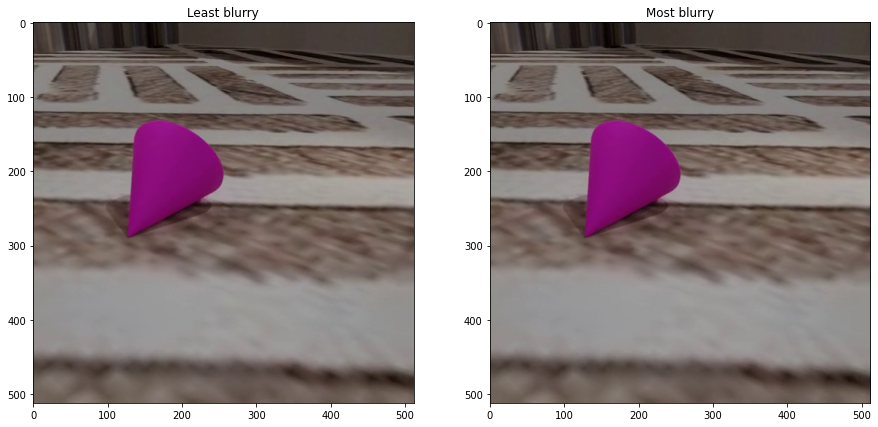

In [50]:
# @title Filter blurry frames.
from matplotlib import pyplot as plt
import numpy as np
import cv2

def variance_of_laplacian(image: np.ndarray) -> np.ndarray:
  """Compute the variance of the Laplacian which measure the focus."""
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return cv2.Laplacian(gray, cv2.CV_64F).var()


blur_filter_perc = 100.0 # @param {type: 'number'}
if blur_filter_perc > 0.0:
  image_paths = sorted(rgb_dir.iterdir())
  print('Loading images.')
  images = list(map(scene_manager.load_image, scene_manager.image_ids))
  print('Computing blur scores.')
  blur_scores = np.array([variance_of_laplacian(im) for im in images])
  blur_thres = np.percentile(blur_scores, blur_filter_perc)
  blur_filter_inds = np.where(blur_scores >= blur_thres)[0]
  blur_filter_scores = [blur_scores[i] for i in blur_filter_inds]
  blur_filter_inds = blur_filter_inds[np.argsort(blur_filter_scores)]
  blur_filter_scores = np.sort(blur_filter_scores)
  blur_filter_image_ids = [scene_manager.image_ids[i] for i in blur_filter_inds]
  print(f'Filtering {len(blur_filter_image_ids)} IDs: {blur_filter_image_ids}')
  num_filtered = scene_manager.filter_images(blur_filter_image_ids)
  print(f'Filtered {num_filtered} images')

  plt.figure(figsize=(15, 10))
  plt.subplot(121)
  plt.title('Least blurry')
  plt.imshow(images[blur_filter_inds[-1]])
  plt.subplot(122)
  plt.title('Most blurry')
  plt.imshow(images[blur_filter_inds[0]])

### Face Processing.

This section runs the optional step of computing facial landmarks for the purpose of test camera generation.

In [51]:
import jax
from jax import numpy as jnp
from tensorflow_graphics.geometry.representation.ray import triangulate as ray_triangulate

use_face = False  # @param {type: 'boolean'}

In [52]:
# @title Compute 2D landmarks.

import imageio
import mediapipe as mp
from PIL import Image

if use_face:
  mp_face_mesh = mp.solutions.face_mesh
  mp_drawing = mp.solutions.drawing_utils 
  drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
  
  # Initialize MediaPipe Face Mesh.
  face_mesh = mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=2,
      min_detection_confidence=0.5)
  
  
  def compute_landmarks(image):
    height, width = image.shape[:2]
    results = face_mesh.process(image)
    if results.multi_face_landmarks is None:
      return None
    # Choose first face found.
    landmarks = results.multi_face_landmarks[0].landmark
    landmarks = np.array(
        [(o.x * width, o.y * height) for o in landmarks],
        dtype=np.uint32)
    return landmarks

  landmarks_dict = {}
  for item_id in scene_manager.image_ids:
    image = scene_manager.load_image(item_id)
    landmarks = compute_landmarks(image)
    if landmarks is not None:
      landmarks_dict[item_id] = landmarks
  
  landmark_item_ids = sorted(landmarks_dict)
  landmarks_pixels = np.array([landmarks_dict[i] for i in landmark_item_ids])
  landmarks_cameras = [scene_manager.camera_dict[i] for i in landmark_item_ids]
  
  from matplotlib import pyplot as plt
  plt.imshow(image)
  plt.scatter(x=landmarks[..., 0], y=landmarks[..., 1], s=1);

In [53]:
# @title Triangulate landmarks in 3D.

if use_face:
  def compute_camera_rays(points, camera):
    origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
    directions = camera.pixels_to_rays(points.astype(jnp.float32))
    endpoints = origins + directions
    return origins, endpoints
  
  
  def triangulate_landmarks(landmarks, cameras):
    all_origins = []
    all_endpoints = []
    nan_inds = []
    for i, (camera_landmarks, camera) in enumerate(zip(landmarks, cameras)):
      origins, endpoints = compute_camera_rays(camera_landmarks, camera)
      if np.isnan(origins).sum() > 0.0 or np.isnan(endpoints).sum() > 0.0:
        continue
      all_origins.append(origins)
      all_endpoints.append(endpoints)
    all_origins = np.stack(all_origins, axis=-2).astype(np.float32)
    all_endpoints = np.stack(all_endpoints, axis=-2).astype(np.float32)
    weights = np.ones(all_origins.shape[:2], dtype=np.float32)
    points = np.array(ray_triangulate(all_origins, all_endpoints, weights))
  
    return points
  

  landmark_points = triangulate_landmarks(landmarks_pixels, landmarks_cameras)
else:
  landmark_points = None

In [54]:
# @title Normalize scene based on landmarks.
from scipy import linalg

DEFAULT_IPD = 0.06
NOSE_TIP_IDX = 1
FOREHEAD_IDX = 10
CHIN_IDX = 152
RIGHT_EYE_IDX = 145
LEFT_EYE_IDX = 385
RIGHT_TEMPLE_IDX = 162
LEFT_TEMPLE_IDX = 389


def _normalize(x):
  return x / linalg.norm(x)


def fit_plane_normal(points):
  """Fit a plane to the points and return the normal."""
  centroid = points.sum(axis=0) / points.shape[0]
  _, _, vh = linalg.svd(points - centroid)
  return vh[2, :]


def metric_scale_from_ipd(landmark_points, reference_ipd):
  """Infer the scene-to-metric conversion ratio from facial landmarks."""
  left_eye = landmark_points[LEFT_EYE_IDX]
  right_eye = landmark_points[RIGHT_EYE_IDX]
  model_ipd = linalg.norm(left_eye - right_eye)
  return reference_ipd / model_ipd


def basis_from_landmarks(landmark_points):
  """Computes an orthonormal basis from facial landmarks."""
  # Estimate Z by fitting a plane
  # This works better than trusting the chin to forehead vector, especially in
  # full body captures.
  face_axis_z = _normalize(fit_plane_normal(landmark_points))
  face_axis_y = _normalize(landmark_points[FOREHEAD_IDX] -
                           landmark_points[CHIN_IDX])
  face_axis_x = _normalize(landmark_points[LEFT_TEMPLE_IDX] -
                           landmark_points[RIGHT_TEMPLE_IDX])

  # Fitted plane normal might be flipped. Check using a heuristic and flip it if
  # it's flipped.
  z_flipped = np.dot(np.cross(face_axis_x, face_axis_y), face_axis_z)
  if z_flipped < 0.0:
    face_axis_z *= -1

  # Ensure axes are orthogonal, with the Z axis being fixed.
  face_axis_y = np.cross(face_axis_z, face_axis_x)
  face_axis_x = np.cross(face_axis_y, face_axis_z)

  return np.stack([face_axis_x, face_axis_y, face_axis_z]).T


if use_face:
  face_basis = basis_from_landmarks(landmark_points)
  new_scene_manager = scene_manager.change_basis(
      face_basis, landmark_points[NOSE_TIP_IDX])
  new_cameras = [new_scene_manager.camera_dict[i] for i in landmark_item_ids]
  new_landmark_points = triangulate_landmarks(landmarks_pixels, new_cameras)
  face_basis = basis_from_landmarks(landmark_points)
  scene_to_metric = metric_scale_from_ipd(landmark_points, DEFAULT_IPD)
  
  print(f'Computed basis: {face_basis}')
  print(f'Estimated metric scale = {scene_to_metric:.02f}')
else:
  new_scene_manager = scene_manager

## Compute scene information.

This section computes the scene information necessary for NeRF training.

In [55]:
# @title Compute near/far planes.
import pandas as pd


def estimate_near_far_for_image(scene_manager, image_id):
  """Estimate near/far plane for a single image based via point cloud."""
  points = filter_outlier_points(scene_manager.points, 0.95)
  points = np.concatenate([
      points,
      scene_manager.camera_positions,
  ], axis=0)
  camera = scene_manager.camera_dict[image_id]
  pixels = camera.project(points)
  depths = camera.points_to_local_points(points)[..., 2]

  # in_frustum = camera.ArePixelsInFrustum(pixels)
  in_frustum = (
      (pixels[..., 0] >= 0.0)
      & (pixels[..., 0] <= camera.image_size_x)
      & (pixels[..., 1] >= 0.0)
      & (pixels[..., 1] <= camera.image_size_y))
  depths = depths[in_frustum]

  in_front_of_camera = depths > 0
  depths = depths[in_front_of_camera]

  near = np.quantile(depths, 0.001)
  far = np.quantile(depths, 0.999)

  return near, far


def estimate_near_far(scene_manager):
  """Estimate near/far plane for a set of randomly-chosen images."""
  # image_ids = sorted(scene_manager.images.keys())
  image_ids = scene_manager.image_ids
  rng = np.random.RandomState(0)
  image_ids = rng.choice(
      image_ids, size=len(scene_manager.camera_list), replace=False)
  
  result = []
  for image_id in image_ids:
    near, far = estimate_near_far_for_image(scene_manager, image_id)
    result.append({'image_id': image_id, 'near': near, 'far': far})
  result = pd.DataFrame.from_records(result)
  return result


near_far = estimate_near_far(new_scene_manager)
print('Statistics for near/far computation:')
print(near_far.describe())
print()

near = near_far['near'].quantile(0.001) / 0.8
far = near_far['far'].quantile(0.999) * 1.2
print('Selected near/far values:')
print(f'Near = {near:.04f}')
print(f'Far = {far:.04f}')

/opt/conda/envs/hypernerf_pre/lib/python3.7/site-packages/nerfies/camera.py:291: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/envs/hypernerf_pre/lib/python3.7/site-packages/nerfies/camera.py:292: RuntimeWarning:

invalid value encountered in true_divide



Statistics for near/far computation:
             near         far
count  199.000000  199.000000
mean     1.505068  119.170963
std      0.568714    4.842874
min      0.015143  113.538727
25%      1.303861  115.100503
50%      1.498193  117.738857
75%      1.988244  122.551727
max      2.559817  130.461804

Selected near/far values:
Near = 0.0190
Far = 156.5149


In [56]:
# @title Compute scene center and scale.

def get_bbox_corners(points):
  lower = points.min(axis=0)
  upper = points.max(axis=0)
  return np.stack([lower, upper])


points = filter_outlier_points(new_scene_manager.points, 0.95)
bbox_corners = get_bbox_corners(
    np.concatenate([points, new_scene_manager.camera_positions], axis=0))

scene_center = np.mean(bbox_corners, axis=0)
scene_scale = 1.0 / np.sqrt(np.sum((bbox_corners[1] - bbox_corners[0]) ** 2))

print(f'Scene Center: {scene_center}')
print(f'Scene Scale: {scene_scale}')


Scene Center: [ 1.15951194 13.92354331 58.00492185]
Scene Scale: 0.00412568205923863


In [57]:
# @title Visualize scene.

def scatter_points(points, size=2):
  return go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=size),
  )

camera = new_scene_manager.camera_list[0]
near_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(near)).reshape((-1, 3))
far_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(far)).reshape((-1, 3))

data = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),
]
if use_face:
  data.append(scatter_points(new_landmark_points))
fig = go.Figure(data=data)
fig.update_layout(scene_dragmode='orbit')
fig.show()

## Generate test cameras.

In [58]:
# @title Define Utilities.
_EPSILON = 1e-5


def points_bound(points):
  """Computes the min and max dims of the points."""
  min_dim = np.min(points, axis=0)
  max_dim = np.max(points, axis=0)
  return np.stack((min_dim, max_dim), axis=1)


def points_centroid(points):
  """Computes the centroid of the points from the bounding box."""
  return points_bound(points).mean(axis=1)


def points_bounding_size(points):
  """Computes the bounding size of the points from the bounding box."""
  bounds = points_bound(points)
  return np.linalg.norm(bounds[:, 1] - bounds[:, 0])


def look_at(camera,
            camera_position: np.ndarray,
            look_at_position: np.ndarray,
            up_vector: np.ndarray):
  look_at_camera = camera.copy()
  optical_axis = look_at_position - camera_position
  norm = np.linalg.norm(optical_axis)
  if norm < _EPSILON:
    raise ValueError('The camera center and look at position are too close.')
  optical_axis /= norm

  right_vector = np.cross(optical_axis, up_vector)
  norm = np.linalg.norm(right_vector)
  if norm < _EPSILON:
    raise ValueError('The up-vector is parallel to the optical axis.')
  right_vector /= norm

  # The three directions here are orthogonal to each other and form a right
  # handed coordinate system.
  camera_rotation = np.identity(3)
  camera_rotation[0, :] = right_vector
  camera_rotation[1, :] = np.cross(optical_axis, right_vector)
  camera_rotation[2, :] = optical_axis

  look_at_camera.position = camera_position
  look_at_camera.orientation = camera_rotation
  return look_at_camera


In [59]:
# @title Generate camera trajectory.

import math
from scipy import interpolate
from plotly.offline import iplot
import plotly.graph_objs as go


def compute_camera_rays(points, camera):
  origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
  directions = camera.pixels_to_rays(points.astype(jnp.float32))
  endpoints = origins + directions
  return origins, endpoints


def triangulate_rays(origins, directions):
  origins = origins[np.newaxis, ...].astype('float32')
  directions = directions[np.newaxis, ...].astype('float32')
  weights = np.ones(origins.shape[:2], dtype=np.float32)
  points = np.array(ray_triangulate(origins, origins + directions, weights))
  return points.squeeze()


ref_cameras = [c for c in new_scene_manager.camera_list]
origins = np.array([c.position for c in ref_cameras])
directions = np.array([c.optical_axis for c in ref_cameras])
look_at = triangulate_rays(origins, directions)
print('look_at', look_at)

avg_position = np.mean(origins, axis=0)
print('avg_position', avg_position)

up = -np.mean([c.orientation[..., 1] for c in ref_cameras], axis=0)
print('up', up)

bounding_size = points_bounding_size(origins) / 2
x_scale =   0.75# @param {type: 'number'}
y_scale = 0.75  # @param {type: 'number'}
xs = x_scale * bounding_size
ys = y_scale * bounding_size
radius = 0.75  # @param {type: 'number'}
num_frames = 100  # @param {type: 'number'}


origin = np.zeros(3)

ref_camera = ref_cameras[0]
print(ref_camera.position)
z_offset = -0.1

angles = np.linspace(0, 2*math.pi, num=num_frames)
positions = []
for angle in angles:
  x = np.cos(angle) * radius * xs
  y = np.sin(angle) * radius * ys
  # x = xs * radius * np.cos(angle) / (1 + np.sin(angle) ** 2)
  # y = ys * radius * np.sin(angle) * np.cos(angle) / (1 + np.sin(angle) ** 2)

  position = np.array([x, y, z_offset])
  # Make distance to reference point constant.
  position = avg_position + position
  positions.append(position)

positions = np.stack(positions)

orbit_cameras = []
for position in positions:
  camera = ref_camera.look_at(position, look_at, up)
  orbit_cameras.append(camera)

camera_paths = {'orbit-mild': orbit_cameras}

traces = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),

  scatter_points(positions),
  scatter_points(origins),
]
fig = go.Figure(traces)
fig.update_layout(scene_dragmode='orbit')
fig.show()

look_at [ 0.77484566  0.9738131  29.06195   ]
avg_position [-0.04982715 -0.02577523  0.01531196]
up [-0.15122506 -0.8943235  -0.03402717]
[-6.7634087   0.05270515  0.17435446]


## Save data.

In [74]:
# @title Save scene information to `scene.json`.
from pprint import pprint
import json

scene_json_path = root_dir /  'scene.json'
with scene_json_path.open('w') as f:
  json.dump({
      'scale': scene_scale,
      'center': scene_center.tolist(),
      'bbox': bbox_corners.tolist(),
      'near': near * scene_scale,
      'far': far * scene_scale,
  }, f, indent=2)

print(f'Saved scene information to {scene_json_path}')

Saved scene information to data/kubric_test/scene.json


In [75]:
# @title Save dataset split to `dataset.json`.

VAL_RATIO = 0.1

all_ids = scene_manager.image_ids
val_ids = all_ids[::int(len(all_ids)*VAL_RATIO)]
train_ids = sorted(set(all_ids) - set(val_ids))

print(f'Num of train: {len(train_ids)}')
print(f'Num of val: {len(val_ids)}')

dataset_json = {
    'count': len(scene_manager),
    'num_exemplars': len(train_ids),
    'ids': scene_manager.image_ids,
    'train_ids': train_ids,
    'val_ids': val_ids,
}

dataset_json_path = root_dir / 'dataset.json'
with dataset_json_path.open('w') as f:
    json.dump(dataset_json, f, indent=2)

print(f'Saved dataset information to {dataset_json_path}')

Num of train: 188
Num of val: 11
Saved dataset information to data/kubric_test/dataset.json


In [77]:
# @title Save metadata information to `metadata.json`.
import bisect

metadata_json = {}
for i, image_id in enumerate(train_ids):
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }
for i, image_id in enumerate(val_ids):
  i = bisect.bisect_left(train_ids, image_id)
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }

metadata_json_path = root_dir / 'metadata.json'
with metadata_json_path.open('w') as f:
    json.dump(metadata_json, f, indent=2)

print(f'Saved metadata information to {metadata_json_path}')

Saved metadata information to data/kubric_test/metadata.json


In [78]:
# @title Save cameras.
camera_dir = root_dir / 'camera'
camera_dir.mkdir(exist_ok=True, parents=True)
for item_id, camera in new_scene_manager.camera_dict.items():
  camera_path = camera_dir / f'{item_id}.json'
  print(f'Saving camera to {camera_path!s}')
  with camera_path.open('w') as f:
    json.dump(camera.to_json(), f, indent=2)

Saving camera to data/kubric_test/camera/000001.json
Saving camera to data/kubric_test/camera/000002.json
Saving camera to data/kubric_test/camera/000004.json
Saving camera to data/kubric_test/camera/000006.json
Saving camera to data/kubric_test/camera/000007.json
Saving camera to data/kubric_test/camera/000005.json
Saving camera to data/kubric_test/camera/000003.json
Saving camera to data/kubric_test/camera/000013.json
Saving camera to data/kubric_test/camera/000011.json
Saving camera to data/kubric_test/camera/000009.json
Saving camera to data/kubric_test/camera/000012.json
Saving camera to data/kubric_test/camera/000010.json
Saving camera to data/kubric_test/camera/000008.json
Saving camera to data/kubric_test/camera/000014.json
Saving camera to data/kubric_test/camera/000016.json
Saving camera to data/kubric_test/camera/000020.json
Saving camera to data/kubric_test/camera/000017.json
Saving camera to data/kubric_test/camera/000019.json
Saving camera to data/kubric_test/camera/00002

In [79]:
# @title Save test cameras.

import json

test_camera_dir = root_dir / 'camera-paths'
for test_path_name, test_cameras in camera_paths.items():
  out_dir = test_camera_dir / test_path_name
  out_dir.mkdir(exist_ok=True, parents=True)
  for i, camera in enumerate(test_cameras):
    camera_path = out_dir / f'{i:06d}.json'
    print(f'Saving camera to {camera_path!s}')
    with camera_path.open('w') as f:
      json.dump(camera.to_json(), f, indent=2)

Saving camera to data/kubric_test/camera-paths/orbit-mild/000000.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000001.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000002.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000003.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000004.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000005.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000006.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000007.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000008.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000009.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000010.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000011.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000012.json
Saving camera to data/kubric_test/camera-paths/orbit-mild/000013.json
Saving camera to dat

## Training

 * You are now ready to train a Nerfie!
 * Head over to the [training Colab](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb) for a basic demo.